# 프로젝트 목표

> 본 프로젝트는 이전 [Lecture8](https://github.com/Zil-M/Zil-M-NLP_Lecture/blob/main/Lecture8/Lecture8.%20Korean-English%20translator.ipynb) 프로젝트의 Bahdanau Attention 모델 기반 국문-영문 번역기 성능을 <br>
> Transformer 모델과 SentencePiece 토큰을 기반으로 성능을 개선하는것을 목표로 한다.

In [1]:
import re
import os
import io
import time
import random
import seaborn 
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 1. Data Load

> 본 1장에서는 프로젝트에 활용할 데이터를 메모리에 할당 후 하나의 데이터셋으로 통합하는 과정을 기술한다.

In [2]:
def load_dataset(file_name):
    data_set = None
    with open('../transformer/data/'+file_name, 'r') as f:
        data_set = f.read().splitlines()
        
    return data_set     

> KR-EN 번역기에 활용할 국문 데이터와 영문 데이터를 load_dataset() 함수로 불러온다.

In [3]:
english_data = load_dataset('korean-english-park.train.en')
krean_data = load_dataset('korean-english-park.train.ko')

> 불러온 영문 데이터와 국문 데이터의 내용이 한 쌍으로 구성되어있는지 확인하는 작업을 진행한다.

In [4]:
print(english_data[:3])
print('\n', krean_data[:3])

['Much of personal computing is about "can you top this?"', 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.', "Like all optical mice, But it also doesn't need a desk."]

 ['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.', '그러나 이것은 또한 책상도 필요로 하지 않는다.']


> 이전 [Lecture8](https://github.com/Zil-M/Zil-M-NLP_Lecture/blob/main/Lecture8/Lecture8.%20Korean-English%20translator.ipynb) 프로젝트와 동일한 데이터임을 확인했다.<br>
> 국문, 영문 데이터가 한 쌍으로 구성되어있으므로 편의성을 위해 하나의 시트(sheet)로 통합한다.

In [5]:
kr_en_dataset = pd.DataFrame(zip(english_data, krean_data), columns=['en', 'kr'])

In [6]:
kr_en_dataset[:5]

,en,kr
0,"Much of personal computing is about ""can you t...","개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다.
3,uses gyroscopic sensors to control the cursor ...,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,Intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...


# 2. Data Analysis

> 본 2 장에서는 국문-영문 번역기 모델에 활용할 데이터를 분석하는 과정을 기술한다.<br>
> 데이터 분석 과정에서는 데이터 정보 확인, 결측치 확인, 중복 데이터 확인, 문장 길이 분포 확인 작업이 진행된다.

## 2.1 Check Dataset Info

> <code>pandas.DataFrame.info()</code>을 활용하여 국문-영문 통합 데이터셋인 <code>kr_en_dataset</code>의 구성 정보를 확인한다.

In [7]:
kr_en_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94123 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   en      94123 non-null  object
 1   kr      94123 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


> 국문과 영문 모두 94,123개의 index를 가지고 있으며, 결측치는 Null(0), 관측되지 않았다.

## 2.2 Check Dataset Deduplication

> <code>kr_en_dataset</code>에 중복되는 데이터가 없도록 중복을 제거하는 작업을 진행한다.

In [8]:
kr_en_dataset.drop_duplicates(["en"], inplace=True)
kr_en_dataset.drop_duplicates(["kr"], inplace=True)

In [9]:
kr_en_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74786 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   en      74786 non-null  object
 1   kr      74786 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


> 중복 데이터를 제거한 <code>kr_en_dataset</code>의 데이터는 기존 94,123 개에서 74,786 개로 감소되며, 19,337개의 중복 데이터가 제거되었음을 확인할 수 있다.

## 2.3 Check Sentence Length

> 국문과 영문 문장 속 단어의 개수 정보를 확인하는 함수를 구현하고, 이를 확인하는 작업을 진행한다.

In [10]:
def view_sentence_length_distribution(df_data, graph_title):
    min_len = 999
    max_len = 0
    sum_len = 0

    for sen in df_data:
        length = len(sen.split())
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length

    print(graph_title,"문장 속 단어 최소 개수:", min_len)
    print(graph_title,"문장 속 단어 최대 개수:", max_len)
    print(graph_title,"문장 속 단어 평균 개수:", sum_len // len(df_data))

    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in df_data:
        sentence_length[len(sen.split())-1] += 1
    
    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title(graph_title+"문장 길이 분포")
    plt.show()

> <code>view_sentence_length_distribution()</code>를 활용하여 국문과 영문 문장 속 데이터의 개수를 확인한다.

영문  문장 속 단어 최소 개수: 1
영문  문장 속 단어 최대 개수: 90
영문  문장 속 단어 평균 개수: 22


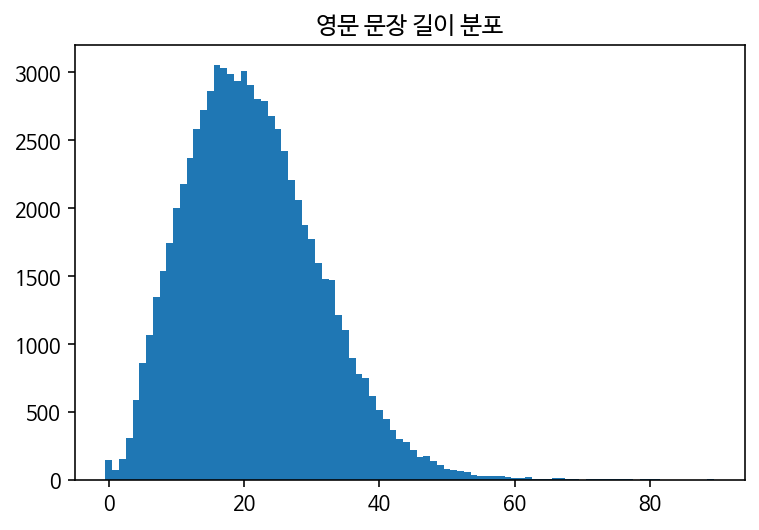

국문  문장 속 단어 최소 개수: 1
국문  문장 속 단어 최대 개수: 82
국문  문장 속 단어 평균 개수: 15


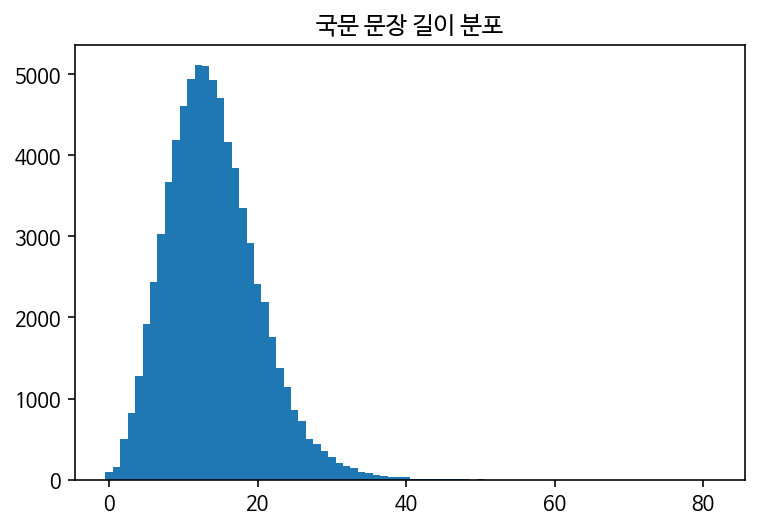

In [11]:
view_sentence_length_distribution(kr_en_dataset['en'],"영문 ")
view_sentence_length_distribution(kr_en_dataset['kr'],"국문 ")

> 영문 속 단어의 평균 개수는 22개이며, 0 ~ 50의 범위로 보았을 때 정규 분포의 형태를 확인할 수 있다.<br>
> 국문 속 단어의 평균 개수는 15개이며, 0 ~ 40의 범위로 보았을 때 정규 분포의 형태를 확인할 수 있다.

# 3. Data preprocessing

> 2장에서 진행한 데이터 분석 결과를 바탕으로 데이터를 전처리하는 과정을 진행한다.<br>
> 데이터 전처리는 모델에 사용할 데이터 범위 규정, 정규식을 활용한 문장 정제, 문장 토큰화 작업을 진행한다.

## 3.1 문장 데이터 범위 규정

> 단어의 개수가 너무 적으면 노이즈가 될 수 있으므로, 단어의 개수가 너무 많으면 모델의 복잡도(연산량)이/가 비효율적으로 증가하므로 각 국-영문 데이터의 분포에 맞춰 적절한 개수로 범위를 제한하는 작업을 진행한다.

In [12]:
def sentence_lenght_limit(df_data, sentence_max, colume):
    temp_df = df_data.copy()
    temp_df["count"] = temp_df[colume].apply(lambda x: len(x.split()))
    temp_df = temp_df.loc[temp_df["count"] <= sentence_max]
    temp_df.drop(["count"], axis="columns", inplace=True)
    
    return temp_df

> 국문 데이터는 문장 속 단어 개수가 40개 초과, 영문 데이터는 60개가 초과되는 문장을 제거한다.

In [13]:
kr_en_dataset = sentence_lenght_limit(kr_en_dataset, 60, 'en')
kr_en_dataset = sentence_lenght_limit(kr_en_dataset, 40, 'kr')

In [14]:
kr_en_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74597 entries, 0 to 94122
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   en      74597 non-null  object
 1   kr      74597 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


> 단어 개수 범위 조건 내에 해당하는 kr_en_dataset 문장 개수는 기존 74,786 개에서 189 개가 감소한 74,597 개이다.

## 3.2 정규식을 활용한 문장 정제

> 모델이 자연어를 학습함에 있어서 특수문자는 불필요한 노이즈로 작용하므로, 규칙 내 특수 문자와 국문-영문에 해당하지 않는 문자를 제거 후 공백으로 처리한다.<br>

In [15]:
def preprocess_sentence(sentence):
    
    # step1. 영문의 경우 소문자로 변환 후 좌우 공백 제거
    sentence = sentence.lower().strip()
    
    # 문장 부호 이외 다른 특수문자 제거
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # list의 []는 공백처리
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 영문,국문,예외 특수기호 이외 모든 문자는 공백처리
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,]+", " ", sentence)
    
    # 단어 좌우 공백 제거
    sentence = sentence.strip()

    return sentence

In [16]:
kr_en_dataset['en'] = kr_en_dataset['en'].apply(lambda x: preprocess_sentence(x))
kr_en_dataset['kr'] = kr_en_dataset['kr'].apply(lambda x: preprocess_sentence(x))

In [17]:
kr_en_dataset[:5]

,en,kr
0,much of personal computing is about can you to...,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"like all optical mice , but it also doesn t ne...",그러나 이것은 또한 책상도 필요로 하지 않는다 .
3,uses gyroscopic sensors to control the cursor ...,"79 . 95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 , 팔 , 그외에 어..."
4,intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 테러 계획들이 실패로 돌아갔음을...


## 3.3 문장 토큰화

> 국문-영문 번역기 모델에 활용할 데이터를 sentencepiece 클래스를 활용하여 단어 단위로 토큰화하는 함수를 구현 및 토큰화를 진행한다.<br>
> [Sentencepiece python module](https://github.com/google/sentencepiece/blob/master/python/README.md),  [SentencePiece Tokenizer](https://donghwa-kim.github.io/SPM.html)를 참고하여 SentencePiece Tokenizer을 구현했다.

In [18]:
def generate_tokenizer(df_data, max_len, lang="kr", vocab_size = 25000):
    # step1. df_data의 문장 데이터를 txt 파일로 저장
    with open(f"./Data/lecture10/{lang}_sentence.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(df_data))
    
    
    # step2. txt과 설정을 문자열로 등록 후 모델 train 및 저장
    prefix = f"{lang}_sentence"
    
    spm.SentencePieceTrainer.train(
    f"--input=./Data/lecture10/{lang}_sentence.txt --model_prefix={prefix} --vocab_size={vocab_size + 4}" + 
    f" --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    f" --bos_id=1 --bos_piece=[BOS]" + # begin of sequence (1)
    f" --eos_id=2 --eos_piece=[EOS]" + # end of sequence (2)
    f" --unk_id=3 --unk_piece=[UNK]")# unknown (3)
    
    # step3. create tokenizer object
    tokenizer = spm.SentencePieceProcessor()
        
    # step4. load tokenizer model
    tokenizer.load(f"./{lang}_sentence.model")

    return tokenizer

In [19]:
def sentence_piece_tokenize(df_data, lang="kr"):
    tokenizer = generate_tokenizer(df_data, lang)
    
    if lang == "en":
        tokenizer.set_encode_extra_options("bos:eos")

    tensor = df_data.apply(tokenizer.EncodeAsIds).tolist()
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
        
    return tensor, tokenizer

In [20]:
enc_tensor, enc_tokenizer = sentence_piece_tokenize(kr_en_dataset['kr'], 'kr')
dec_tensor, dec_tokenizer = sentence_piece_tokenize(kr_en_dataset['en'], 'en')

In [21]:
print("국문 단어장 크기:", len(enc_tokenizer))
print("영문 단어장 크기:", len(dec_tokenizer))

국문 단어장 크기: 25004
영문 단어장 크기: 25004


# 4. Transformer Model design

> 본 실습의 국문-영문 번역기 모델은 Transformer 모델로 제작한다.<br>
> Transformer 모델은 기존 NLP 자주 사용하는 LSTM, RNN 기반 모델과 달리 '시간적 연속성'을 모델의 핵심부에서 처리하지 않는다.<br>
> Transformer 모델의 핵심은 <code>attention</code>이며, 예측 과정에서 attention 값이 가장 높은 단어가 다음 단어로 출력되도록 한다.<br>
> 이는 Attention 함수가 적용된 layer에서는 구조적으로 '시간적 연속성'이 없이 입력값을 다루게 된다.<br>
> 때문에, 데이터가 거쳐가는 layer의 수를 줄여, 연산비용 절약과, 기존 RNN 류 모델의 기울기 소실 문제 등에서 자유로운 장점이 있다.<br>

> Transformer 모델은 아래 그림처럼 Encoder-Decoder 구조로 이루어져 있으며, Encoder와 Decoder 각각 <code>positional_encoding</code>, <code>Multi-Head Attention</code>, <code>Position-wise Feed-Forward Network</code>를 결합한 형태로 구성되어 있다.<br>
> <br>
> [참고 사이트 : Transformer Architecture](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)<br>
> [참고 사이트 : 어텐션 메커니즘과 transfomer(self-attention)](https://medium.com/platfarm/%EC%96%B4%ED%85%90%EC%85%98-%EB%A9%94%EC%BB%A4%EB%8B%88%EC%A6%98%EA%B3%BC-transfomer-self-attention-842498fd3225)

## 4.1 Transformer's Internal Module

> Transformer 모델의 Encoder와 Decoder을 구성하는 <code>positional_encoding</code>, <code>Multi-Head Attention</code>, <code>Position-wise Feed-Forward Network</code>를 구현한다.

### 4.1.1 Positional Encoding

> 언어에서 문장 내 어순은, 언어를 이해하는 데 중요한 역할을 한다.<br>
> 때문에, Layer에 입력하기 전에 어순 정보에 대한 데이터 전처리가 필요하다.<br>
> <br>
> 이에, Positional Encoding은 데이터가 Attention Layer에 들어가기 전에, 입력값인 단어 vector안에 단어의 위치 정보를 포함하는 기능을 수행하여 어순 정보를 제공하는 역할을 한다.<br>
>
> [참고 사이트 : positional encoding이란 무엇인가](https://skyjwoo.tistory.com/entry/positional-encoding%EC%9D%B4%EB%9E%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80)

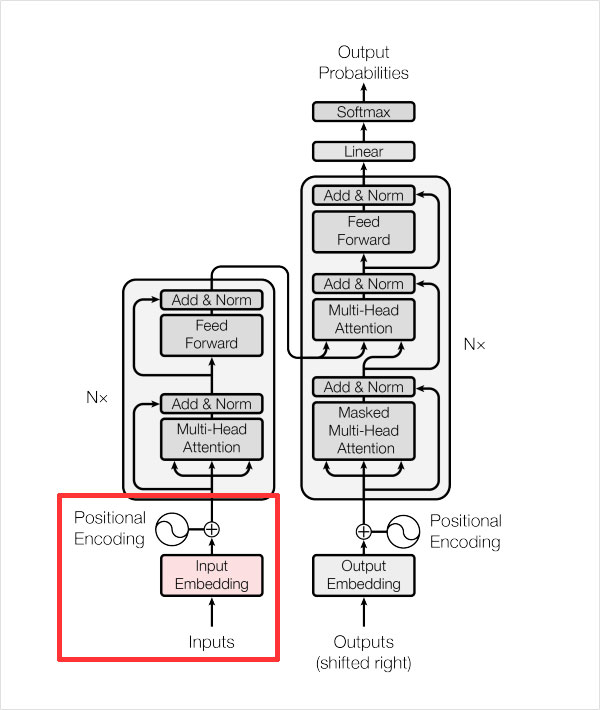

In [22]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

### 4.1.2 Multi-Head Attention

> Multi-Head Attention는 한 문장을 여러 head로 나누고, 이를 Self-Attention 하는 역할을 맡는다.<br>
> <br>
> 입력된 문장의 임베딩 벡터가 512차원이고, Head가 8개이면, 512/8 = 64개의 벡터를 하나씩 Scaled Dot Attention이 처리한다.<br>
> 즉, 8명(8 heads)이 각각의 관점에서 가중치를 계산하고, 이후에 결과를 (+)합치는 작업을 진행한다.<br>

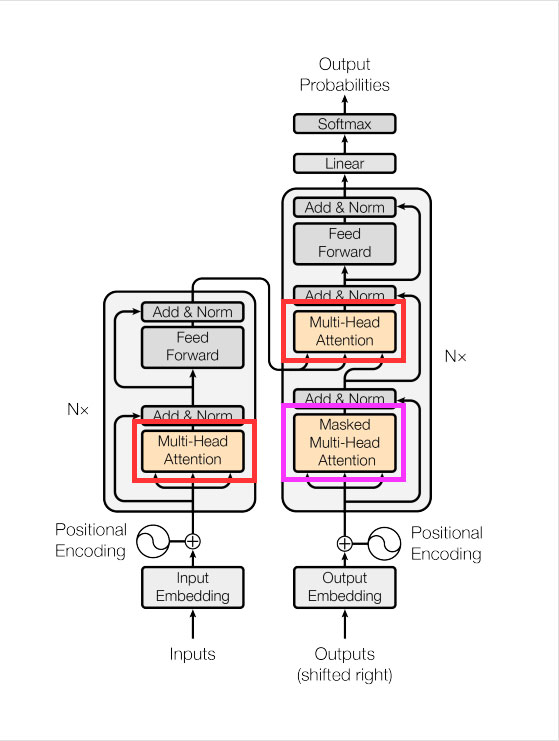

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### 4.1.3 Position-wise Feed-Forward Network

> 이전 Multi-Head Attention에서 각 head가 자신의 관점으로만 문장을 Self-Attention 하면, 각 head 마다 Attention이 편향되는 문제가 발생한다.<br> 
> <br>
> 이에, PoswiseFeedForwardNet은 각 head가 만들어낸 Self-Attention을 치우치지 않게 균등하게 조합하는 역할을 수행한다.<br>

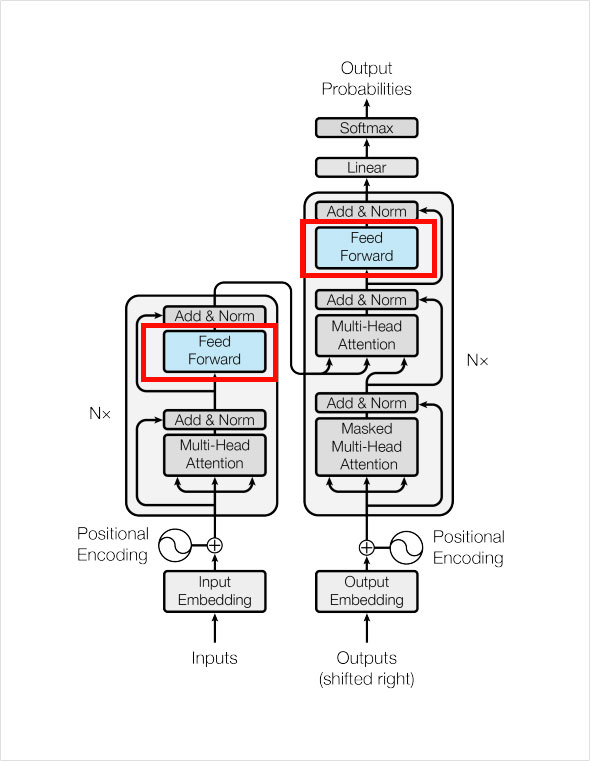

In [24]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## 4.2 Encoder & Decoder Module

> 4.1장에서 구현한 모듈을 활용하여 <code>Encoder</code>와 <code>Decoder</code>의 Layer와 Class를 구현한다.

### 4.2.1 Encoder Layer

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

### 4.2.2 Decoder Layer

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
       
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### 4.2.3 Encoder class

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### 4.2.4 Decoder class

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### 4.2.5 Transformer class

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

            
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 4.3 Utility Module

### 4.3.1 Masking

> Masking은 Attention을 할 때에 PAD 토큰에 Attention을 주는 것을 방지해 주는 역할을 수행한다.<br>
> Transformer의 Decoder에서도 PAD 토큰을 사용하지 않도록 <code>padding_mask</code>와 <code>causality_mask</code>를 결합하여 Masking을 구현한다.

In [30]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### 4.3.2 LearningRateSchedule class

> Transformer의 학습률은 고정된 값을 사용하지 않고 학습 진행도에 따라 초기에는 높은 학습률로, 이후 점차 학습률을 감소시킨다.<br>
> 이에, 모델이  유동적으로 변동하는 학습을 진행할 수 있도록 학습률과 옵티마이저를 설정하는 <code>LearningRateScheduler</code> 클래스를 구현한다.

In [31]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

# 5. Transformer Model train setting

> 본 5장에서는 Transformer Model을 학습하기 위한 사전 설정 과정을 기술한다.

## 5.1 Hyper parameter setting

> Transformer Model에 사용할 <code>Loss</code> 함수를 재 정의하여  Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가한다.

In [32]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)  

> 모델의 <code>learing_rate</code>, <code>optimizer</code>, <code>loss rate</code>에 대한 객체를 생성한다.

In [33]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

## 5.2 Train setp function

> 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있도록 <code>train_setp</code> 함수를 정의한다.

In [34]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

## 5.3 Transformer Model  번역 생성 및 Attention 시각화 

> Transformer Model의 번역문과 Attention의 결과를 시각화 하는 각각의 함수를 구현한다.

In [35]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, square=True, vmin=0.0, vmax=1.0, cbar=False, ax=ax, xticklabels=x, yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [36]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_tensor.shape[-1], padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    
    for i in range(dec_tensor.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [37]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('-'*30)
    print('입력 문장 : %s' % (sentence))
    print('번역 후 예측 문장 : {}'.format(result))
    print('-'*30)
    
    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

    print('\n')

# 6. Transformer Model Train & Result

> 본 6장에서는 Transformer Model을 학습하고 결과를 확인하는 과정을 기술한다.<br>
> <br>
> Transformer model의 Encoder와 Decoder Layer는 각각 2개씩 구성되어 있으며, 임베딩 차원은 256, Attention의 head는 8개, Dropout는 20%로 설정하여 학습을 진행한다.<br>
> 학습 도중 <code>examples</code> 예문을 활용하여 2 epoch당 Transformer의 성능을 확인하고, 2 epoch당 Attention의 결과를 시각화하여 출력한다.
>

In [38]:
BATCH_SIZE = 64
EPOCHS = 10

transformer2 = Transformer(n_layers = 2, d_model = 256, n_heads = 8, d_ff = 128,
                    src_vocab_size = 25004, tgt_vocab_size = 25004, pos_len = 200, dropout=0.2, shared=True)


examples = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.", "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_tensor[idx:idx+BATCH_SIZE], dec_tensor[idx:idx+BATCH_SIZE], transformer2, optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    print('-'*17,f' {epoch+1} epoch ','-'*17)
    
    for example in examples:
        if(epoch+1) % 2 == 0:
            translate(example, transformer2, enc_tokenizer, dec_tokenizer, plot_attention=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  1 epoch  -----------------


  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  2 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama s campaign , the president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they are also began .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : they are not , you will be a lot .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : the fire was also killed .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  3 epoch  -----------------


  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  4 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama has obama s inauguration .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they were also about the city .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : coffee don t get coffee .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : the death toll from the death toll .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  5 epoch  -----------------


  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  6 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is the president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : citizens in the city , the city s city .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : no coffee isn t coffee .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : the seventh , died .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  7 epoch  -----------------


  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  8 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama s president is the president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : citizens in the town of about the home .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : no coffee orn t need to eat .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven people were killed , the official said .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  9 epoch  -----------------


  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  10 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama s president is now in the presidential election .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : the citizens are the citizens .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : not coffee or prices .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the dead were killed .
------------------------------




> Epoch를 10회 진행한 결과 최종 Loss 는 2.0488이고, 국문-영문 번역 결과는 아래와 같다.

> Transformer 기반 국문-영문 번역기 결과 ( Epoch 10회 )

> 국문 입력 문장 : 오바마는 대통령이다.<br>
> 영문 번역 문장 : obama s president is now in the presidential election . -> 오바마 대통령은 지금 대통령 선거에 있다 .<br>
> 의역 : 오바마 대통령은 지금 대통령 선거 중이다 .<br>

> 국문 입력 문장 : 시민들은 도시 속에 산다.<br>
> 영문 번역 문장 : the citizens are the citizens . -> 시민은 시민이다.<br>
> 의역 : 시민은 시민이다. <br>

> 국문 입력 문장 : 커피는 필요 없다.<br>
> 영문 번역 문장 : not coffee or prices . -> 커피나 가격이 아닌.<br>
> 의역 : 커피나 가격이 아니다.<br>

> 입력 문장 : 일곱 명의 사망자가 발생했다.<br>
> 번역 후 예측 문장 : seven of the dead were killed  -> 사망자 7명 사망<br>
> 의역 : 사망자 중 7명이 죽었다.<br>

> Epoch를 10회 진행한 Transformer model은 번역 성능이 준수한 모습을 보여주지 못했다.<br>
> 입력된 국문의 단어와 다른 의미를 가진 단어로 변경되거나, 기존 문맥과 다르게 번역한 모습을 확인할 수 있다.<br>
> <br>
> 그럼에도, 이전 Lecture8 프로젝트의 Bahdanau Attention 모델 기반 국문-영문 번역기보다 개선된 부분도 확인할 수 있다.<br>
> <br>
> Bahdanau Attention 모델 기반 국문-영문 번역기는 영문 문법이 올바르지 않았으며, 국문의 내용과 전혀 다른 내용을 출력했다.<br>
> 그러나, Transformer model은 영문법에 맞게 번역하여 출력하는 모습을 확인할 수 있다.<br>
> 또한, 비록 국문의 문장을 올바르게 번역하지는 못했으나, 문맥과 유사하게 예측하려는 모습을 확인할 수 있다.<br>

## 6.2 EPOCHS 20

> Epoch을 10회 진행한 Transformer Model의 성능이 Bahdanau Attention 모델보다 좋은 성능을 보여주었다.<br>
> 이에, Epoch 횟수 10에서 20으로 높여 학습했을 때, 기존 Transformer model과의 성능을 비교하고자 한다.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  1 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama s obama s obama s obama s obama .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they is around they .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : they is they .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : the government , 000 people were killed to the military .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  2 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is the president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they were taken to the region .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it is not anything .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : the death toll was killed .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  3 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is a president of obama s president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : the city of tourists are in the city of tourists .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : they don t don t don t think anything or anything .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : the death toll was killed in the death toll .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  4 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is a president of obama s president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : the city is a city of city
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : no or or or no .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : the death toll was killed in the death toll .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  5 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is the president elect
------------------------------
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


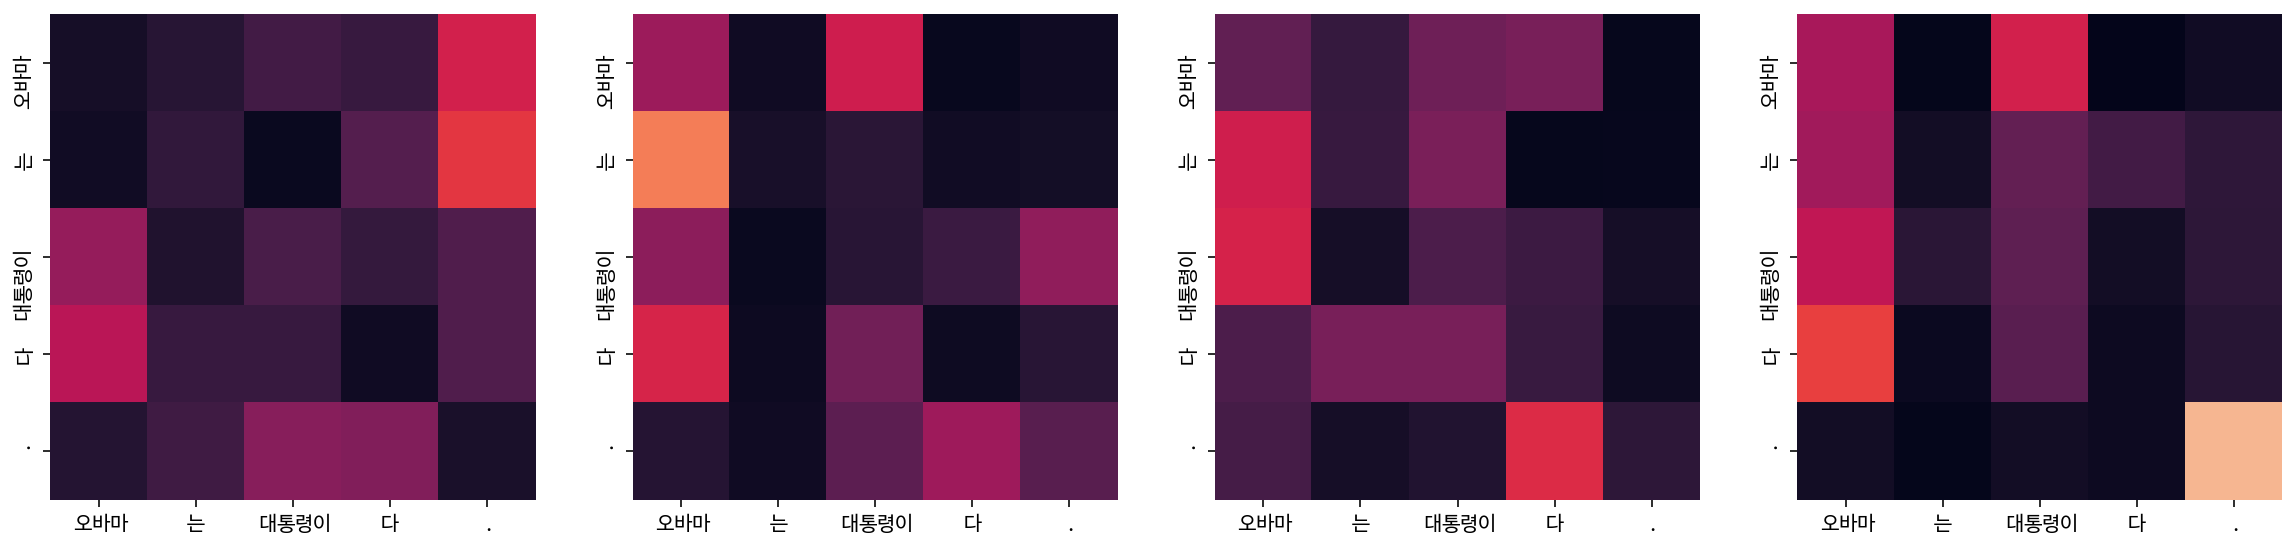

Encoder Layer 2


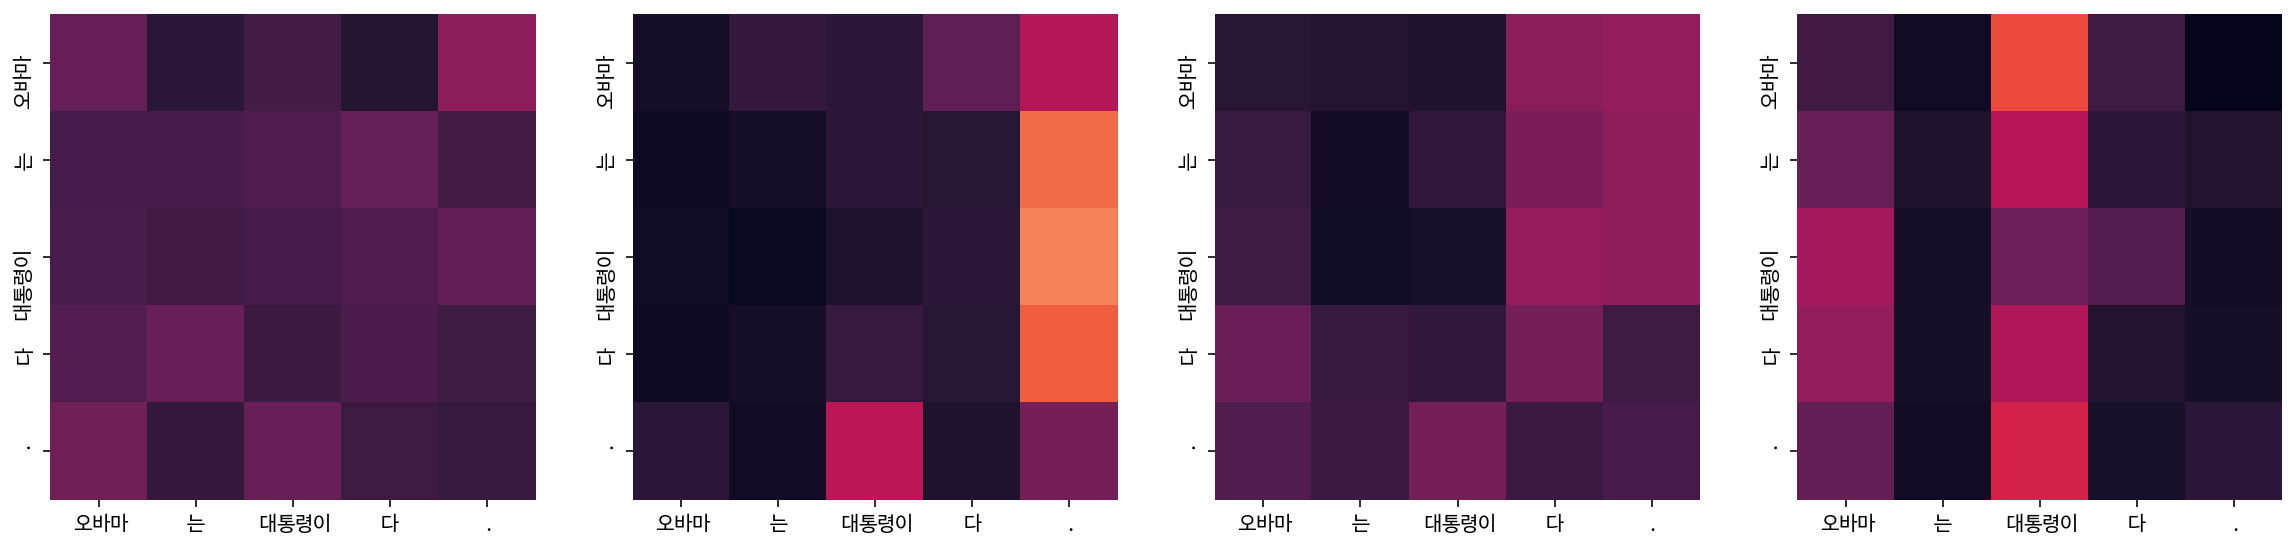

Decoder Self Layer 1


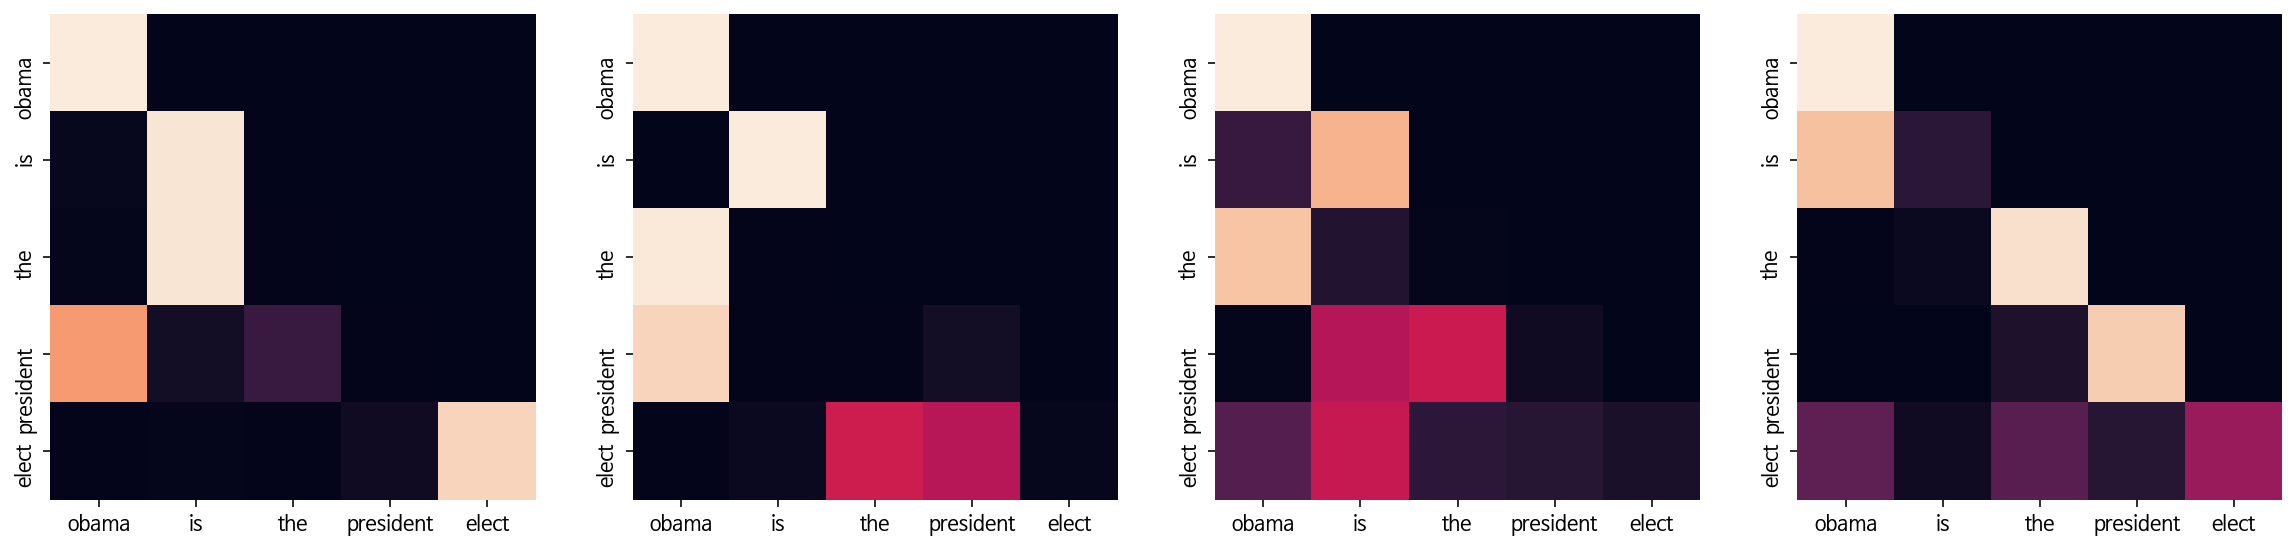

Decoder Src Layer 1


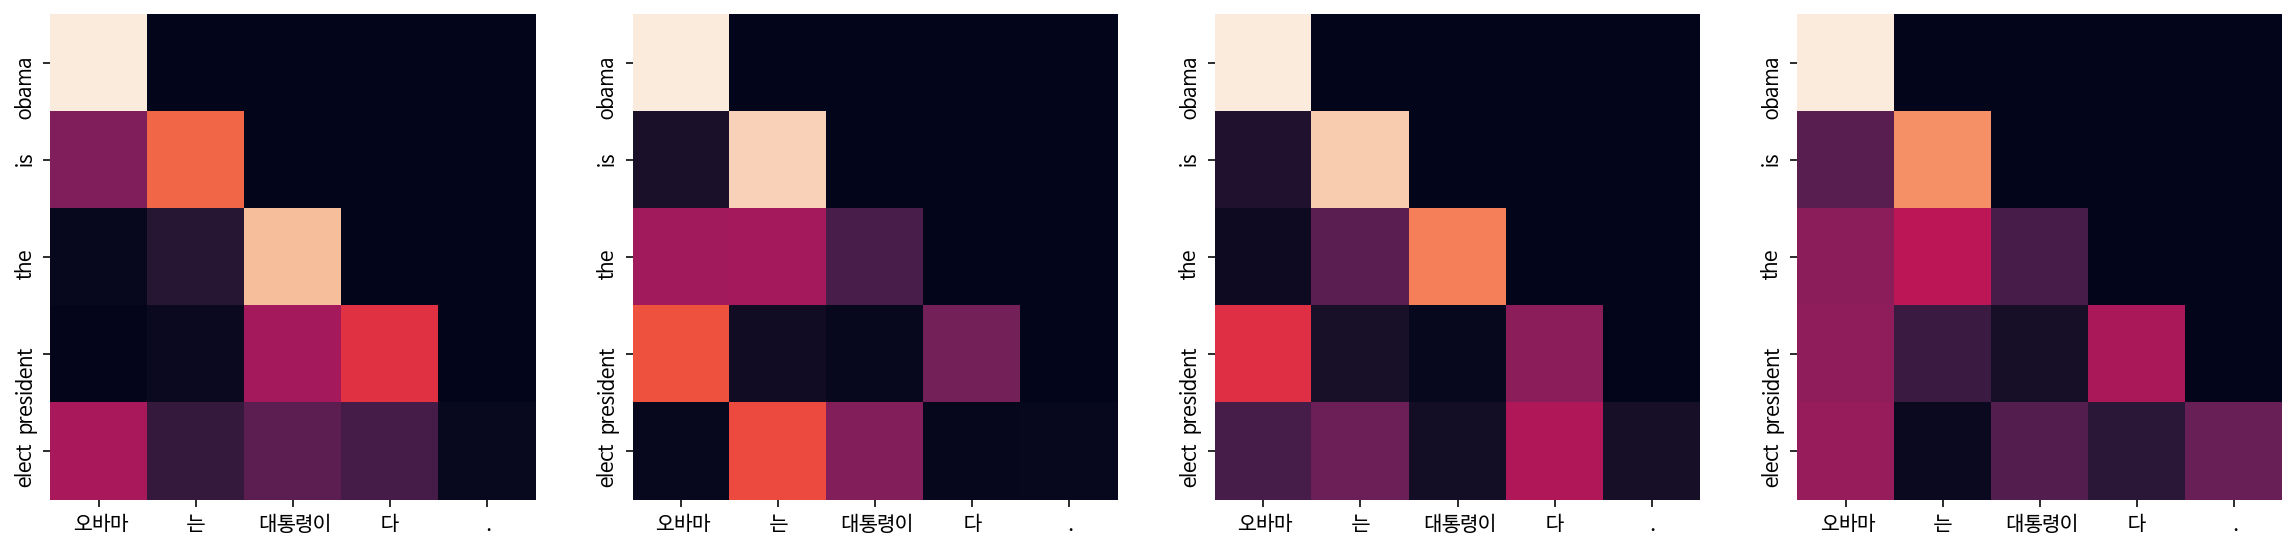

Decoder Self Layer 2


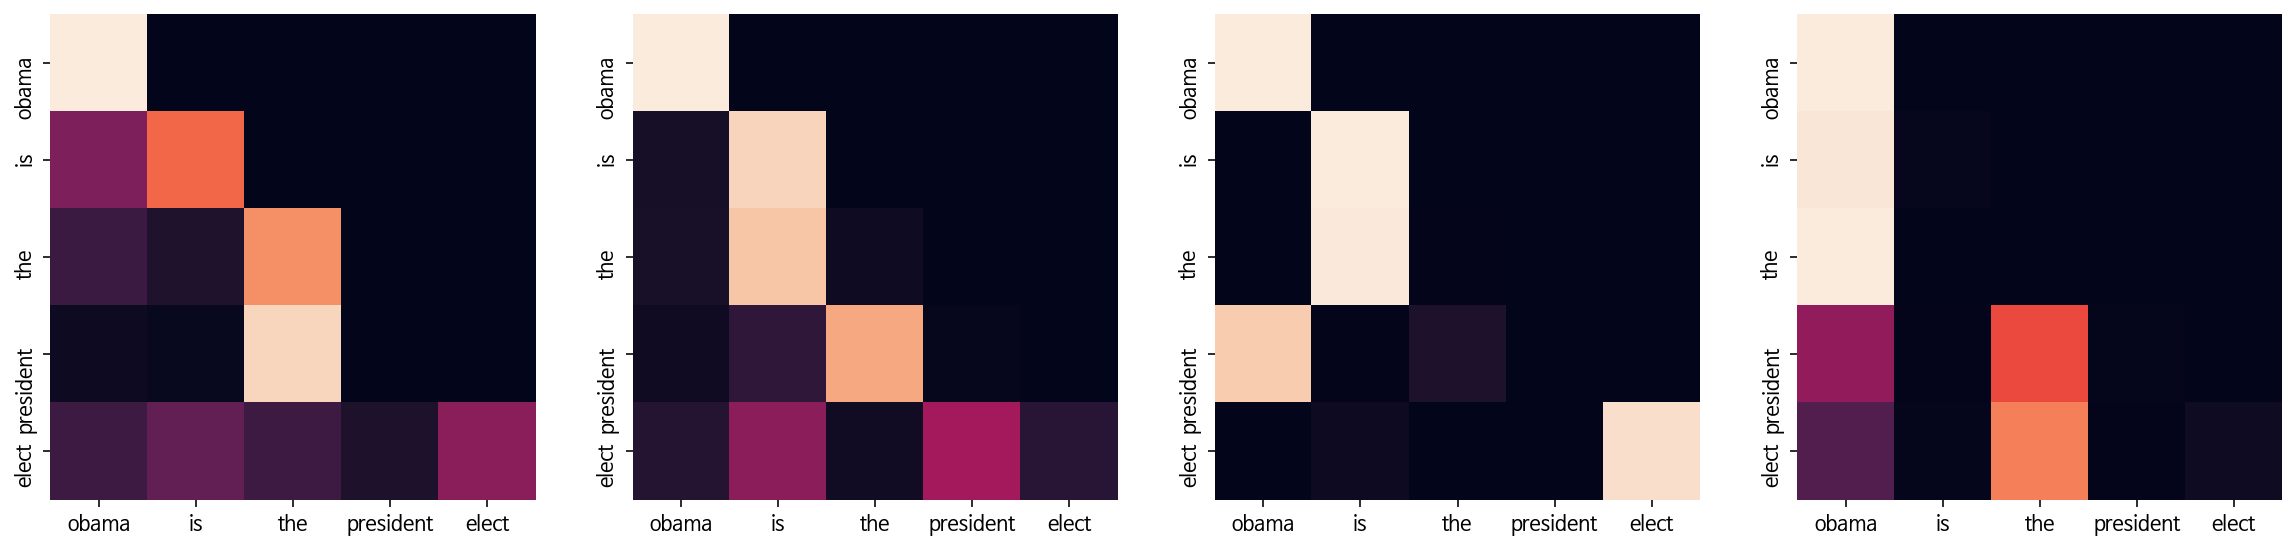

Decoder Src Layer 2


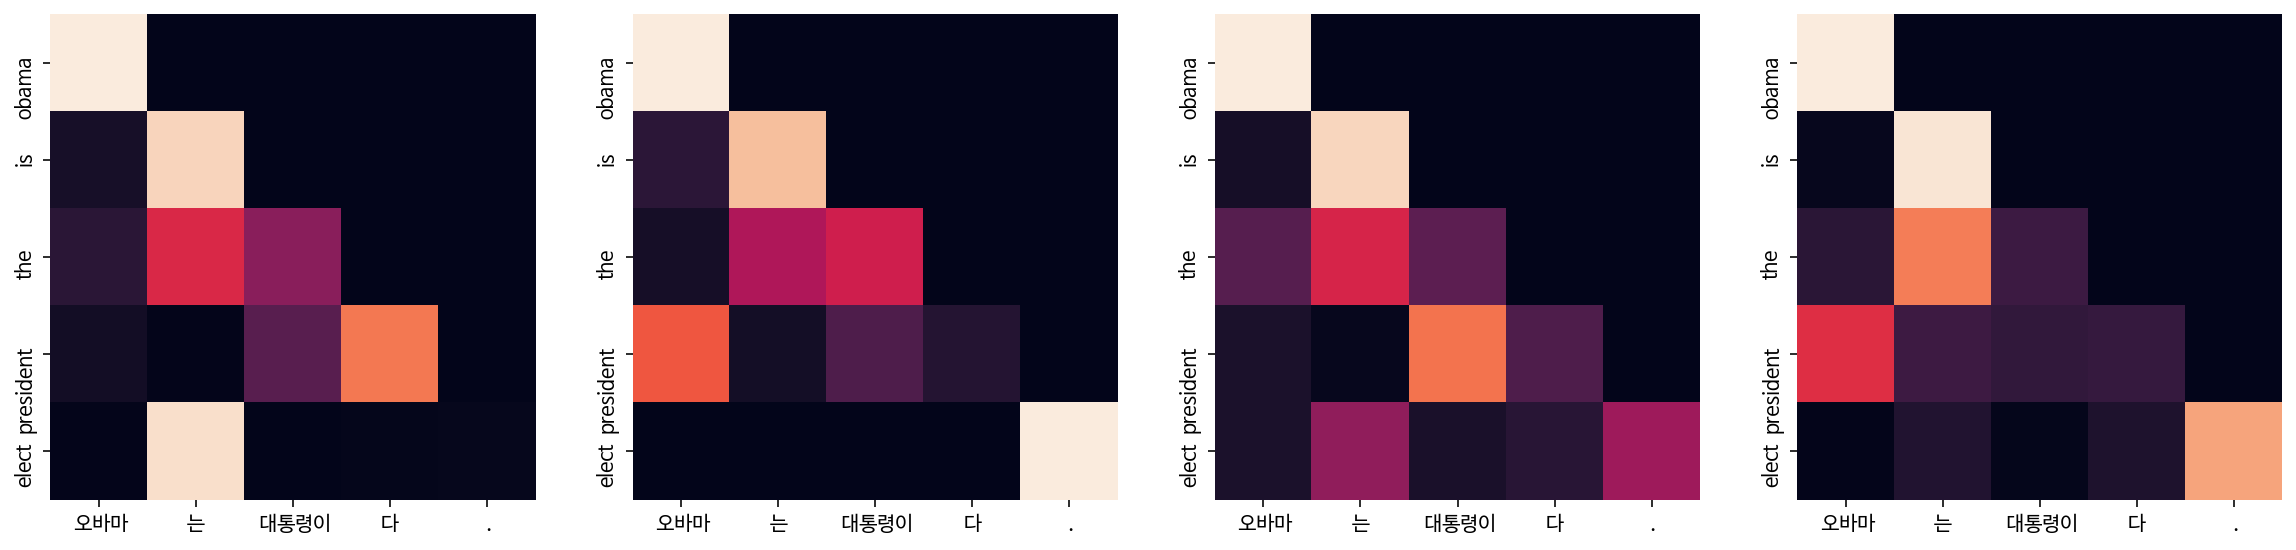



------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : the city is the city of urban city .
------------------------------
Encoder Layer 1


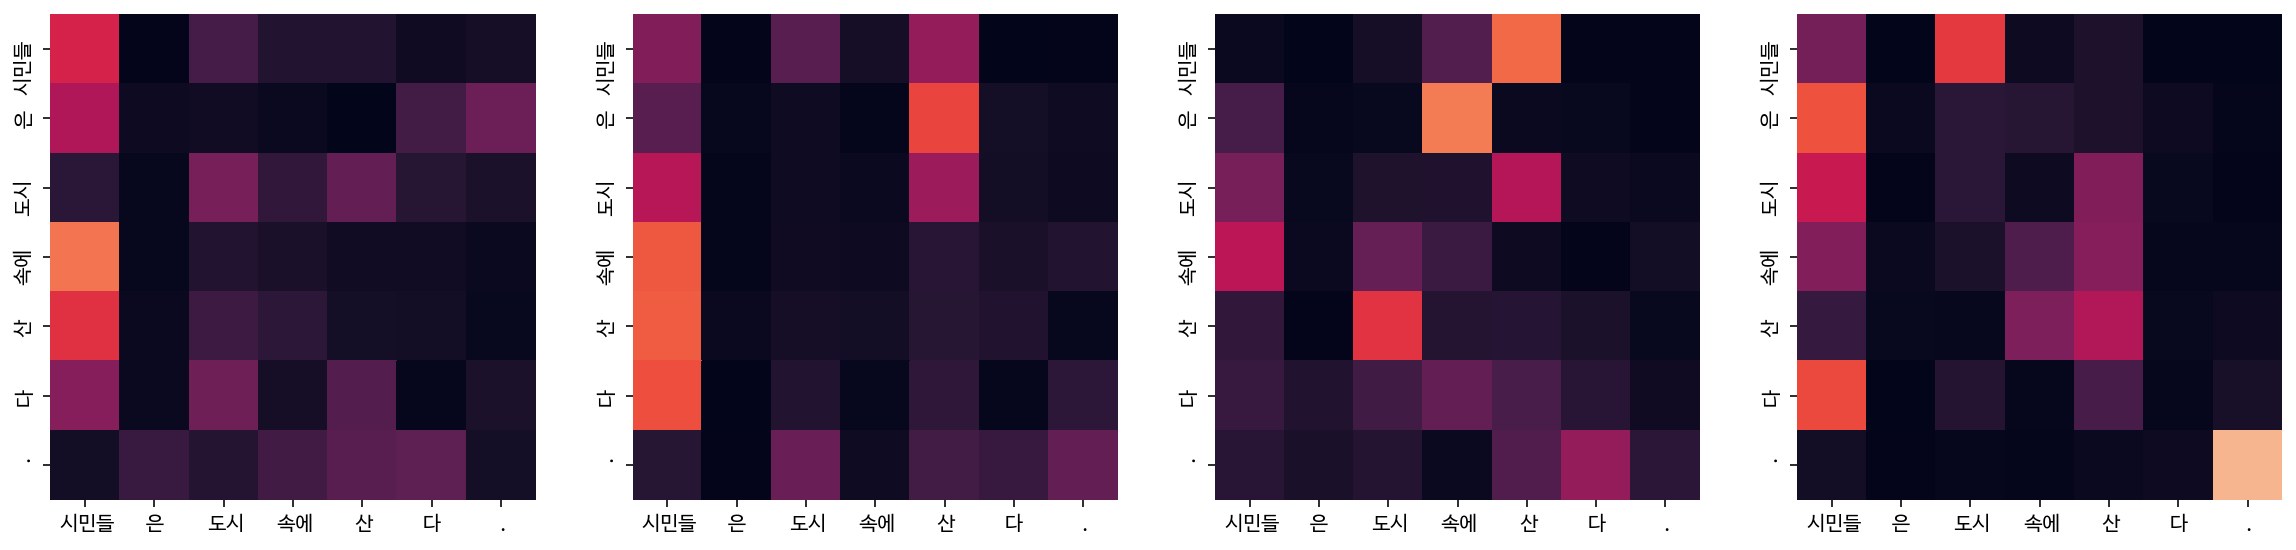

Encoder Layer 2


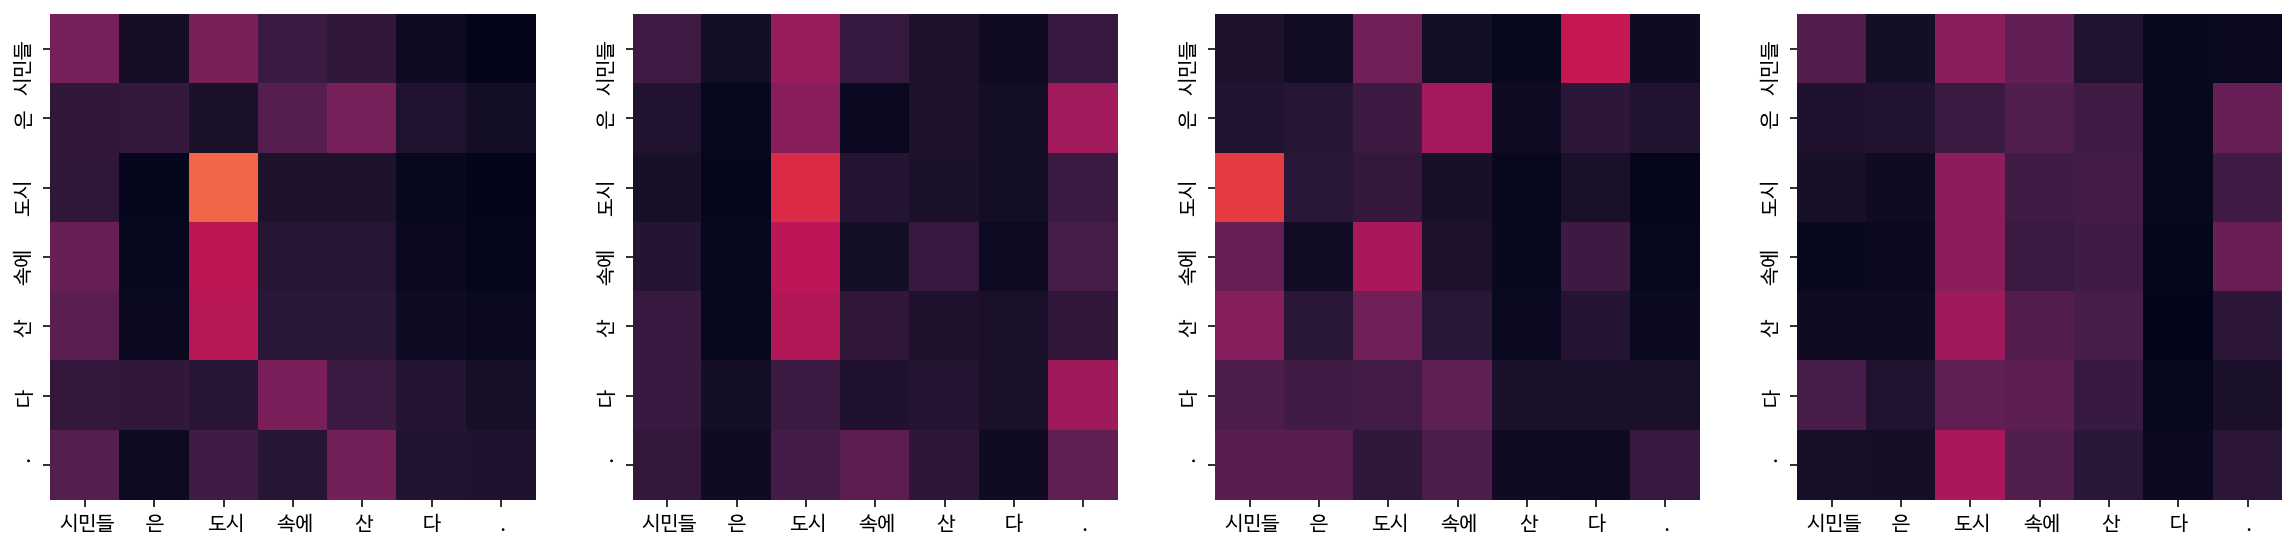

Decoder Self Layer 1


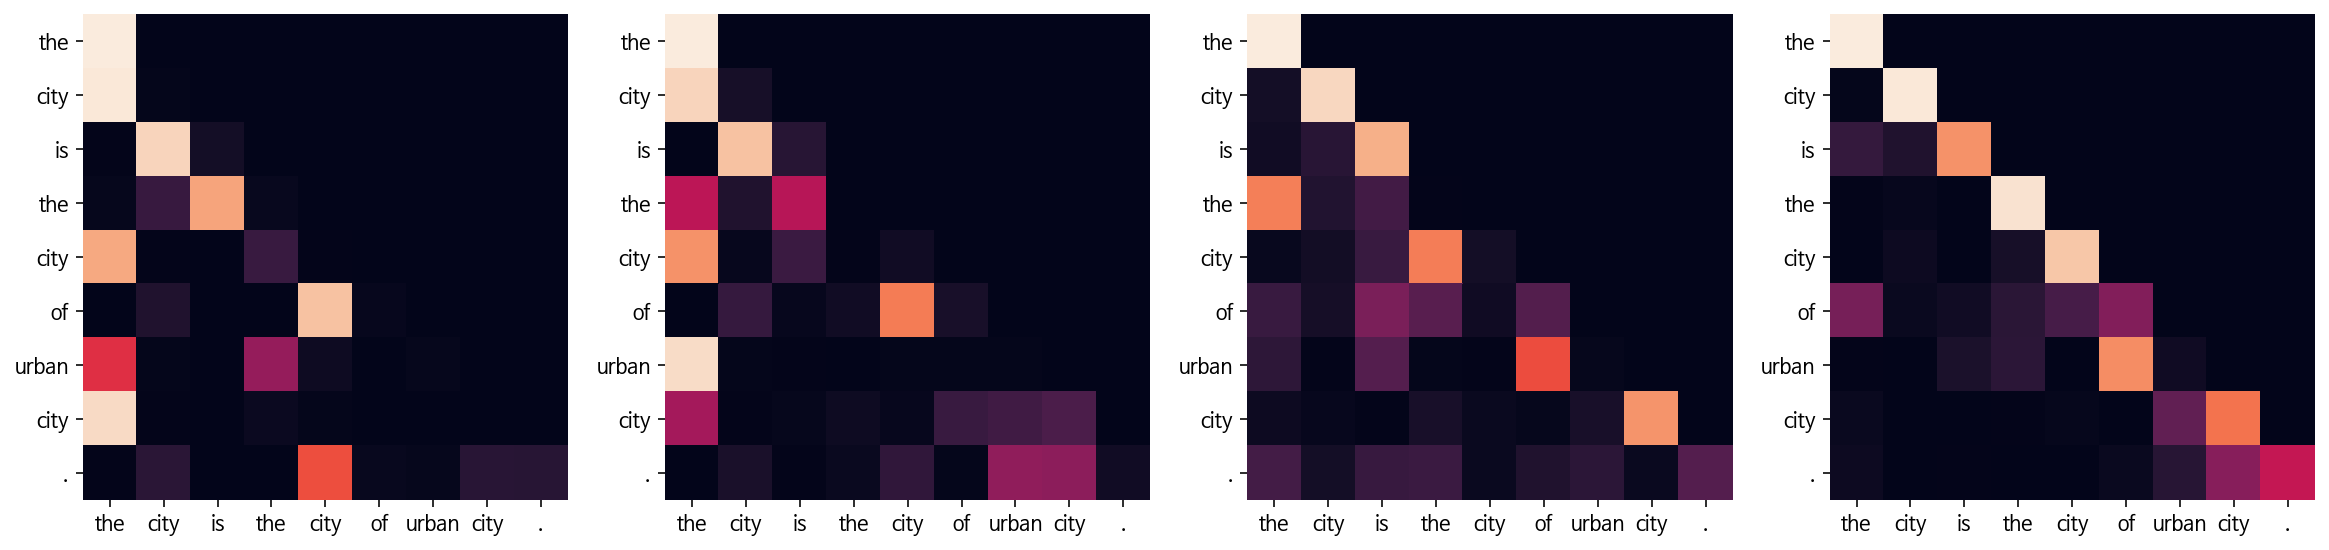

Decoder Src Layer 1


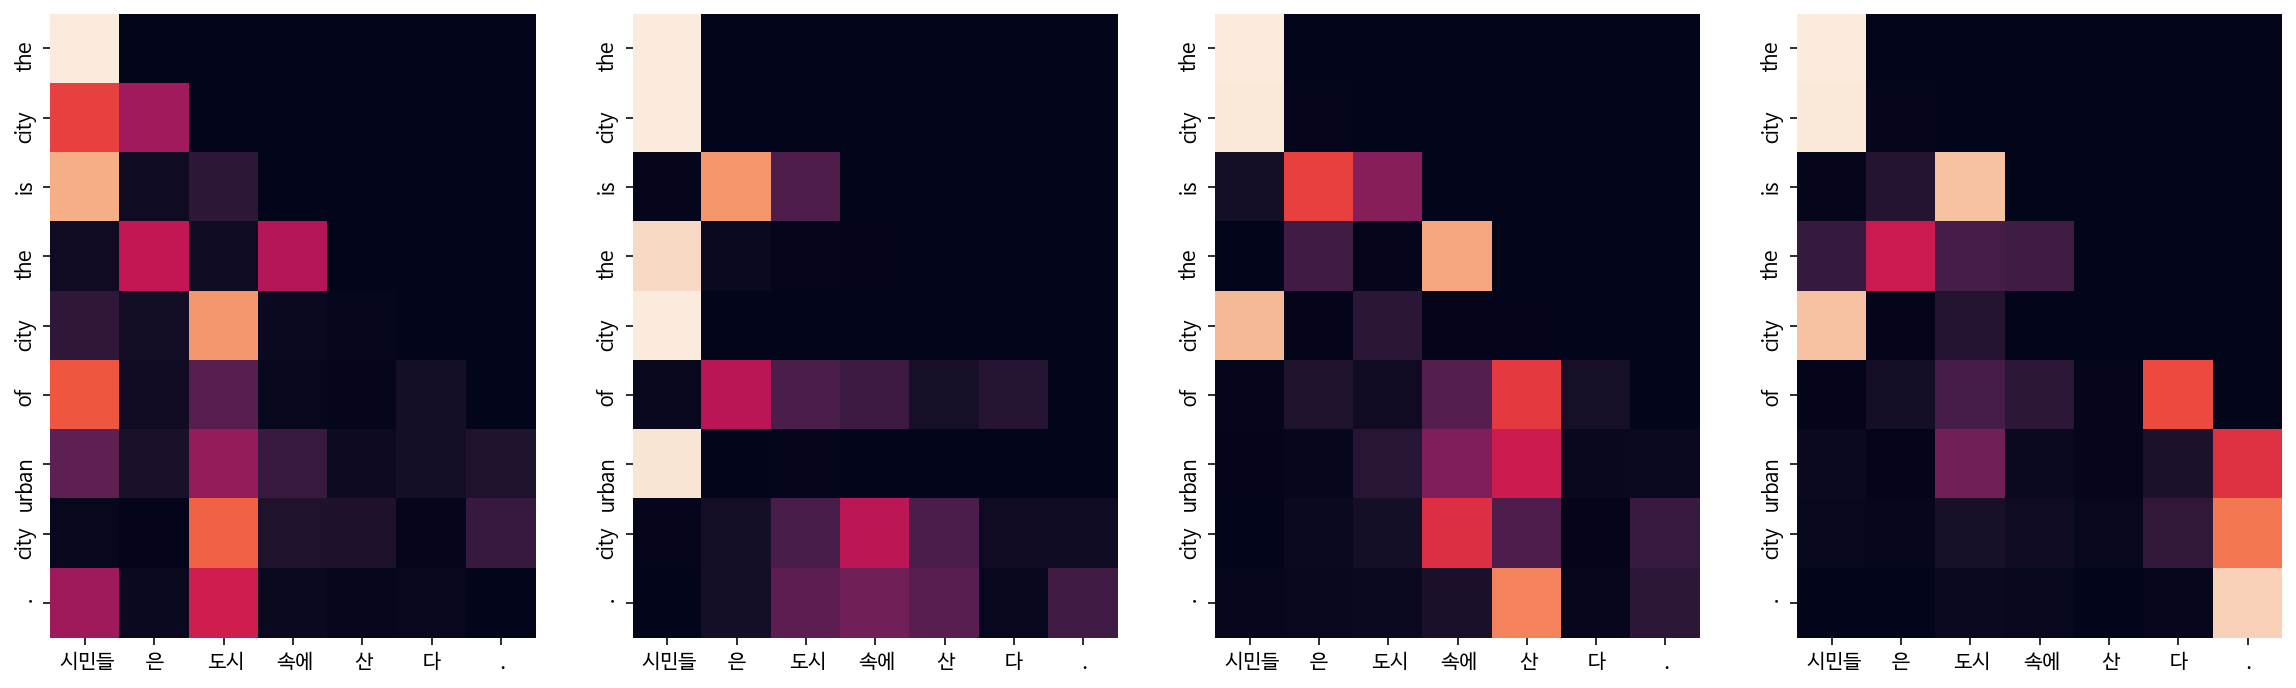

Decoder Self Layer 2


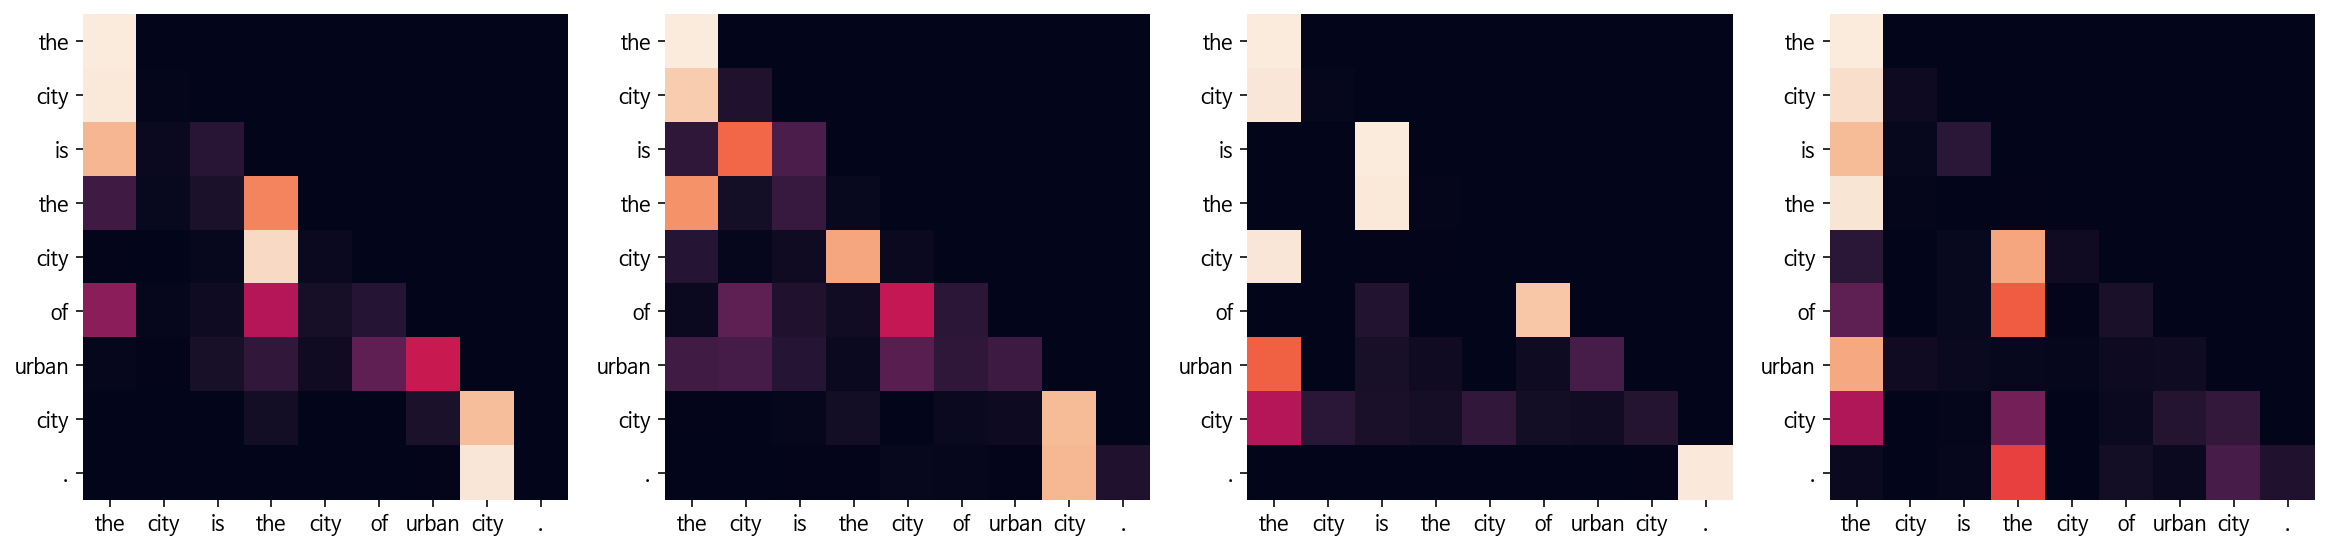

Decoder Src Layer 2


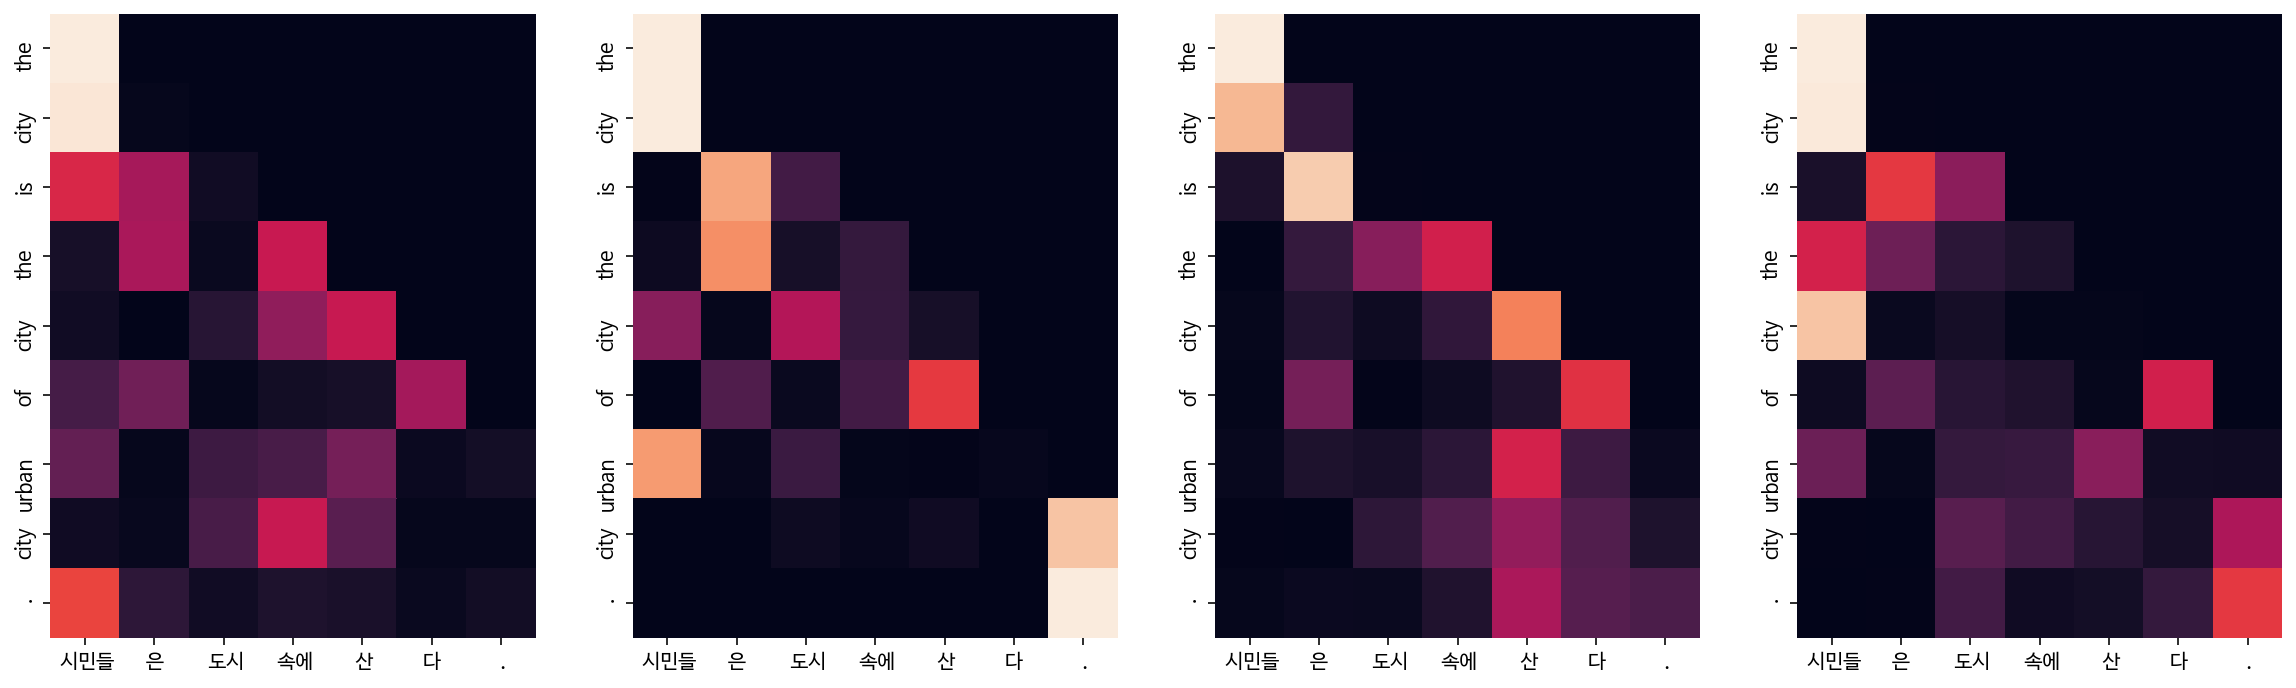



------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : coffee is not too , too , or you re not to do anything .
------------------------------
Encoder Layer 1


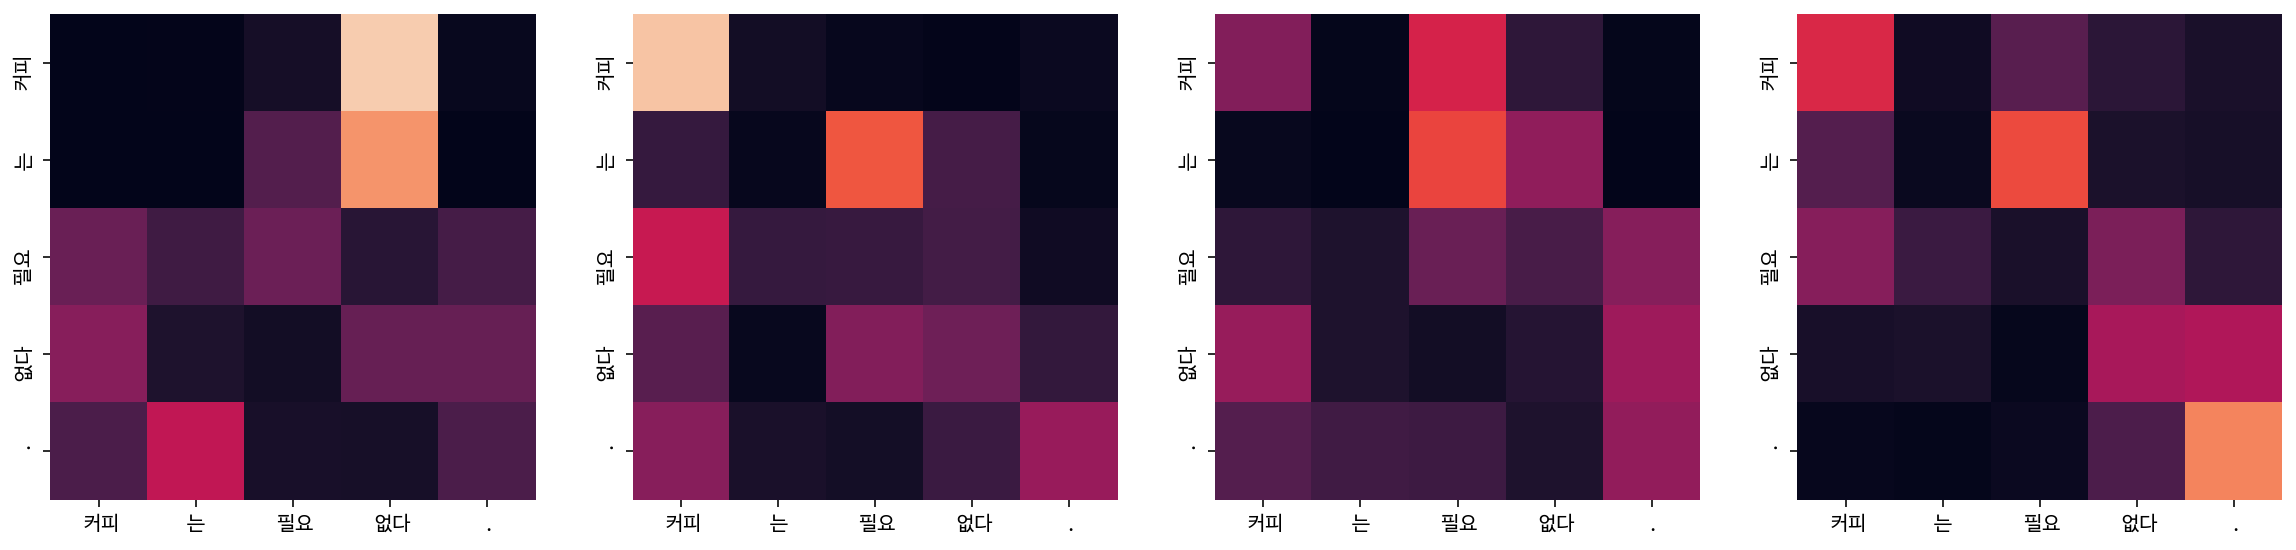

Encoder Layer 2


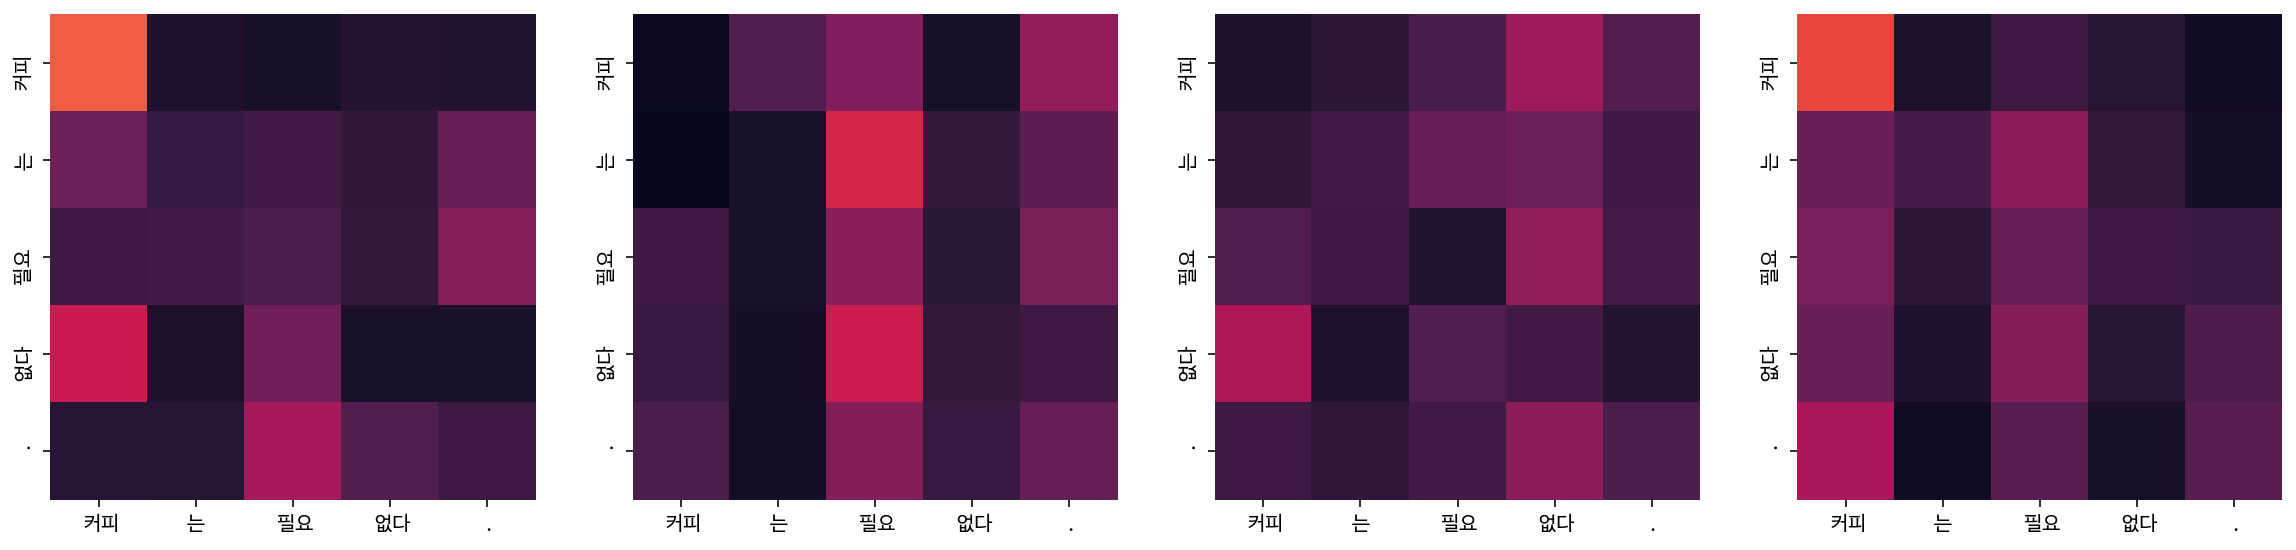

Decoder Self Layer 1


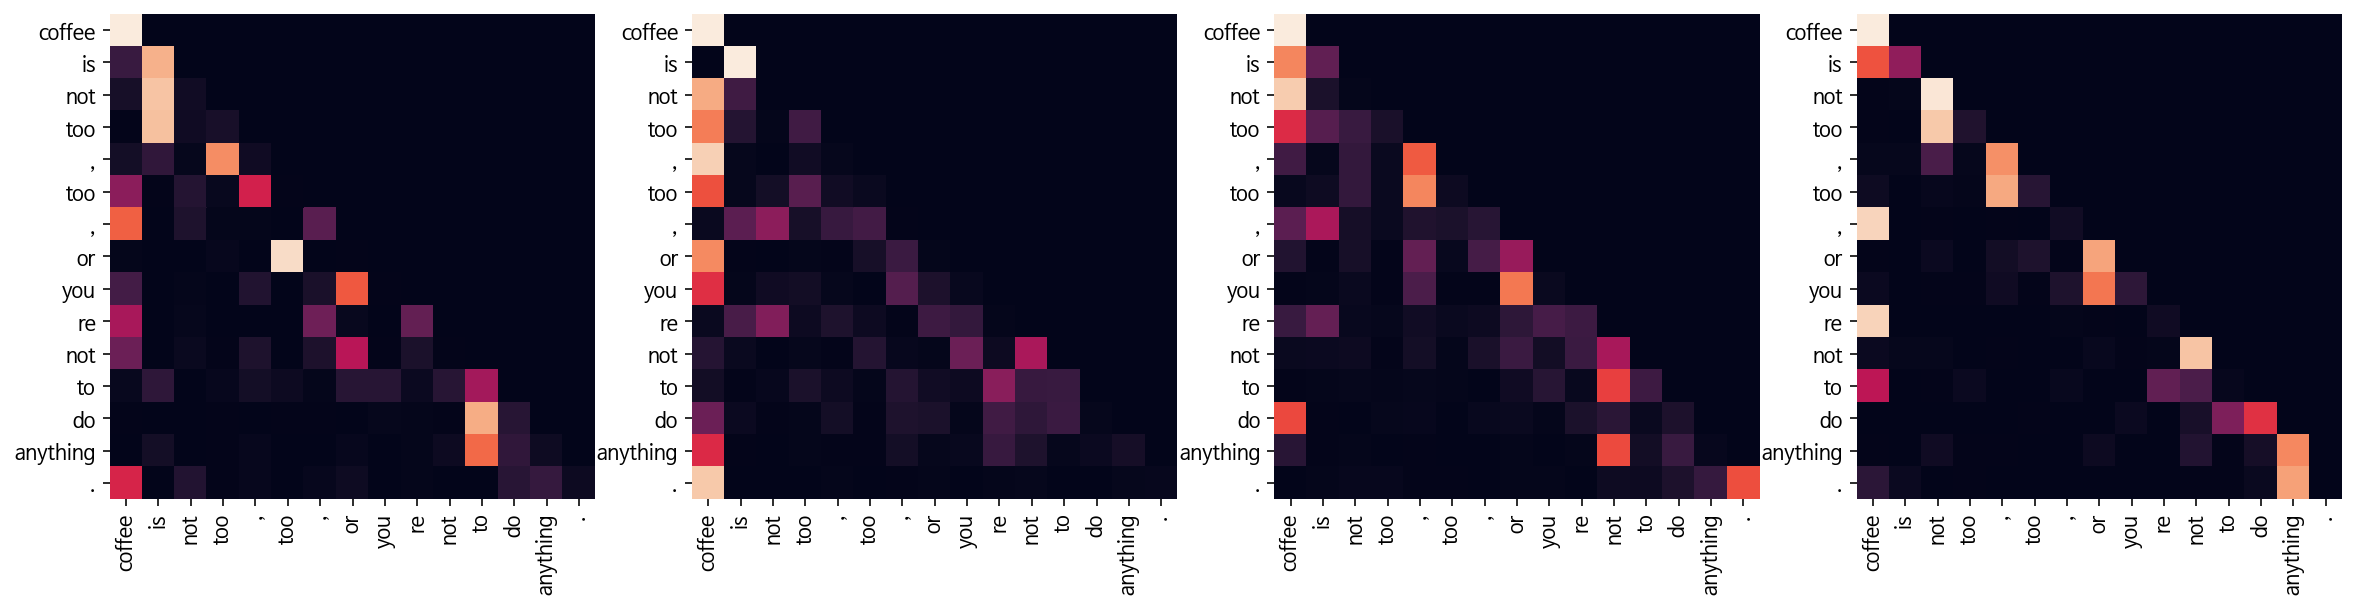

Decoder Src Layer 1


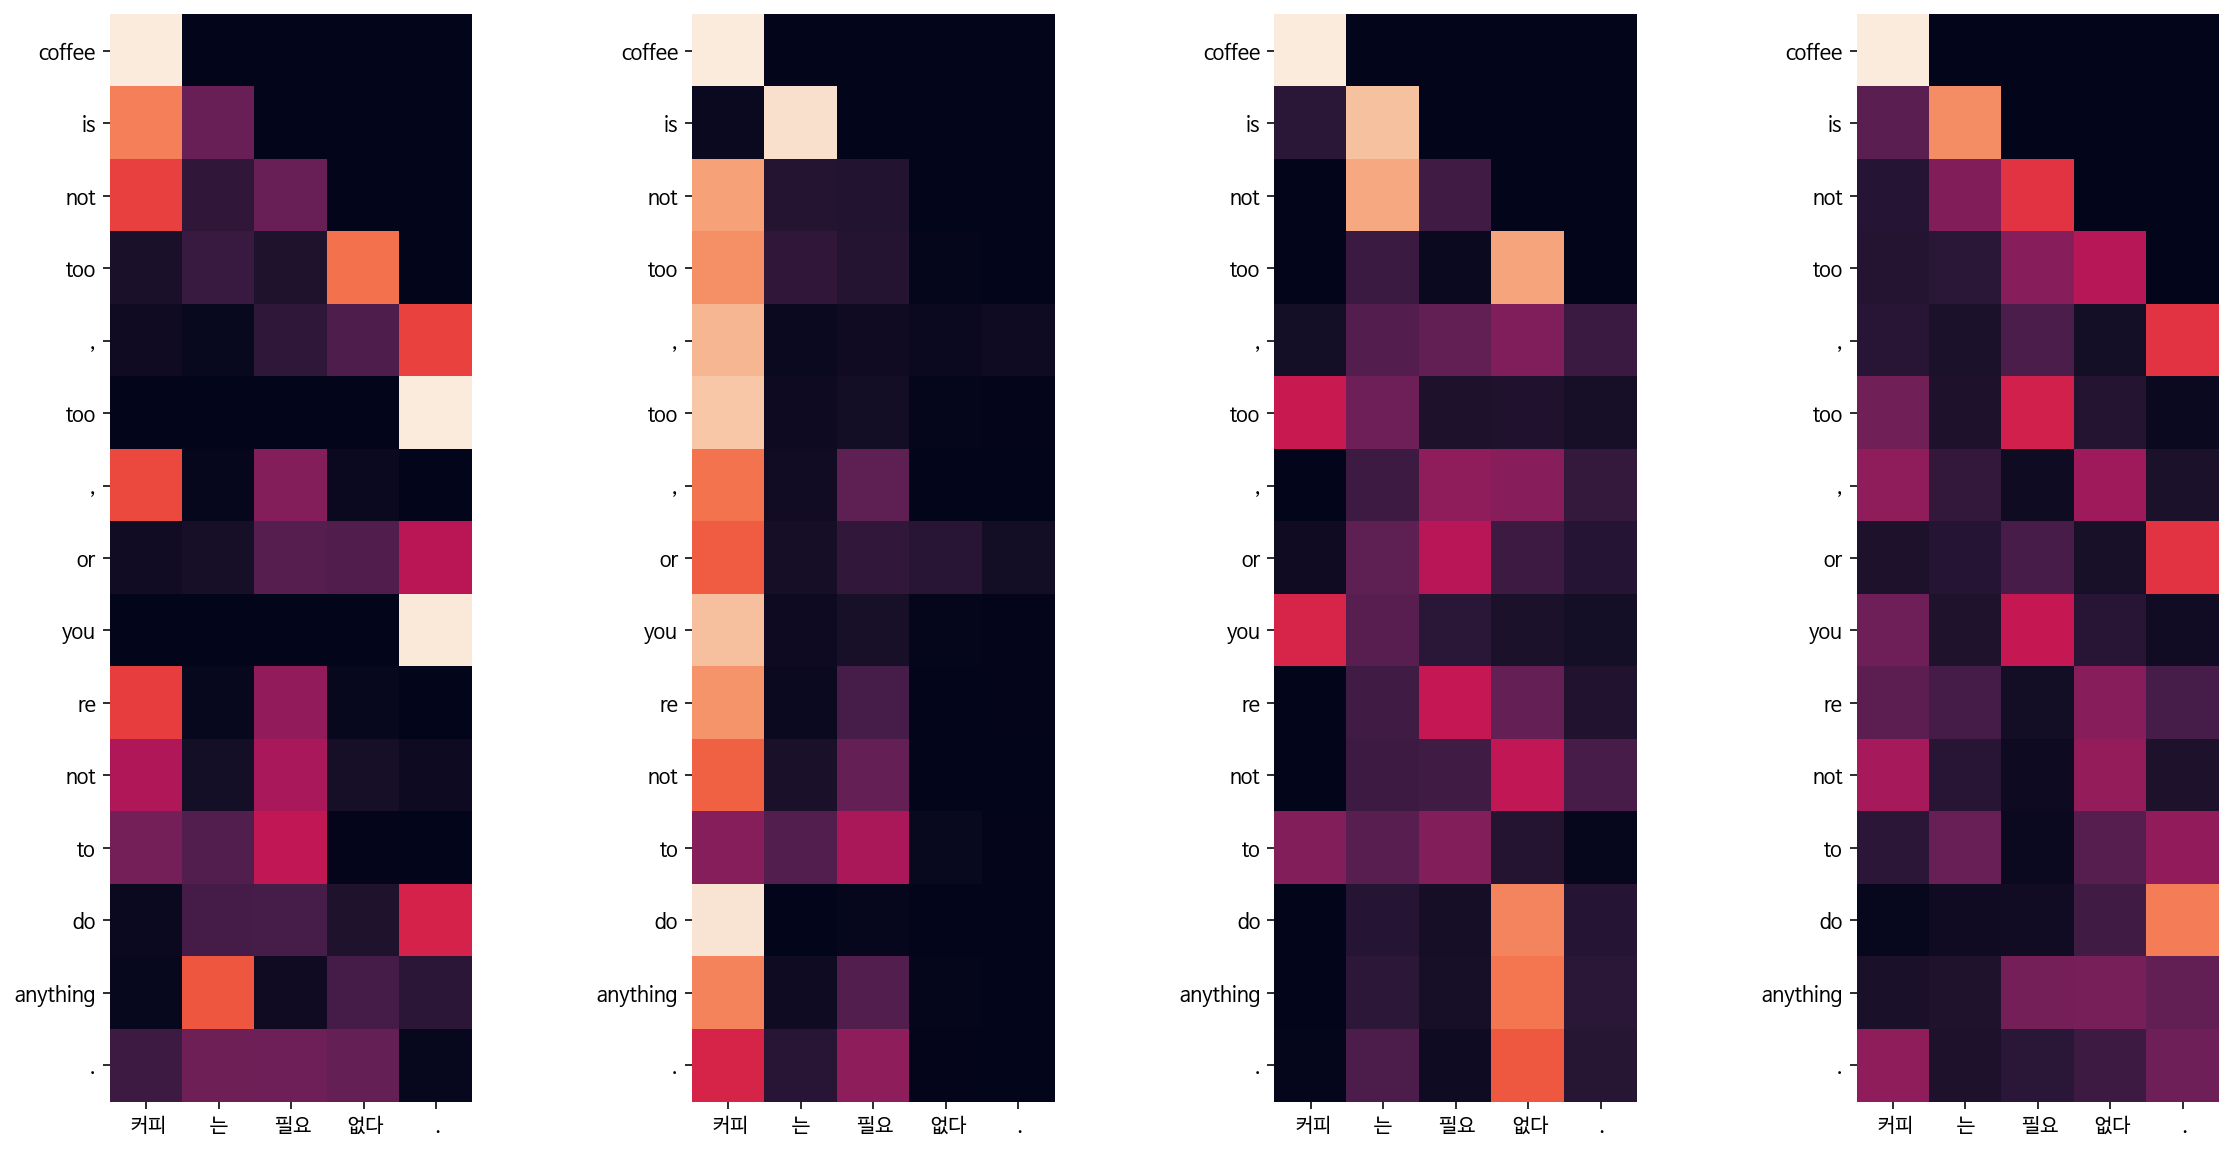

Decoder Self Layer 2


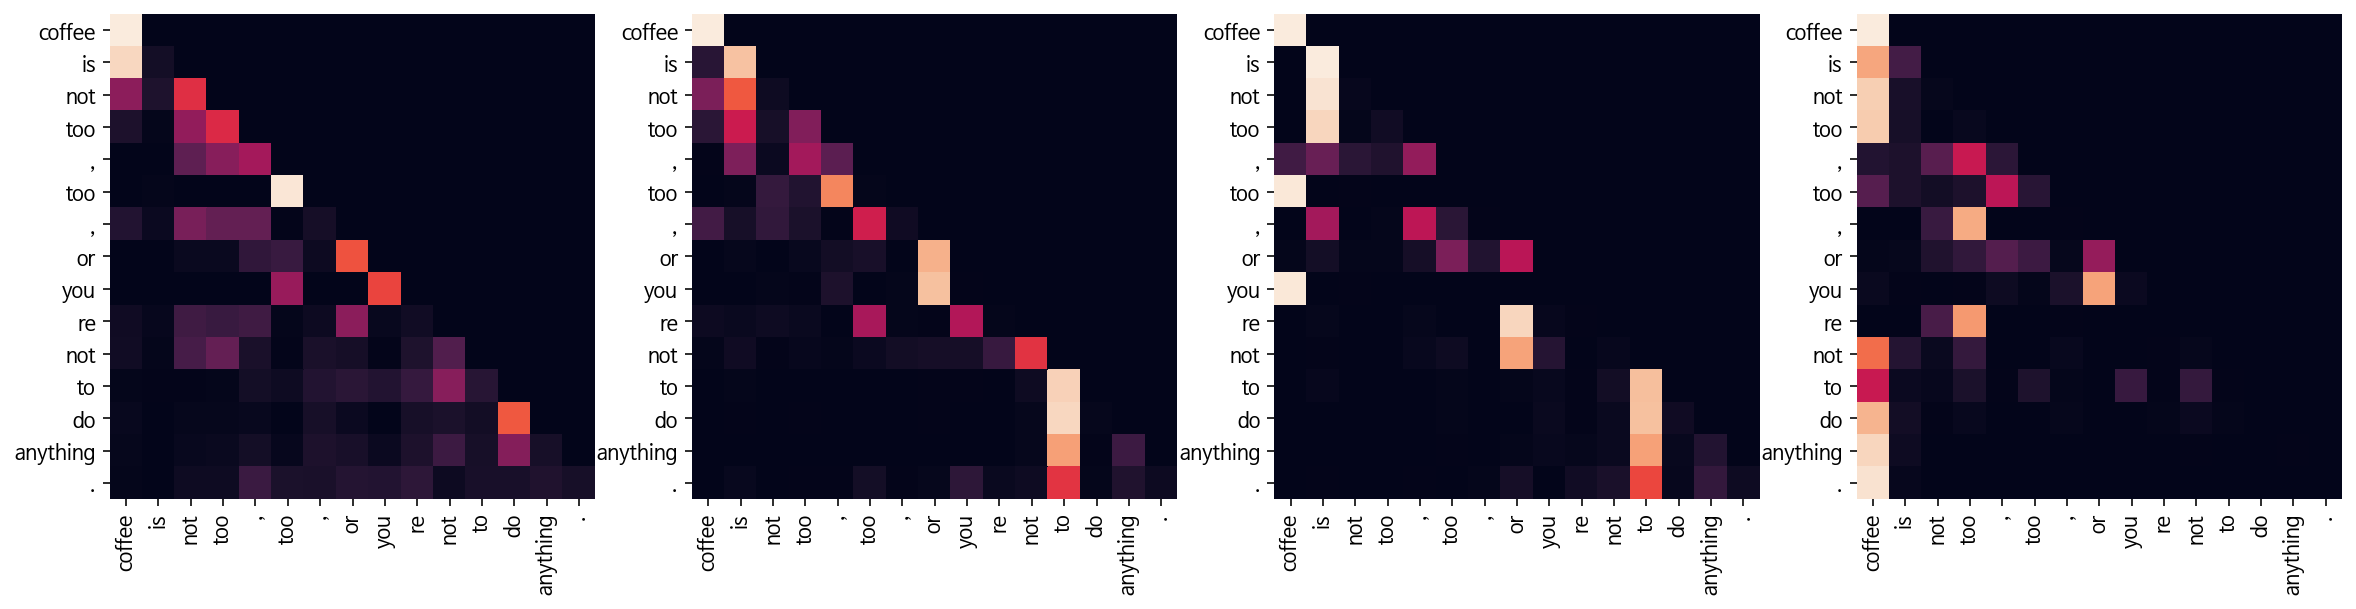

Decoder Src Layer 2


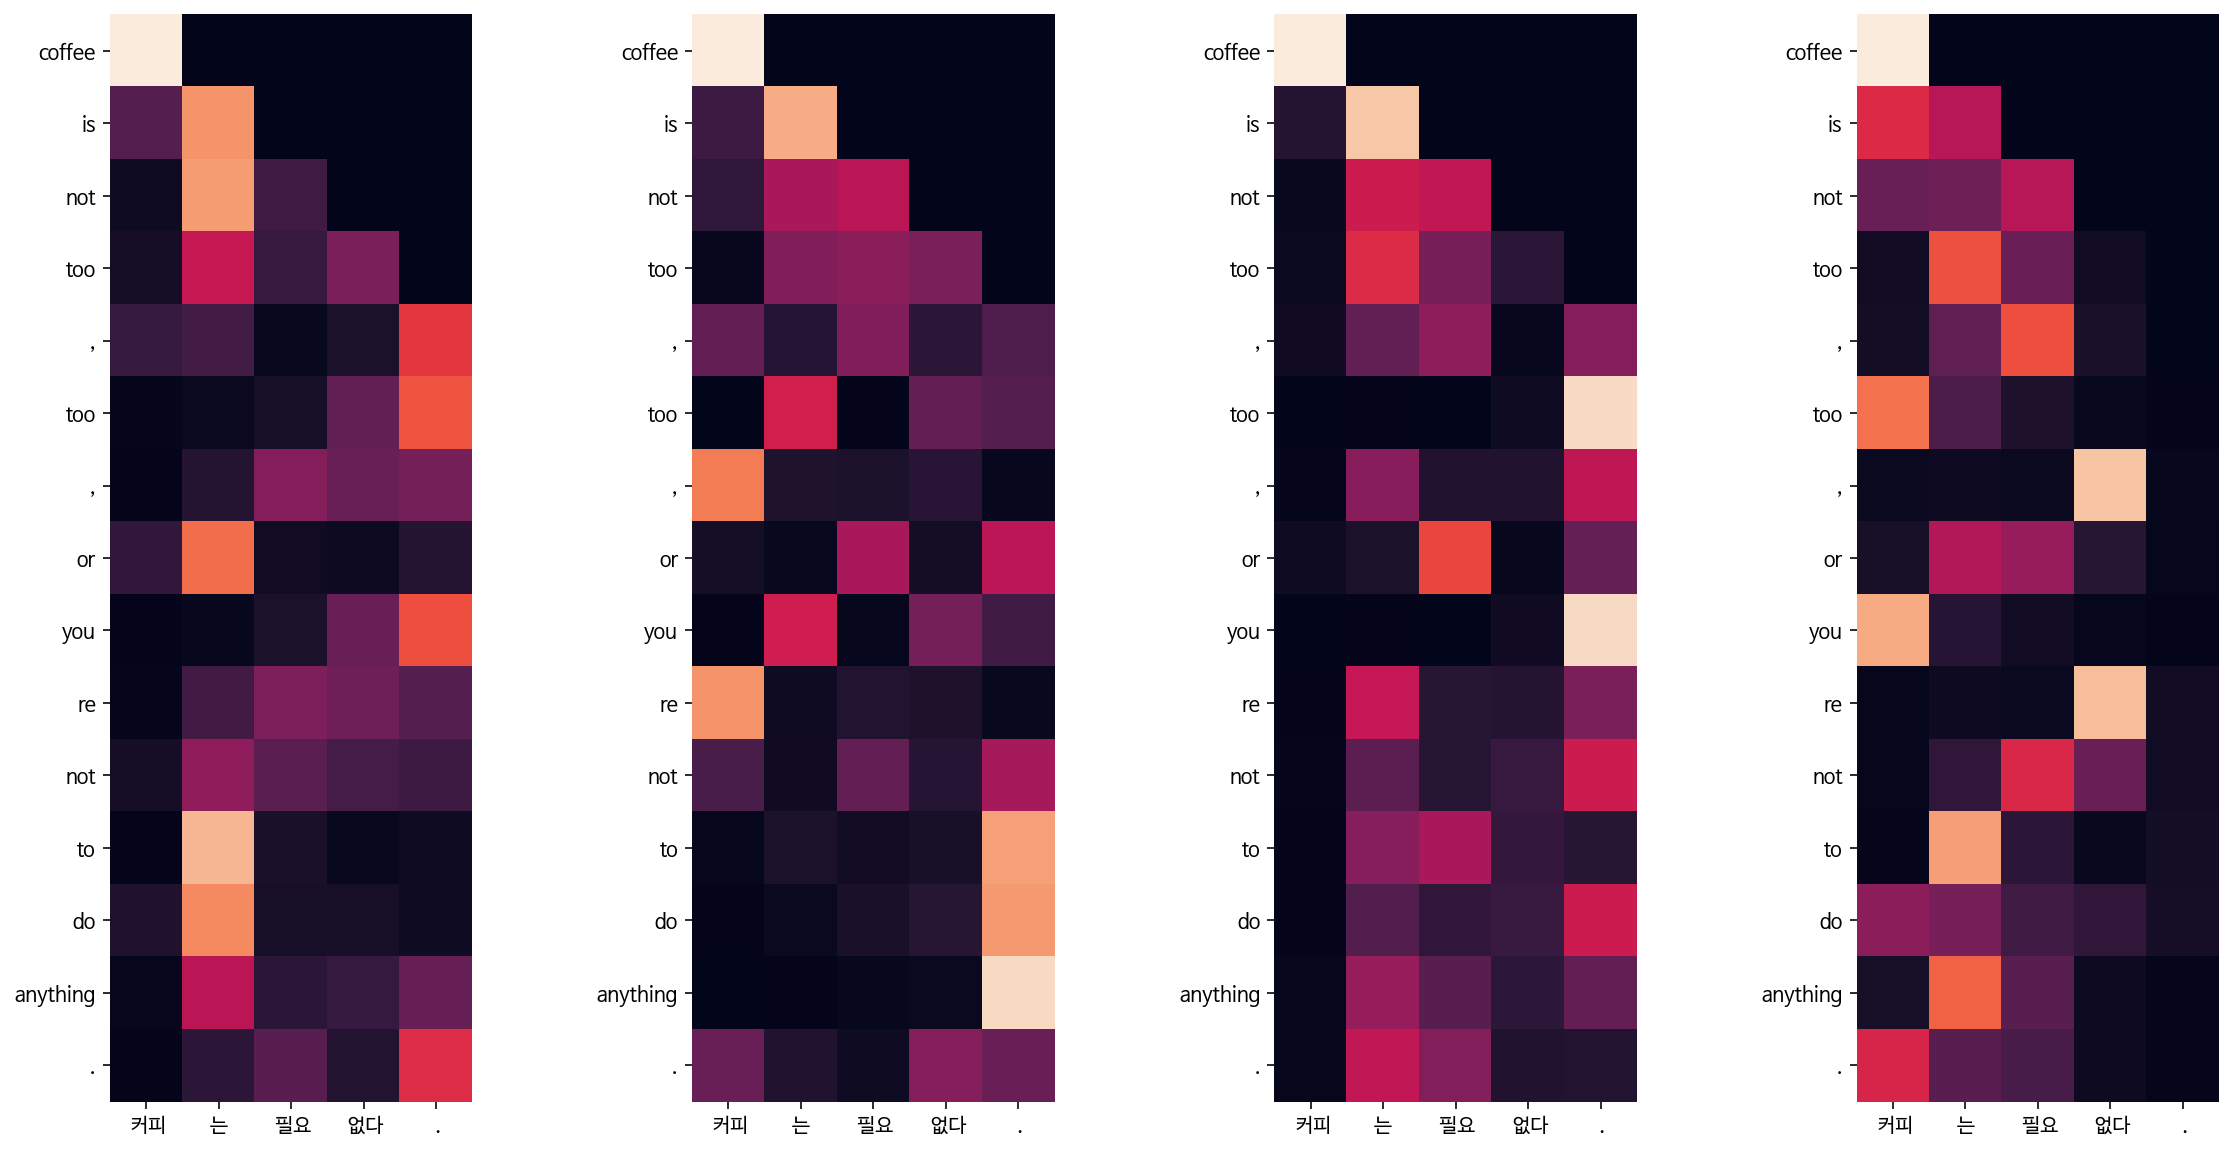



------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : the death toll from the dead .
------------------------------
Encoder Layer 1


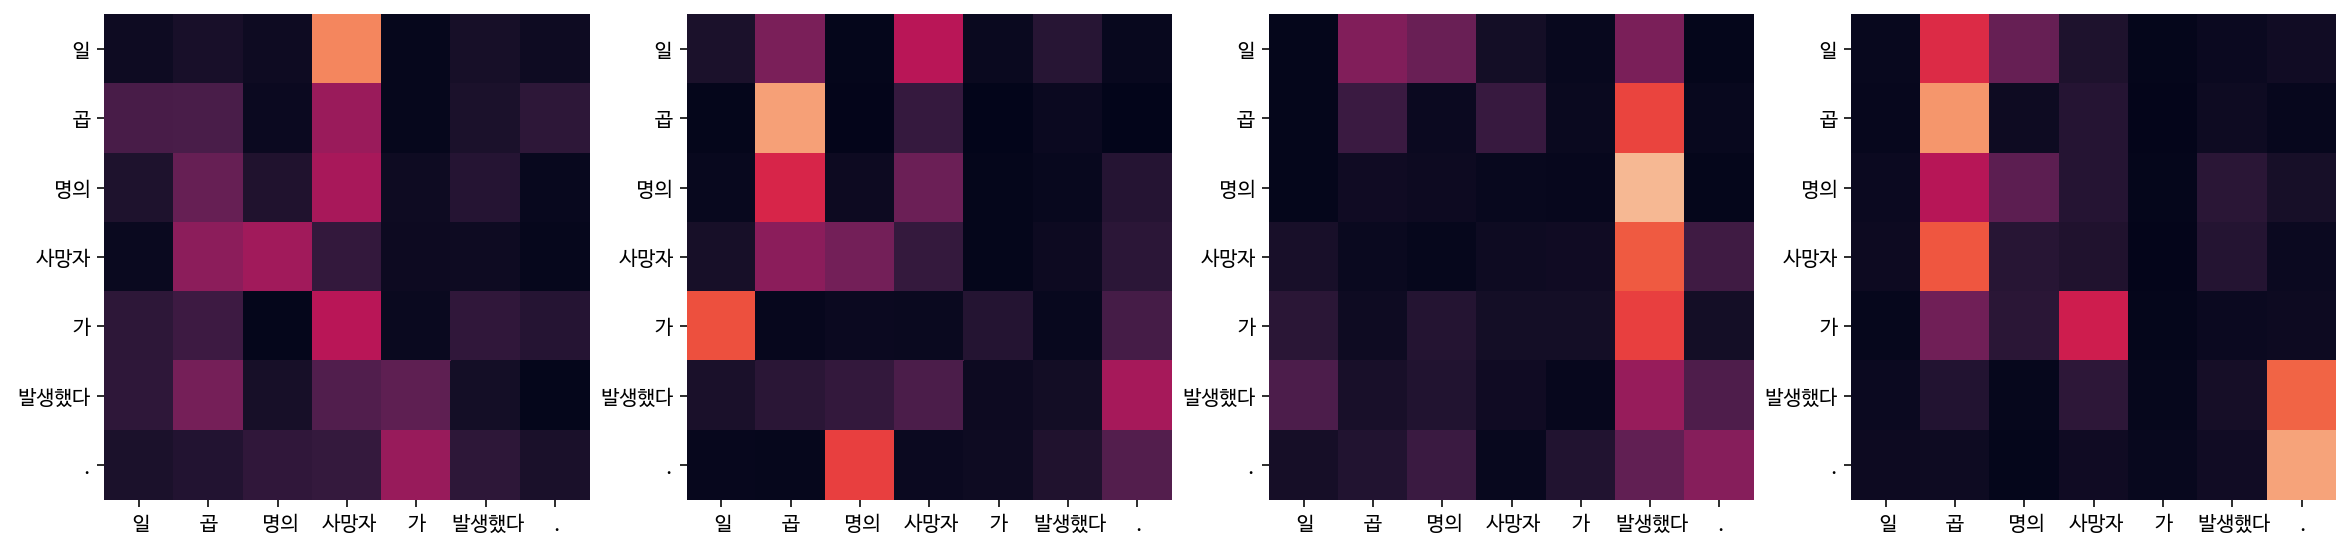

Encoder Layer 2


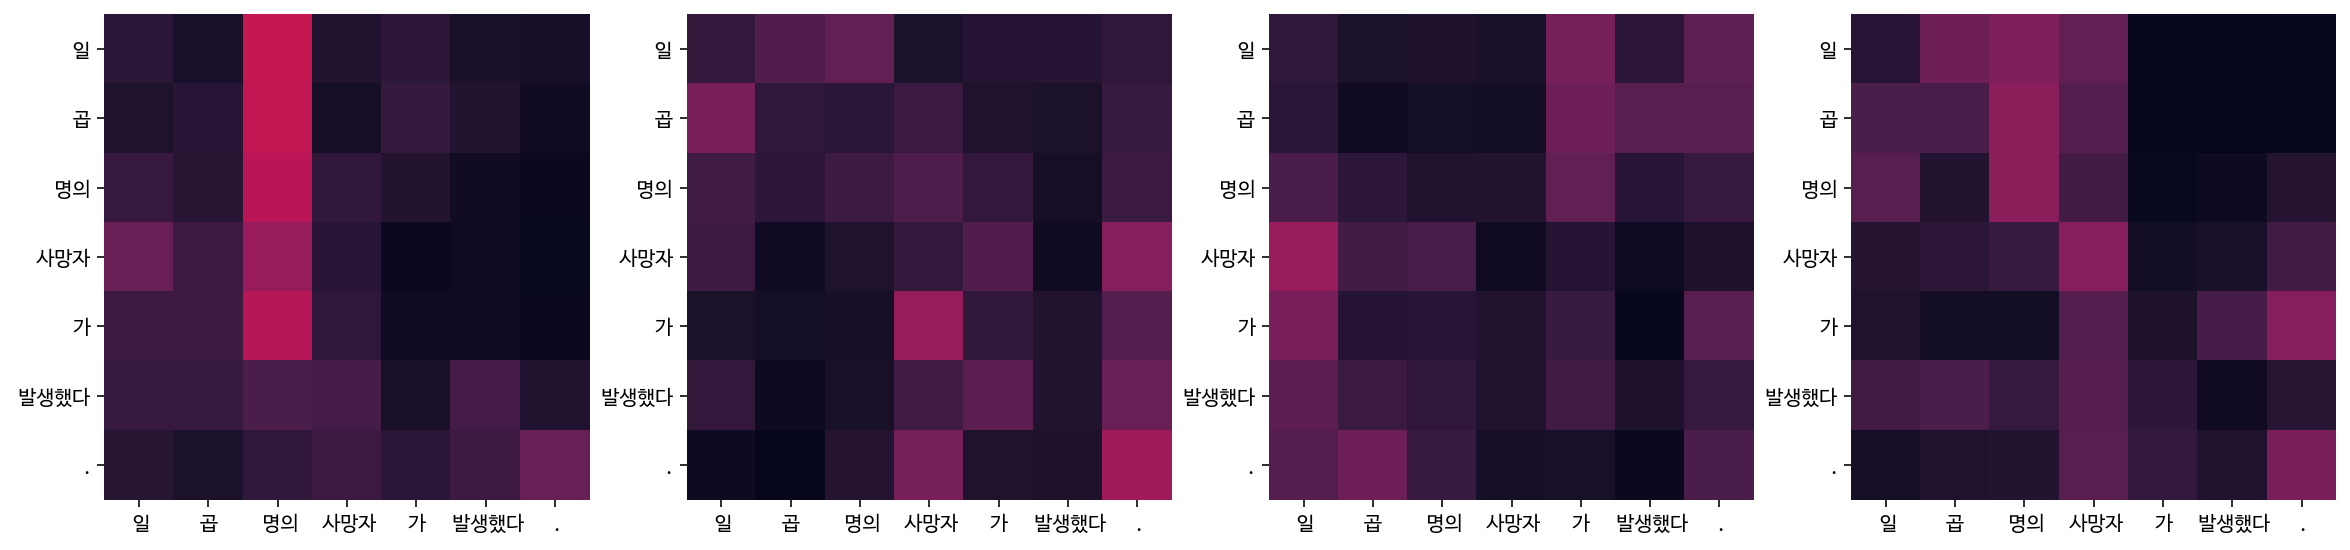

Decoder Self Layer 1


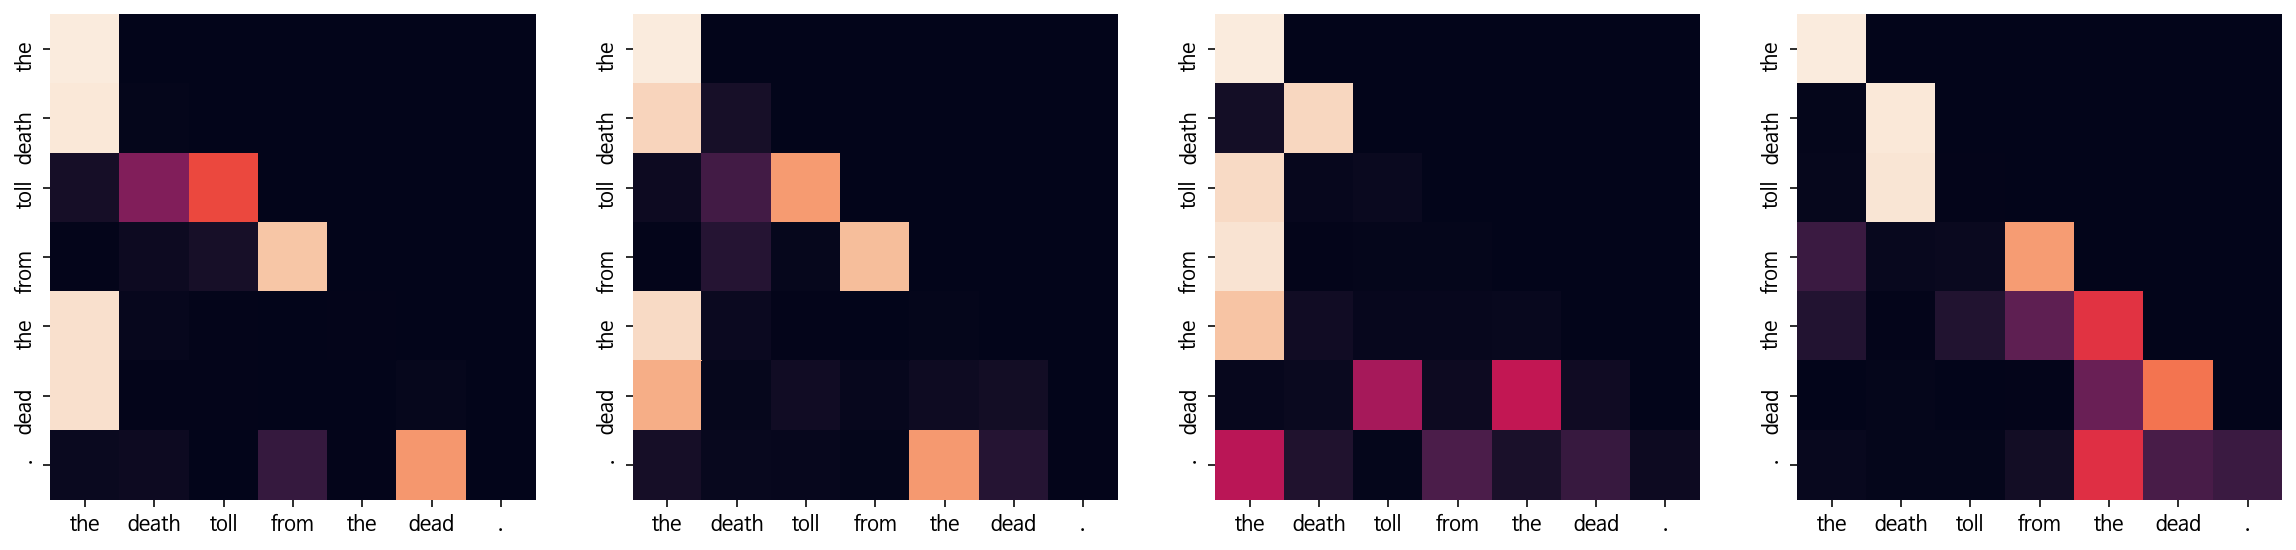

Decoder Src Layer 1


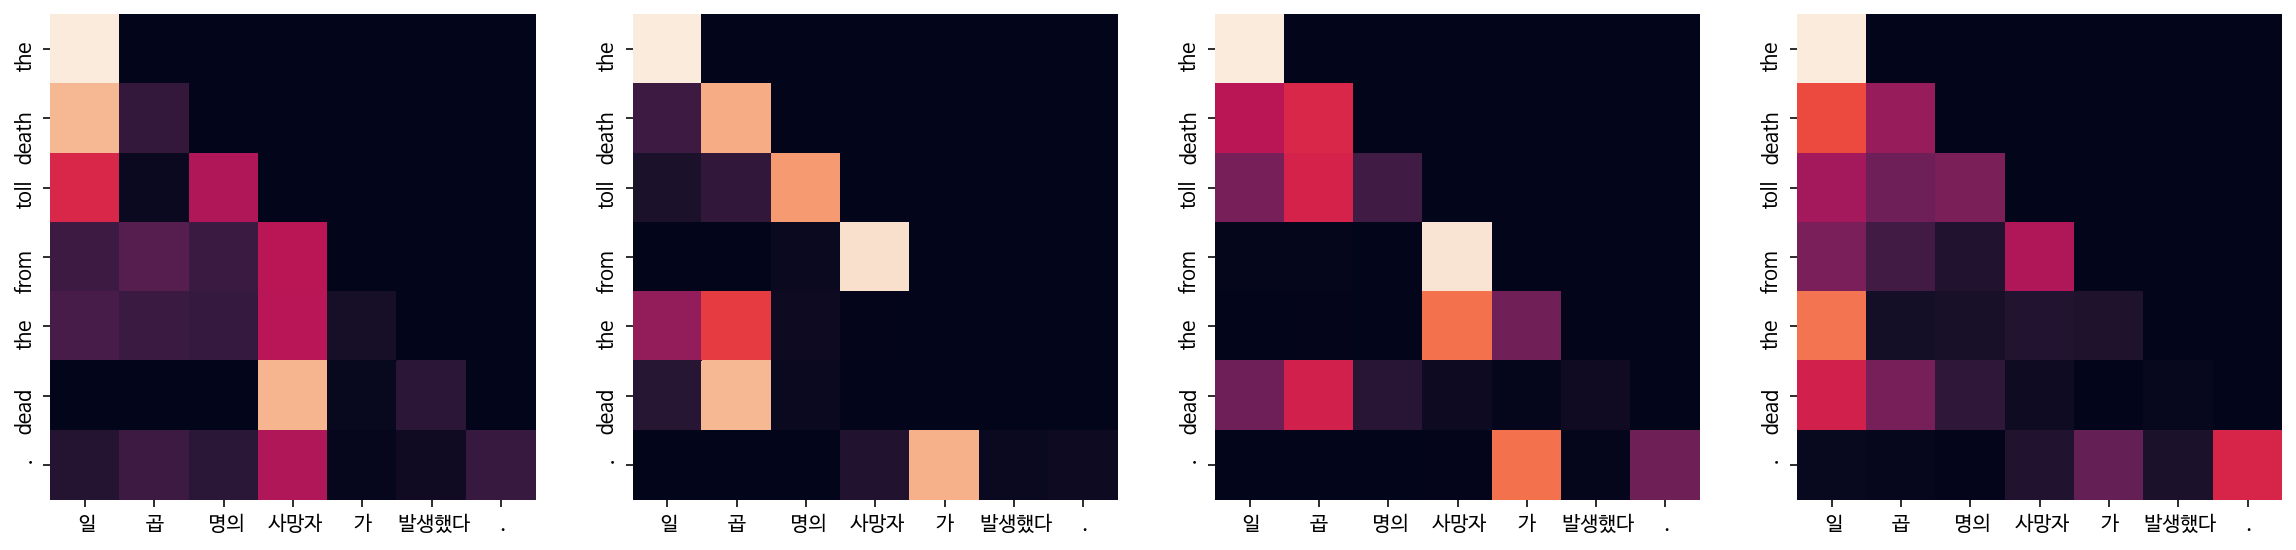

Decoder Self Layer 2


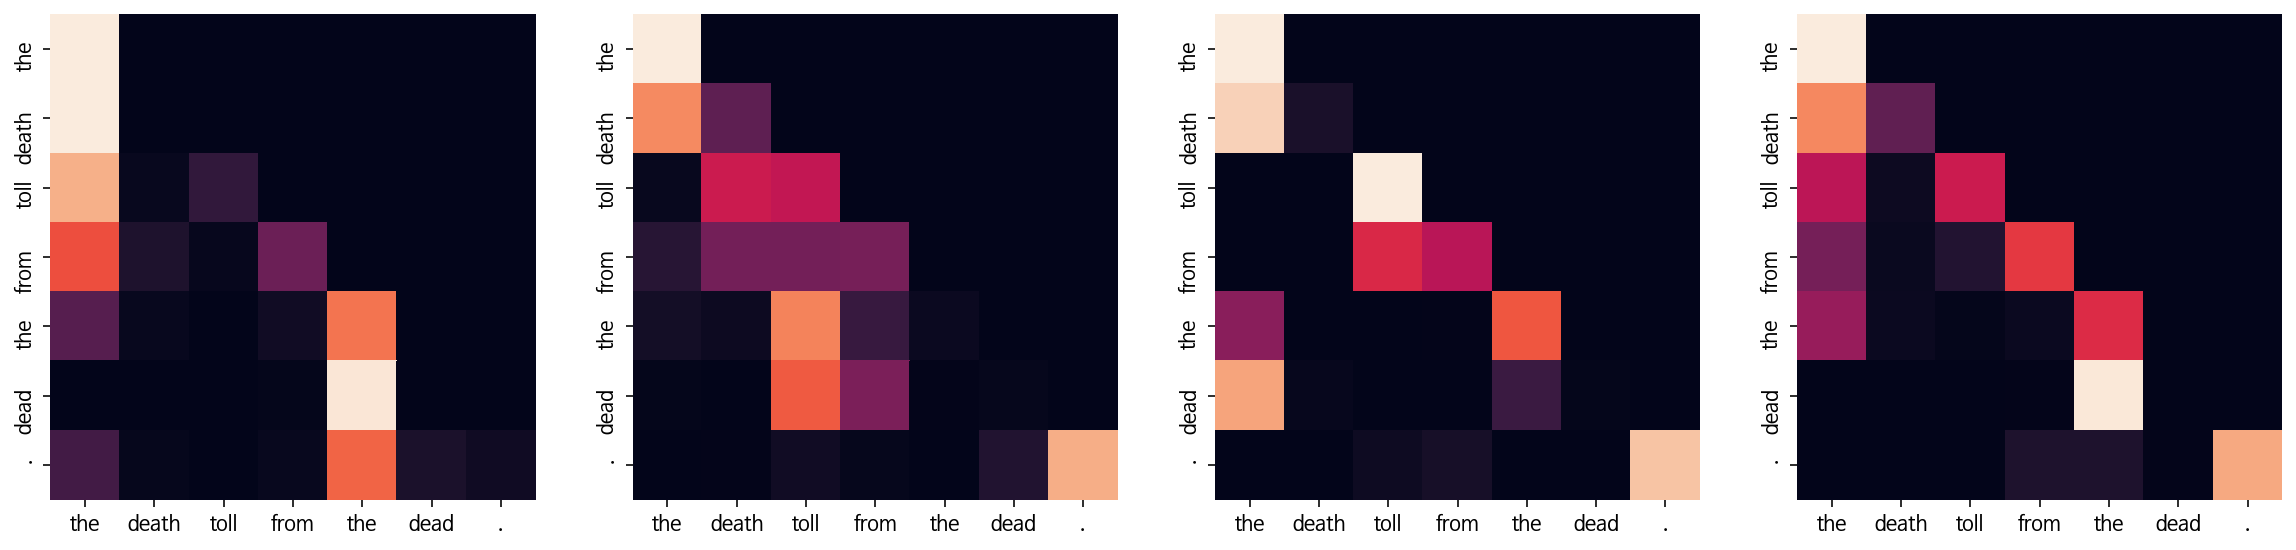

Decoder Src Layer 2


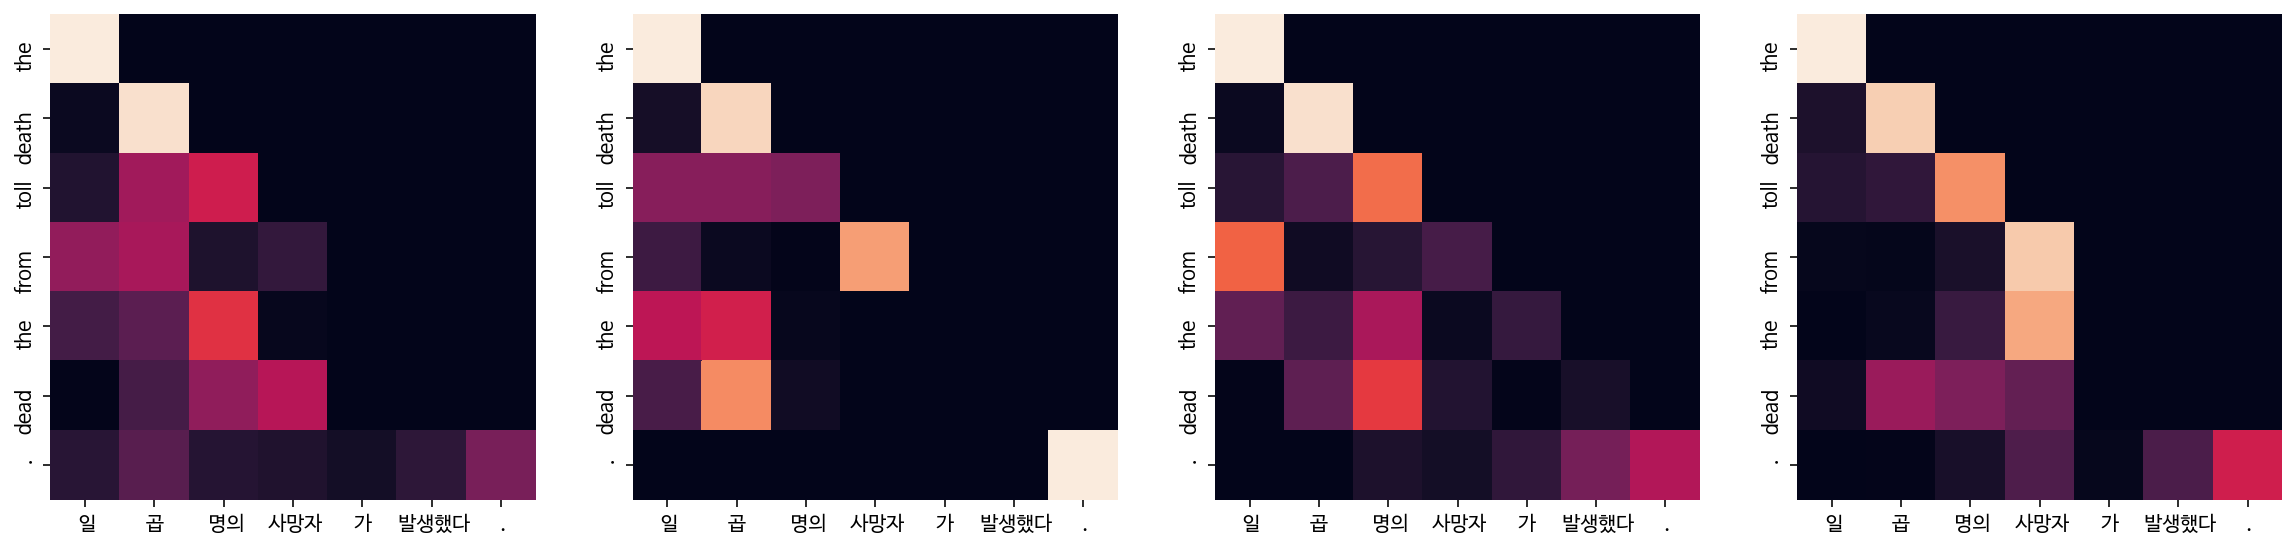

  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  6 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama s president is a president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they re a city of urban city .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : coffee is no . . . . . . .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven people were dead , the death toll from the death toll .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  7 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama s president elect barack obama .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : the city is a city .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : coffee is no . . . . . . . . . . . . . . . . . . . . . . . . . . . . no . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven people dead dead were dead .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  8 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is the president elect .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they live in the town .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : he needed no . . . . . . . .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven people were dead and dead .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  9 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is the president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they are the home of the home .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s not a cup .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the death toll .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  10 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is the president .
------------------------------
Encoder Layer 1


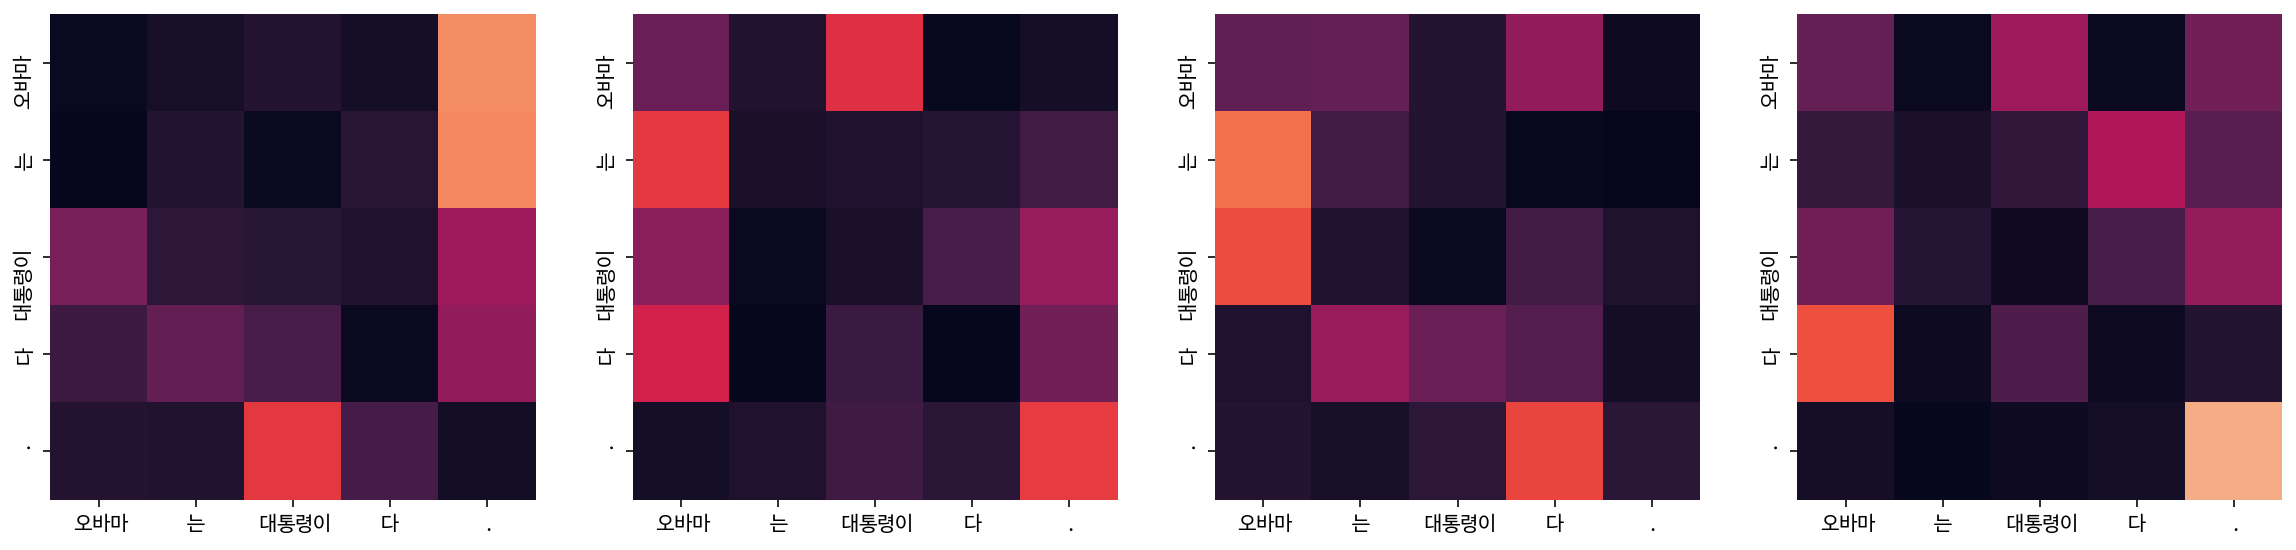

Encoder Layer 2


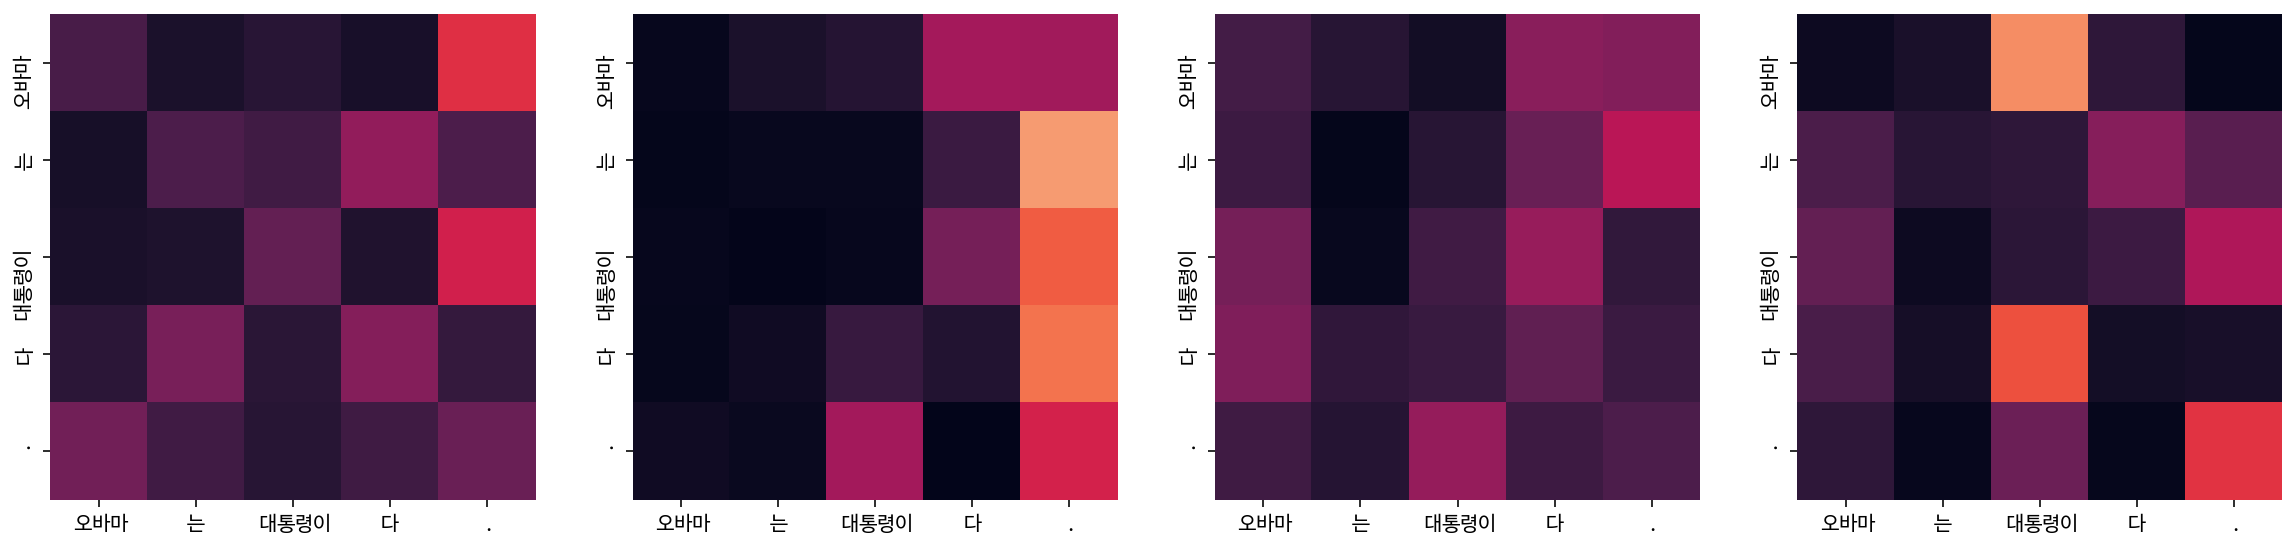

Decoder Self Layer 1


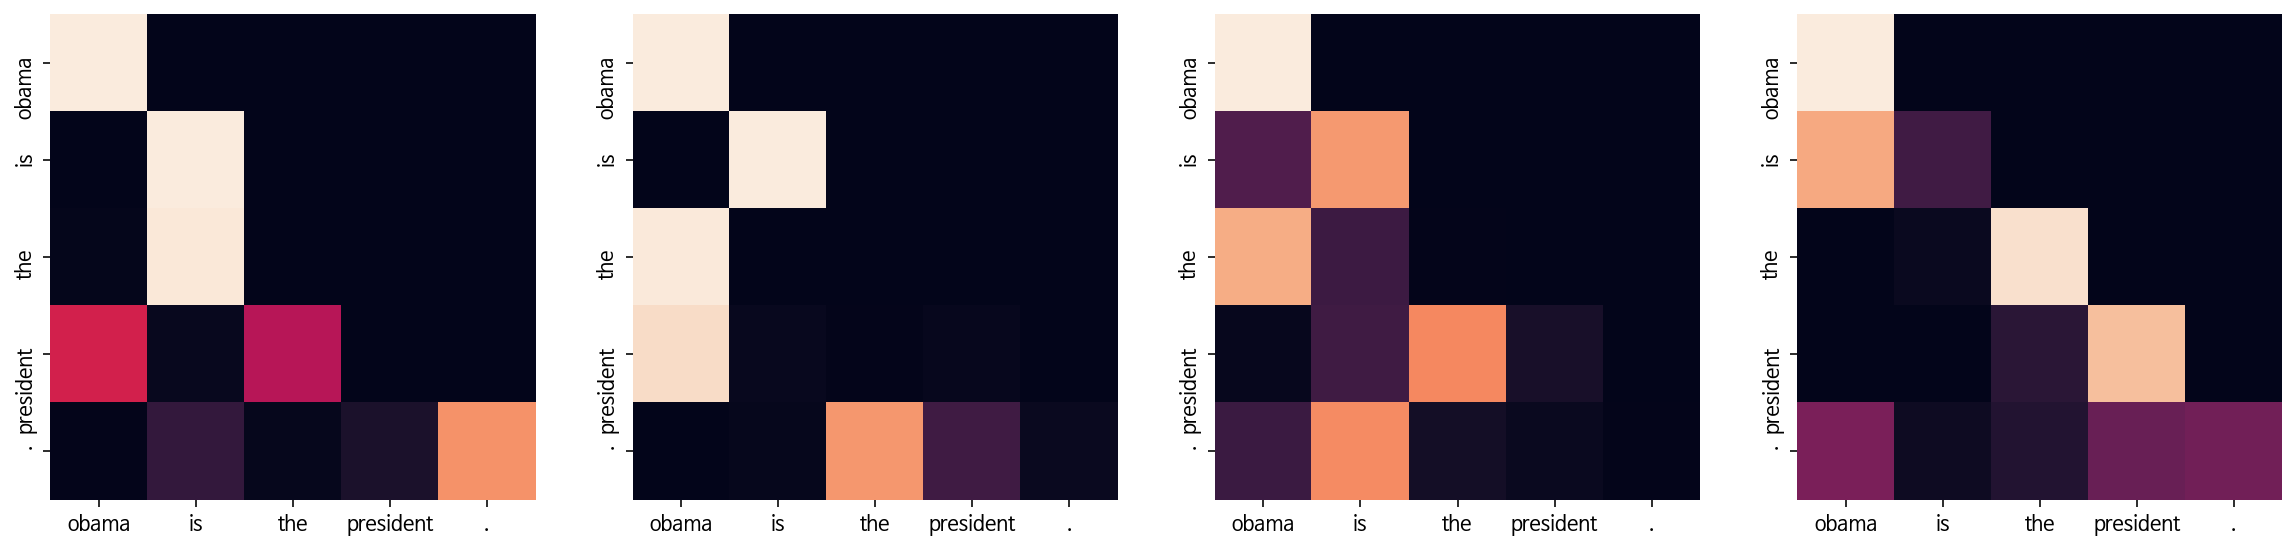

Decoder Src Layer 1


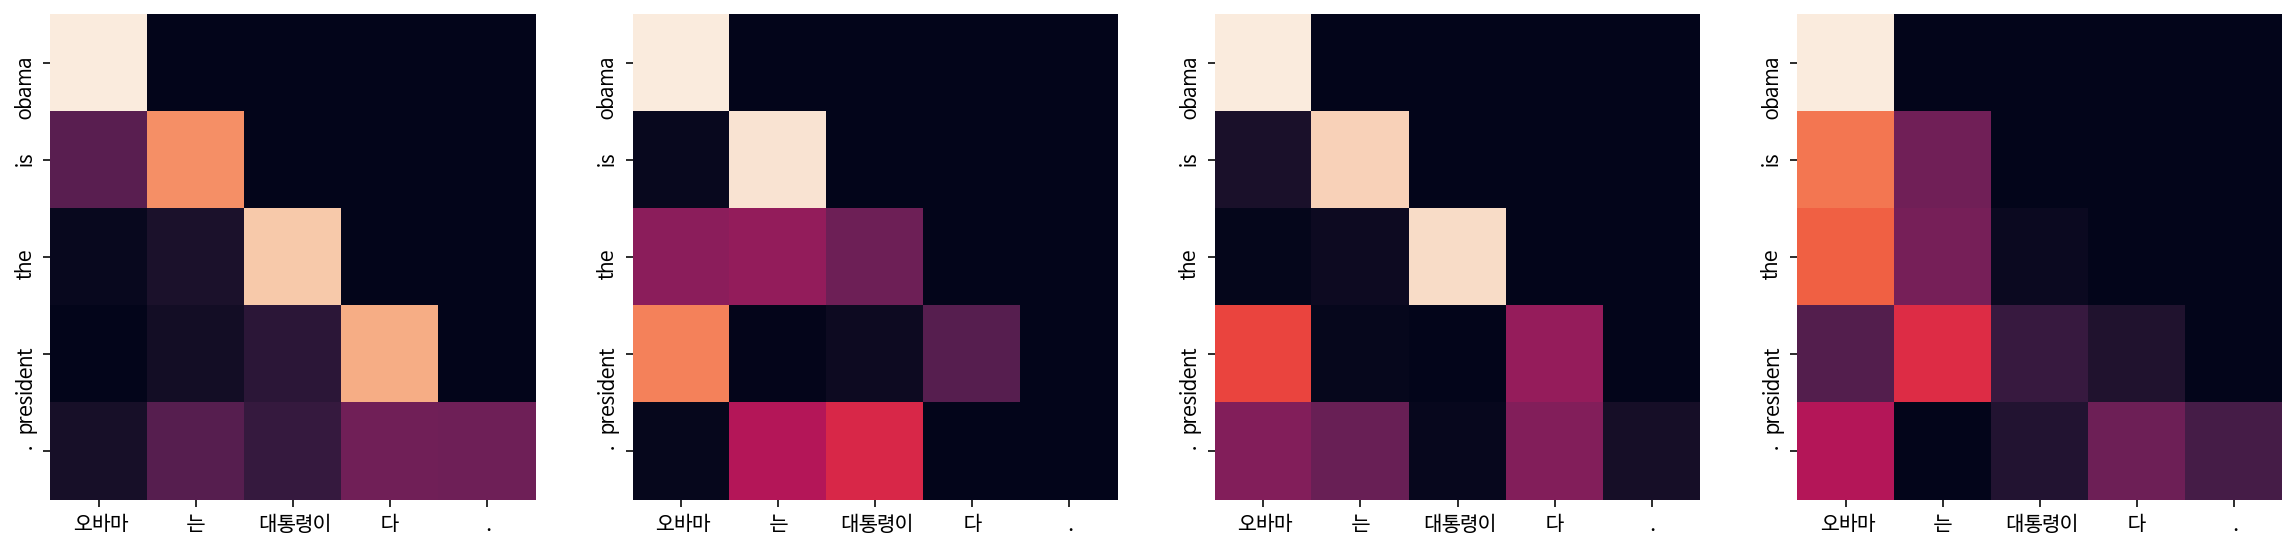

Decoder Self Layer 2


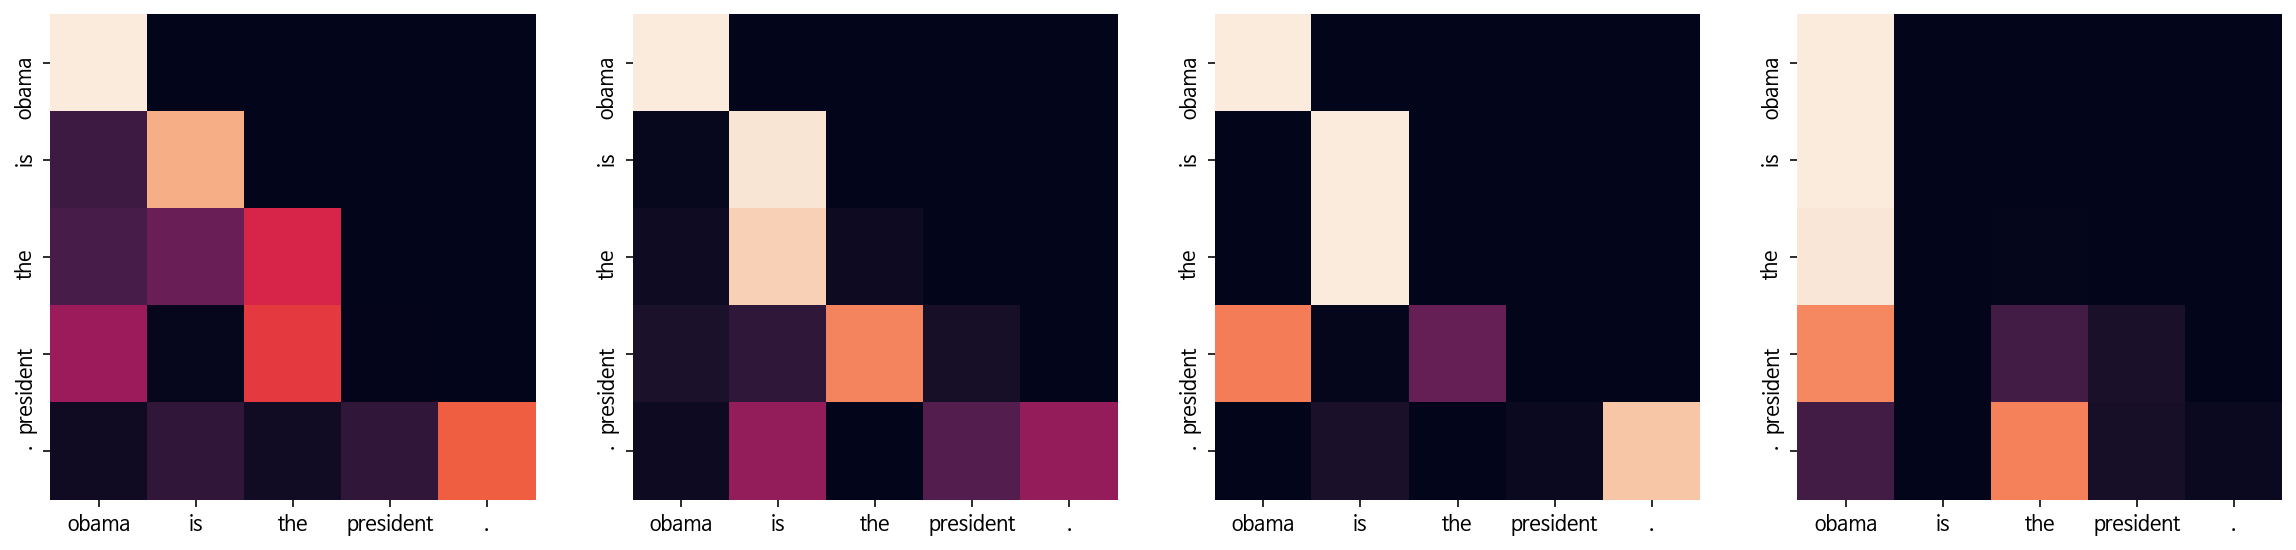

Decoder Src Layer 2


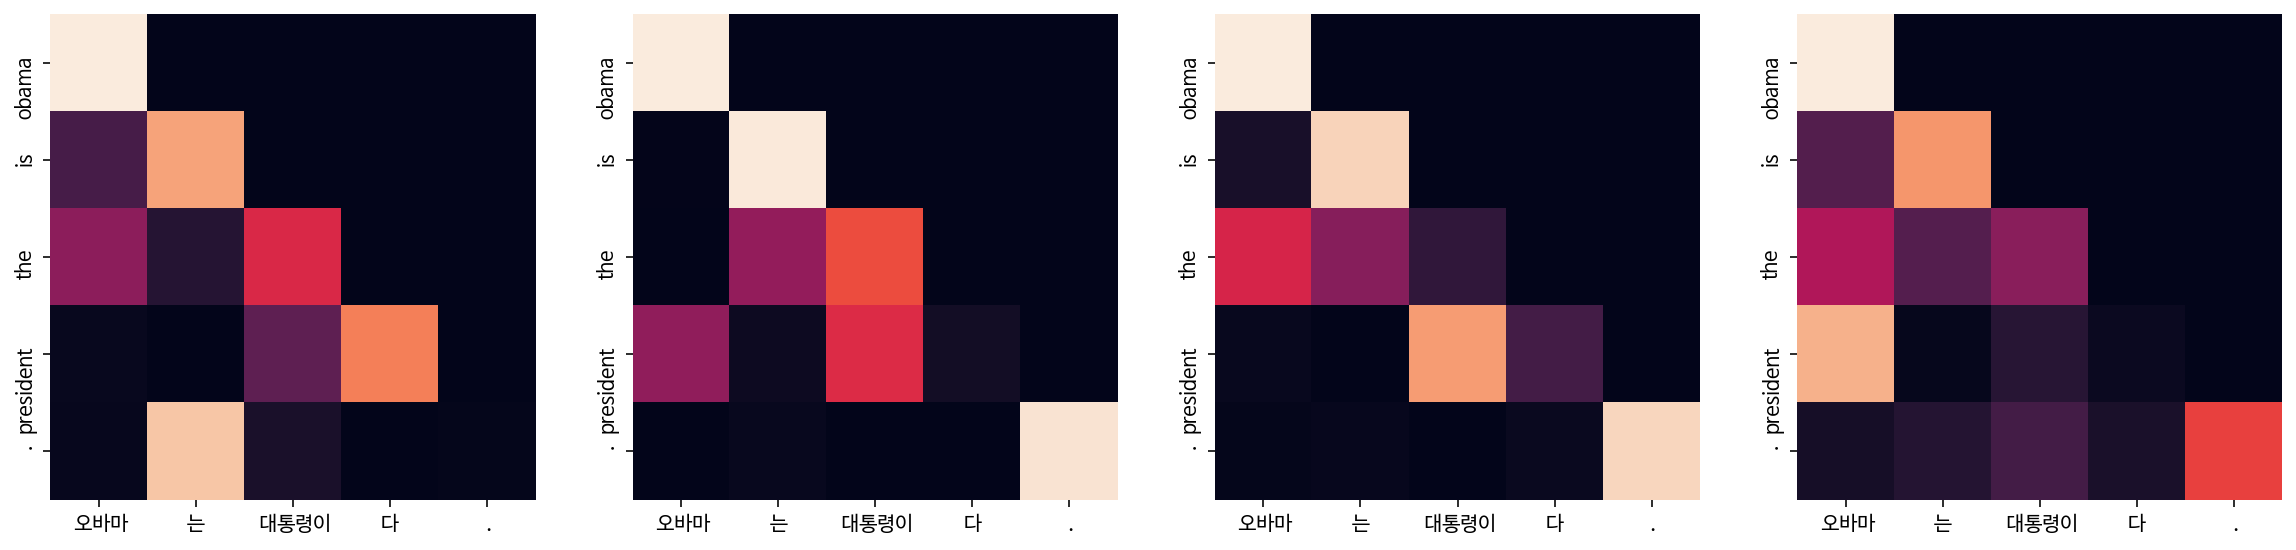



------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they are local citizens .
------------------------------
Encoder Layer 1


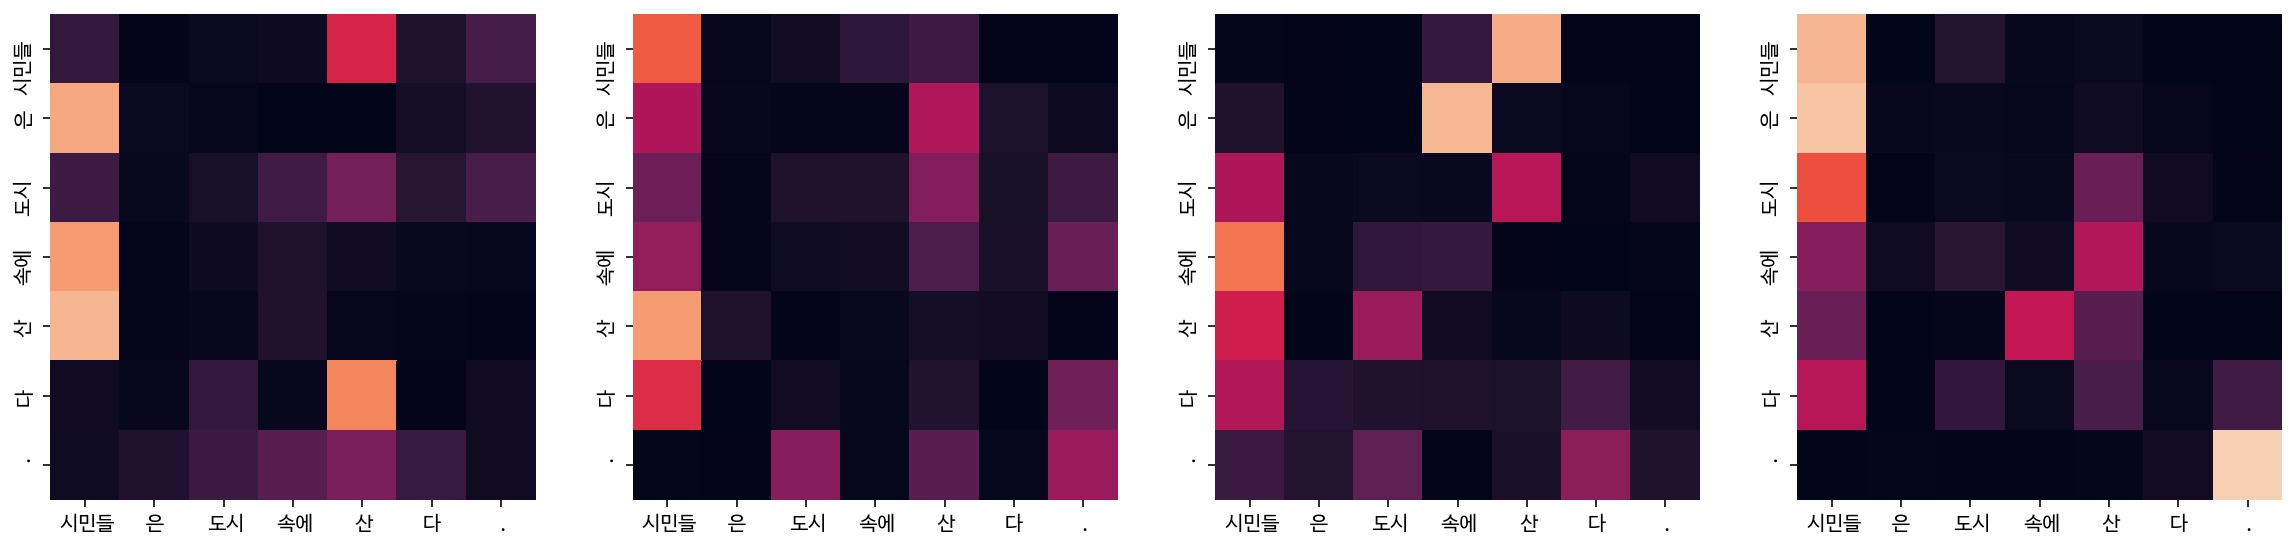

Encoder Layer 2


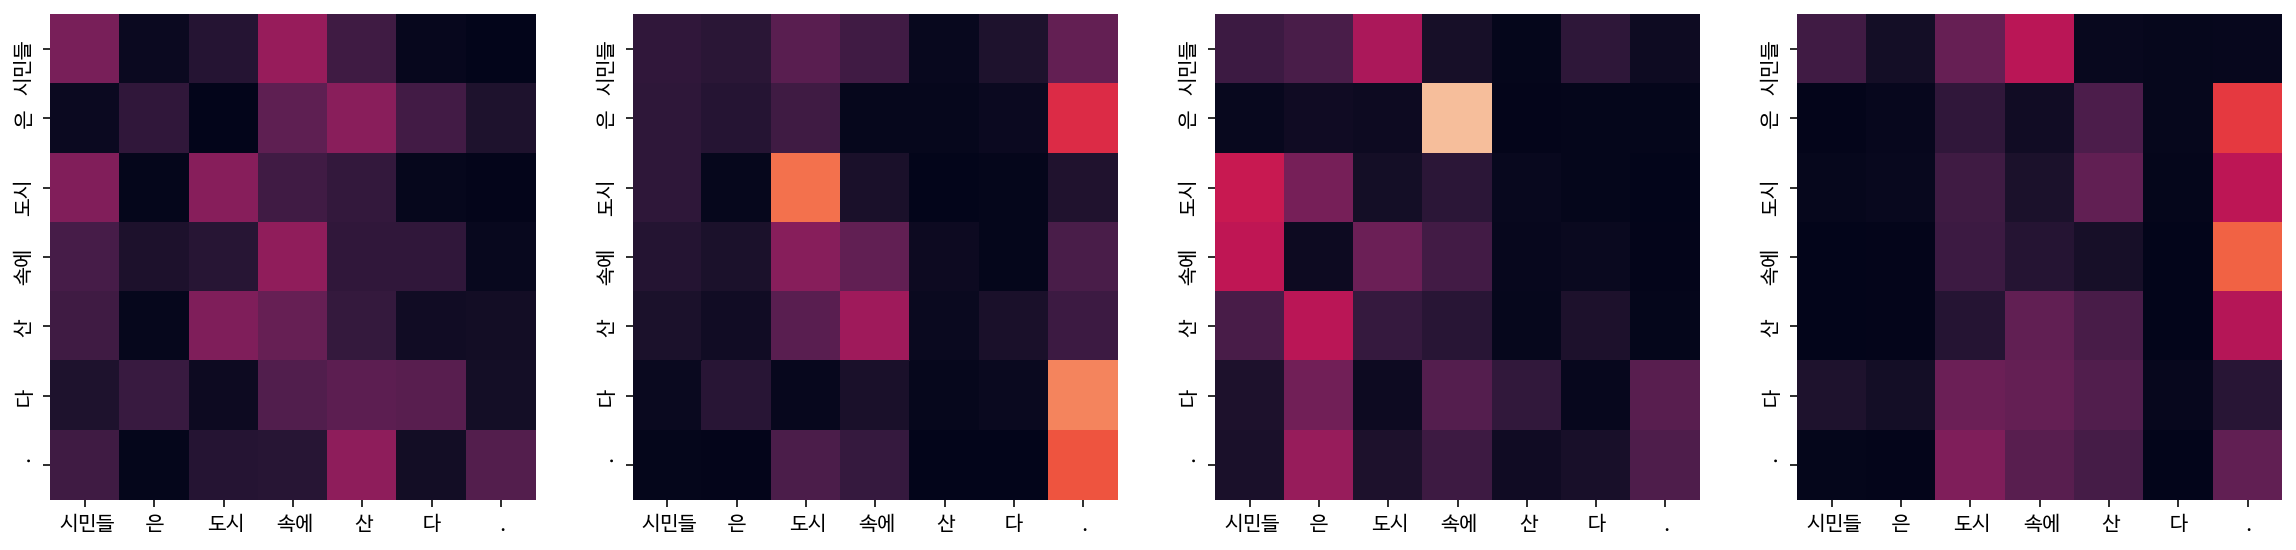

Decoder Self Layer 1


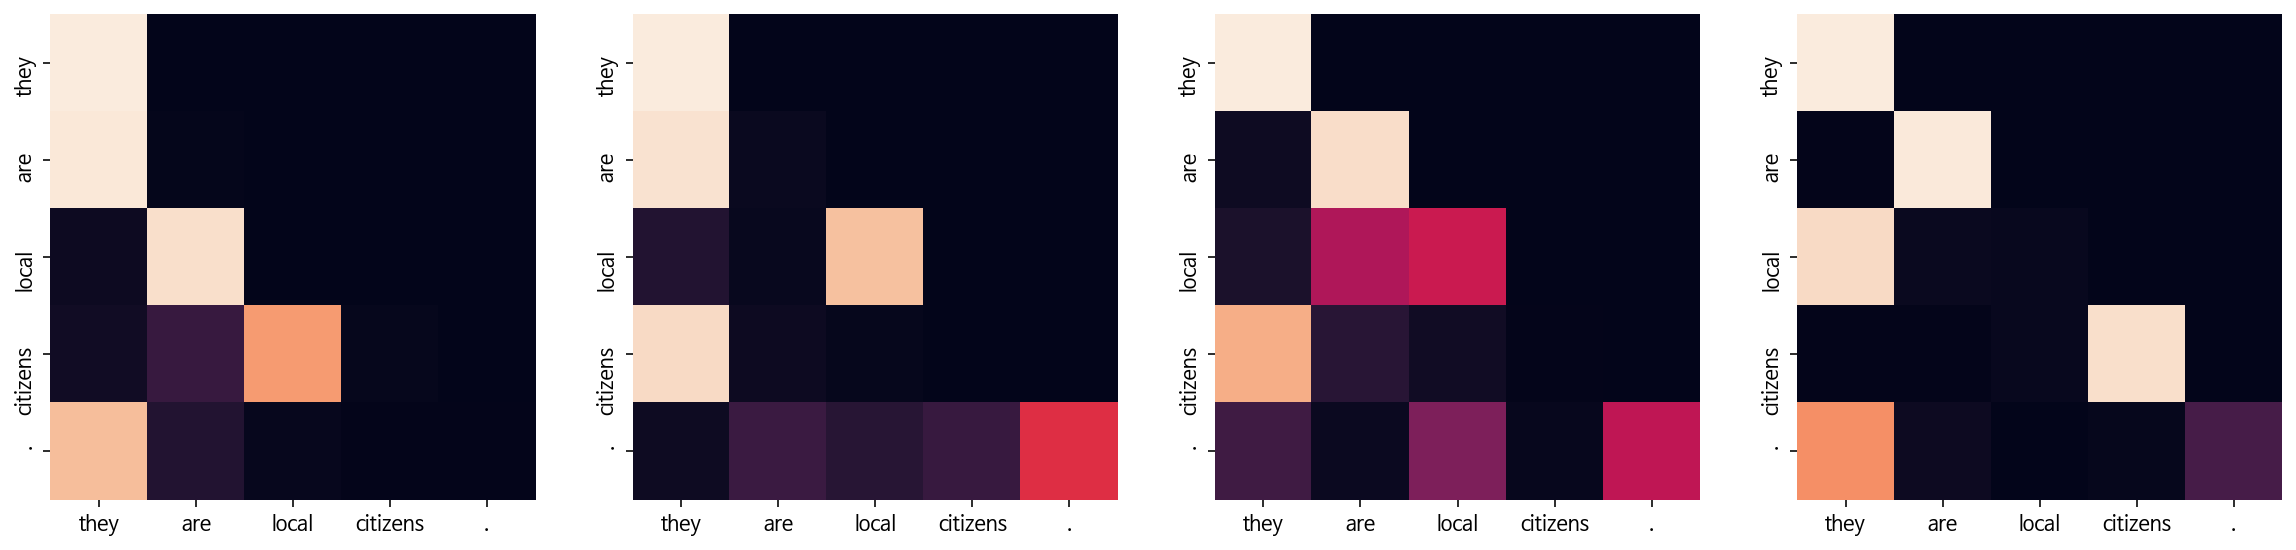

Decoder Src Layer 1


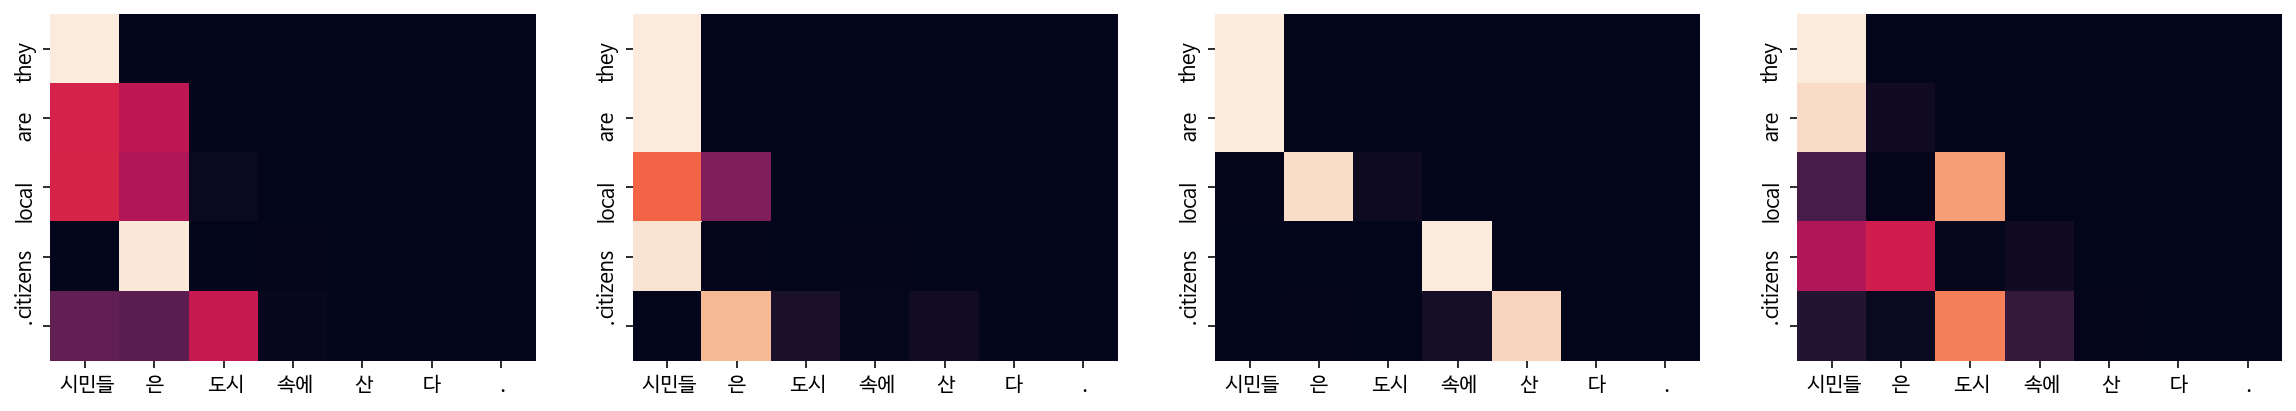

Decoder Self Layer 2


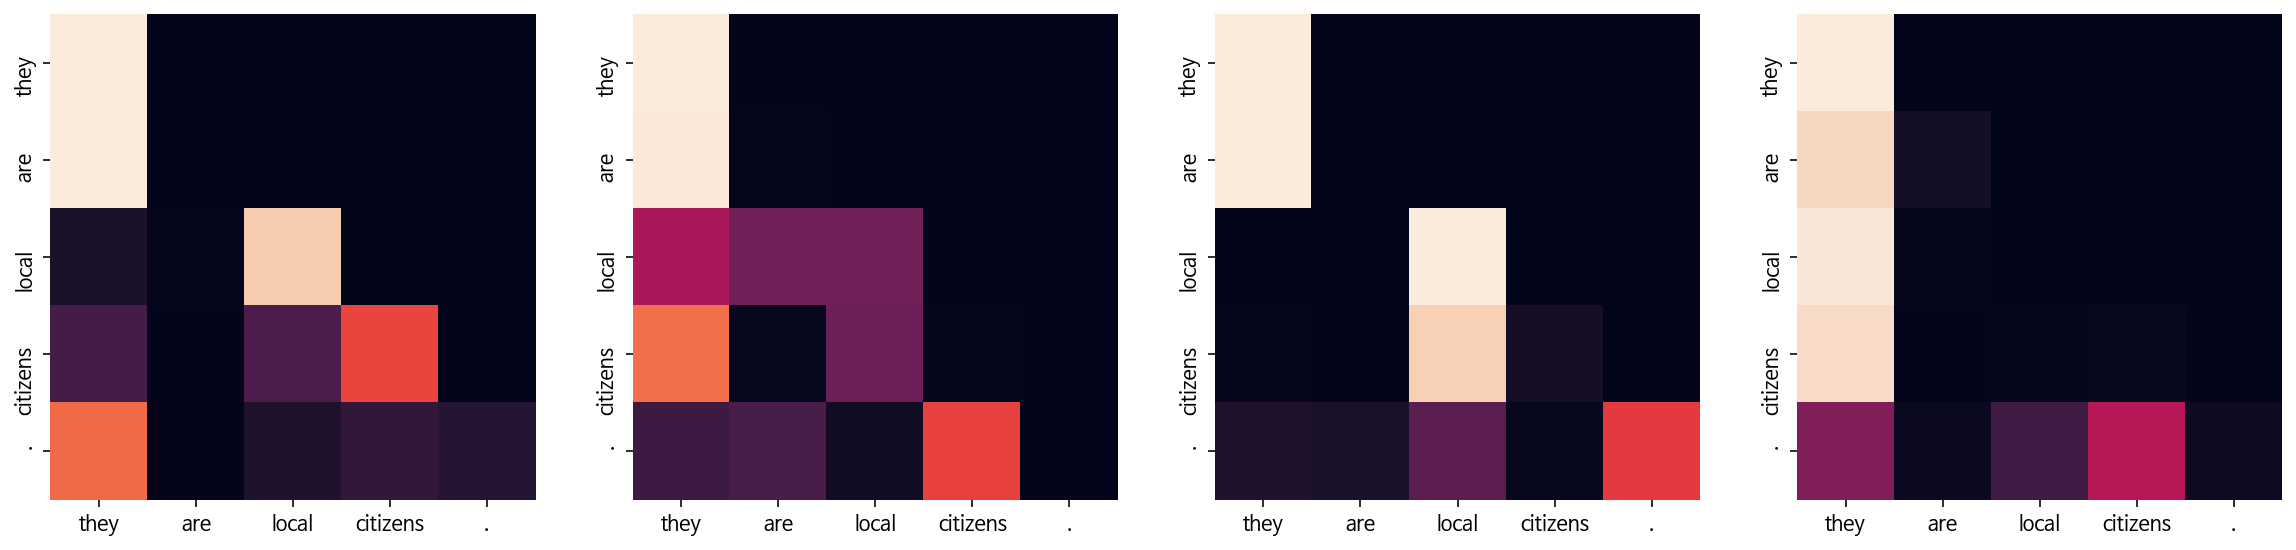

Decoder Src Layer 2


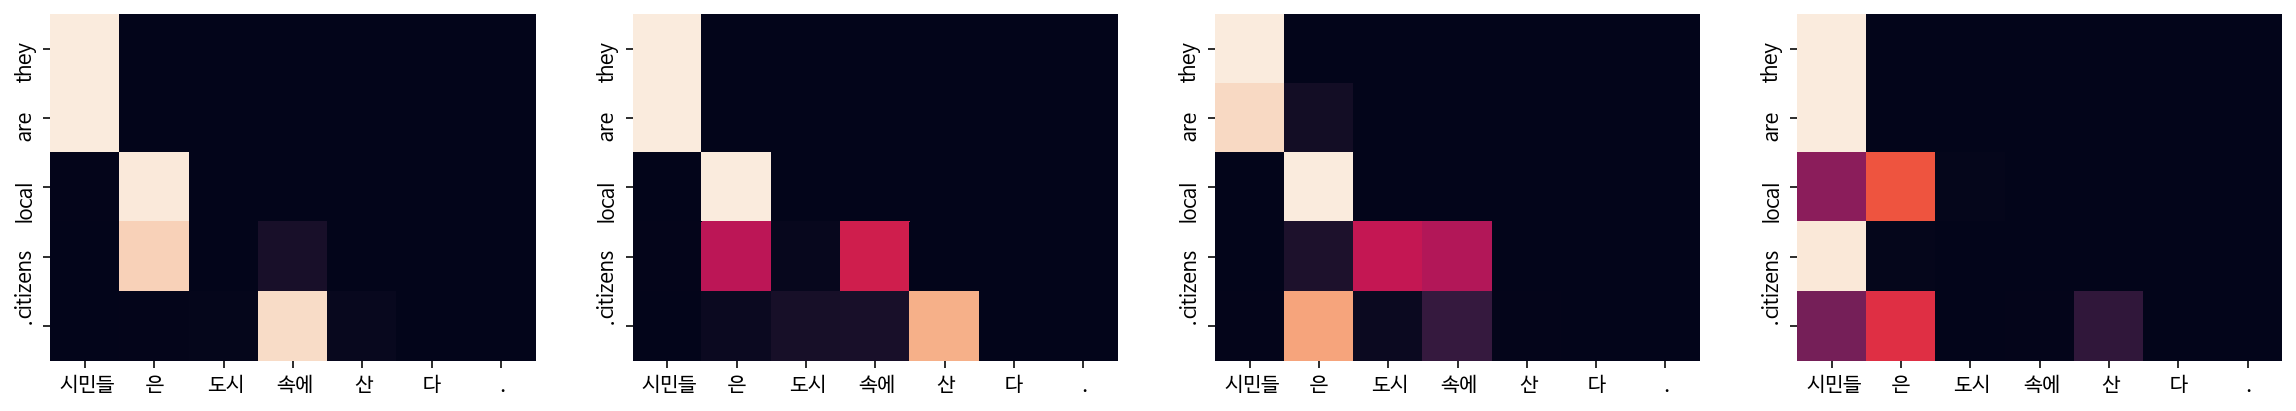



------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s not a very rare .
------------------------------
Encoder Layer 1


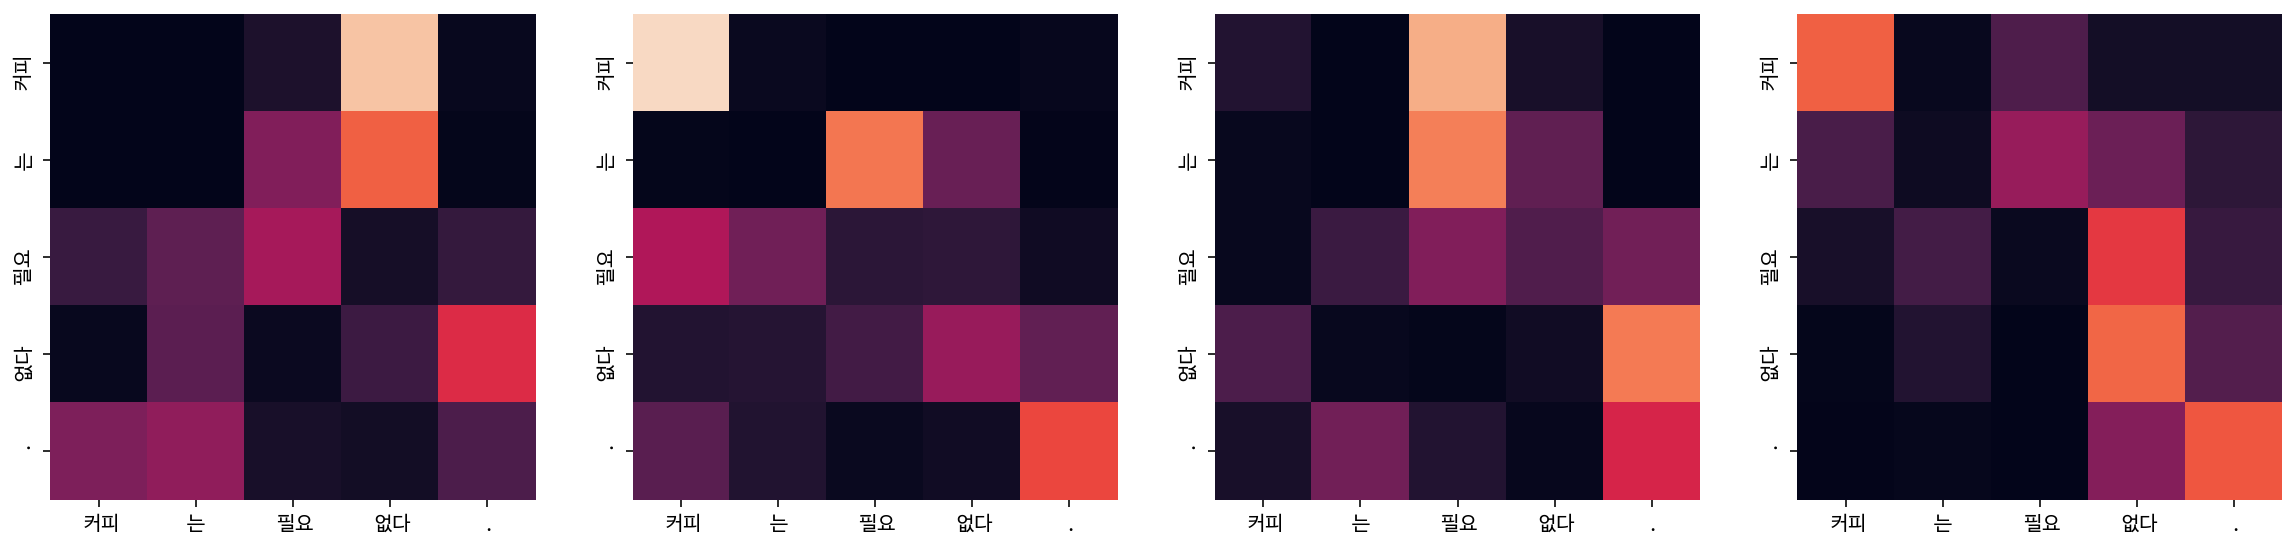

Encoder Layer 2


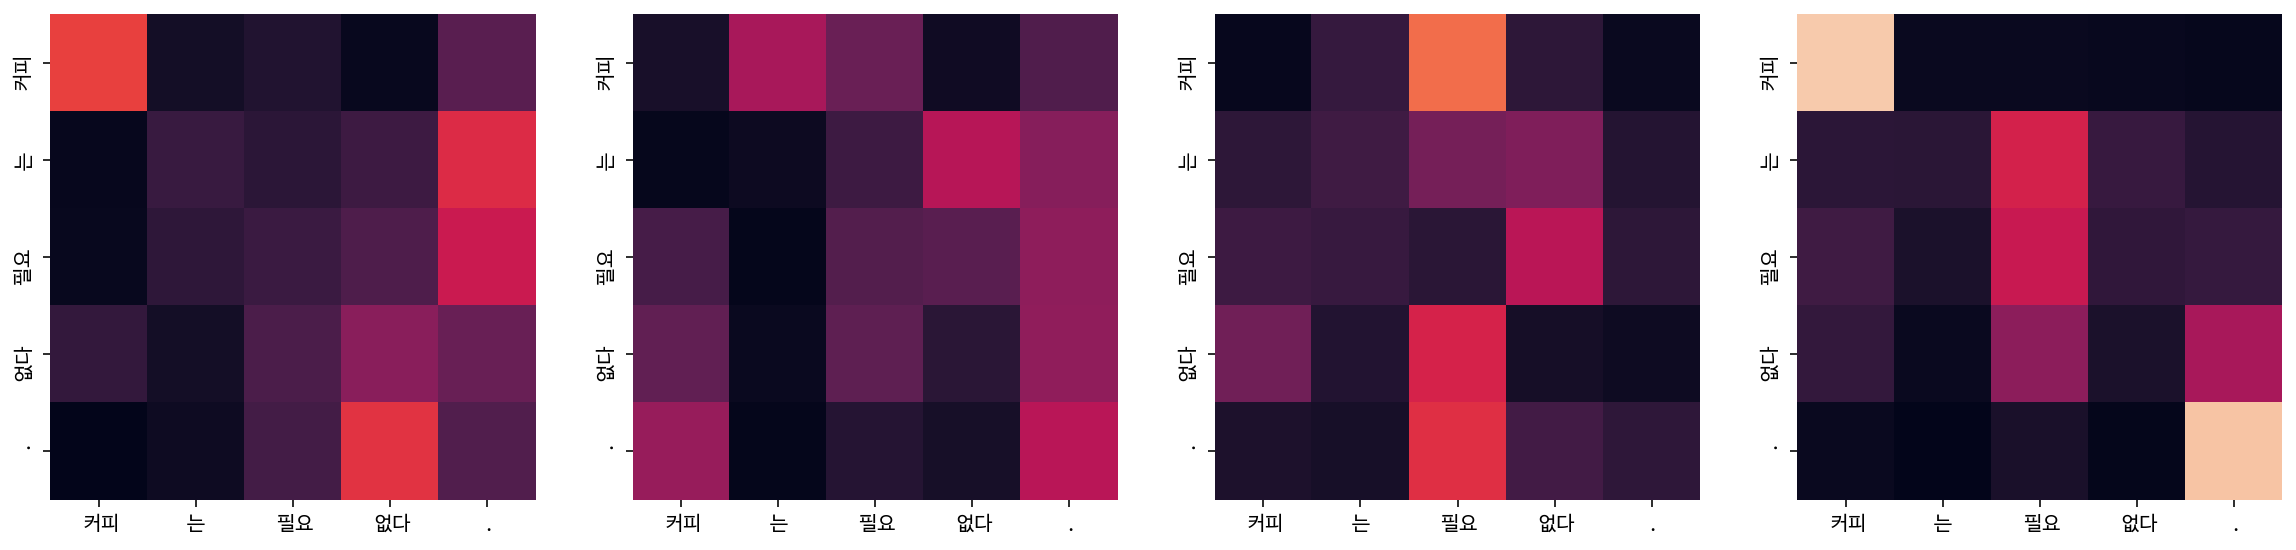

Decoder Self Layer 1


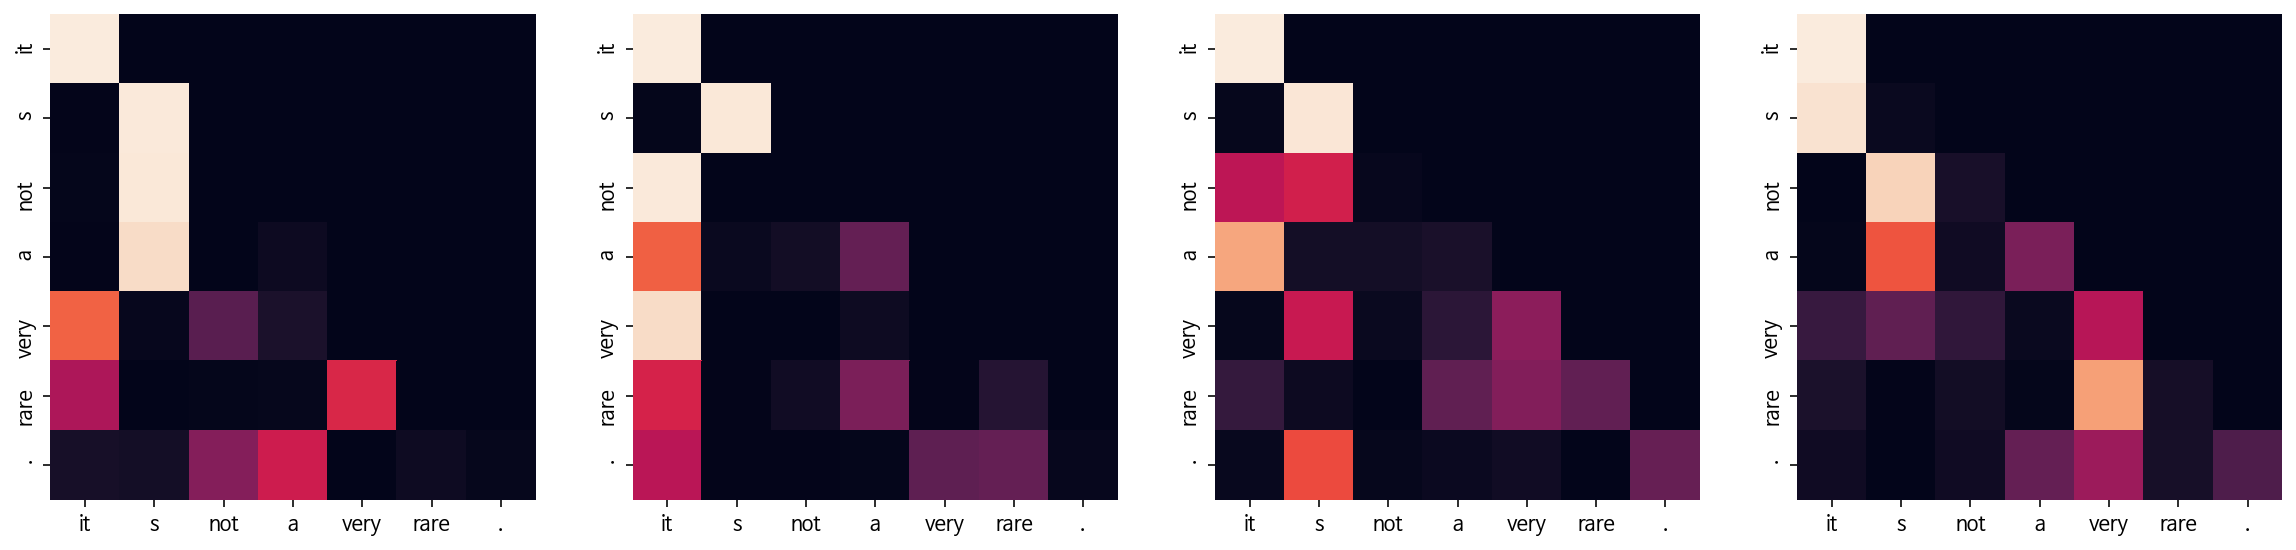

Decoder Src Layer 1


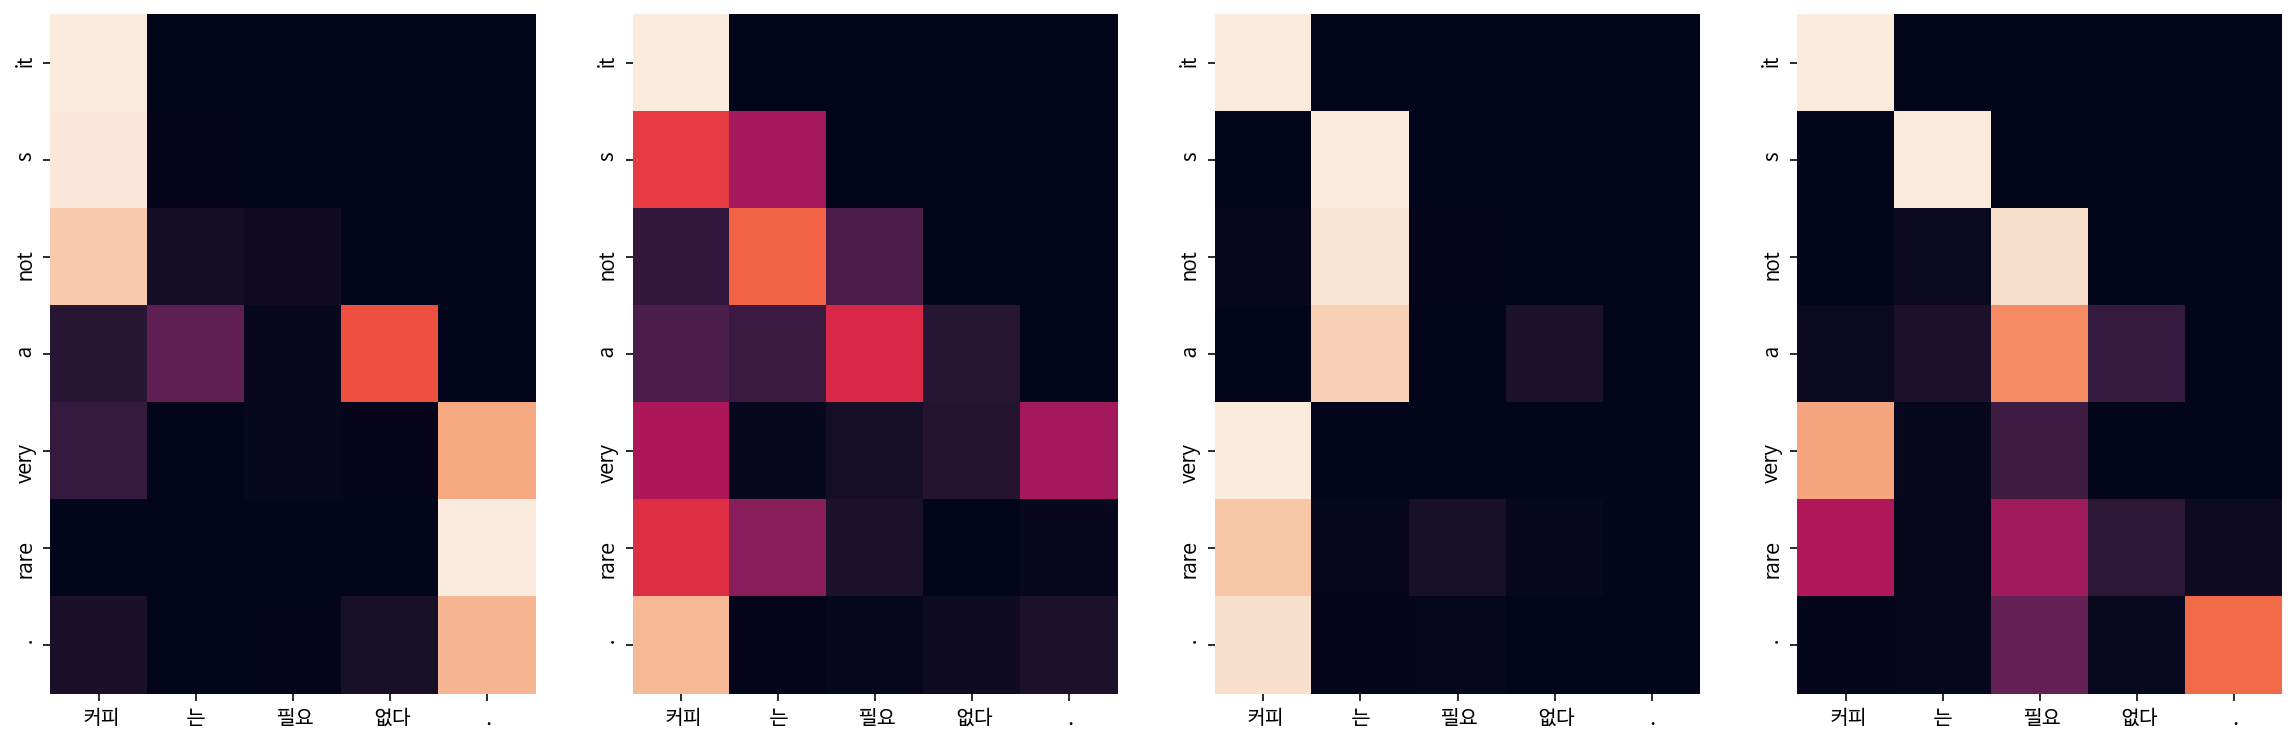

Decoder Self Layer 2


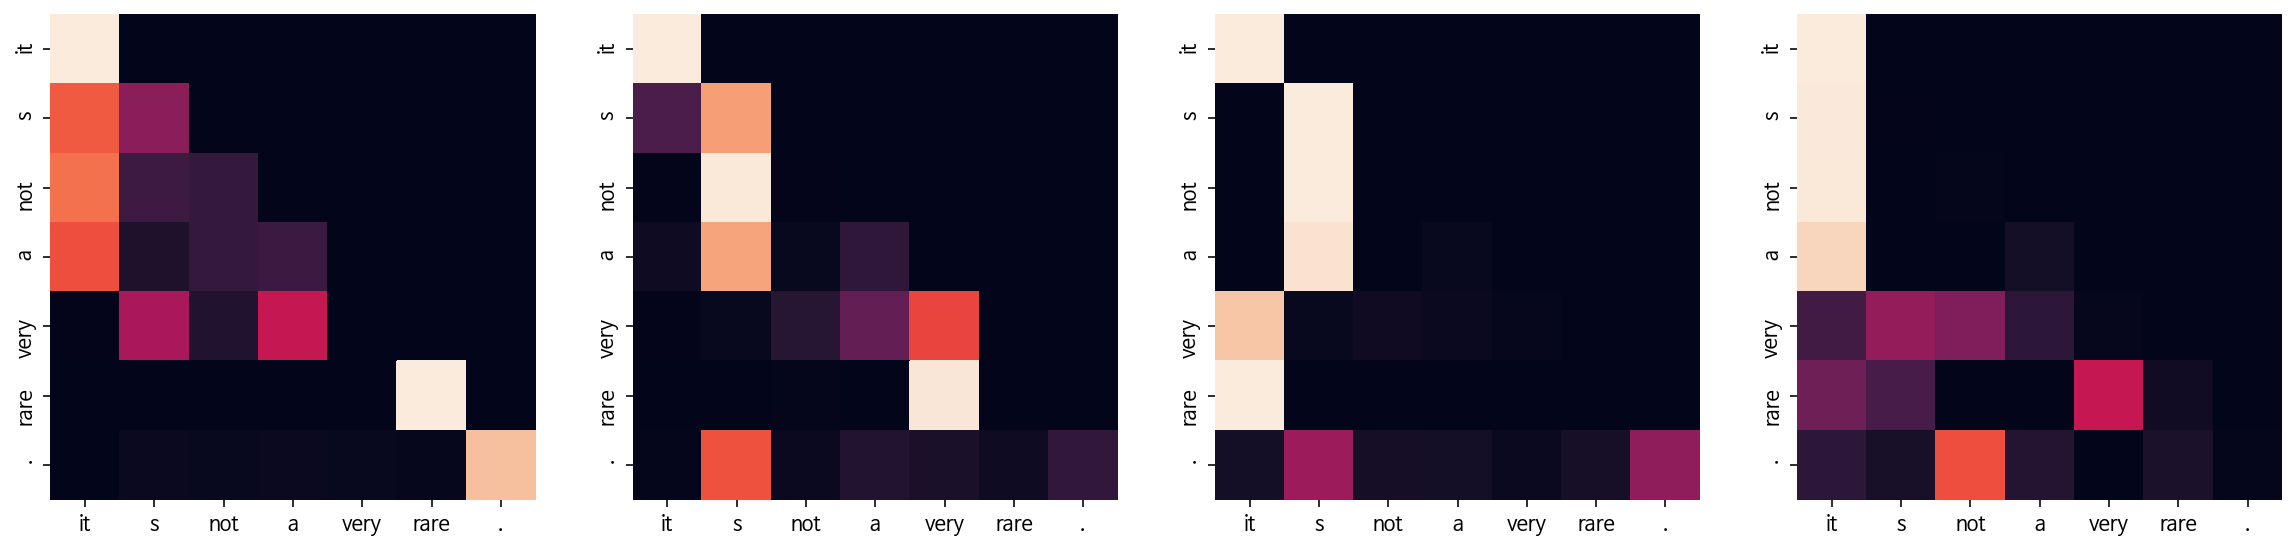

Decoder Src Layer 2


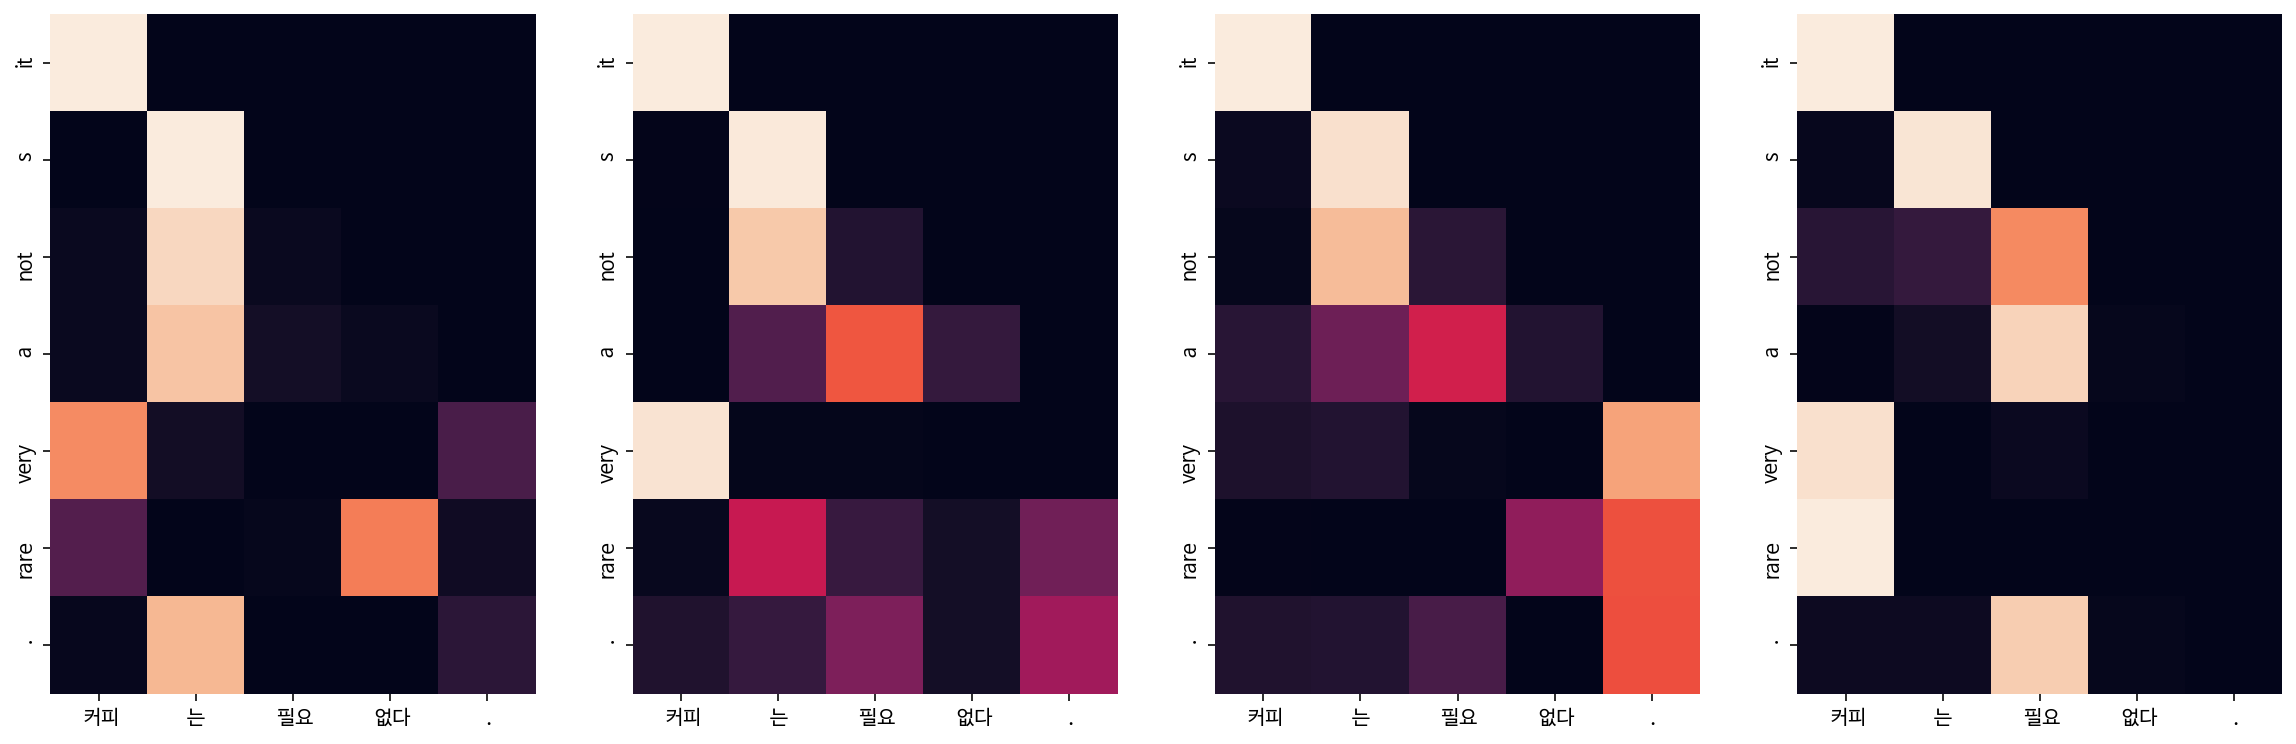



------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the death toll .
------------------------------
Encoder Layer 1


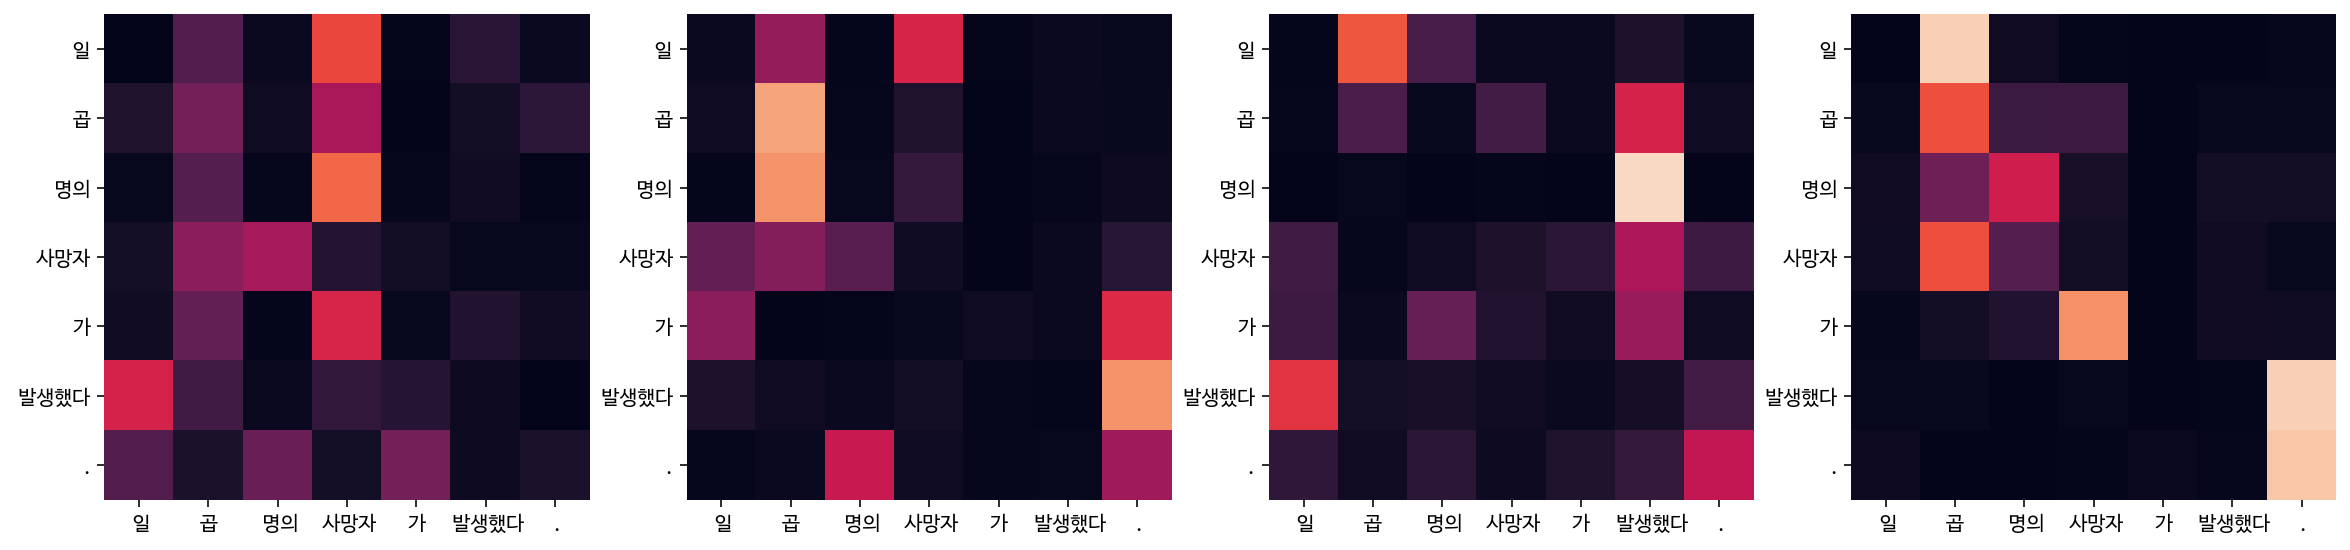

Encoder Layer 2


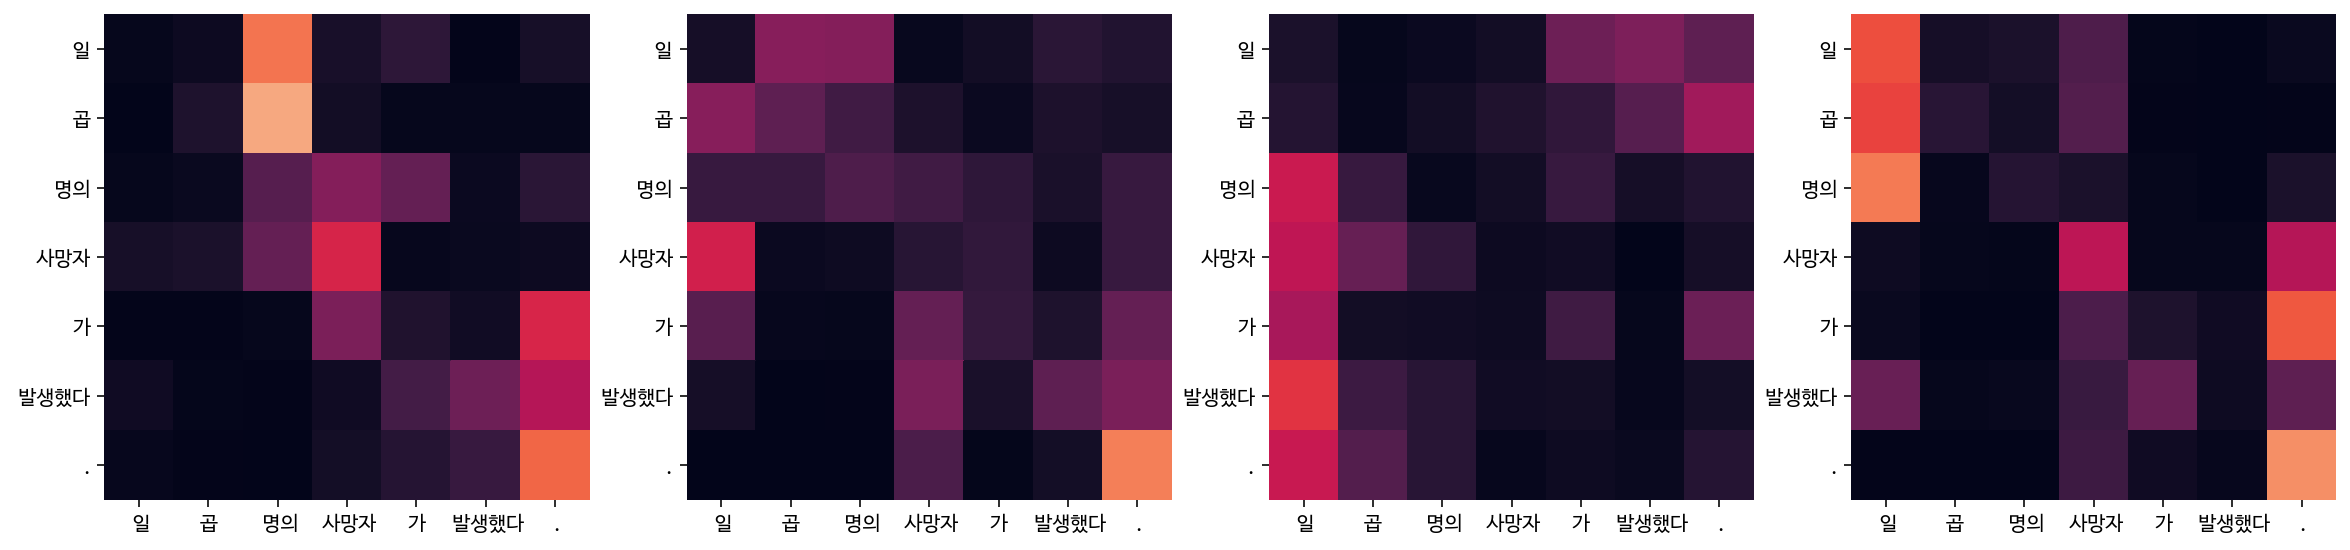

Decoder Self Layer 1


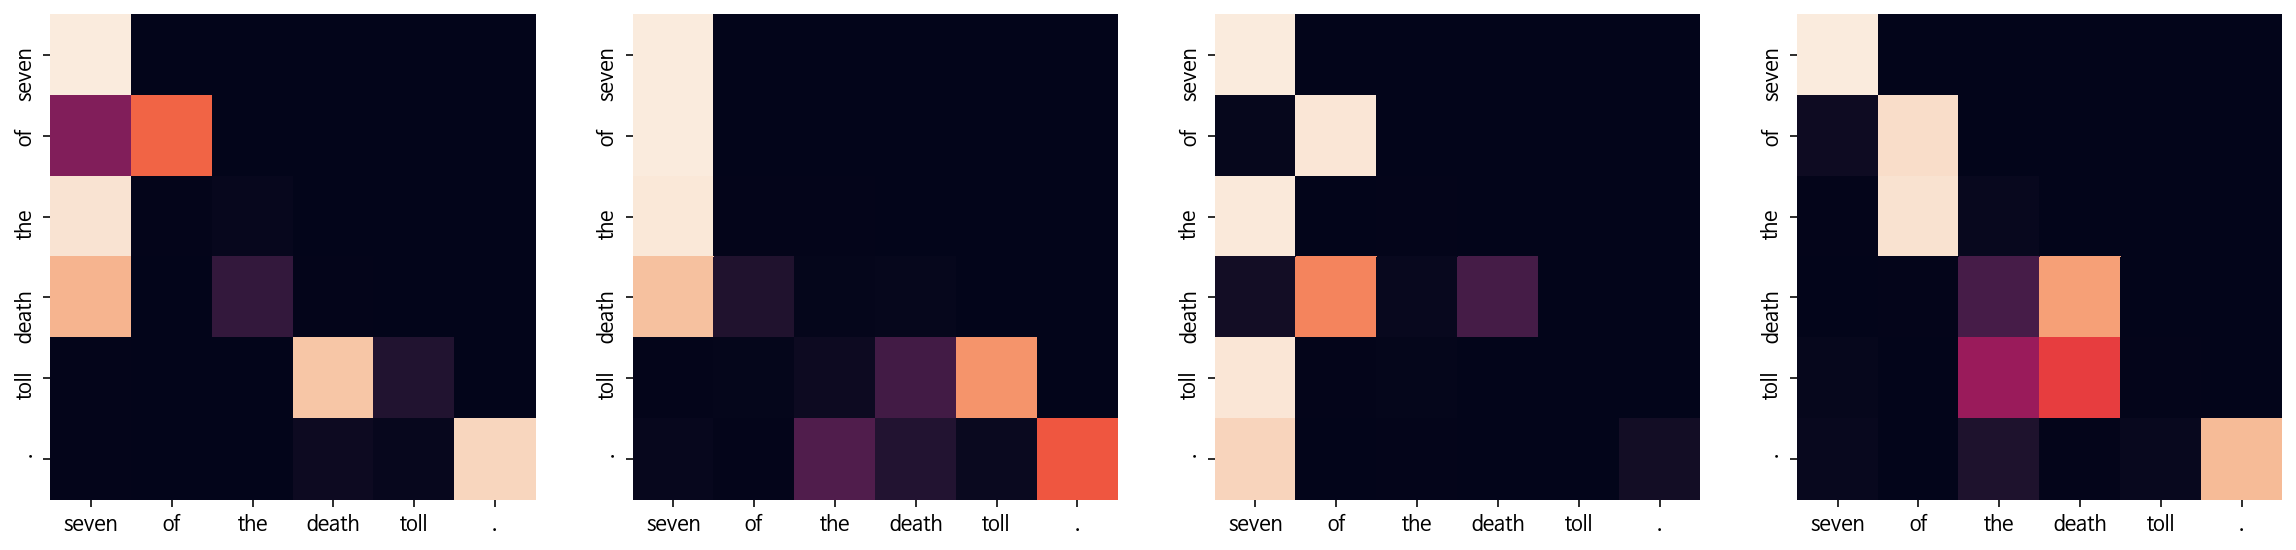

Decoder Src Layer 1


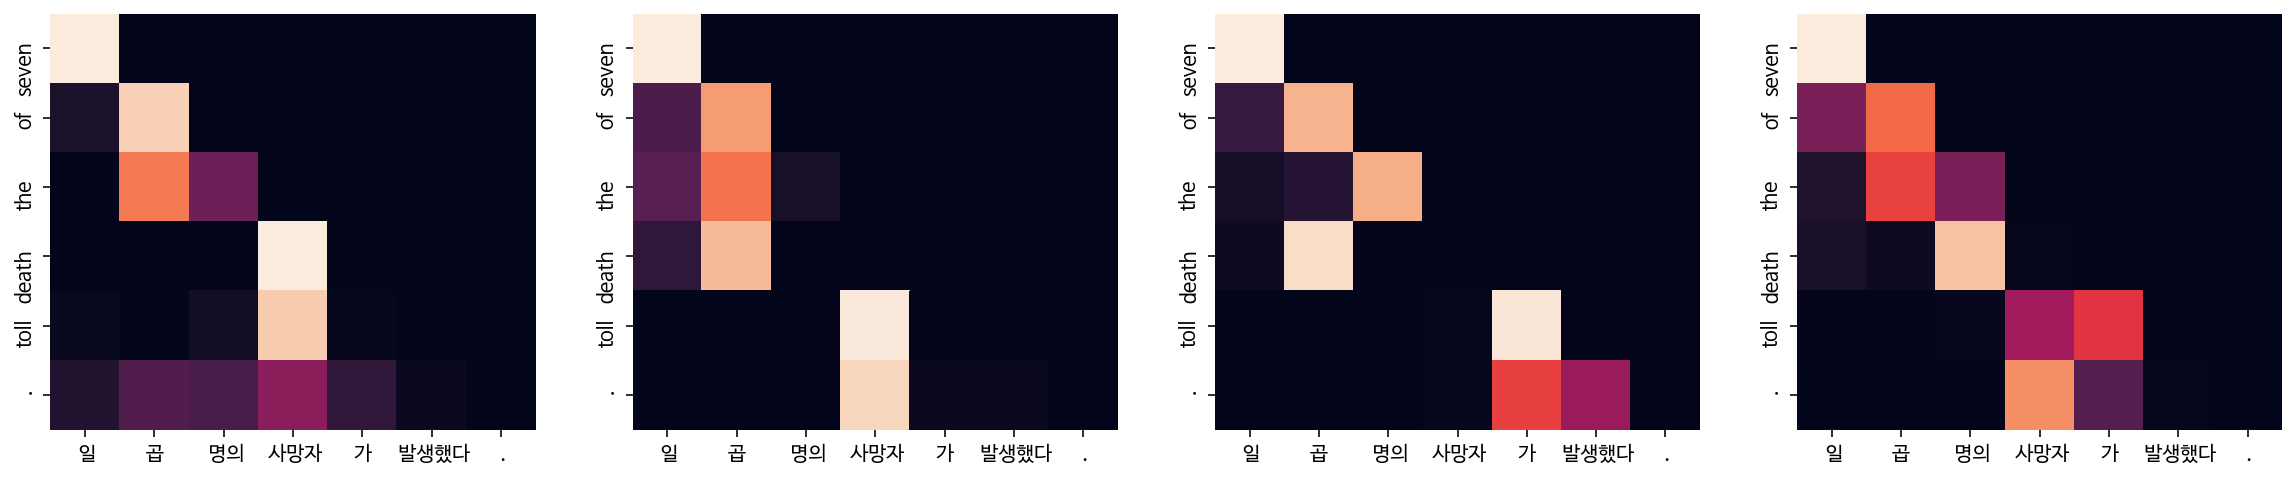

Decoder Self Layer 2


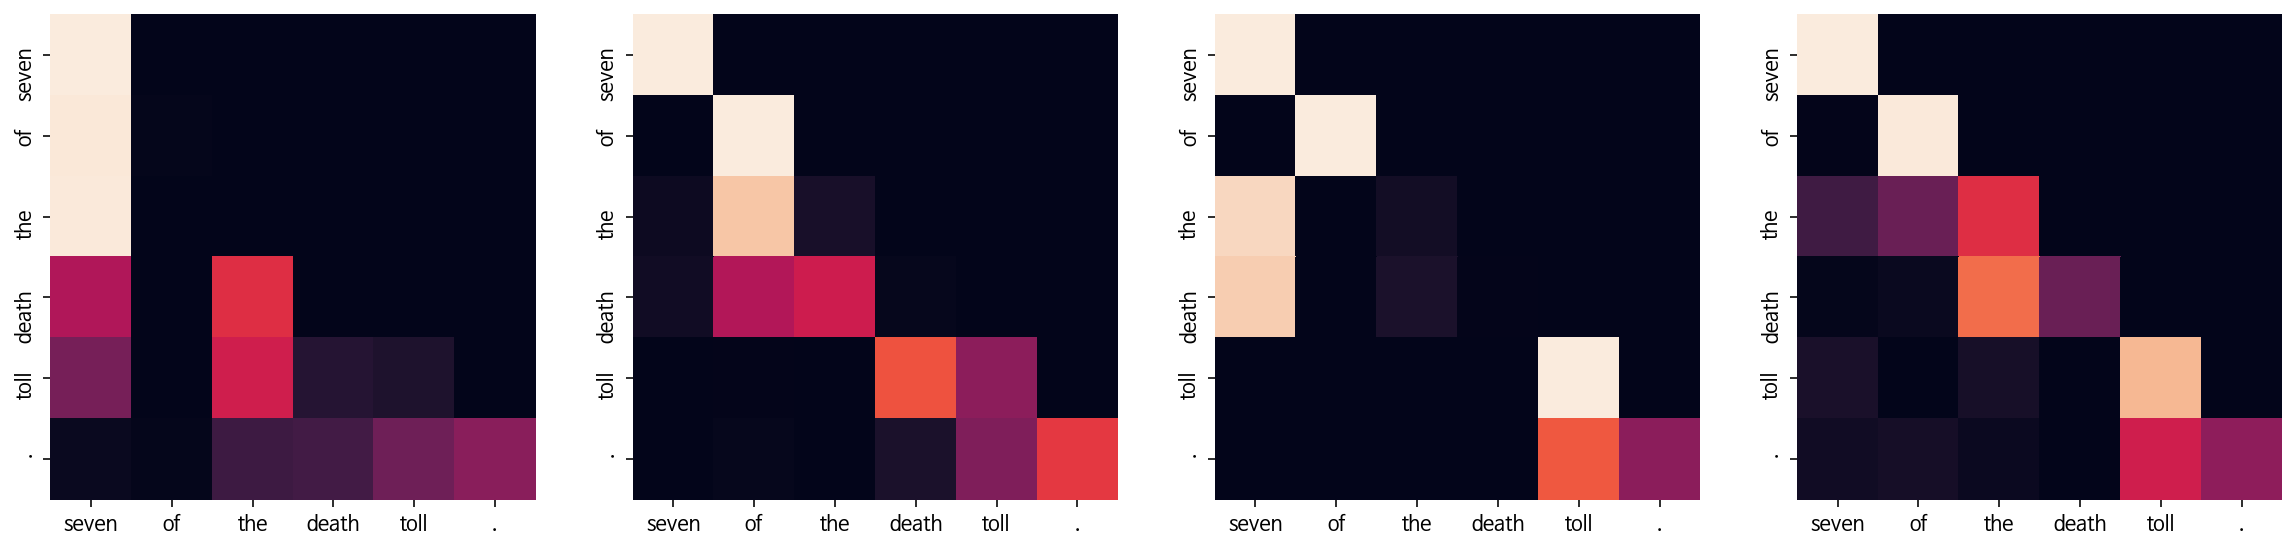

Decoder Src Layer 2


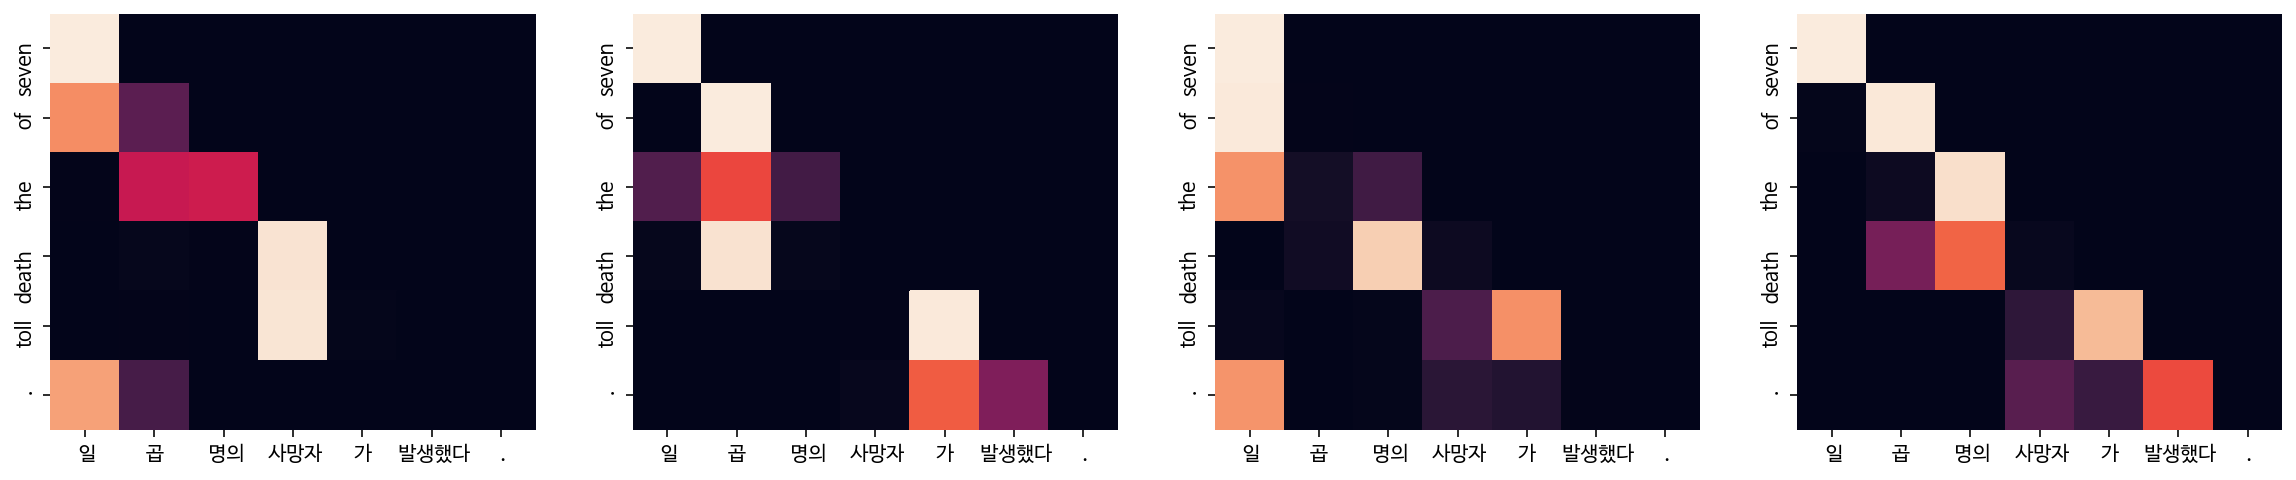

  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  11 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama s picked up obama s president .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they are the home of the home .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s a coffee no . . . . . . .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven deaths of the dead .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  12 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : the president elect is barack obama .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they are the home of the home .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s unclear how the coffee is no . . . . . . .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the death toll occurred .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  13 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : obama is calling the president to go another .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : there are local cities in the home .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s unclear how many of the coffee .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven deaths from the seven death toll in the seven death toll .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  14 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : the president is leaving .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : there are some cityies .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s unclear how the coffee is no . . .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the dead .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  15 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : barack obama is the president .
------------------------------
Encoder Layer 1


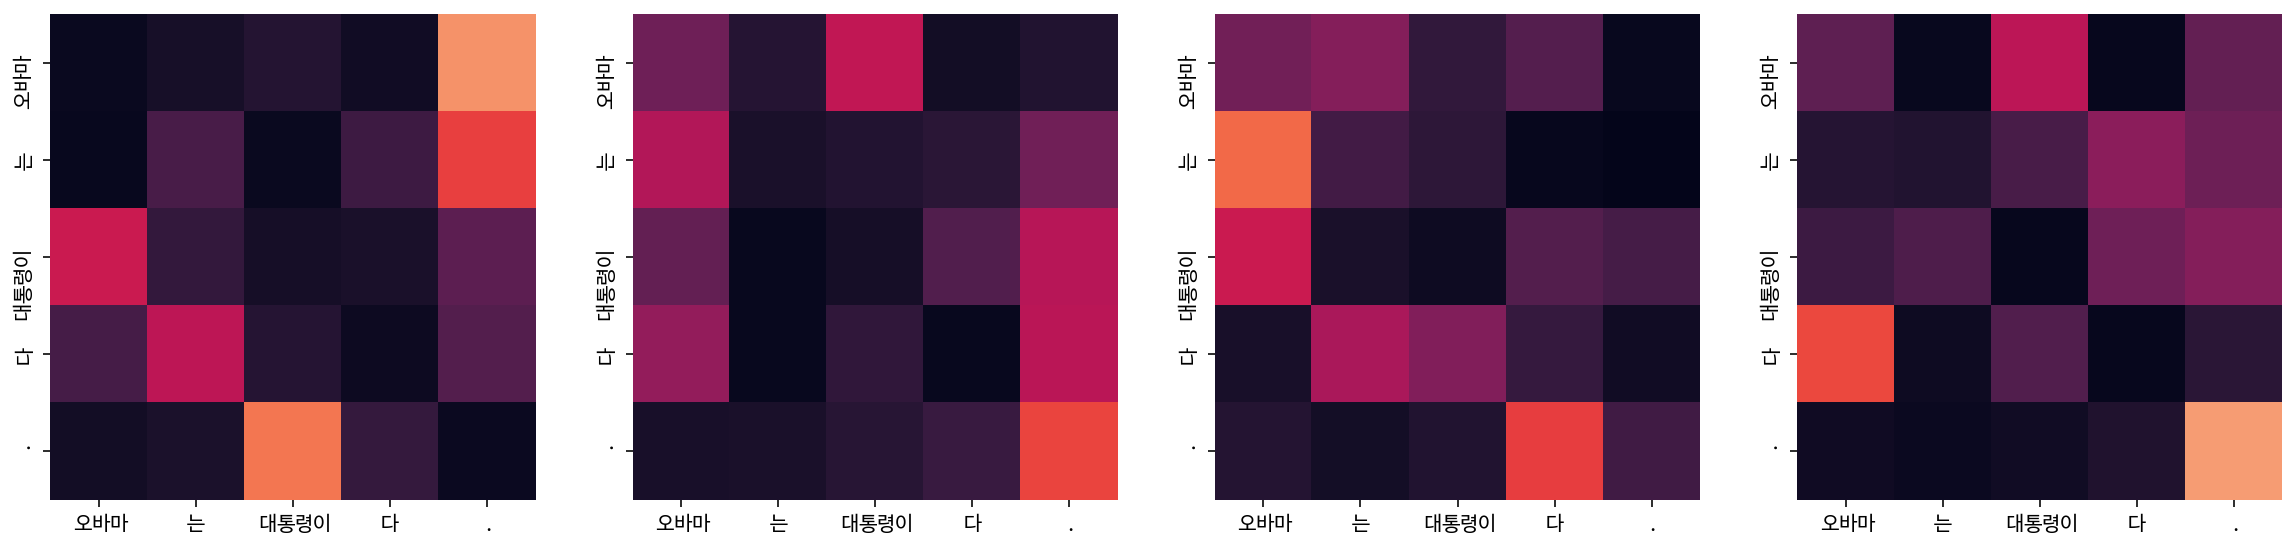

Encoder Layer 2


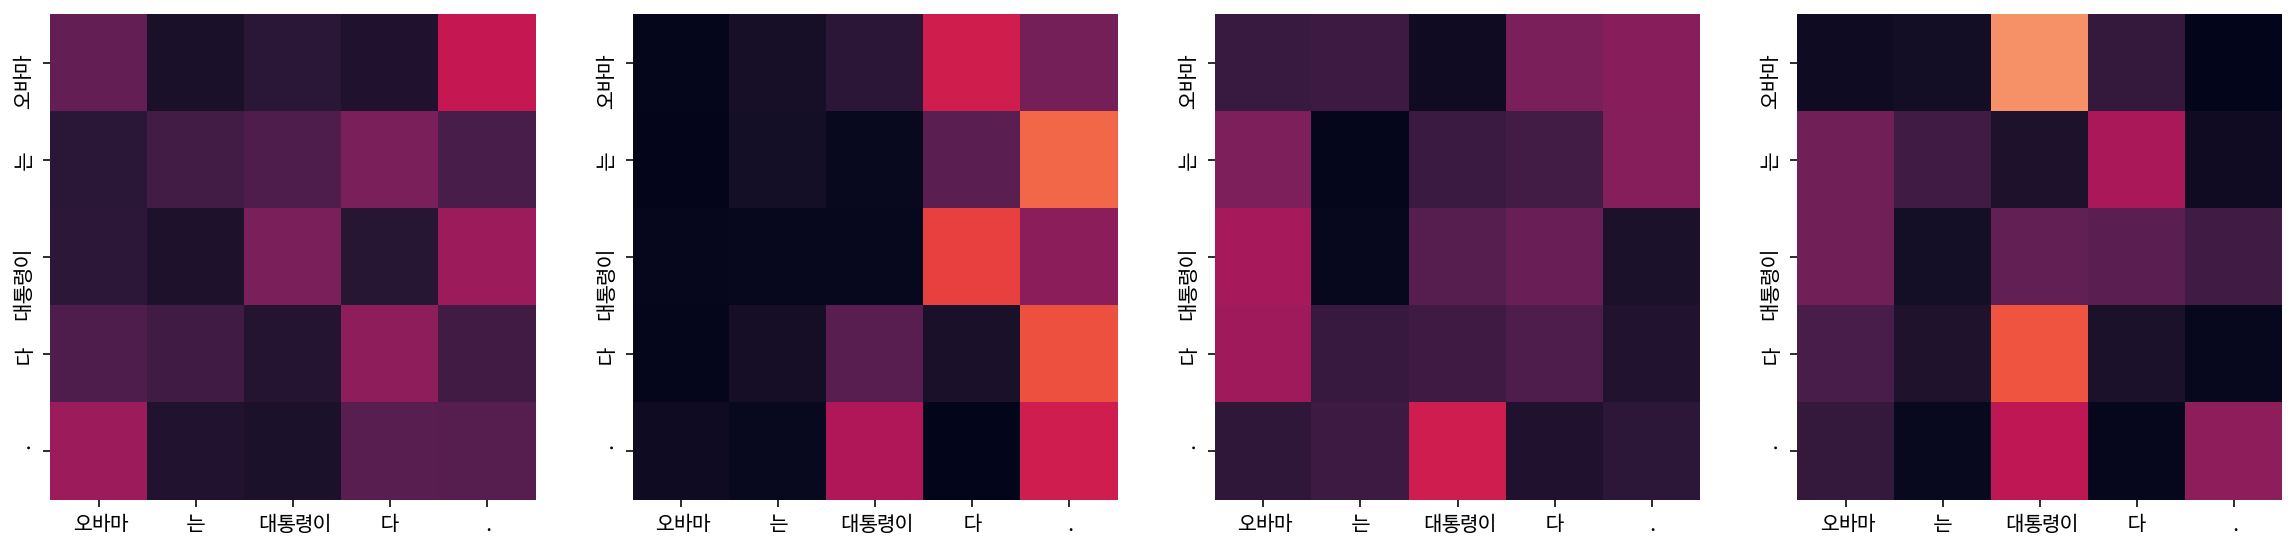

Decoder Self Layer 1


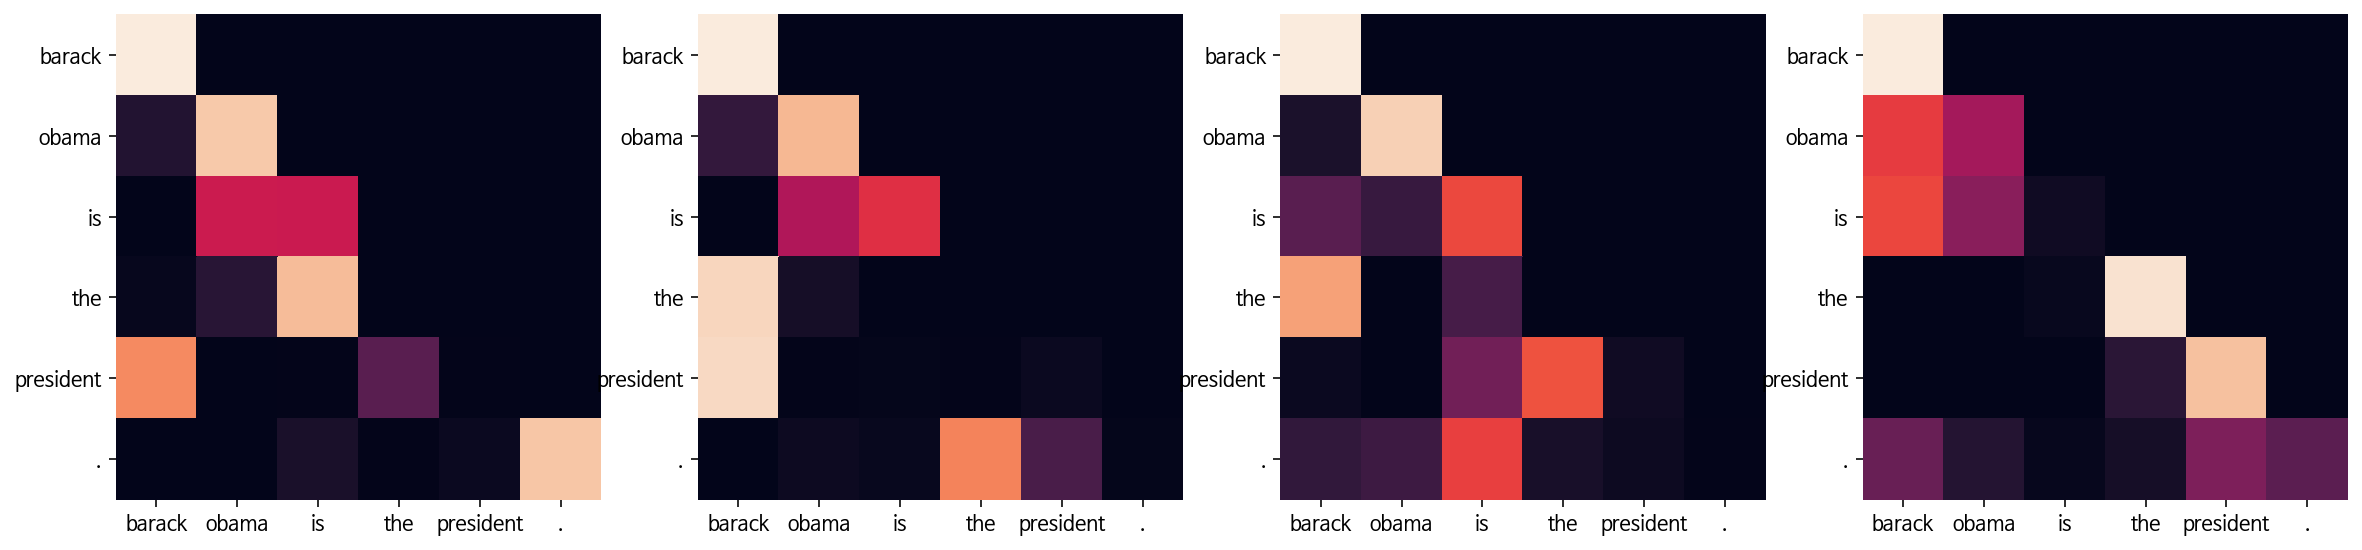

Decoder Src Layer 1


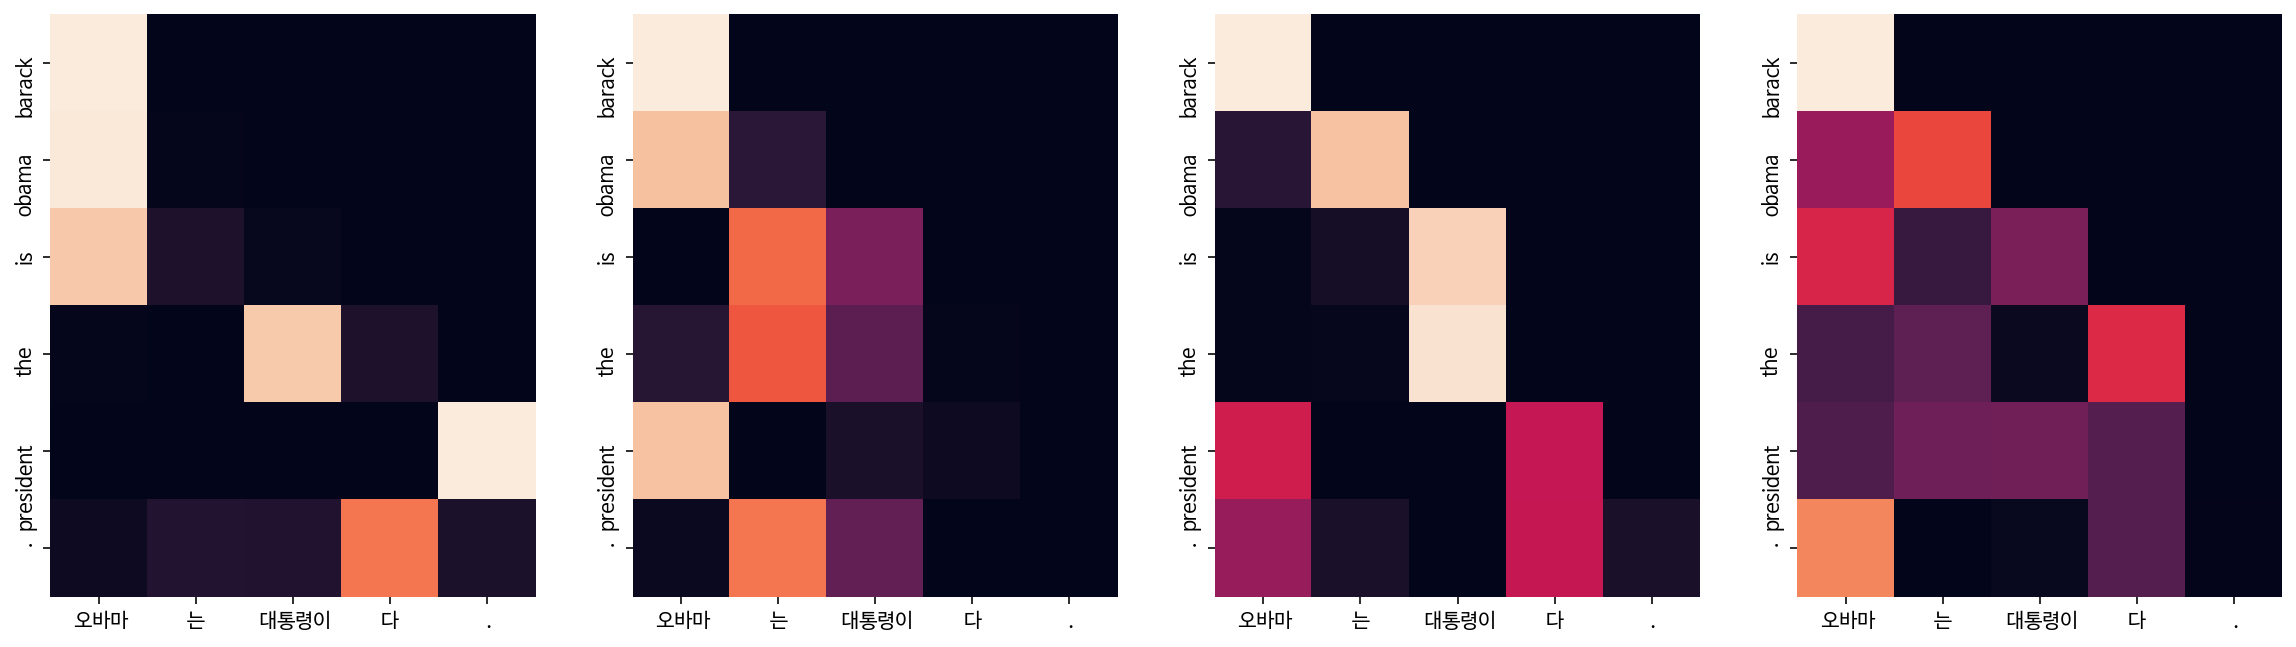

Decoder Self Layer 2


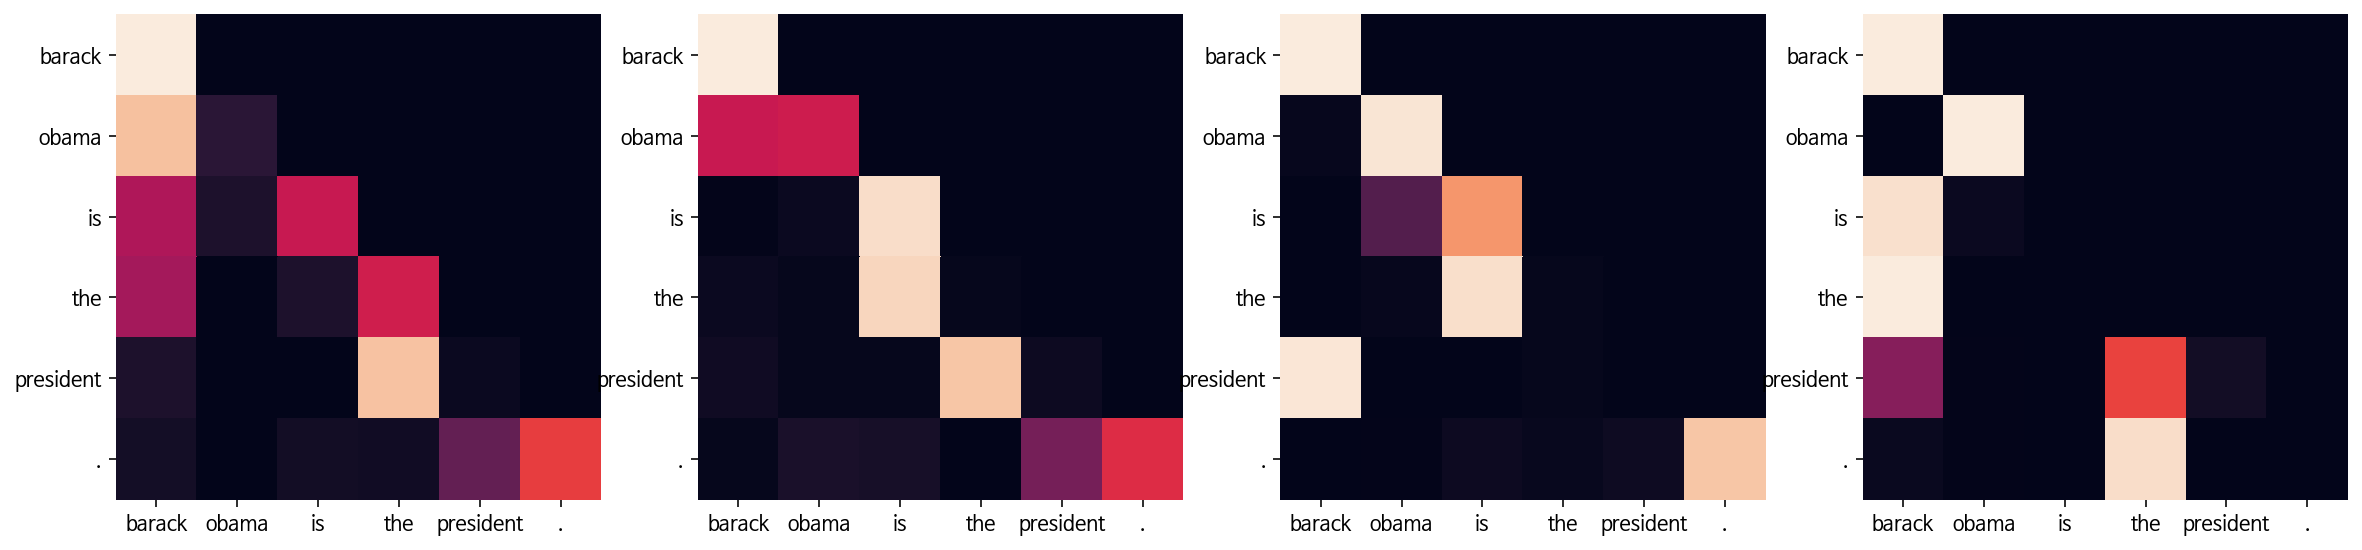

Decoder Src Layer 2


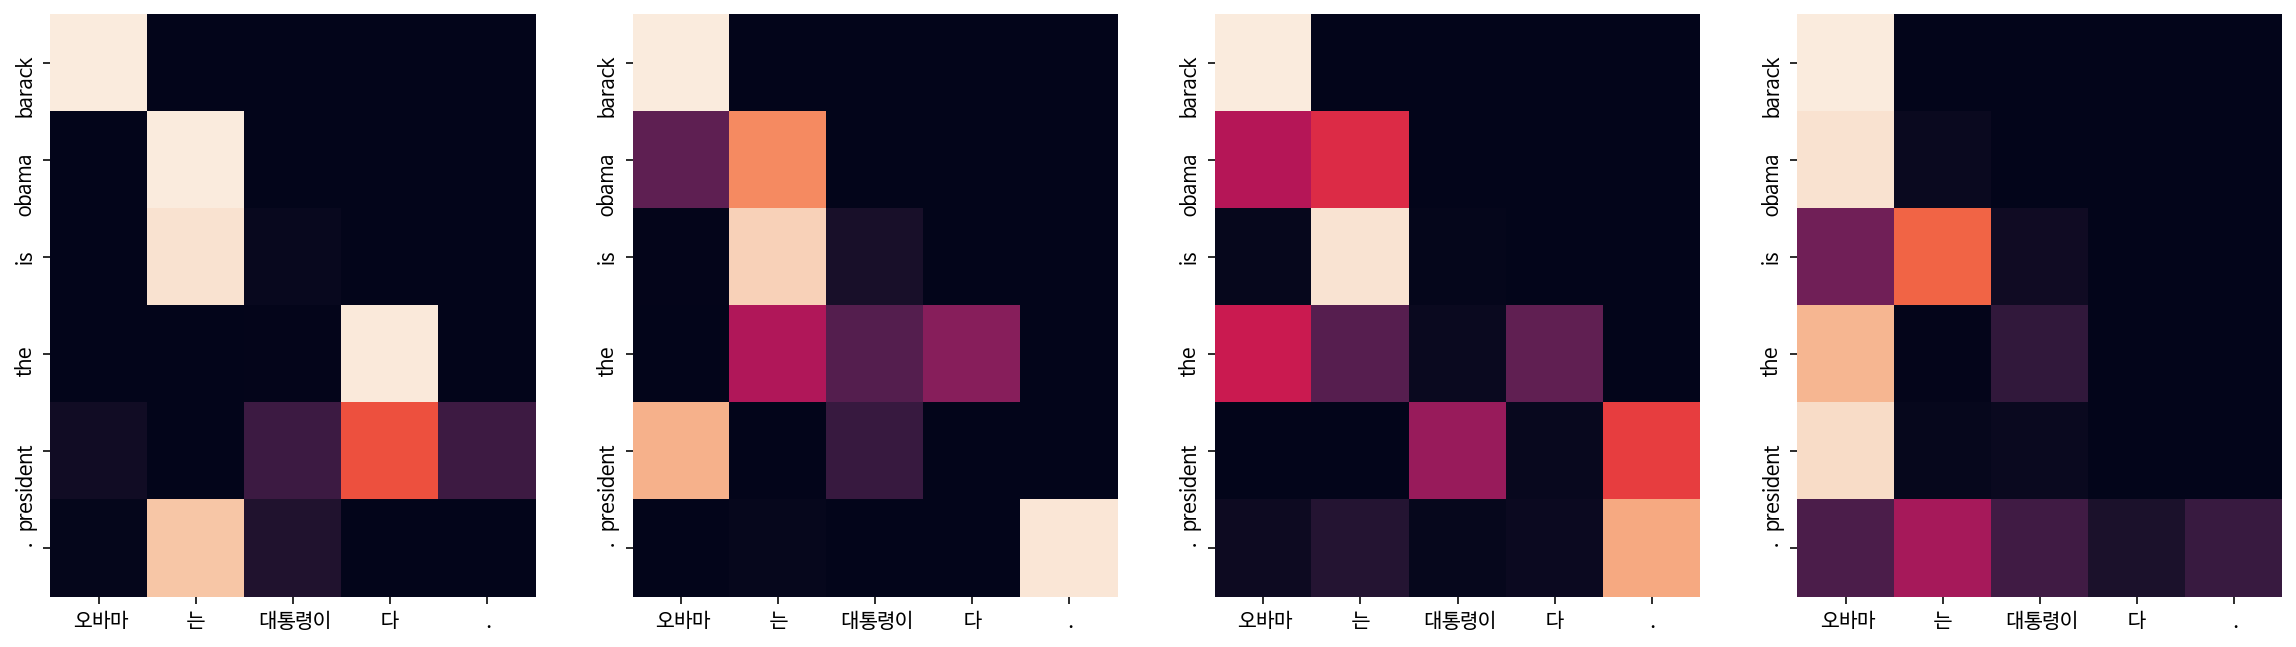



------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : there are a city on the street .
------------------------------
Encoder Layer 1


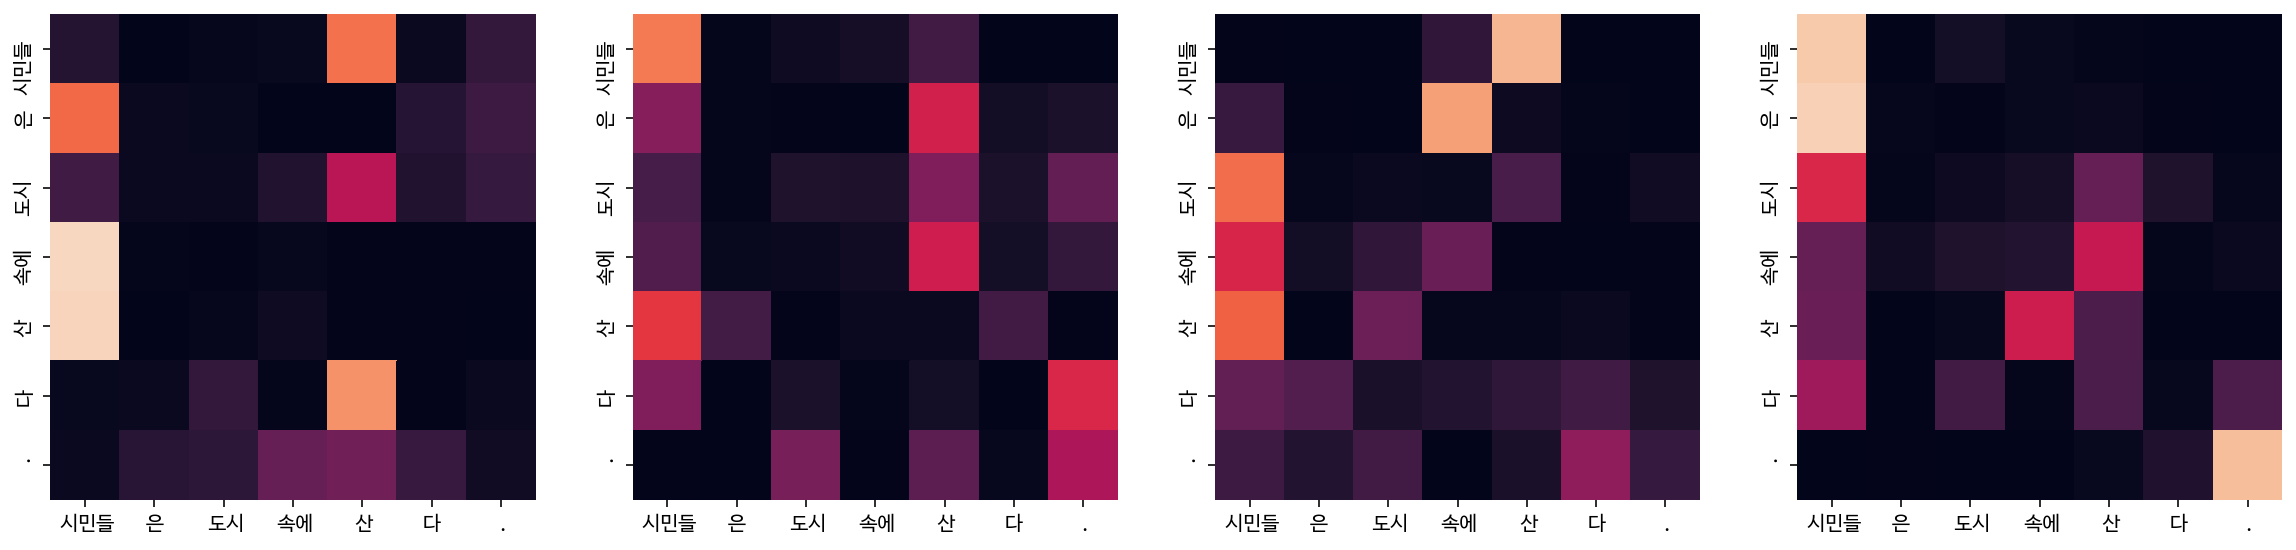

Encoder Layer 2


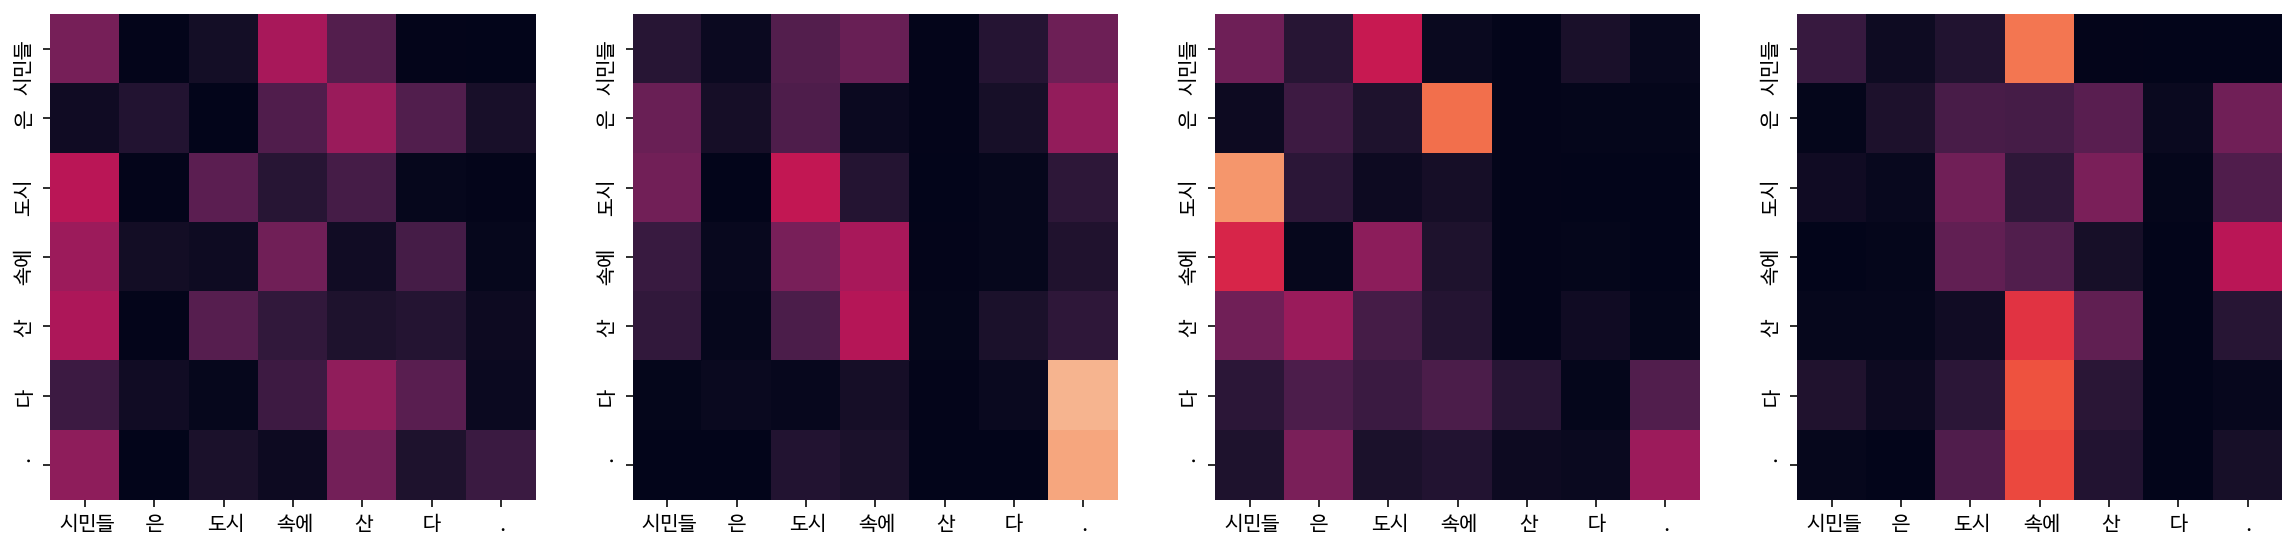

Decoder Self Layer 1


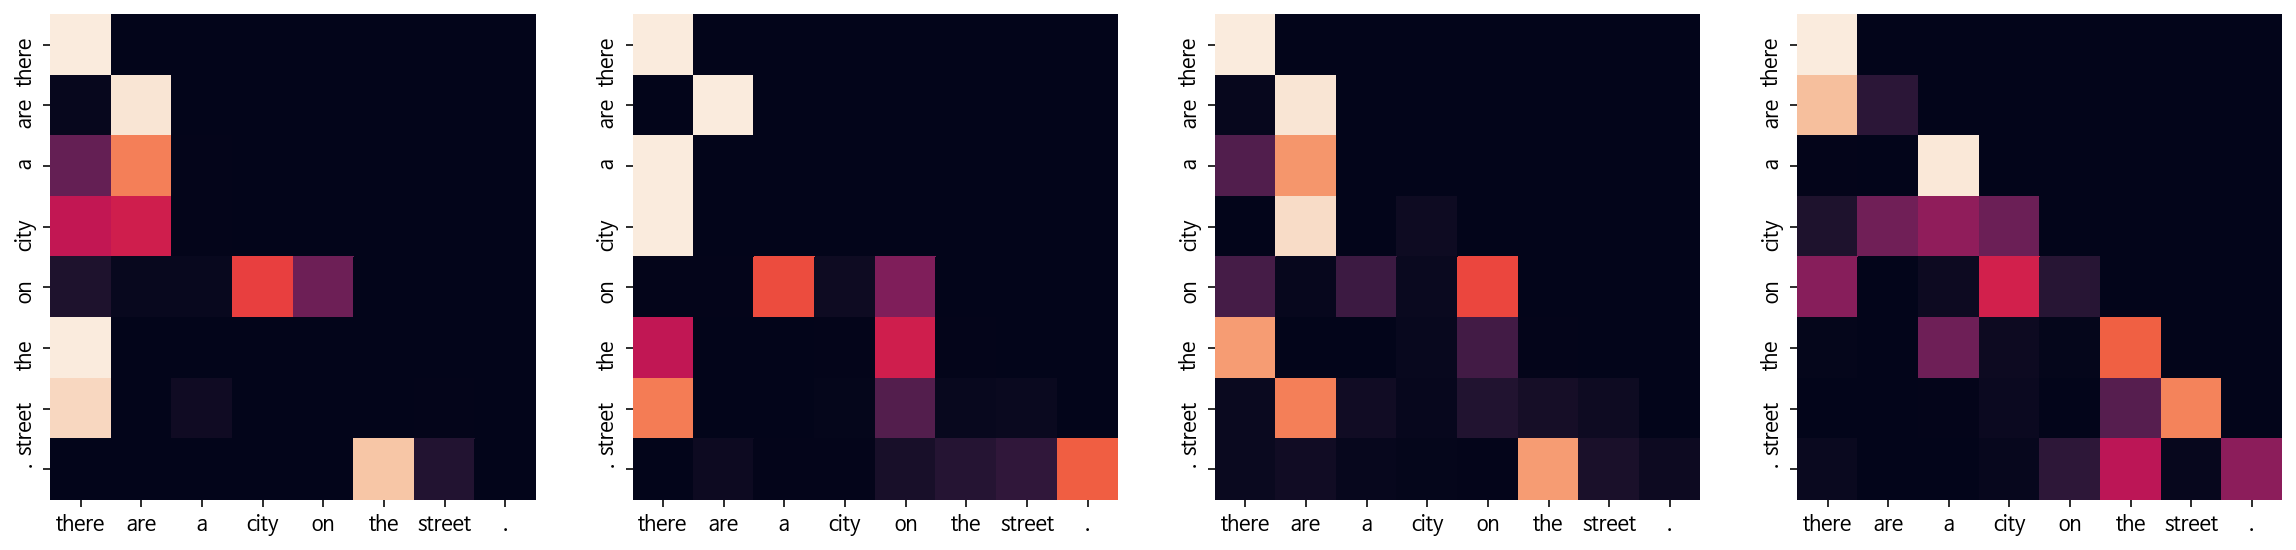

Decoder Src Layer 1


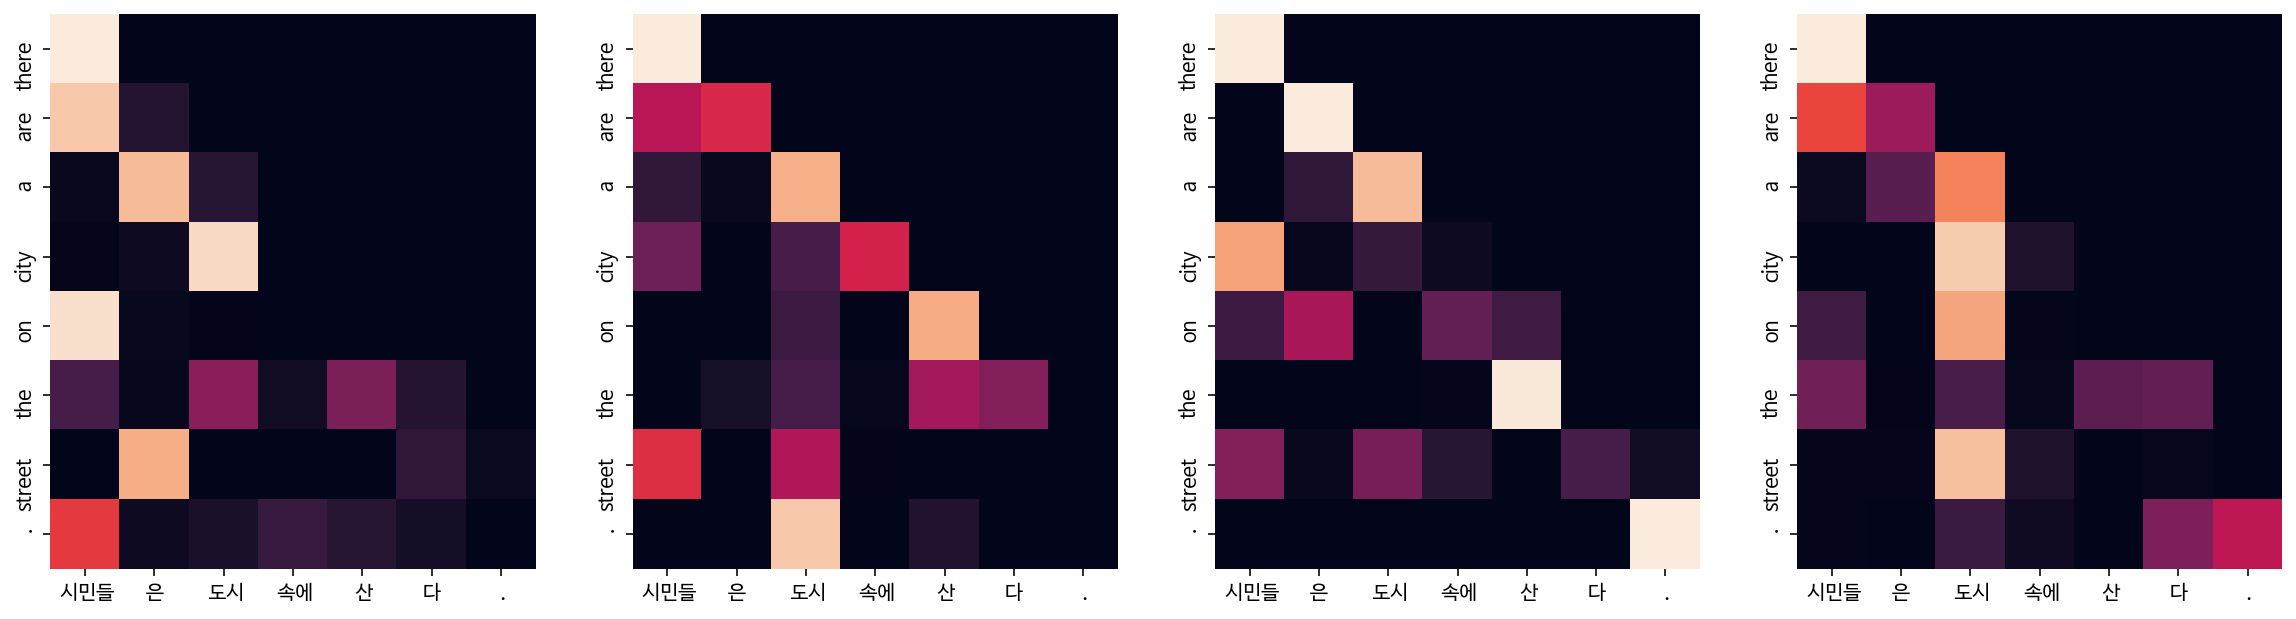

Decoder Self Layer 2


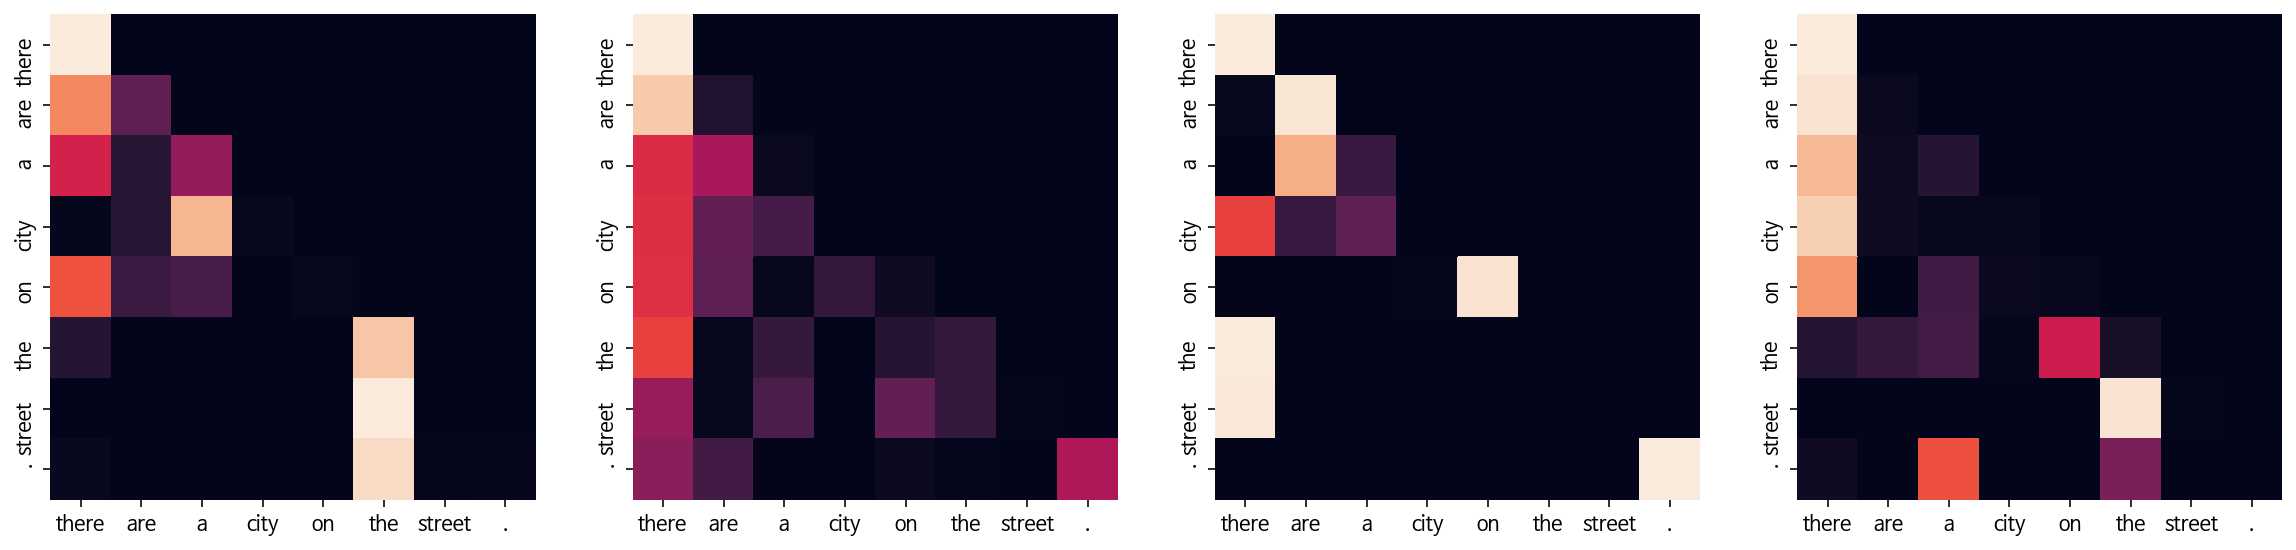

Decoder Src Layer 2


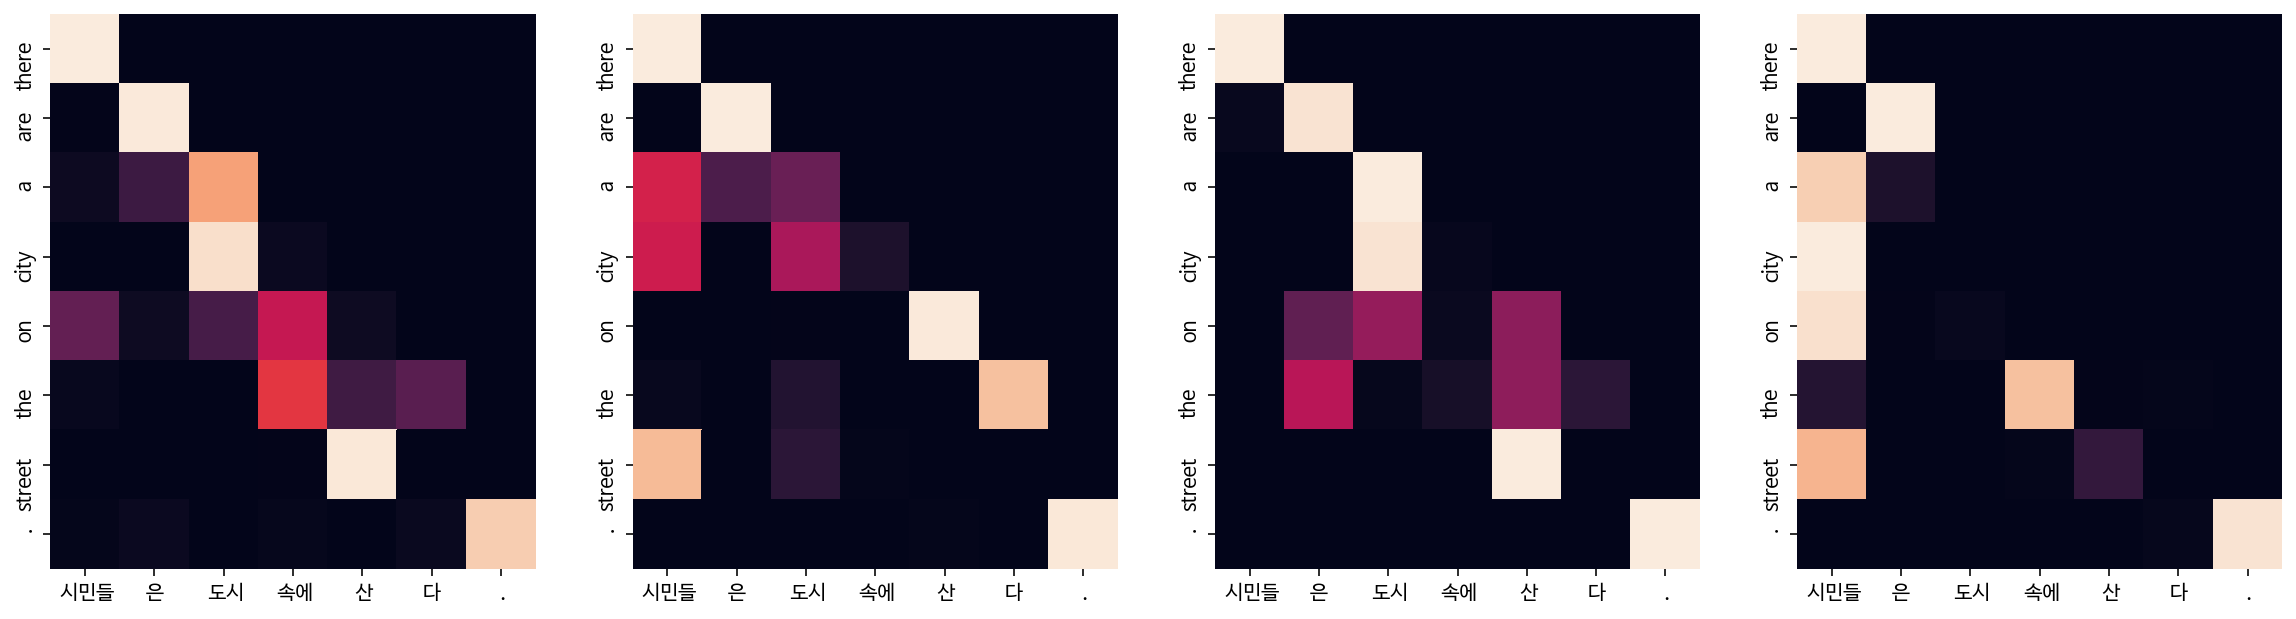



------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s not too .
------------------------------
Encoder Layer 1


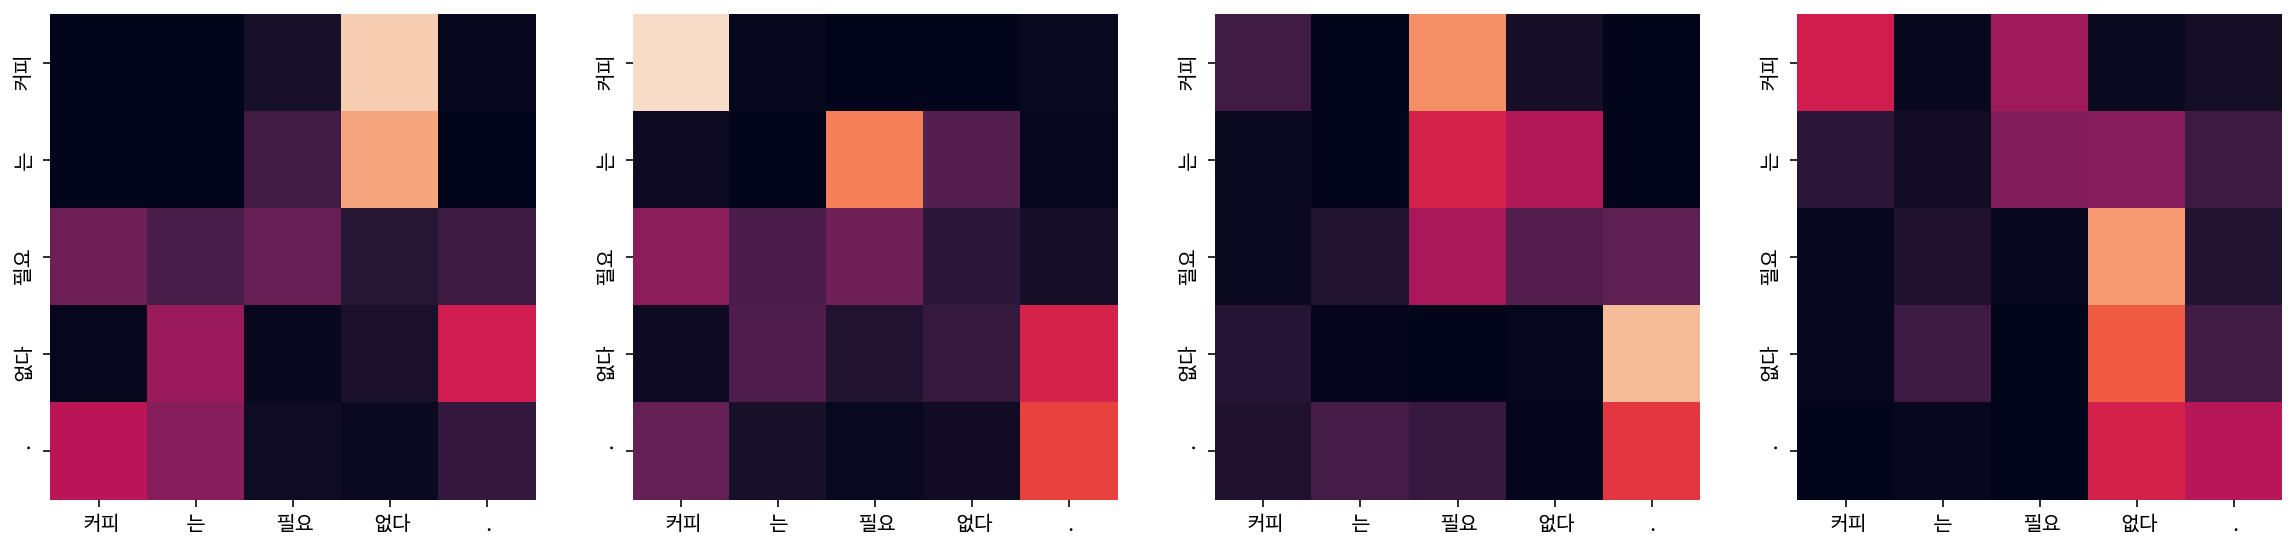

Encoder Layer 2


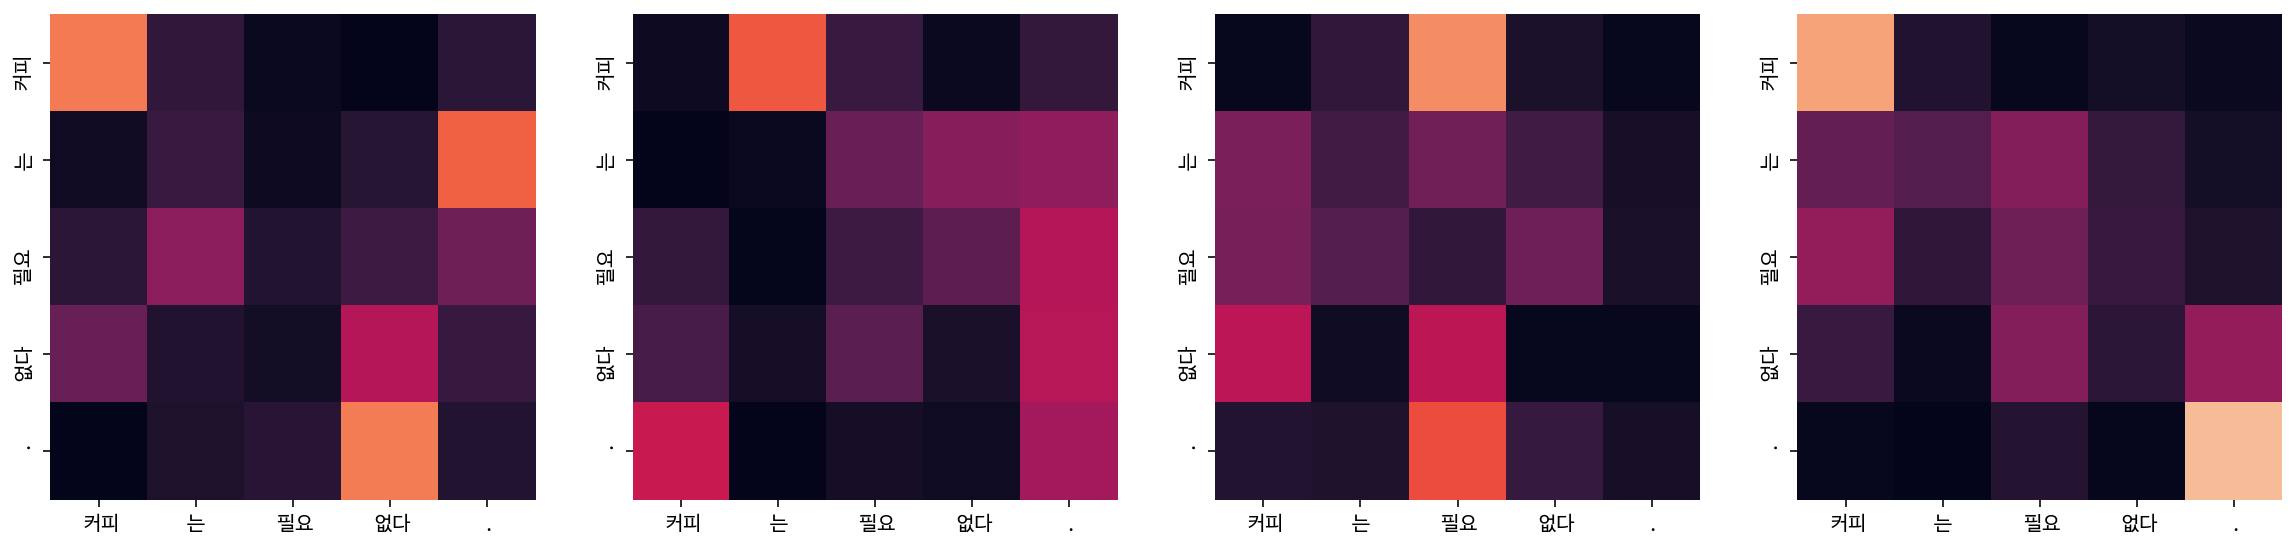

Decoder Self Layer 1


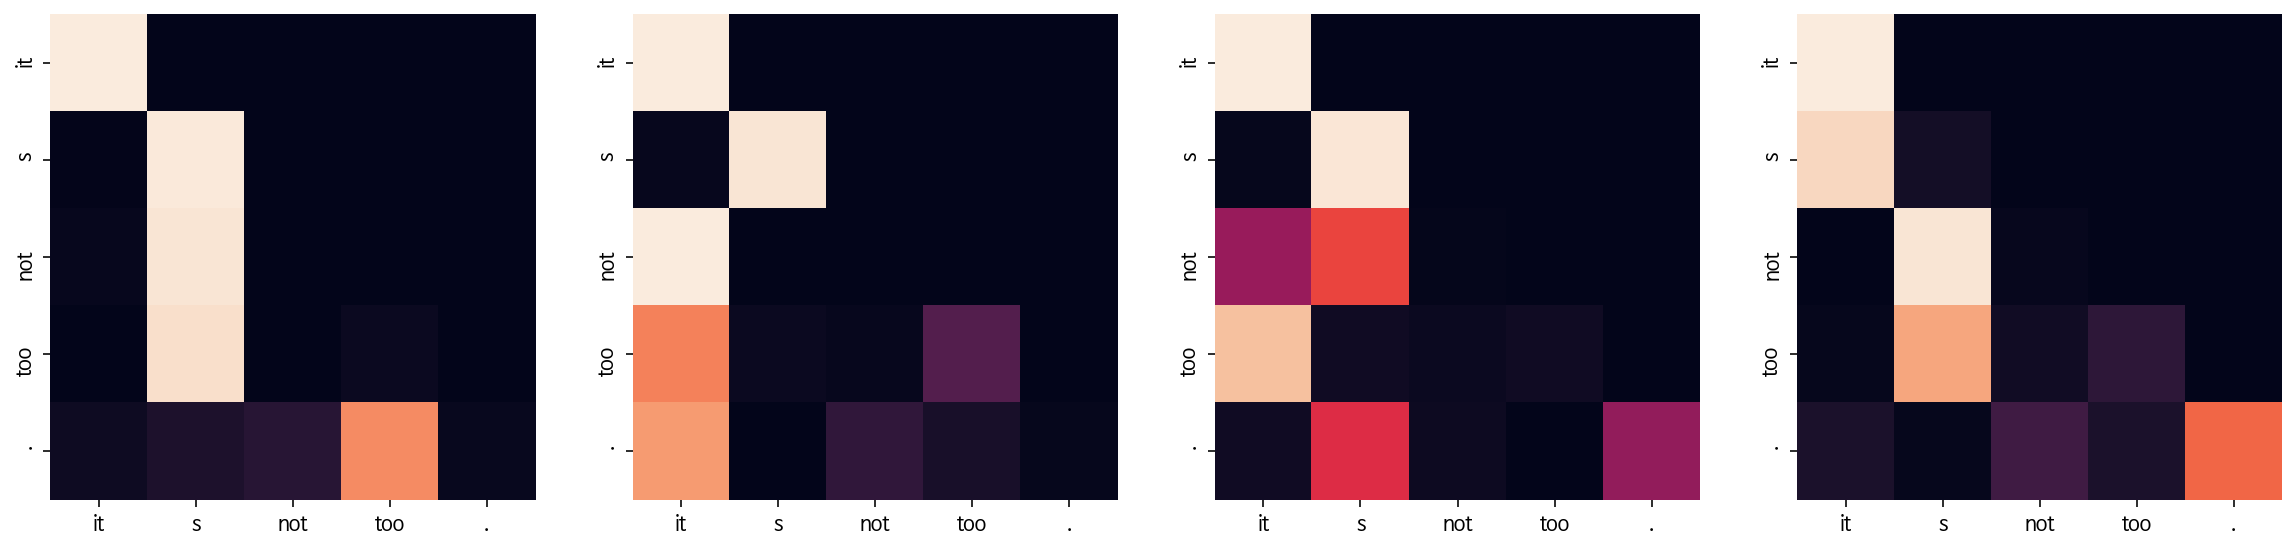

Decoder Src Layer 1


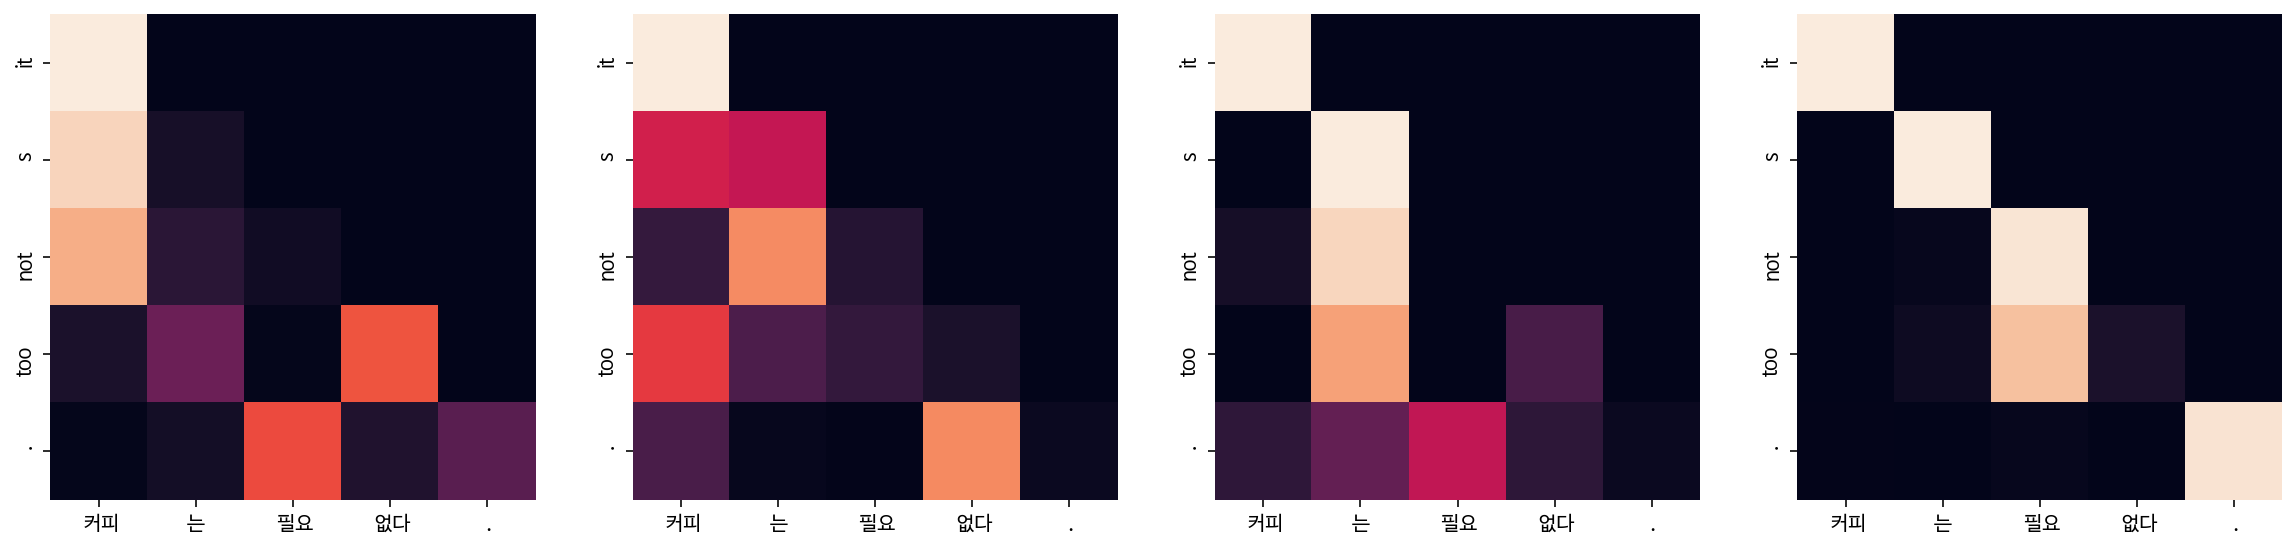

Decoder Self Layer 2


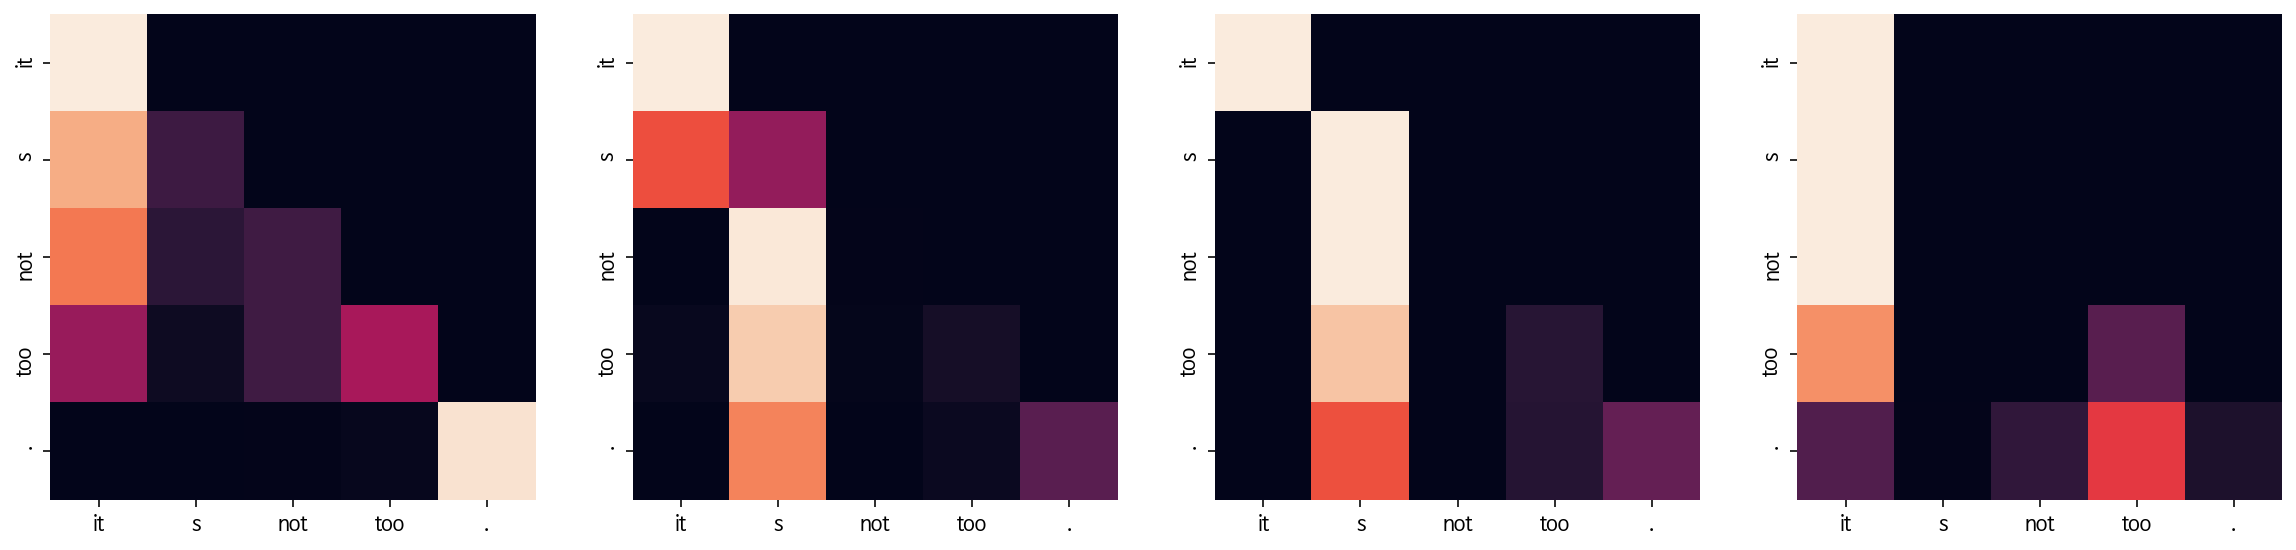

Decoder Src Layer 2


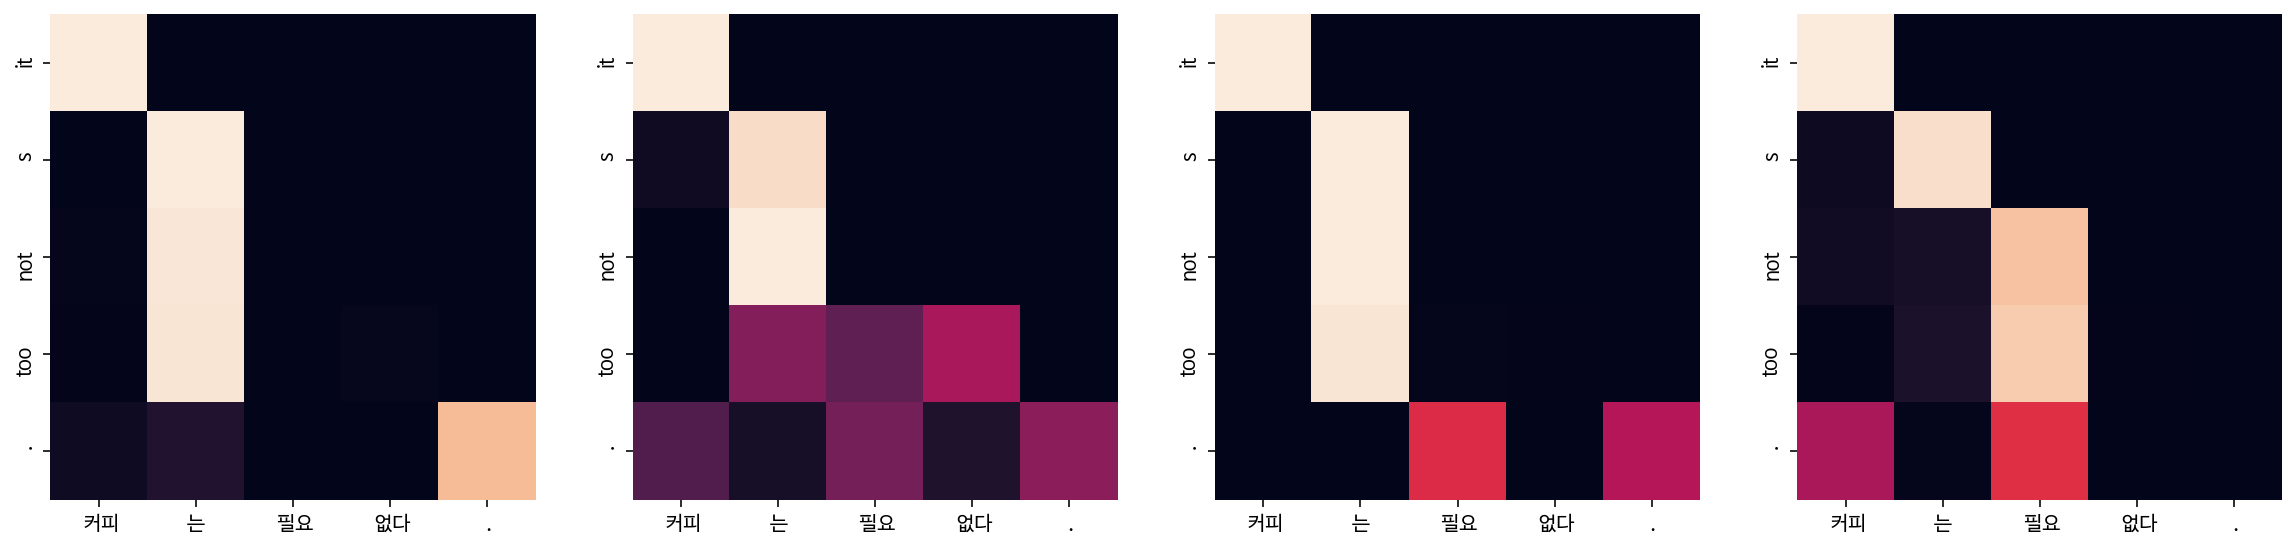



------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the death was found dead .
------------------------------
Encoder Layer 1


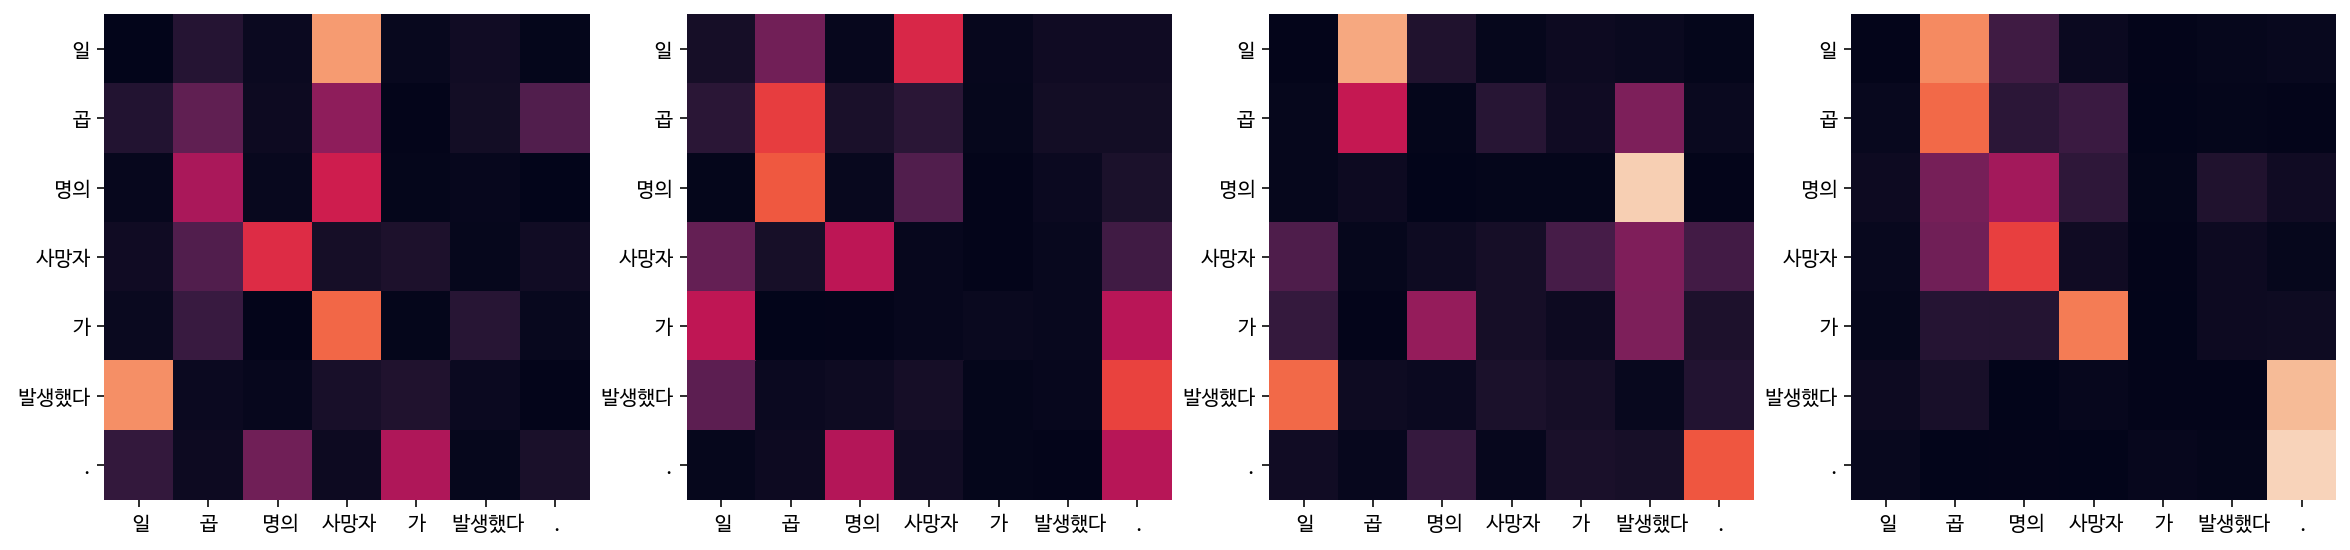

Encoder Layer 2


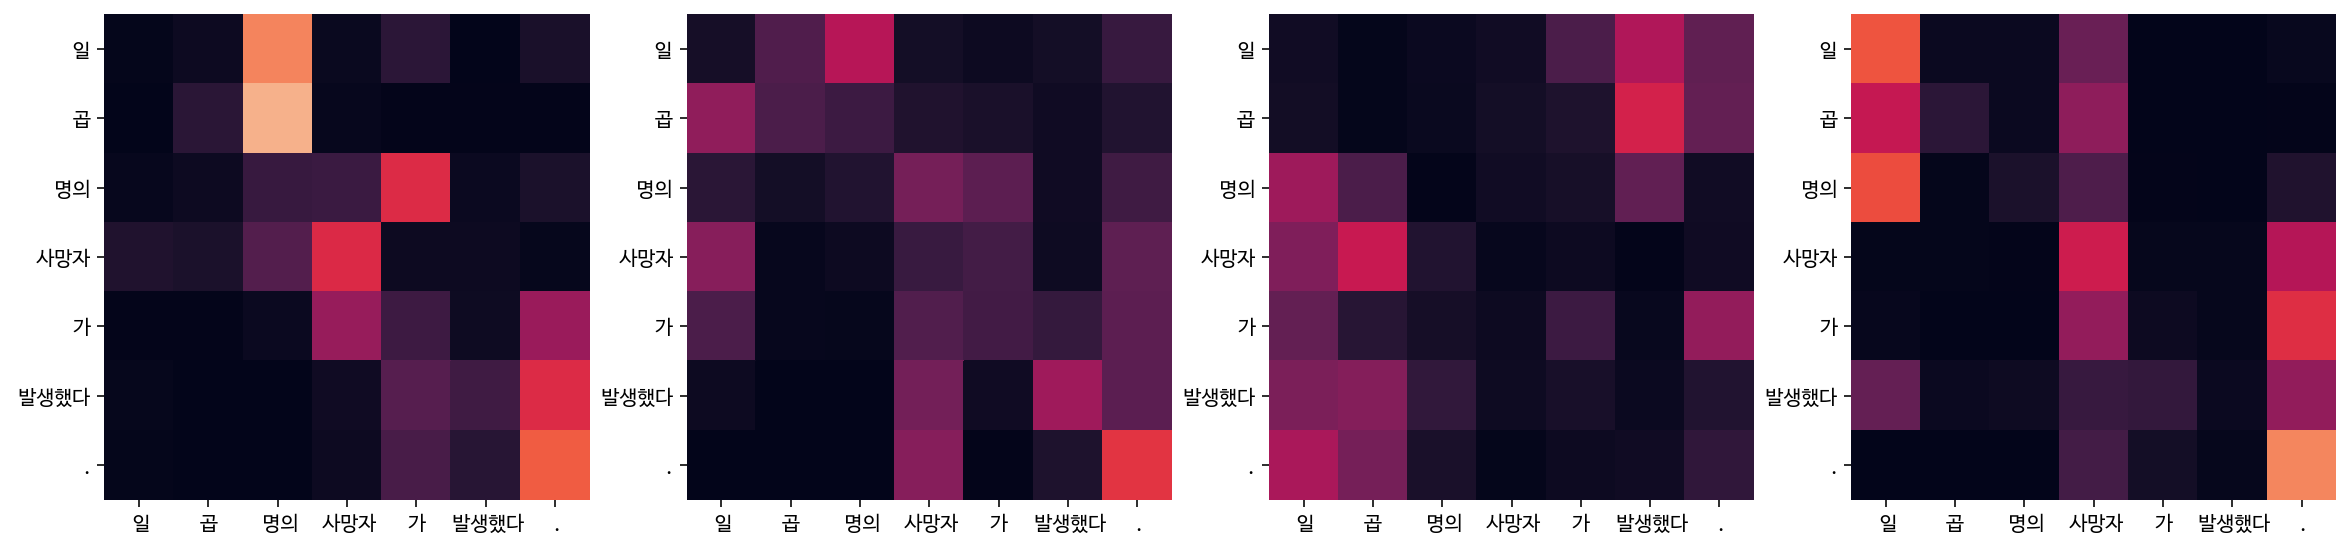

Decoder Self Layer 1


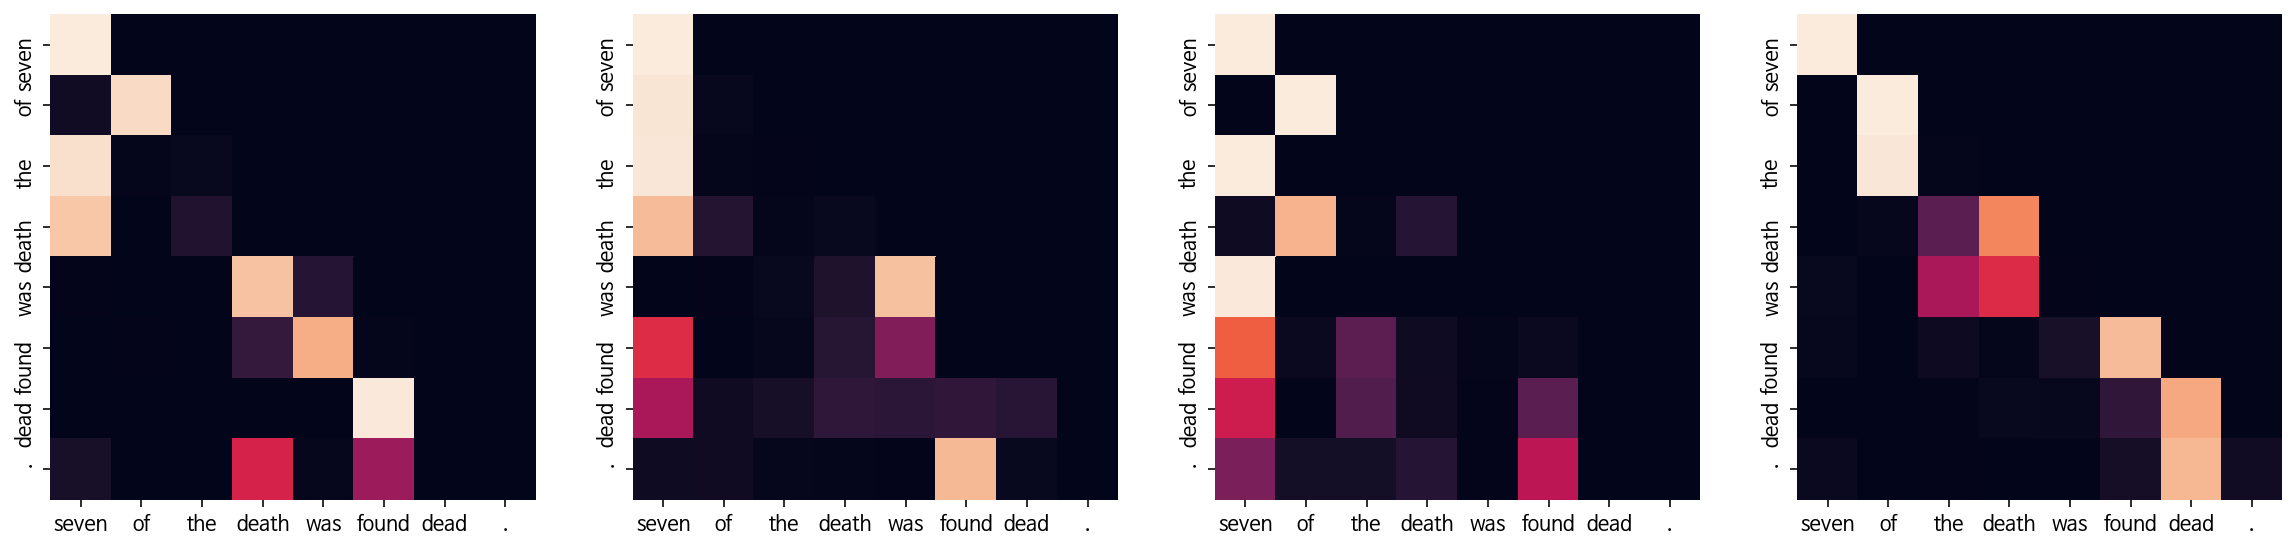

Decoder Src Layer 1


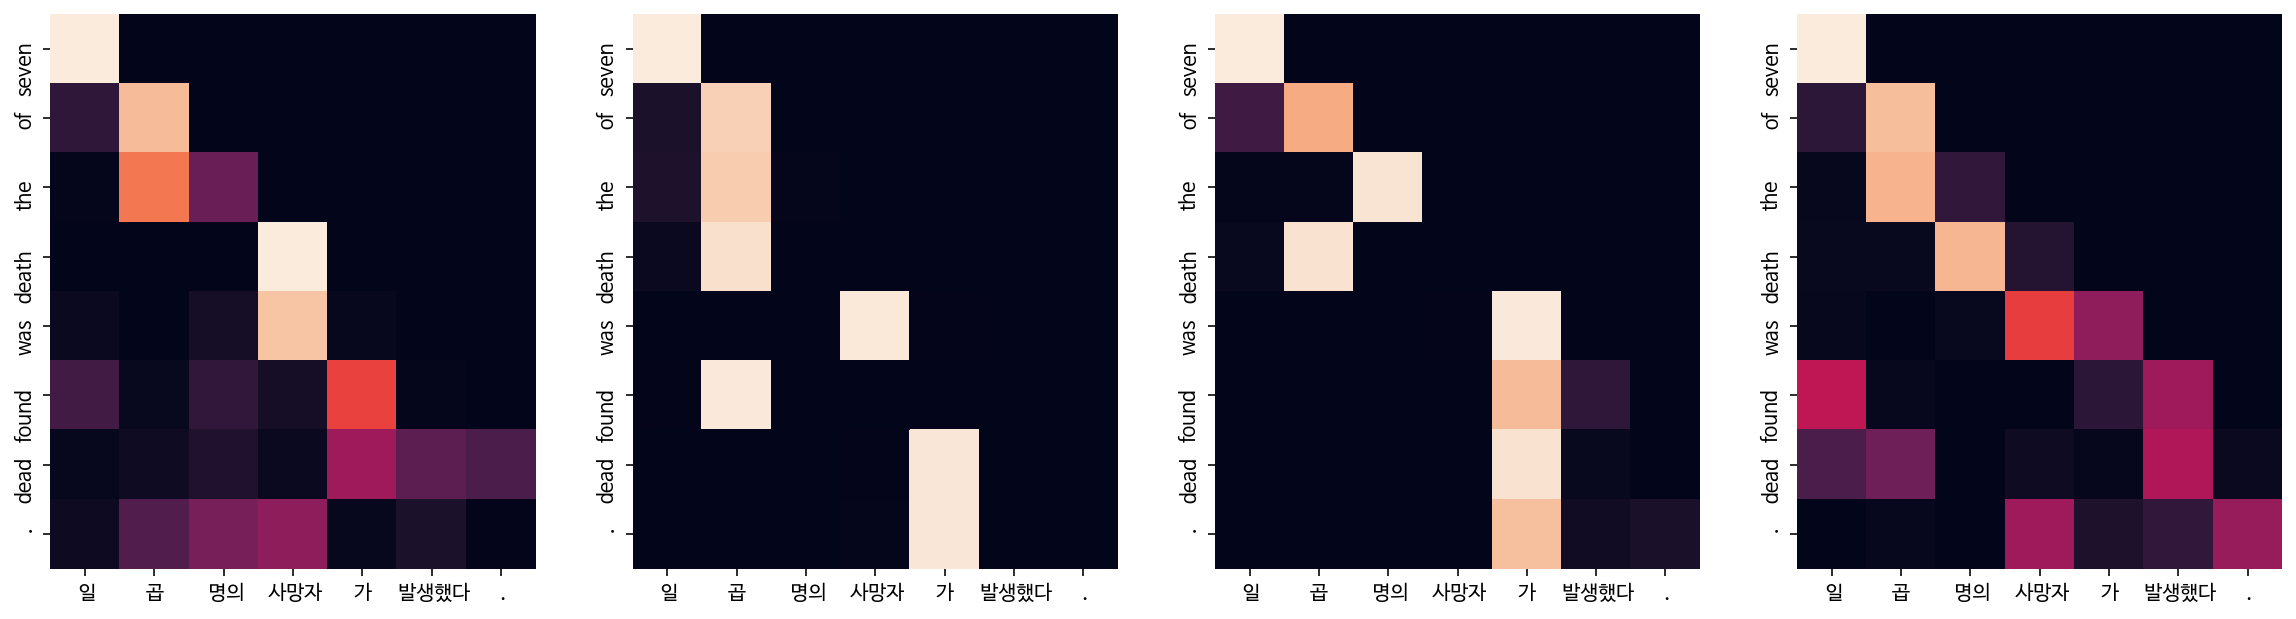

Decoder Self Layer 2


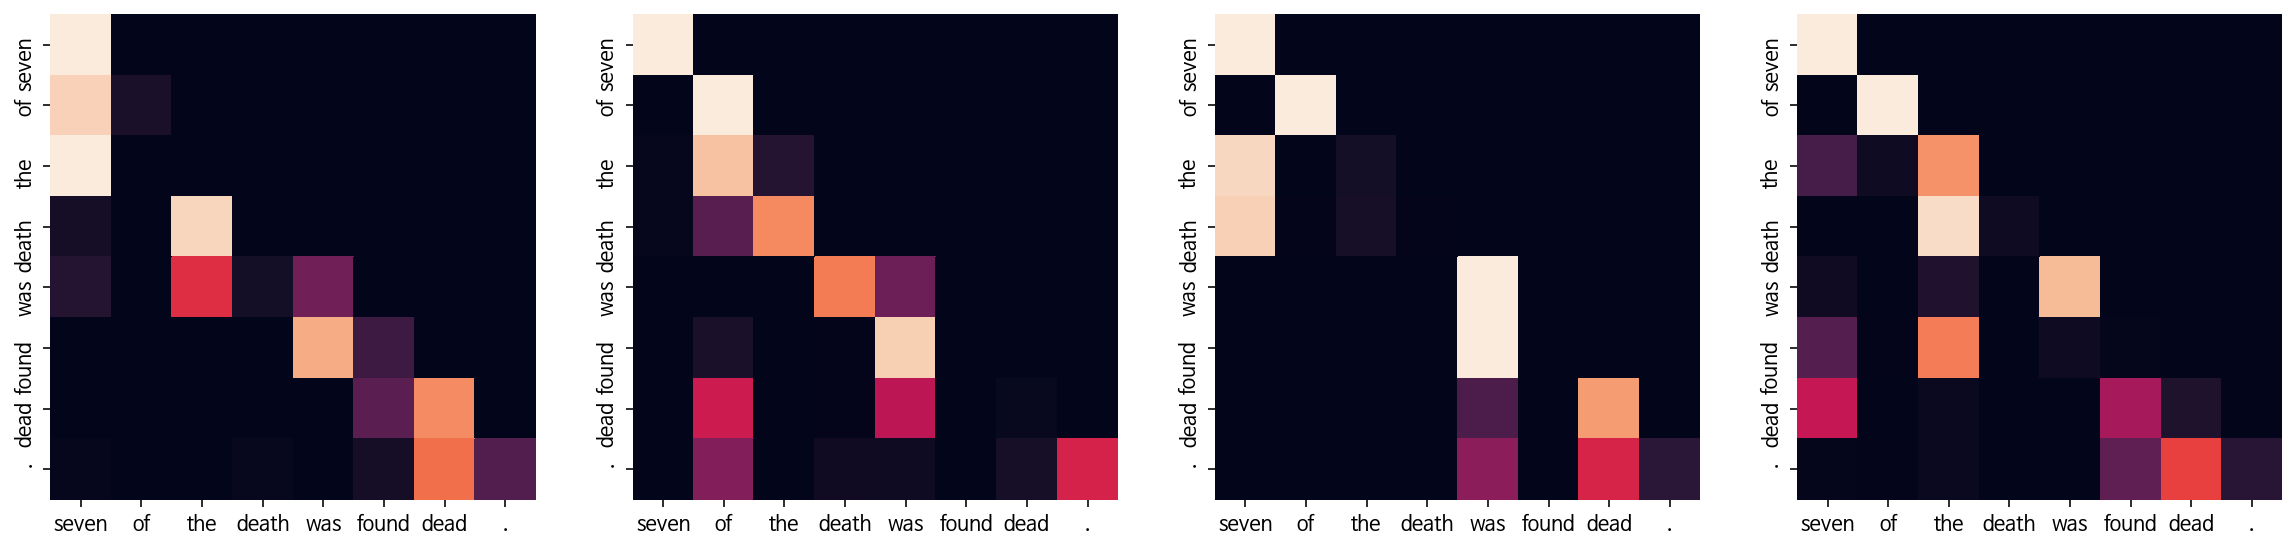

Decoder Src Layer 2


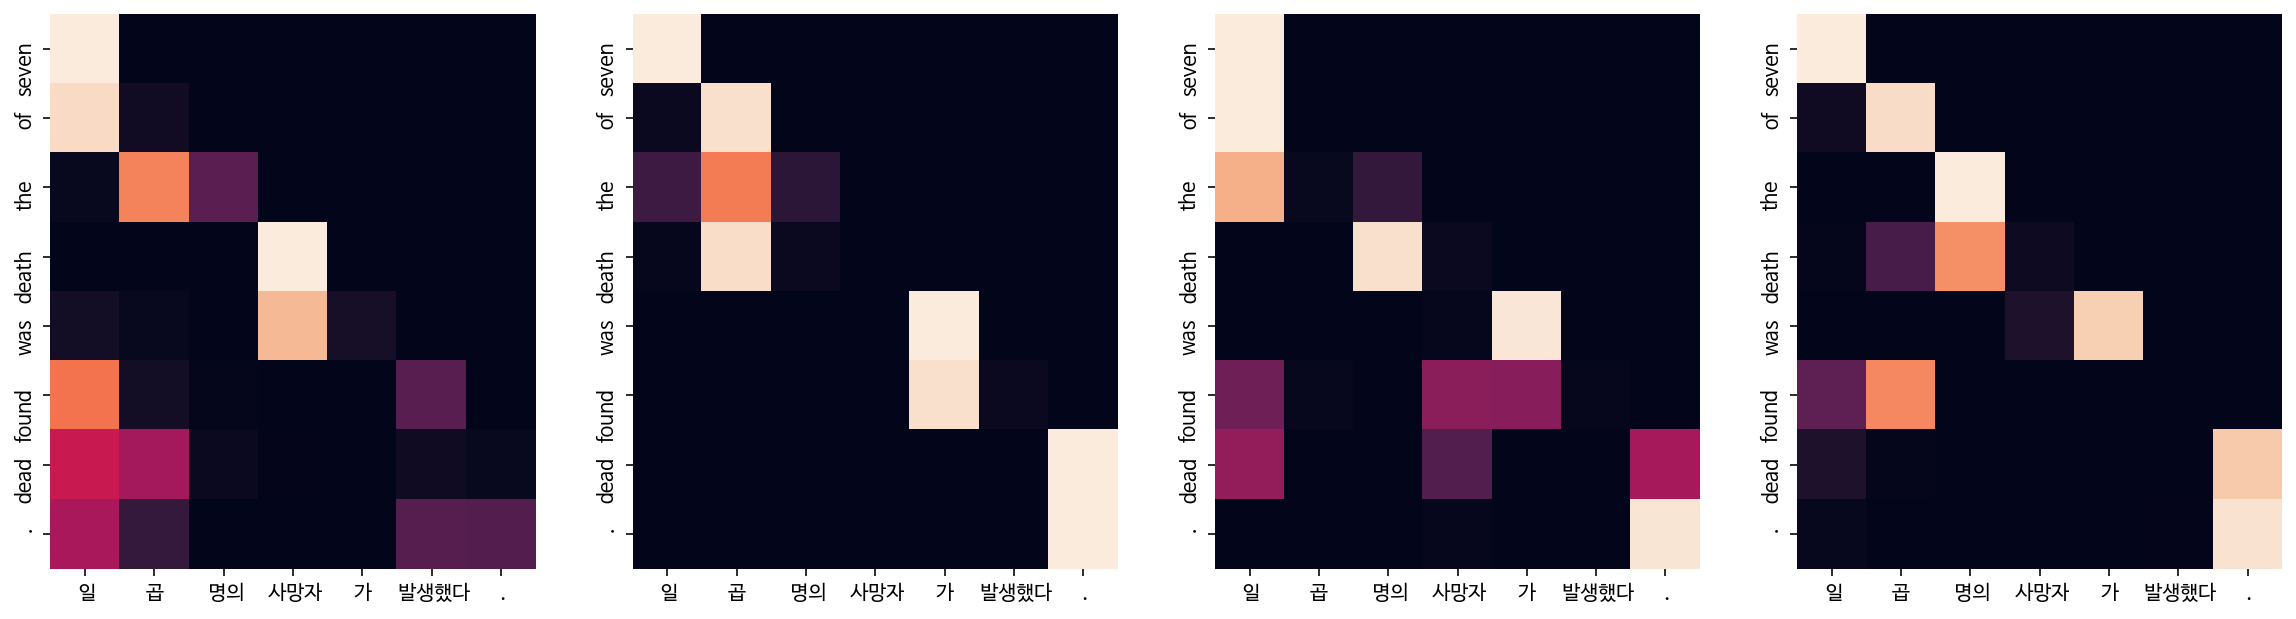

  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  16 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : the president elect is leaving .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : in the city of enjoy a home .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s unclear how a bar is not a coffee .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven deaths in the seven people were killed .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  17 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : the president elect is leaving .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they are locals .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s a bar there . no no need for not be too defused
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven people have been killed .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  18 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : the president elect is leaving .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : there are live .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it was a catch of coffee .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the death was found dead .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  19 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : the president elect barack obama is now .
------------------------------


------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : they are local daily .
------------------------------


------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s unclear how do you don t need any bar .
------------------------------


------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the death toll rose to a seven .
------------------------------




  0%|          | 0/1166 [00:00<?, ?it/s]

-----------------  20 epoch  -----------------
------------------------------
입력 문장 : 오바마는 대통령이다.
번역 후 예측 문장 : the president is barack obama s pick .
------------------------------
Encoder Layer 1


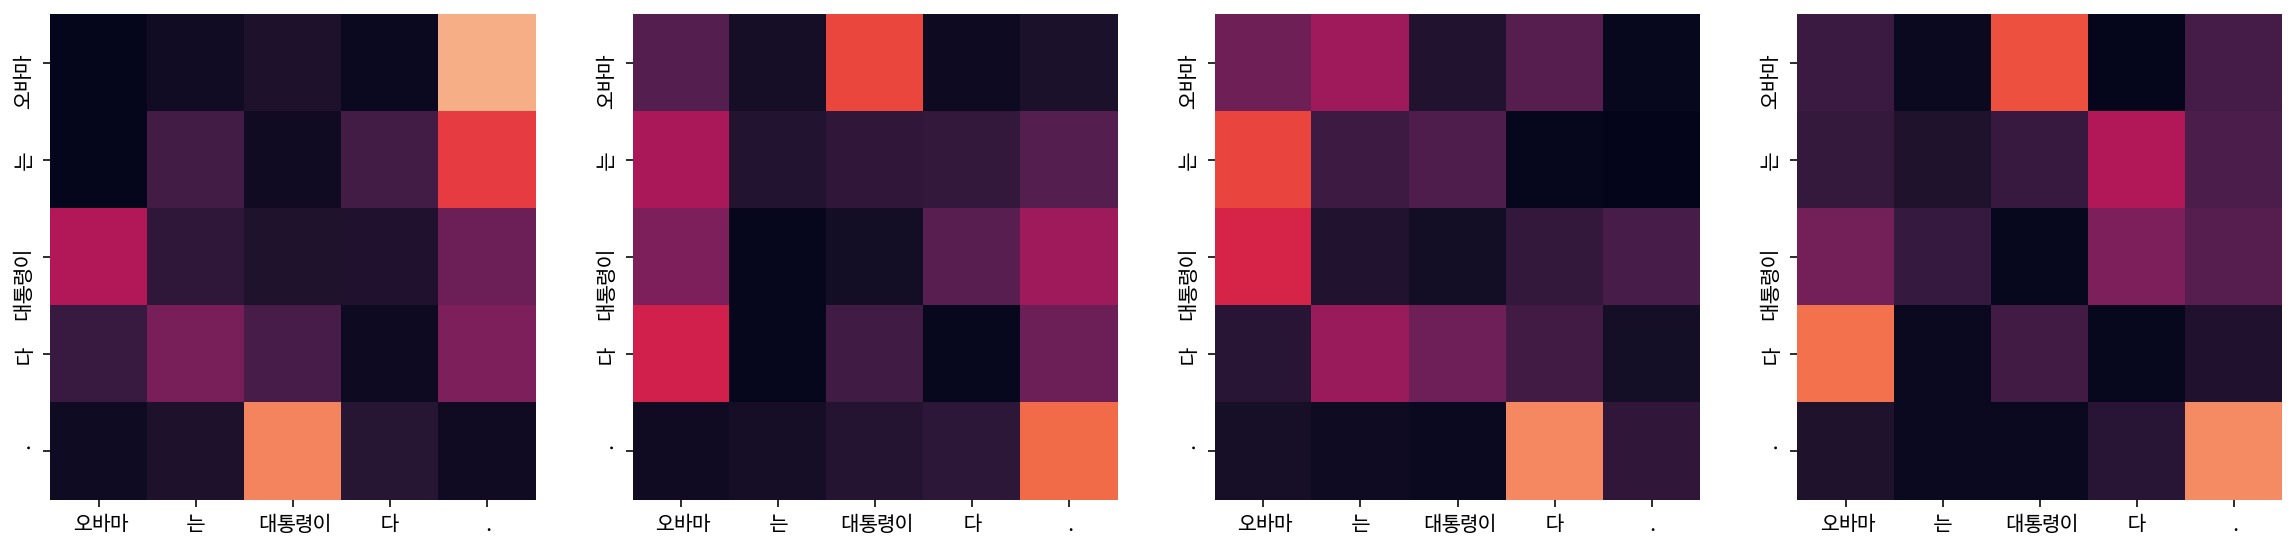

Encoder Layer 2


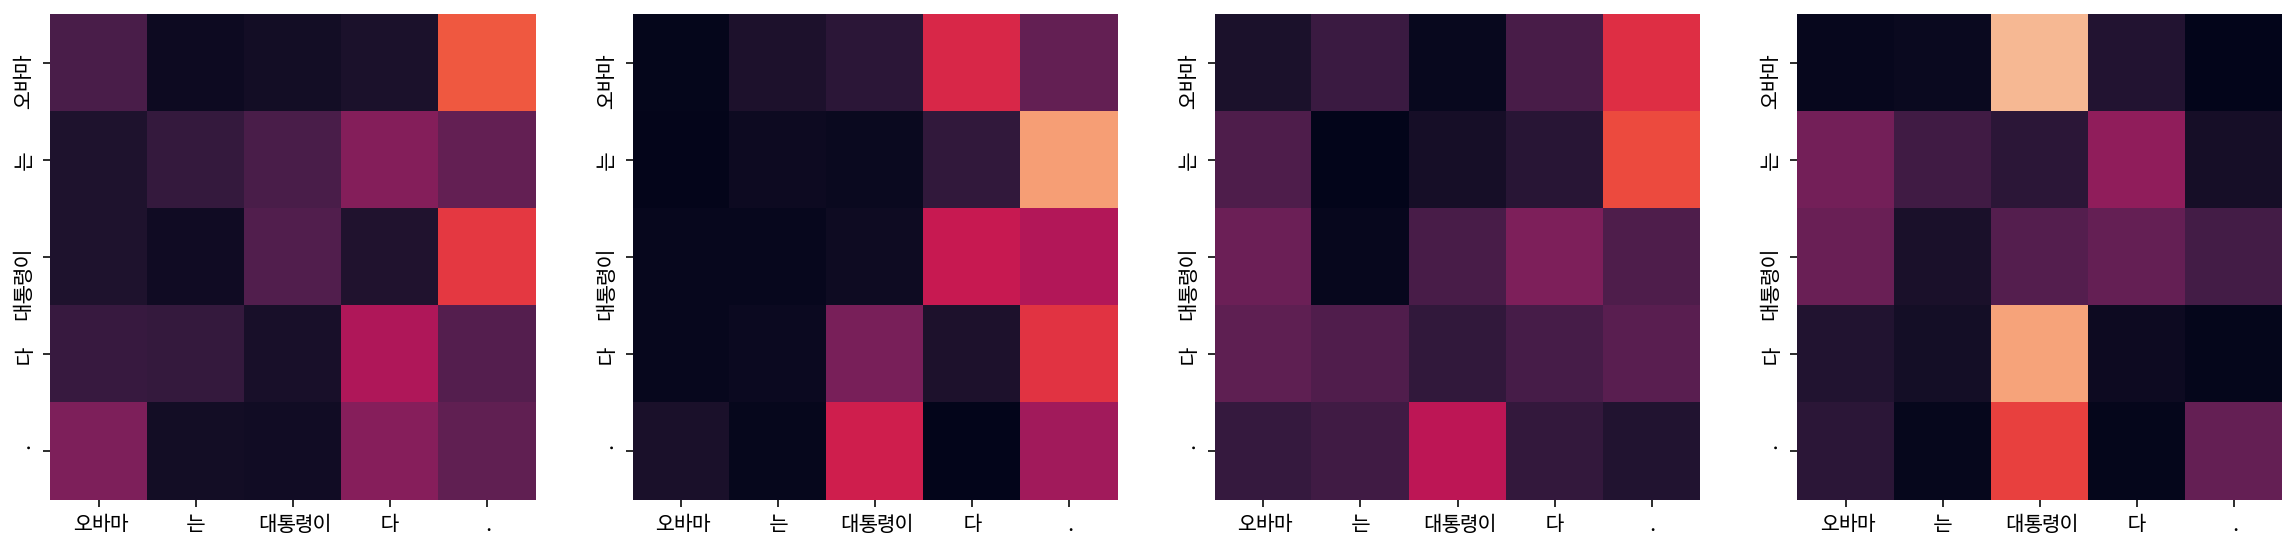

Decoder Self Layer 1


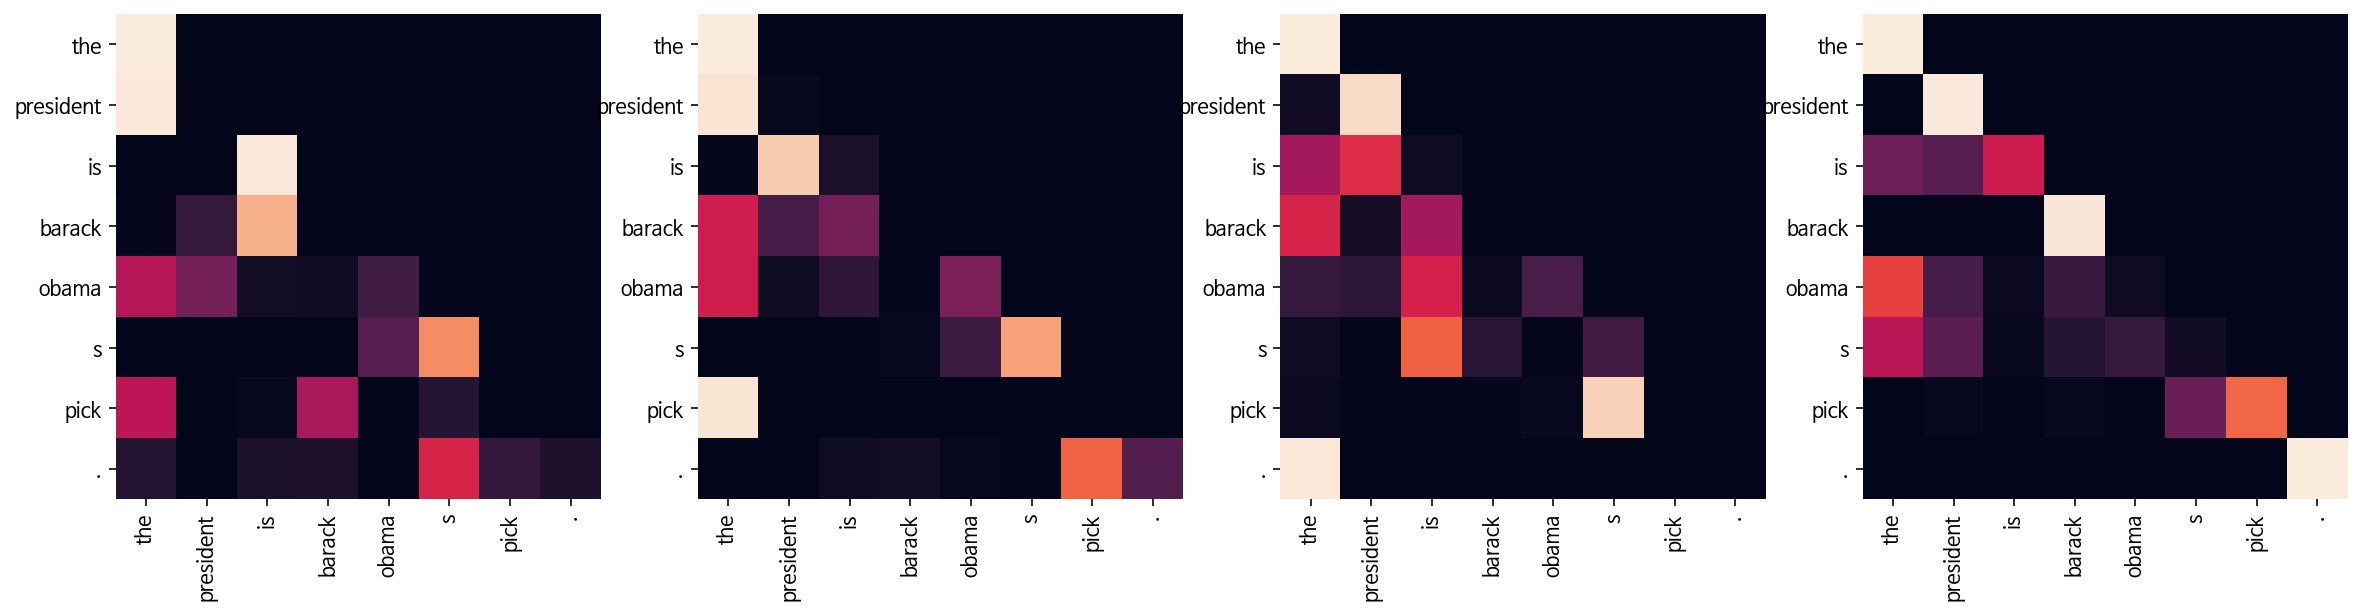

Decoder Src Layer 1


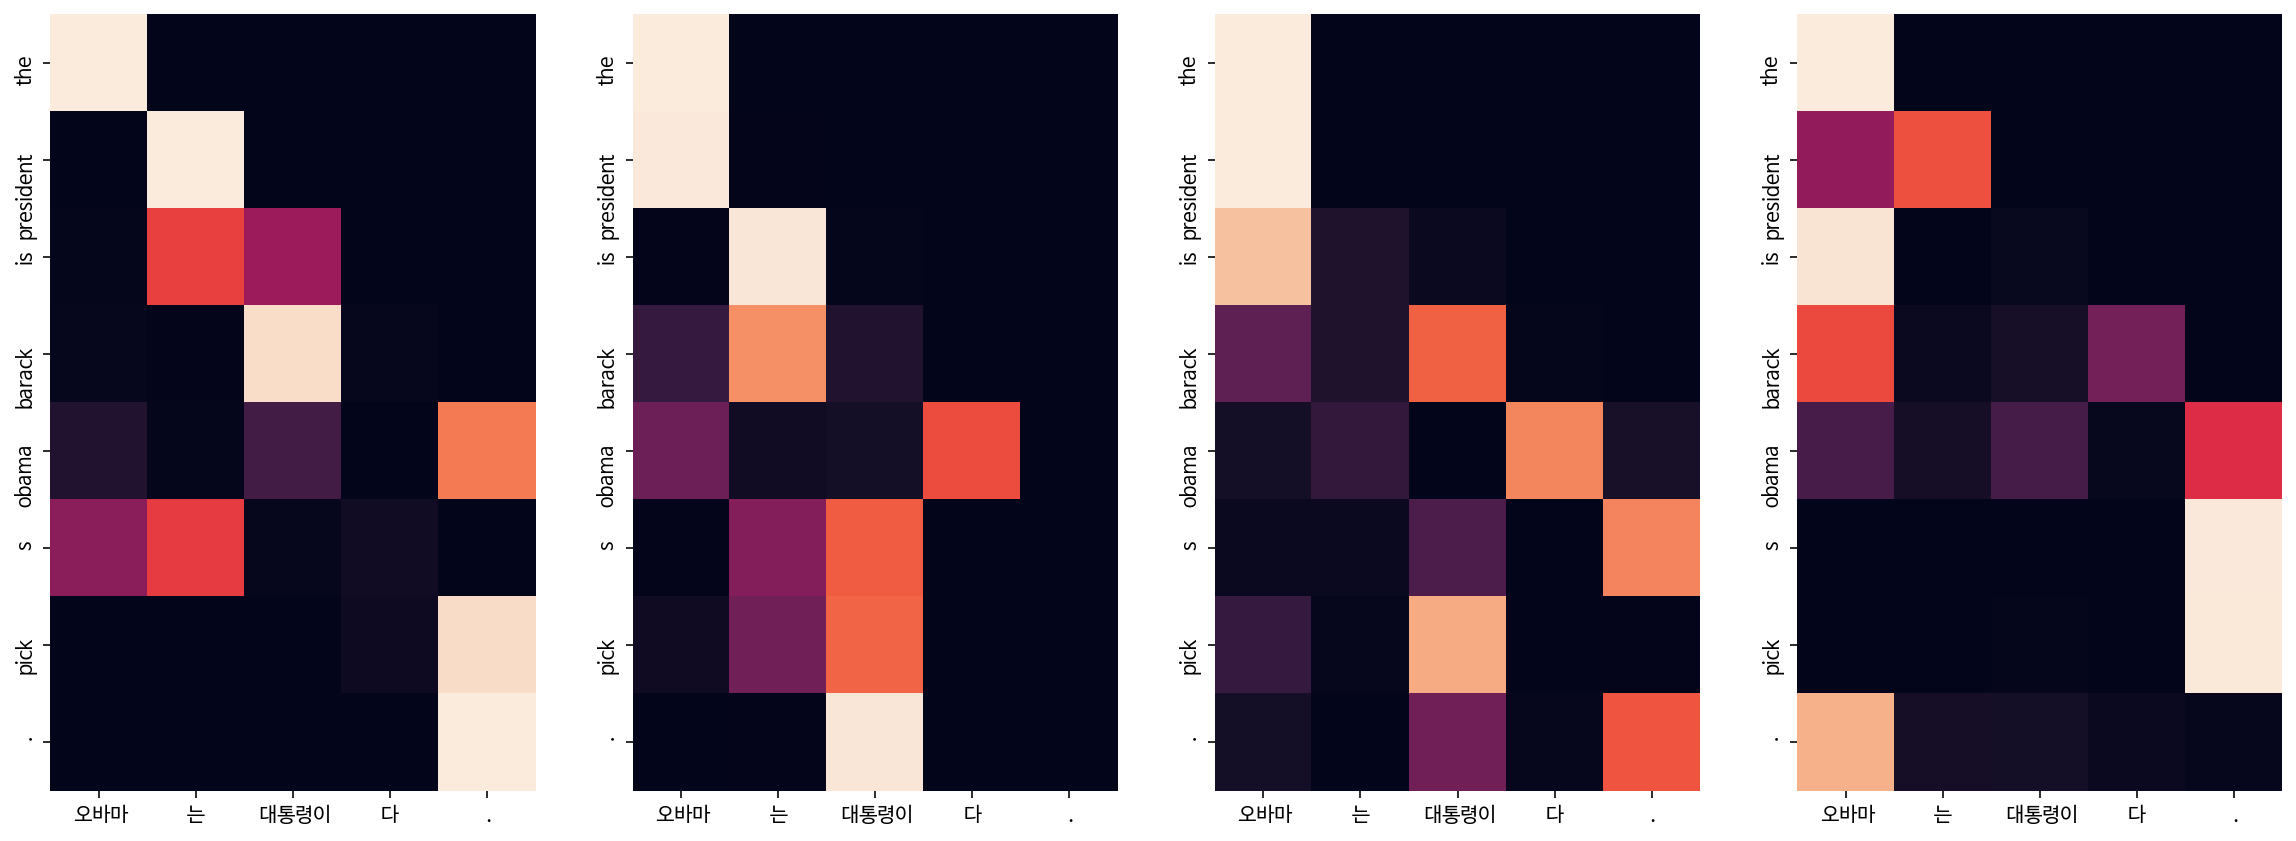

Decoder Self Layer 2


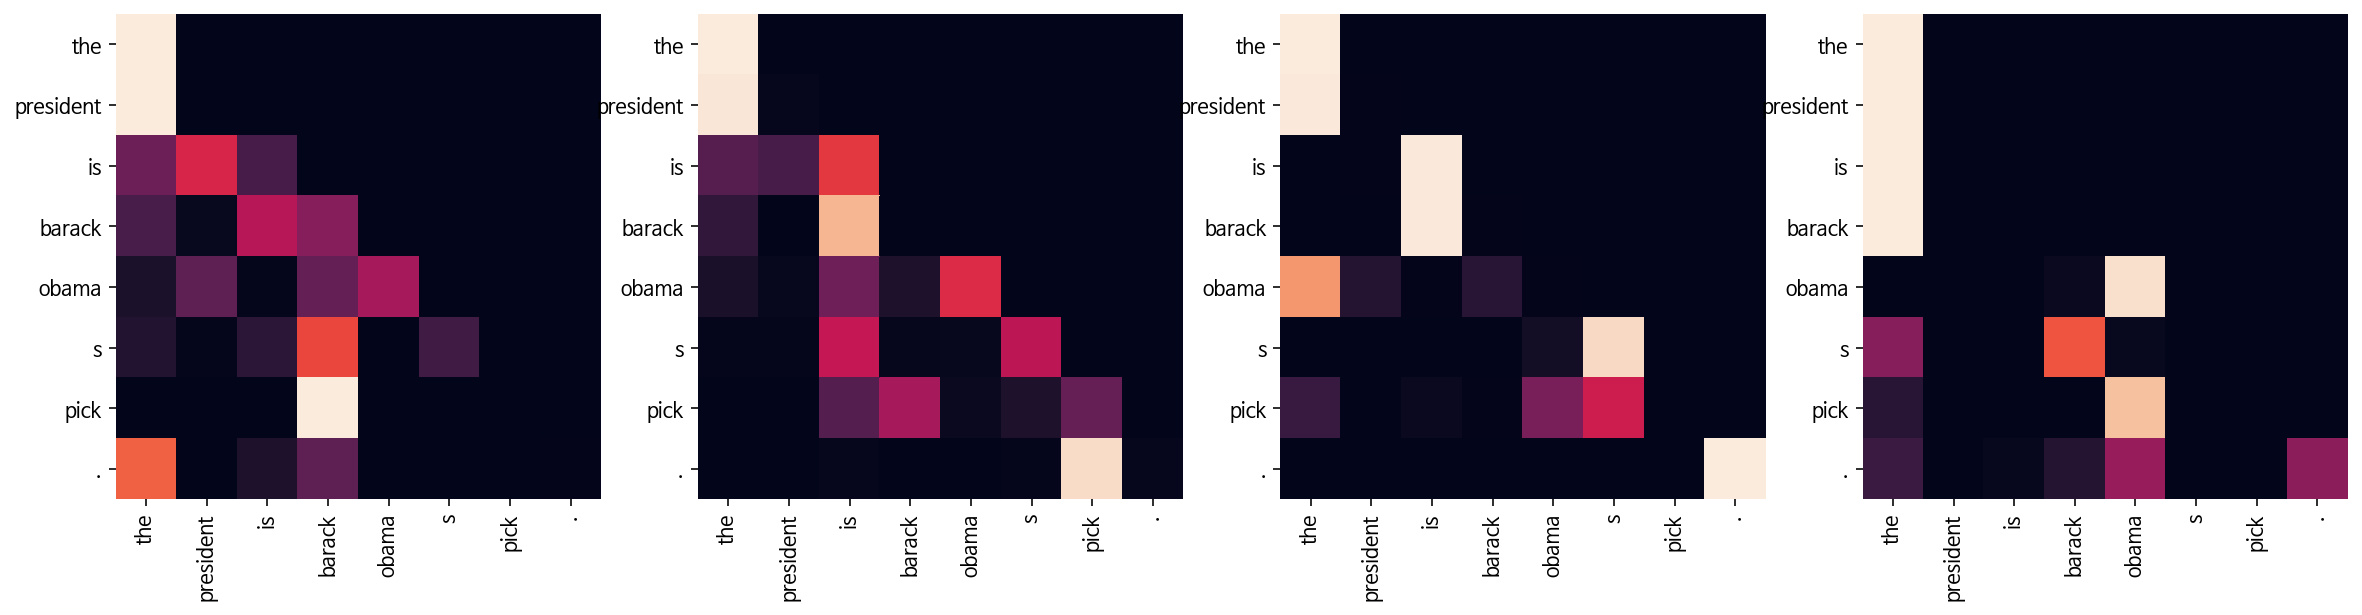

Decoder Src Layer 2


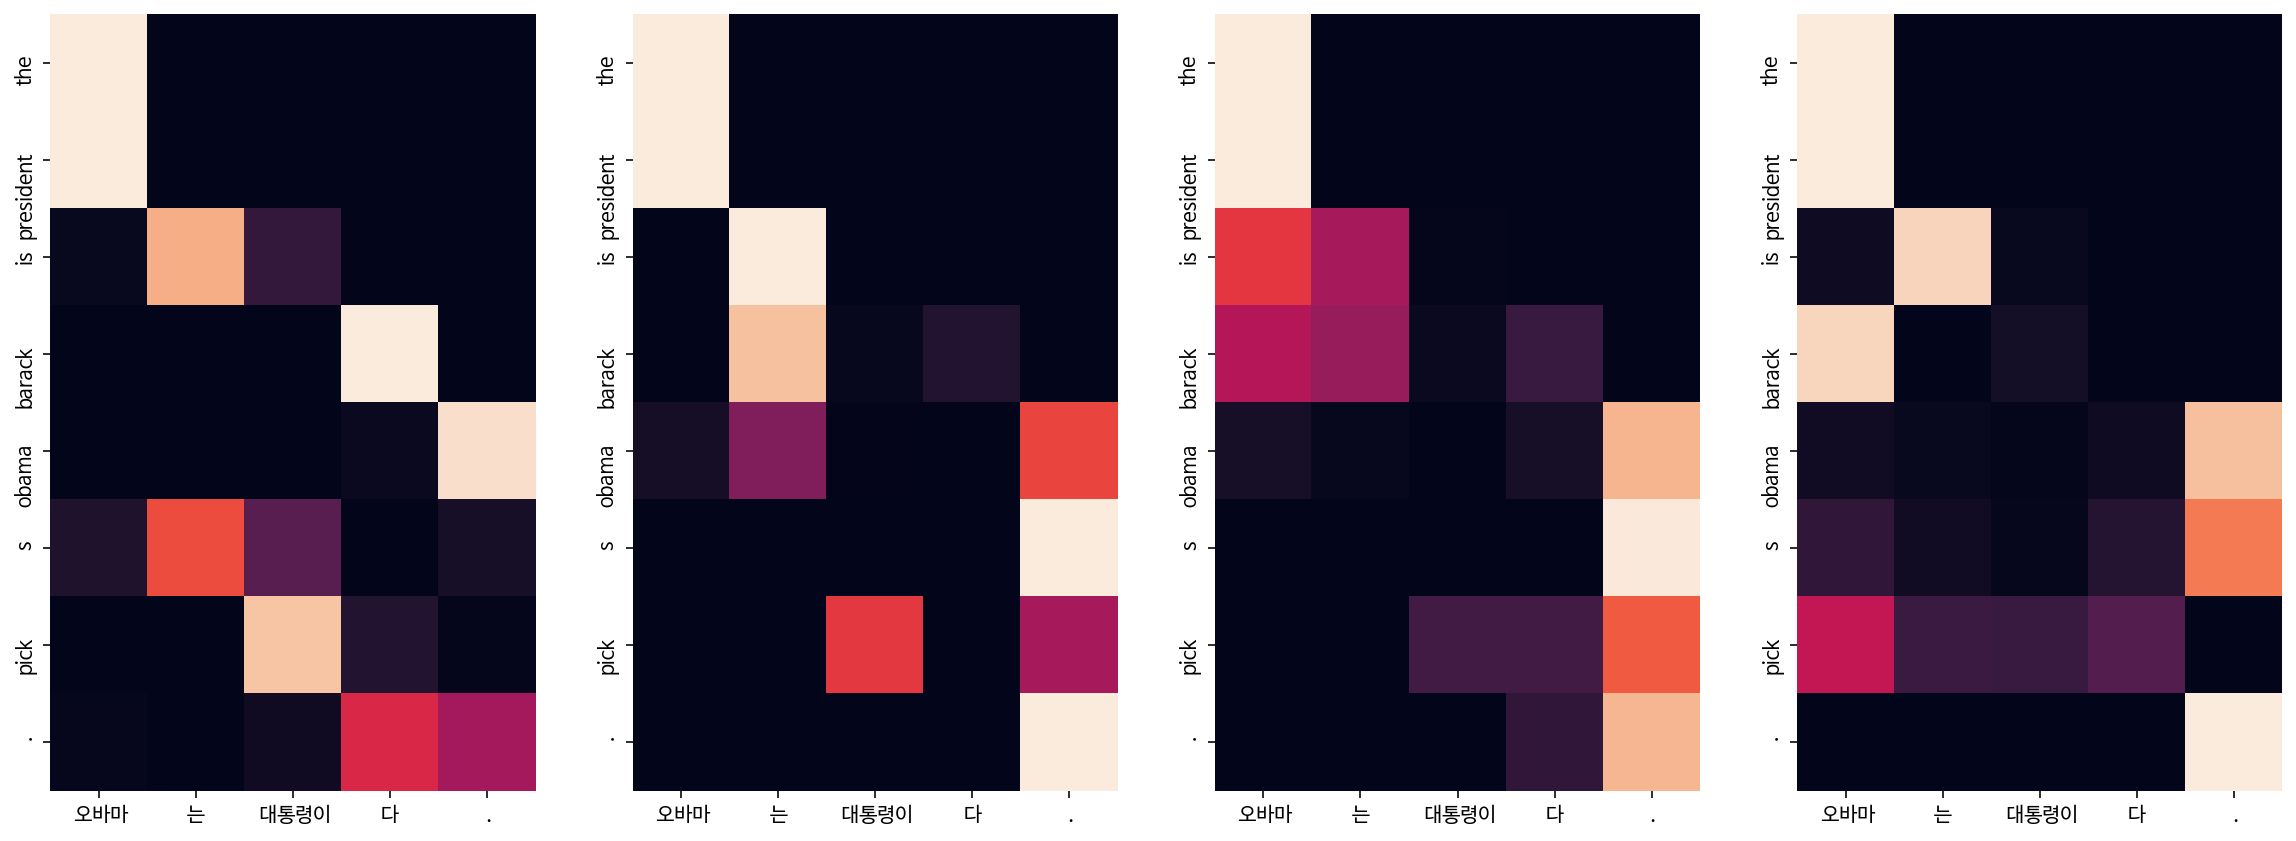



------------------------------
입력 문장 : 시민들은 도시 속에 산다.
번역 후 예측 문장 : there are a local in the home of local citizens .
------------------------------
Encoder Layer 1


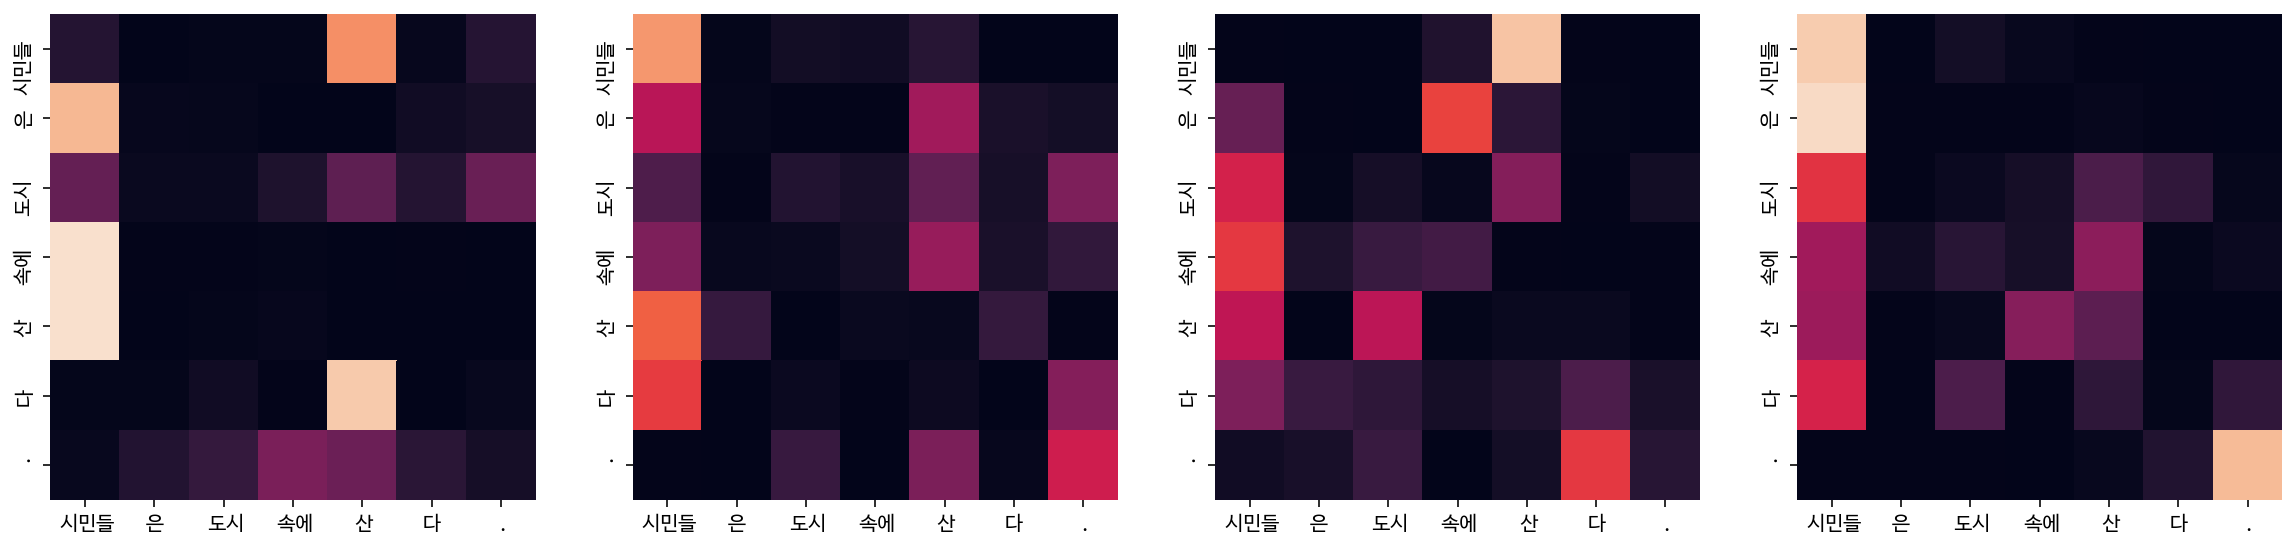

Encoder Layer 2


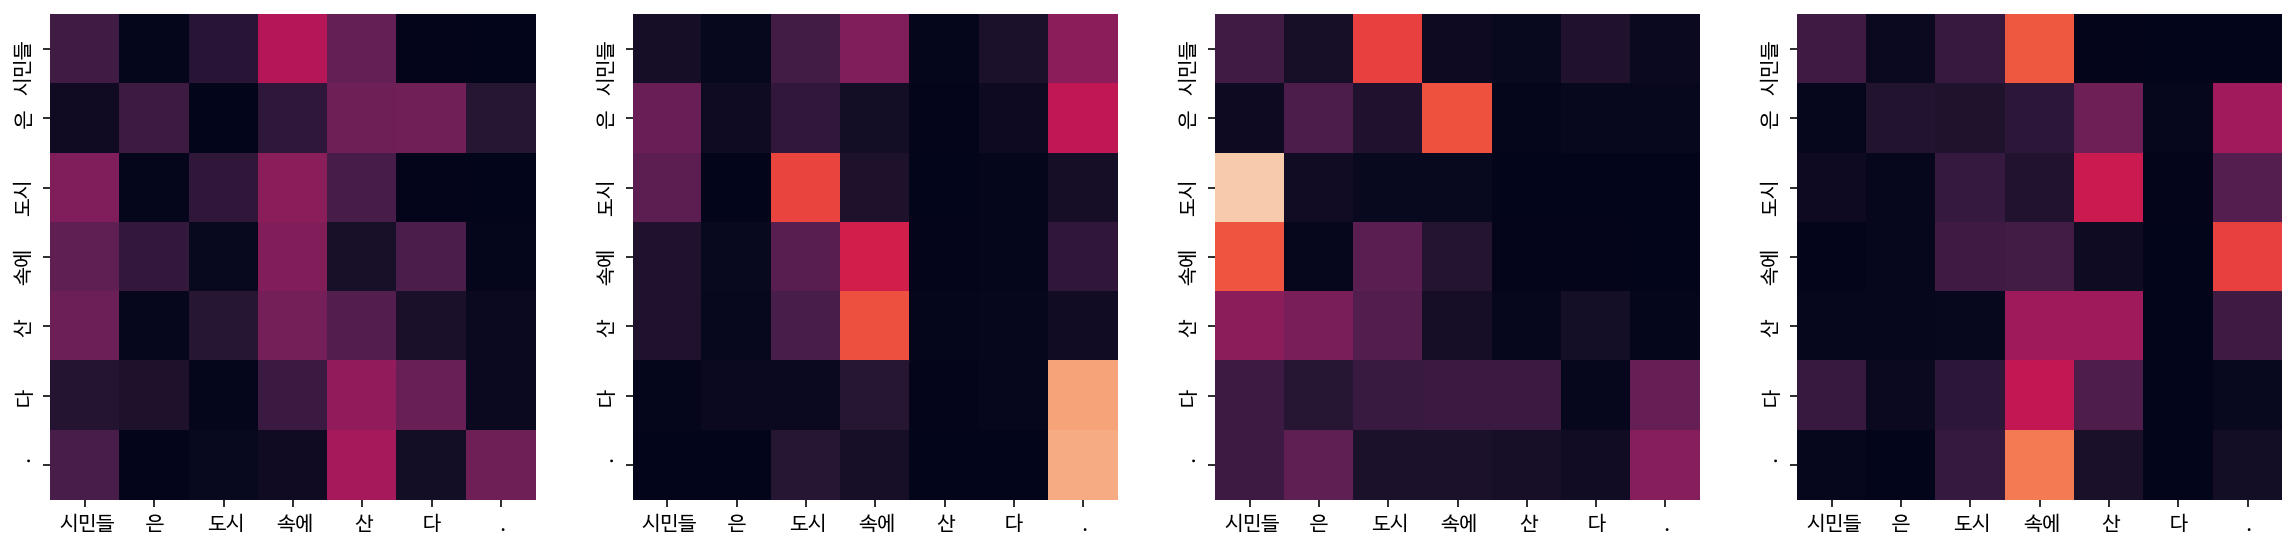

Decoder Self Layer 1


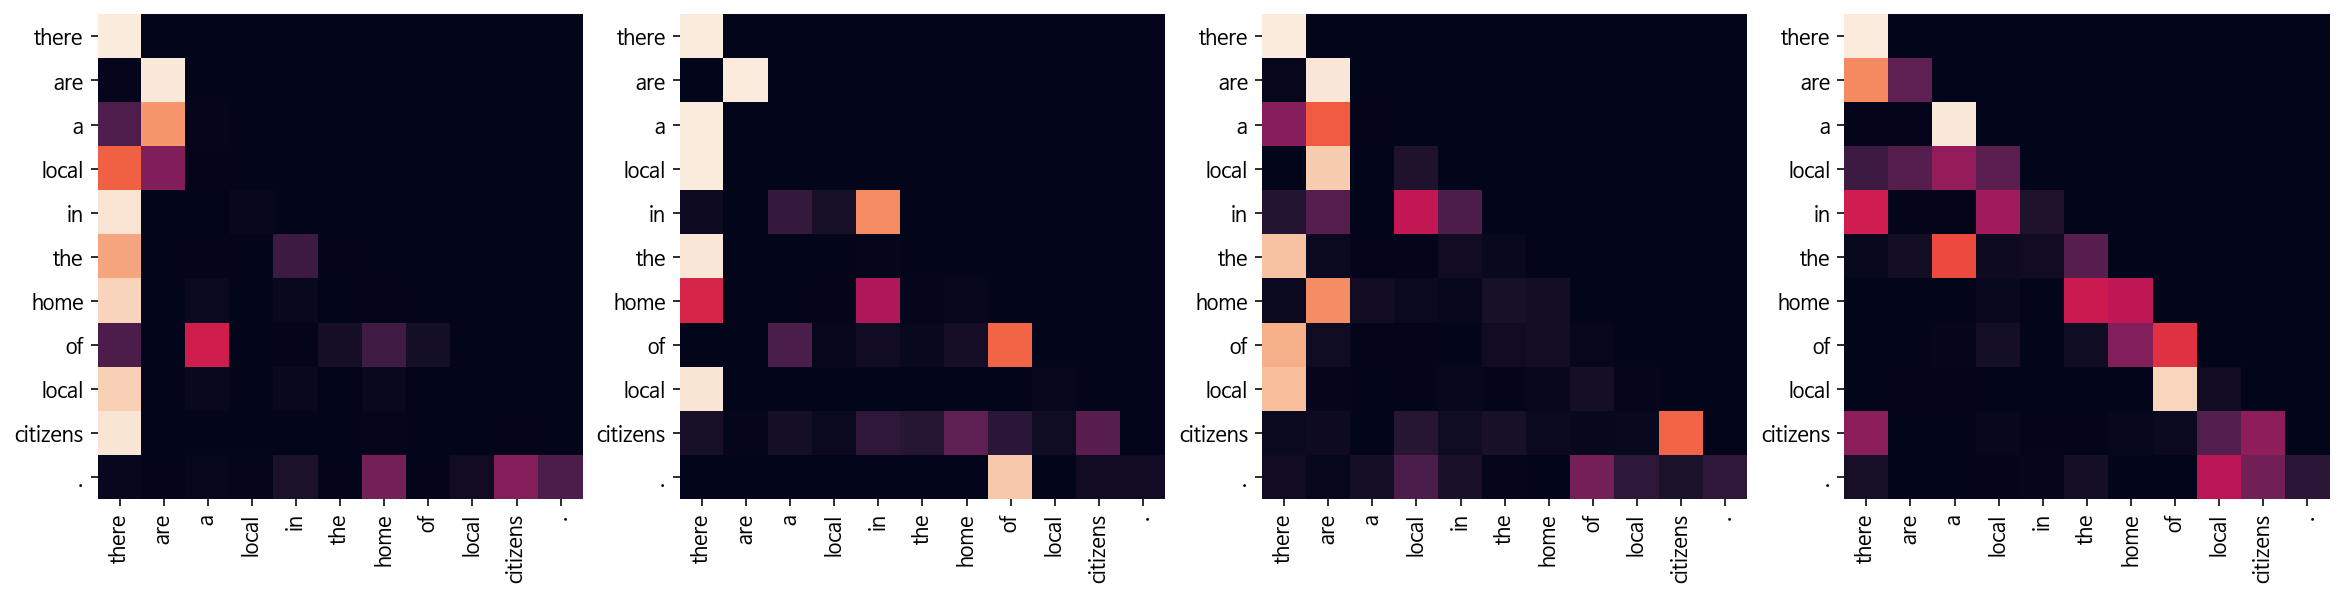

Decoder Src Layer 1


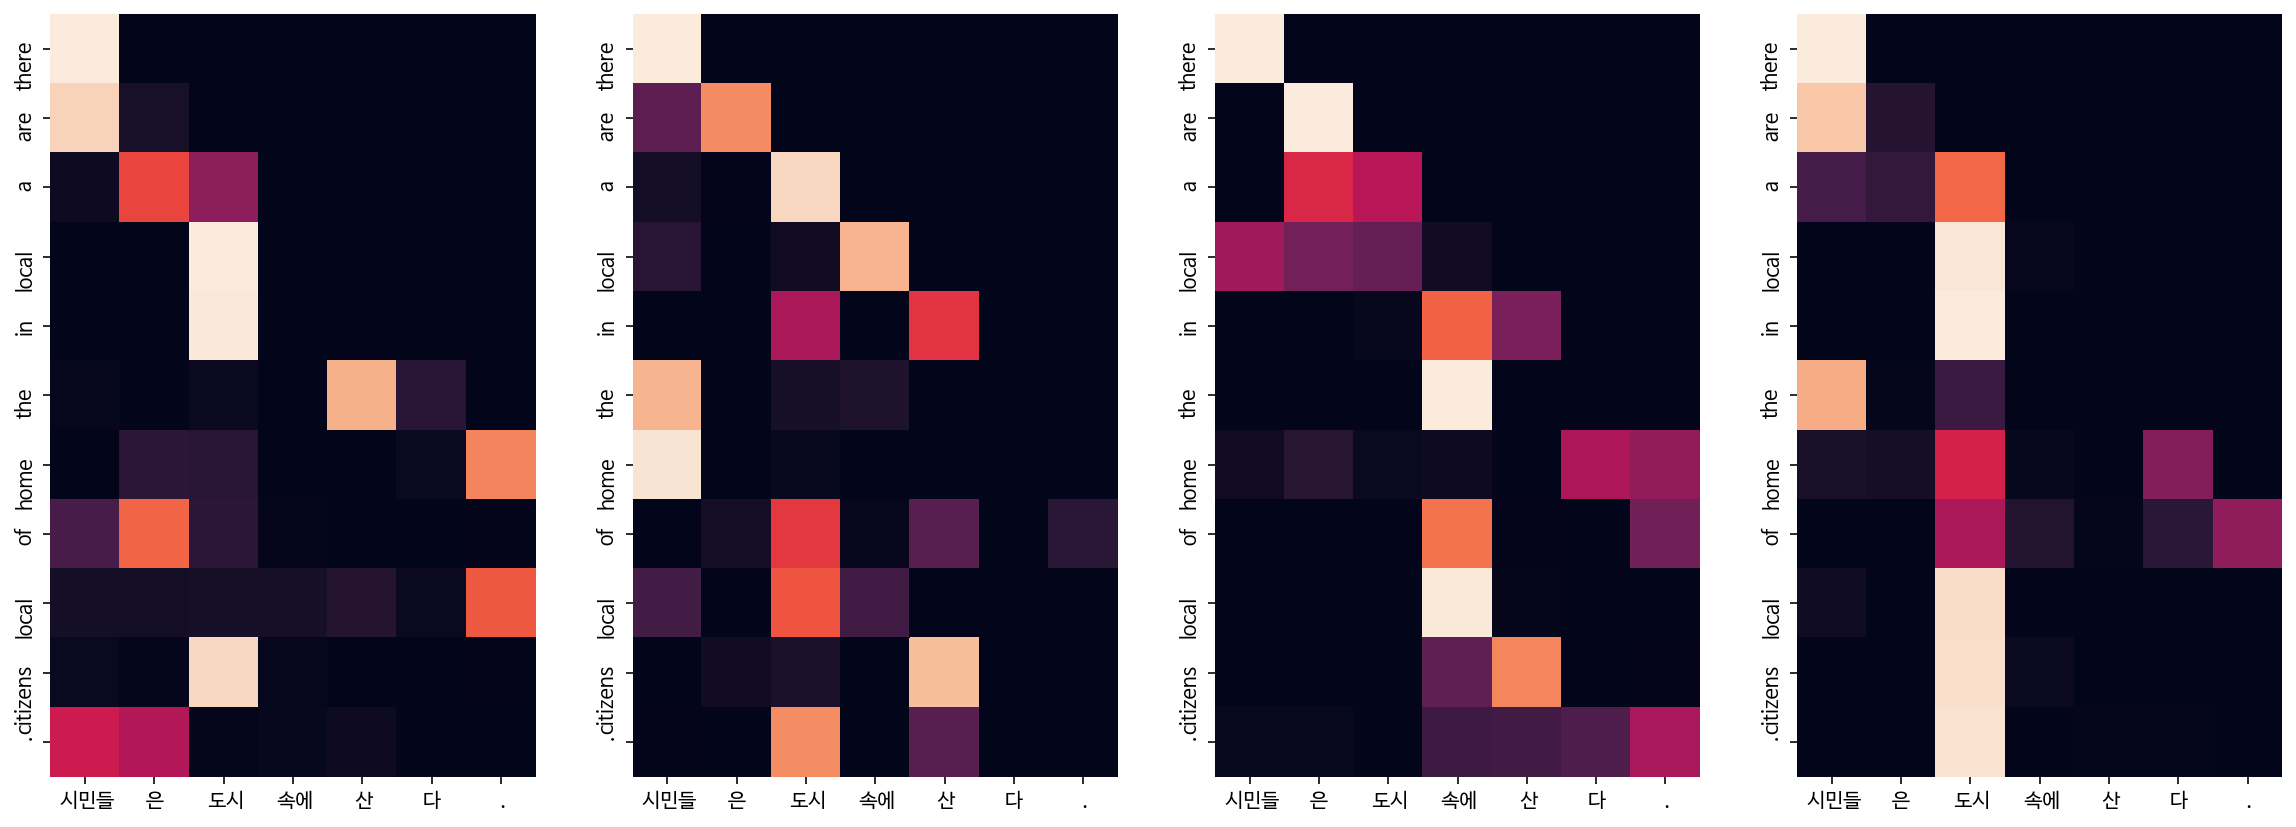

Decoder Self Layer 2


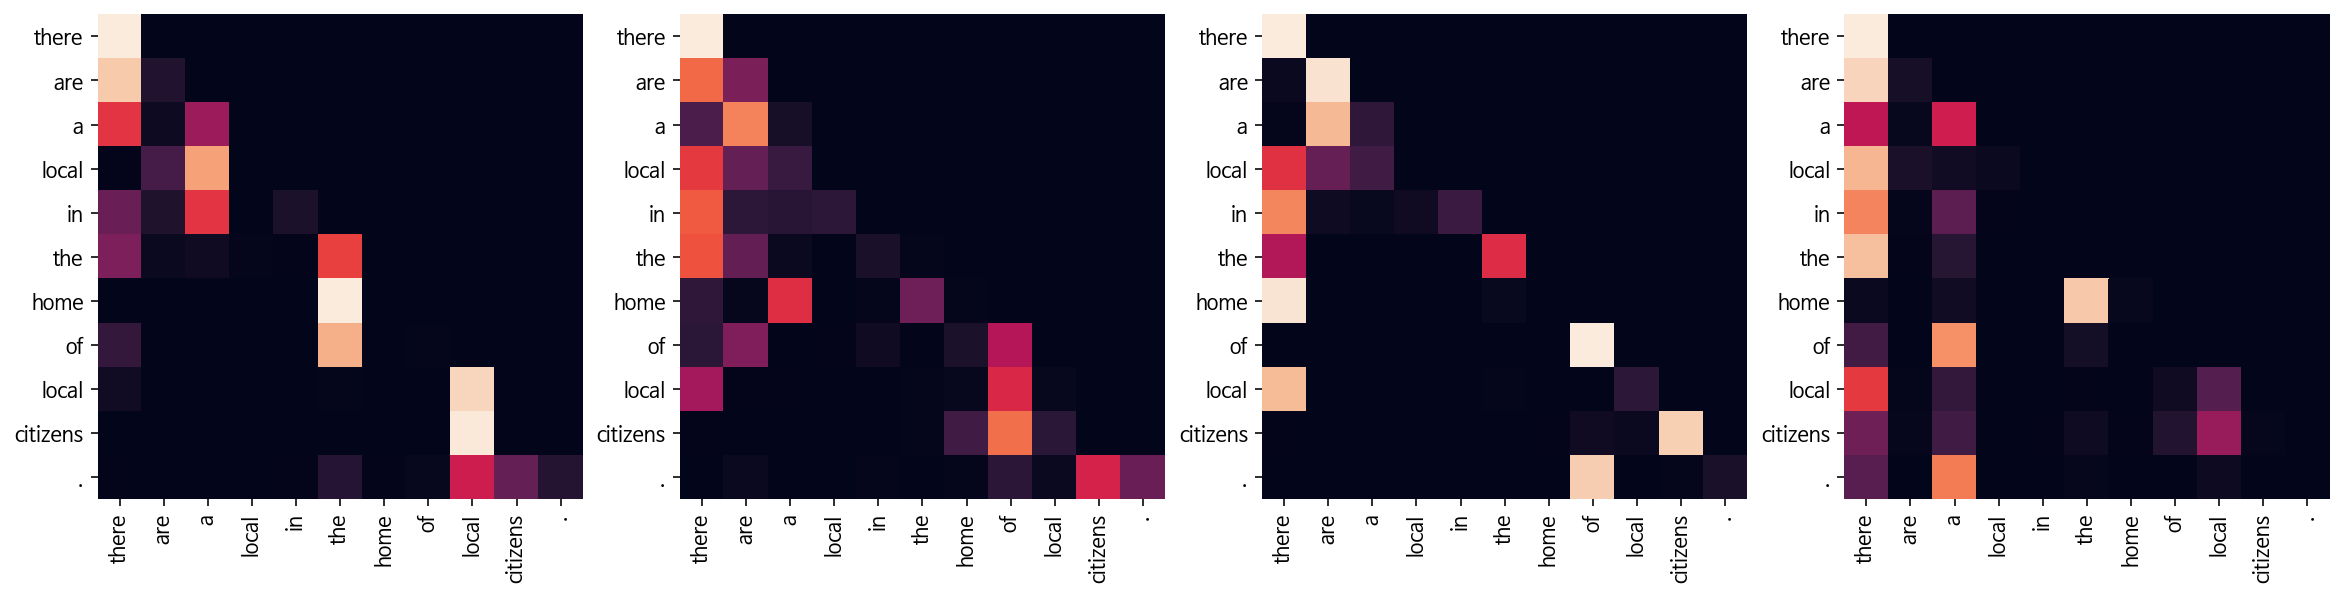

Decoder Src Layer 2


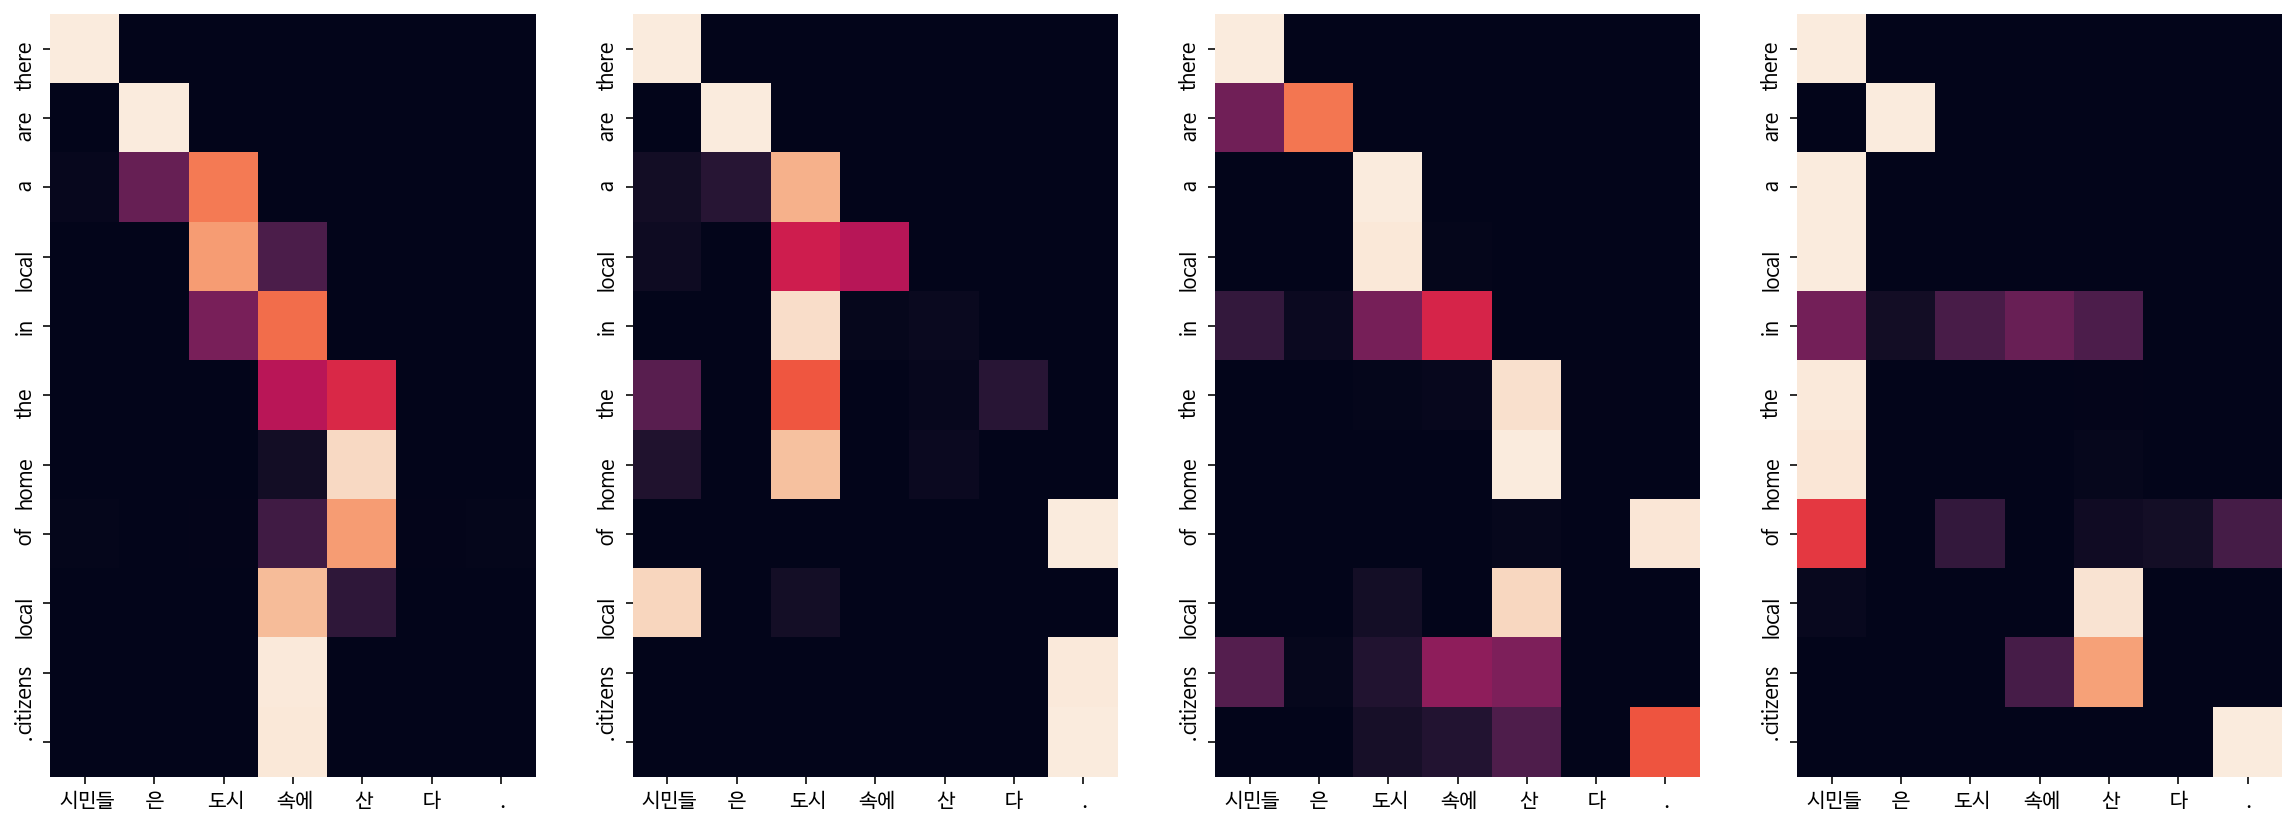



------------------------------
입력 문장 : 커피는 필요 없다.
번역 후 예측 문장 : it s not a chance for coffee .
------------------------------
Encoder Layer 1


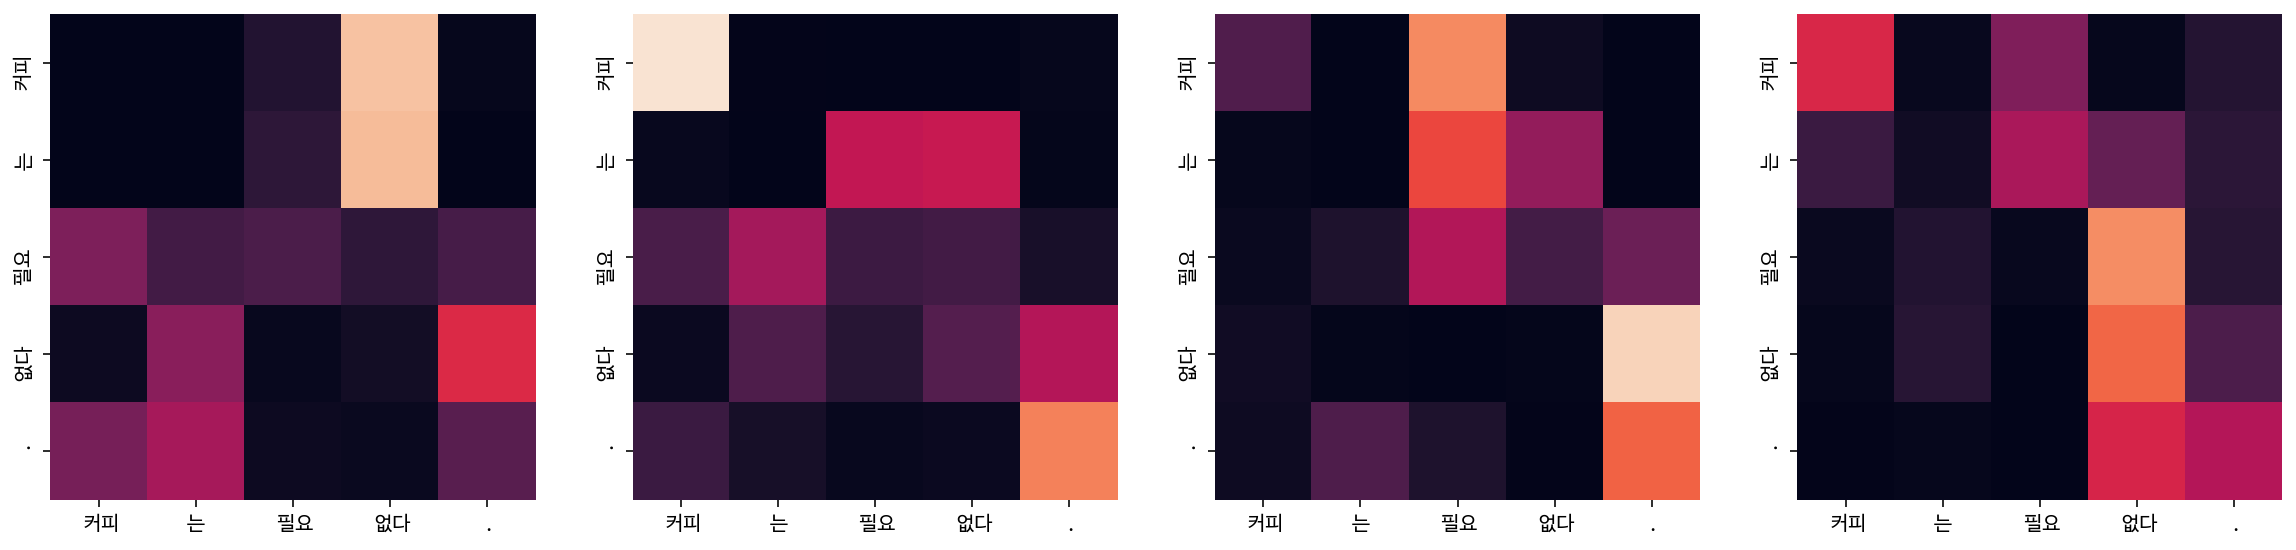

Encoder Layer 2


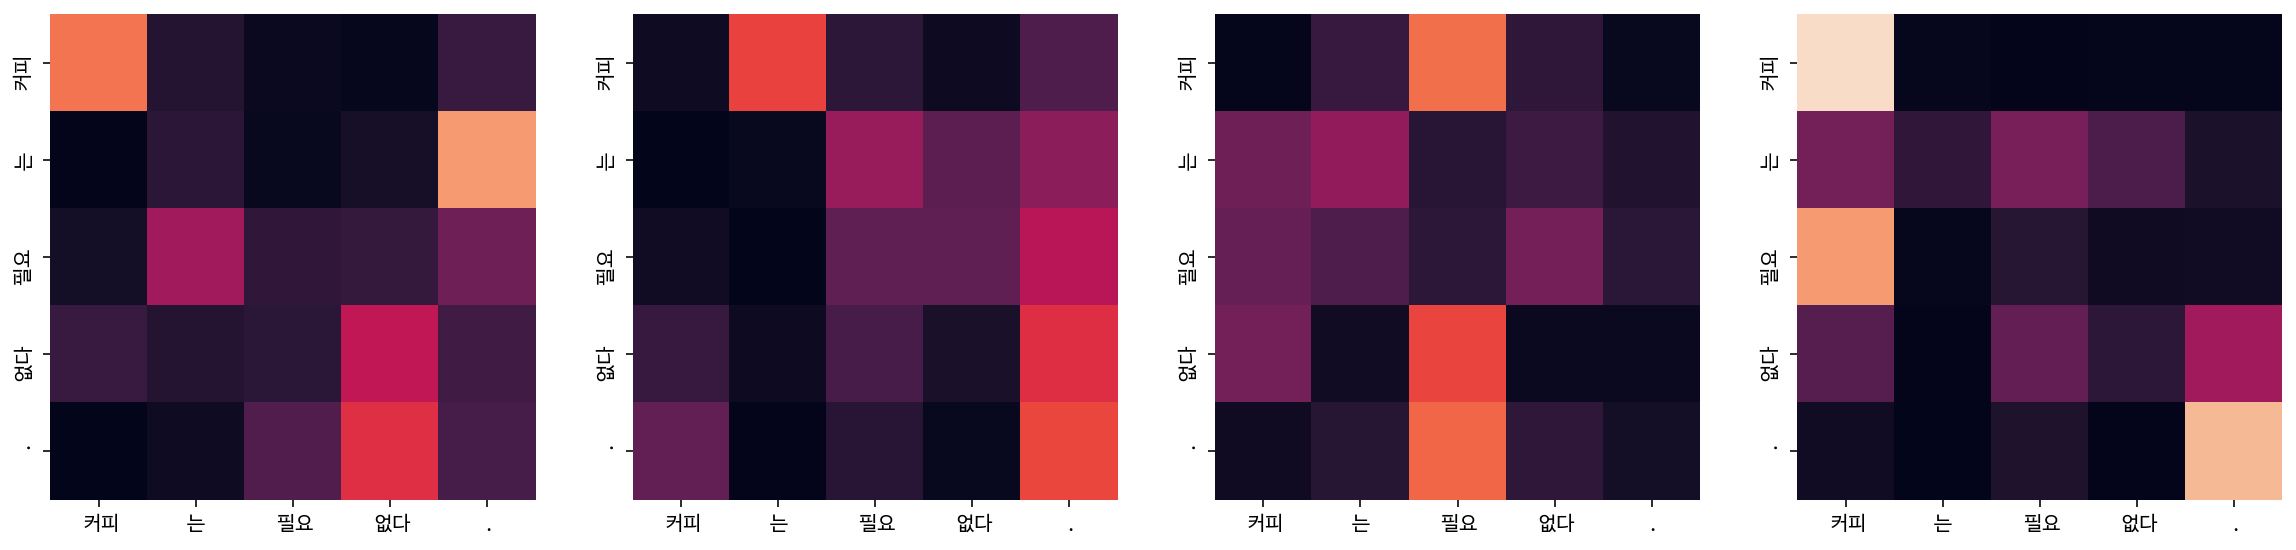

Decoder Self Layer 1


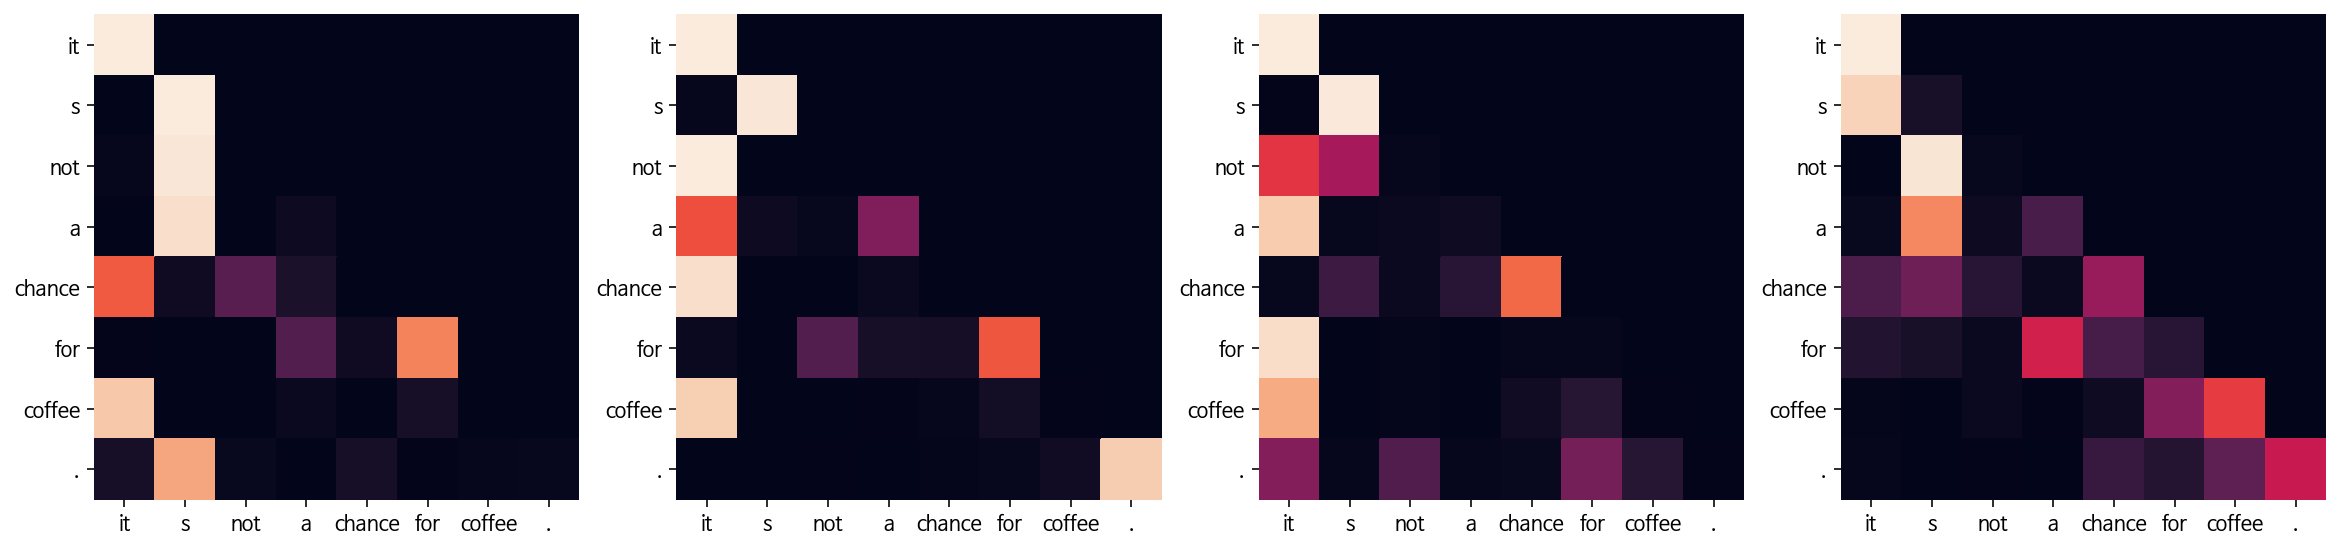

Decoder Src Layer 1


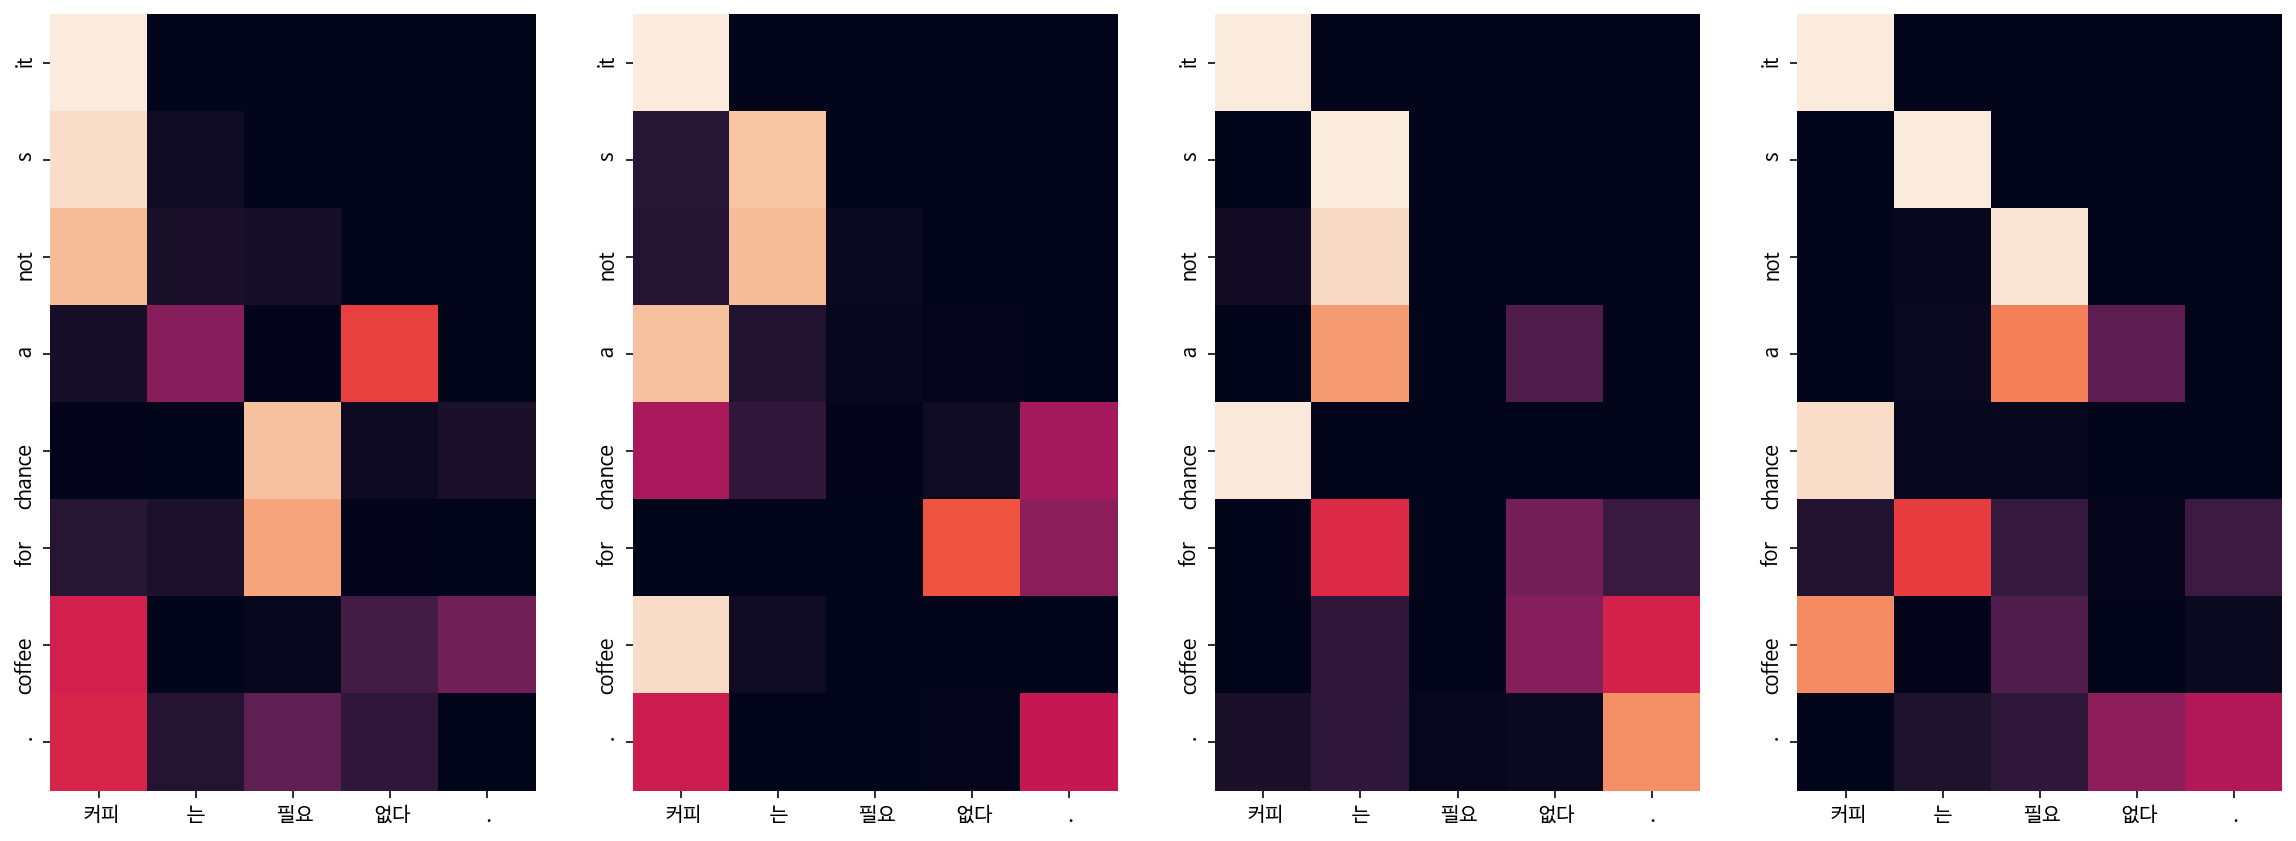

Decoder Self Layer 2


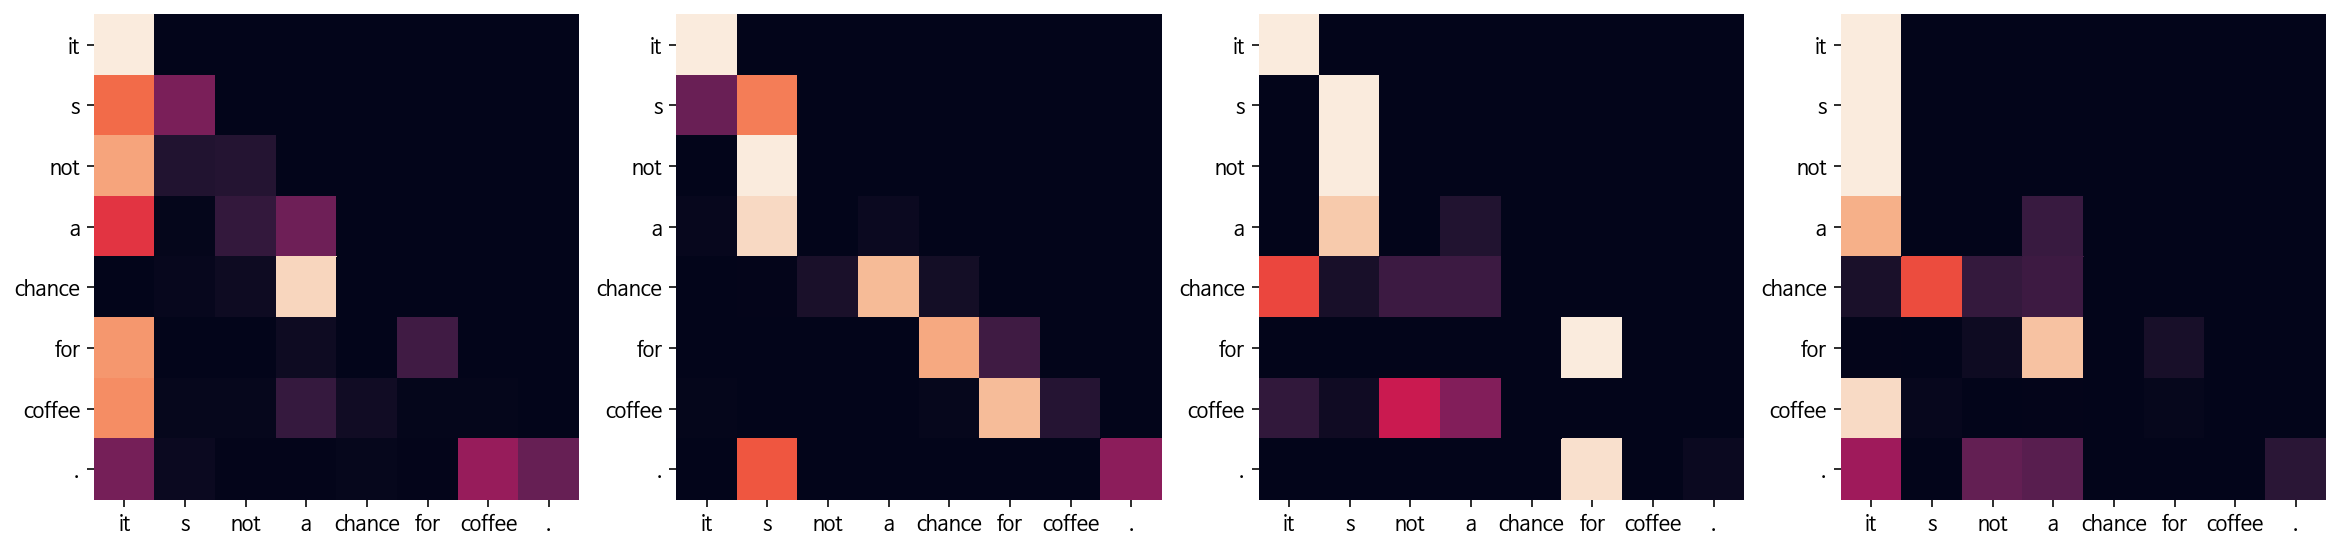

Decoder Src Layer 2


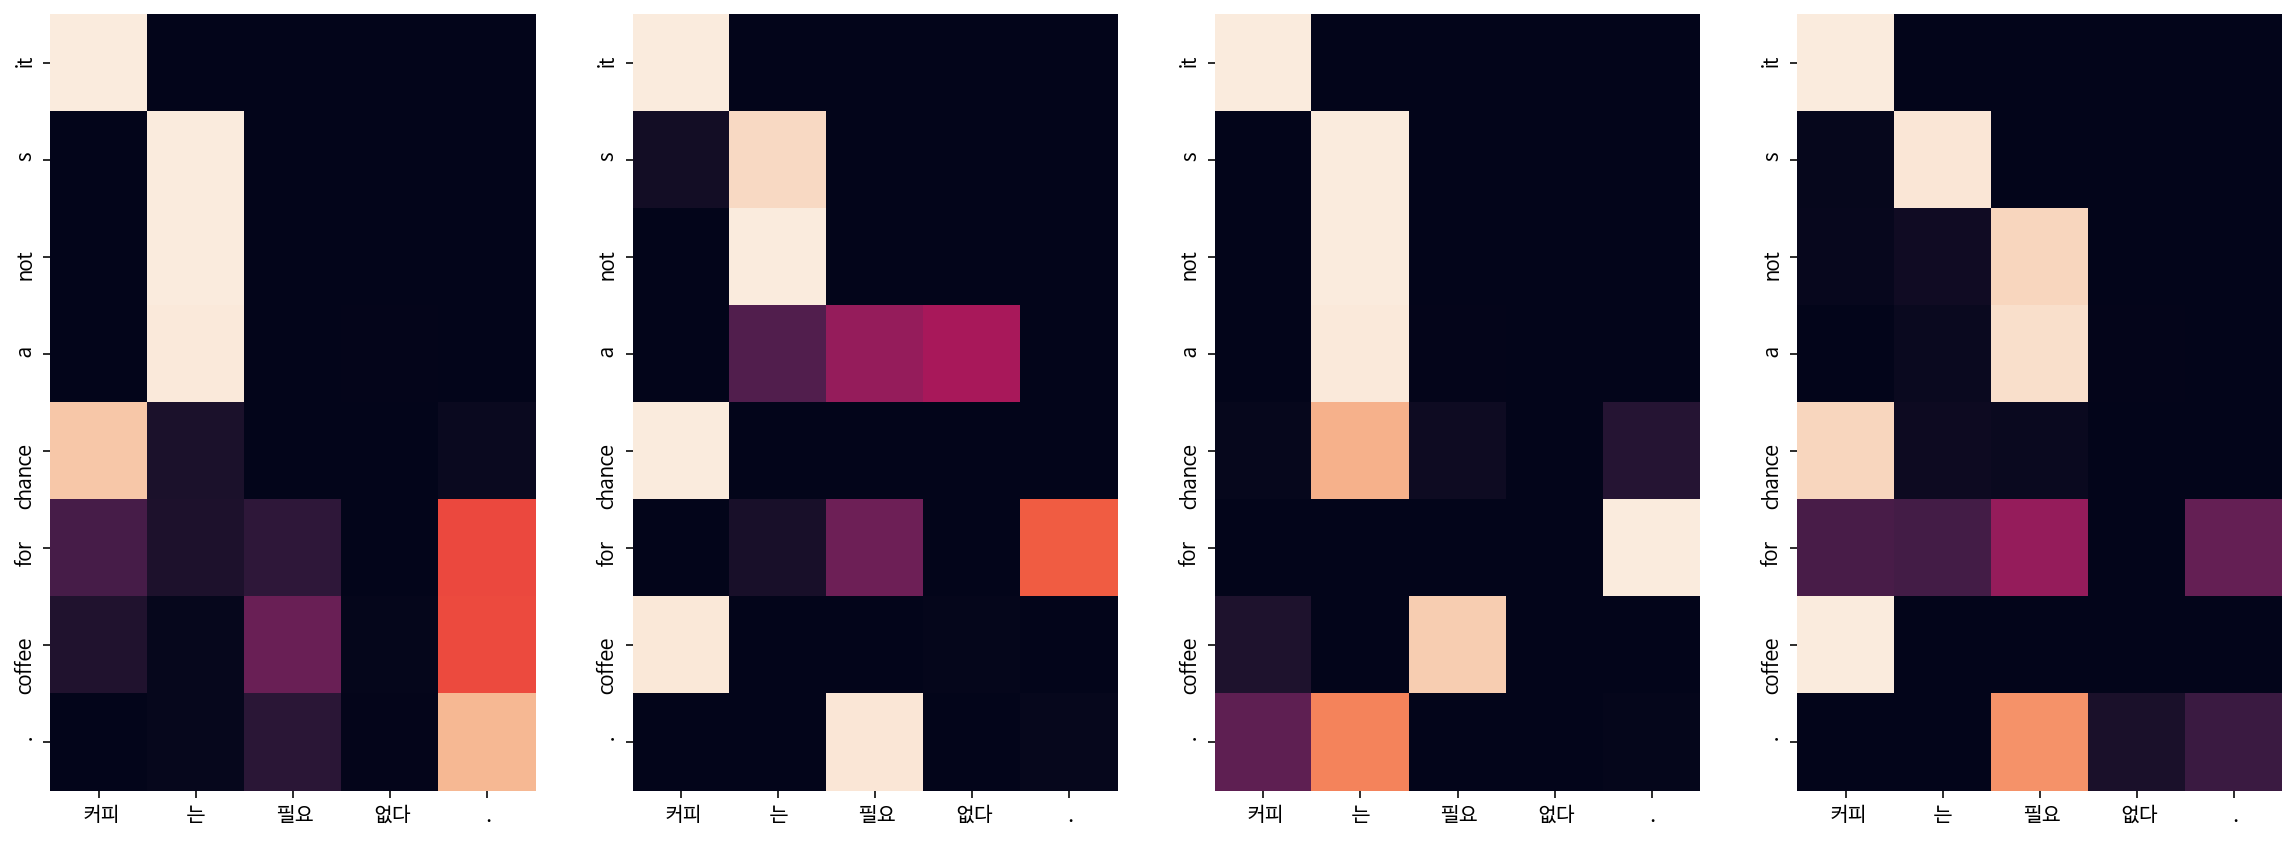



------------------------------
입력 문장 : 일곱 명의 사망자가 발생했다.
번역 후 예측 문장 : seven of the death was reported .
------------------------------
Encoder Layer 1


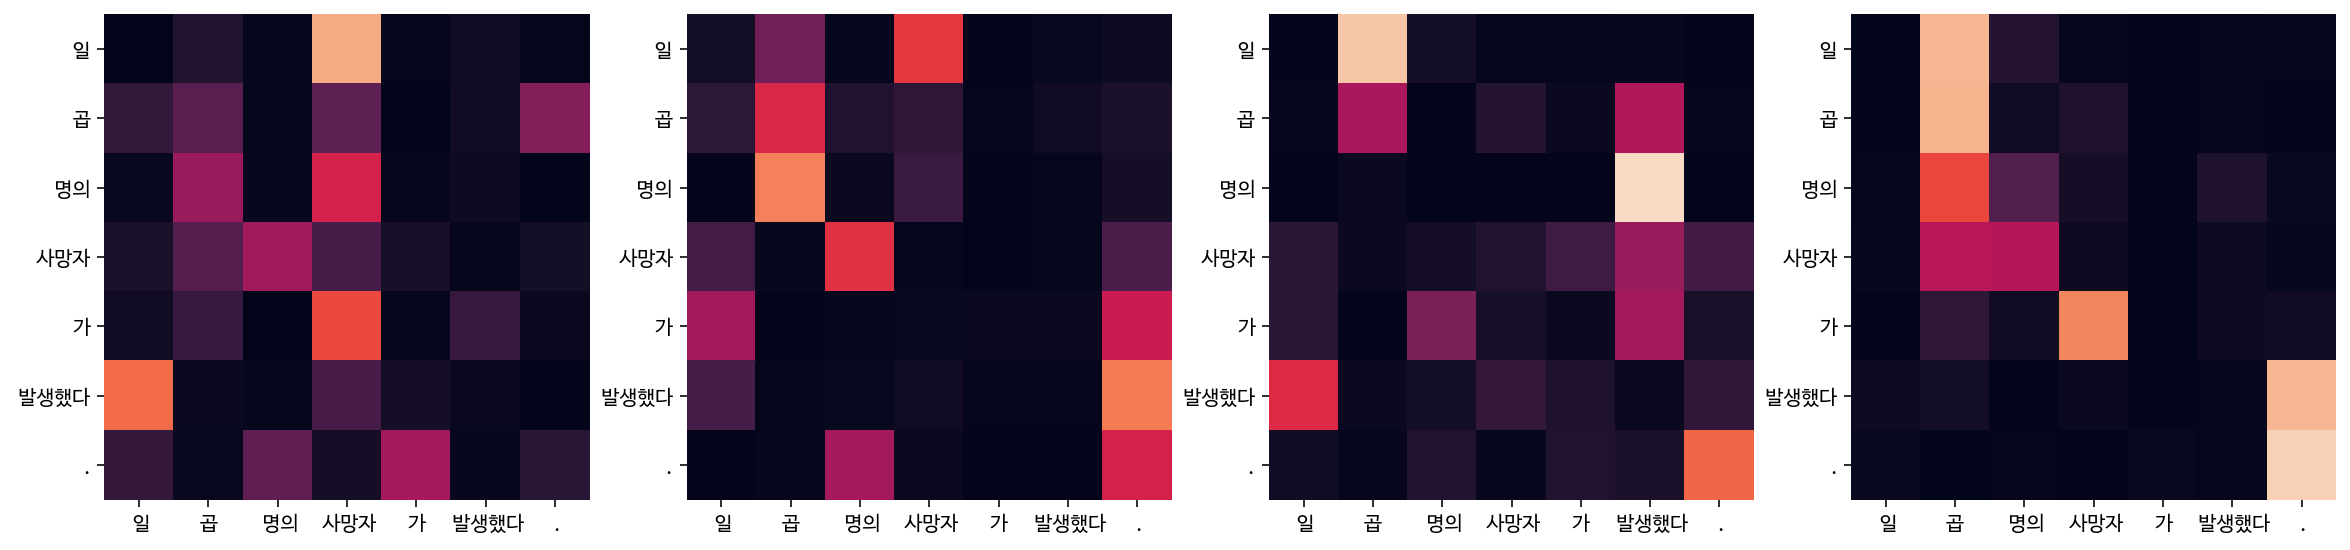

Encoder Layer 2


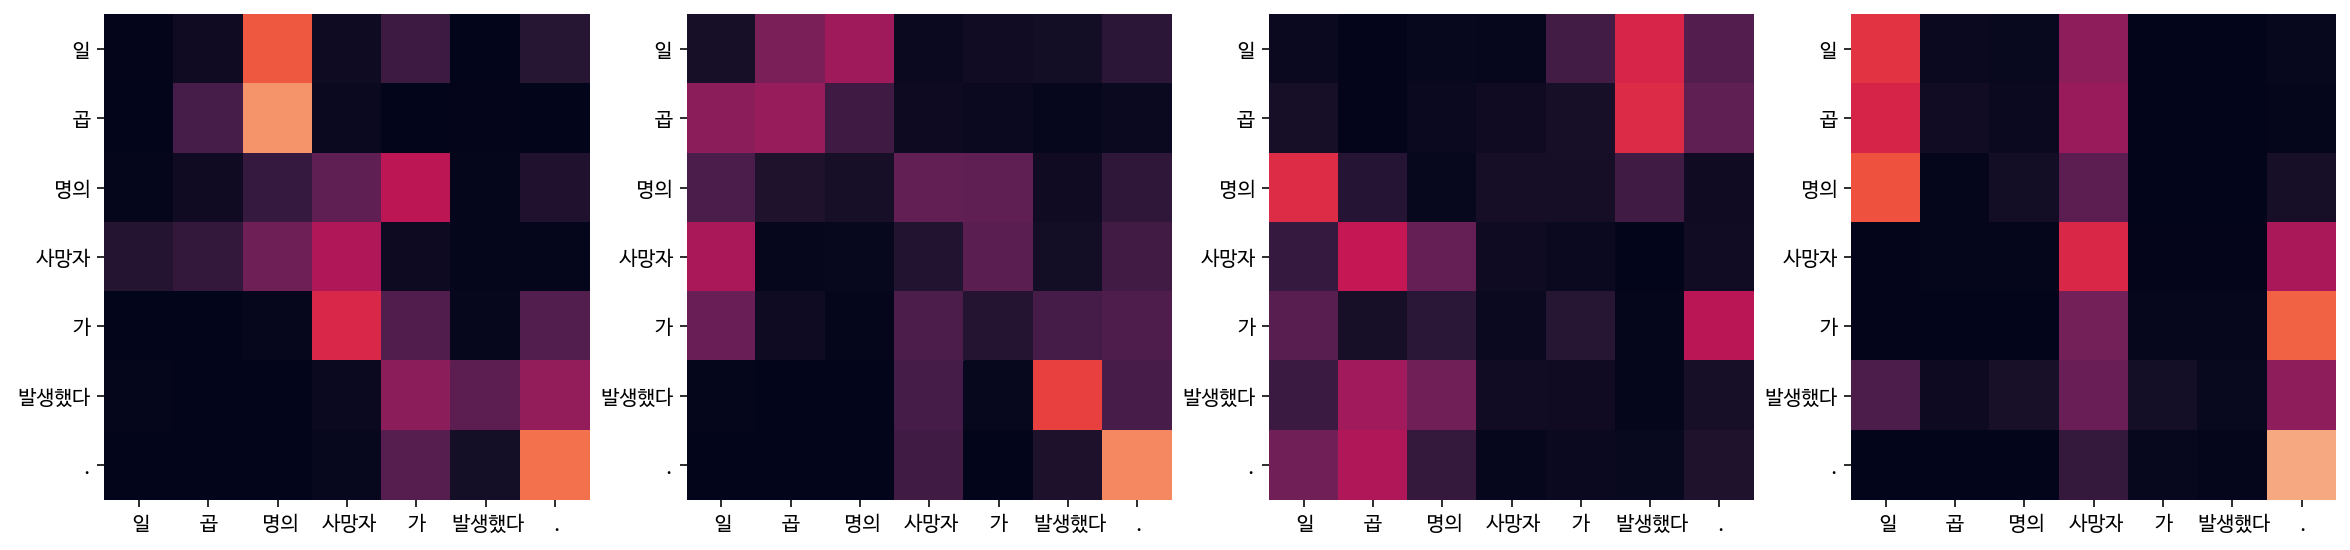

Decoder Self Layer 1


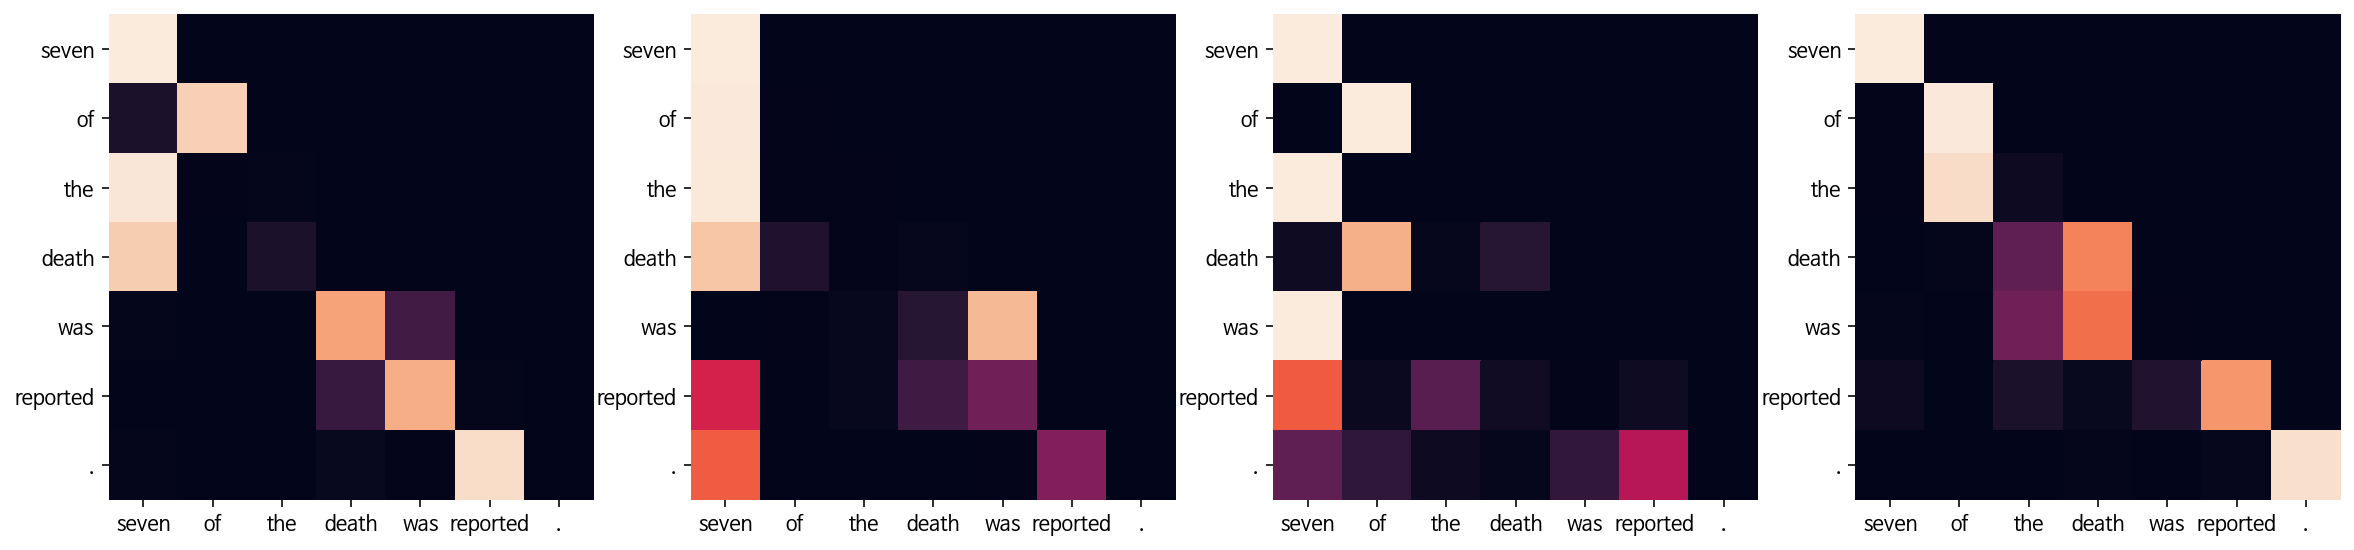

Decoder Src Layer 1


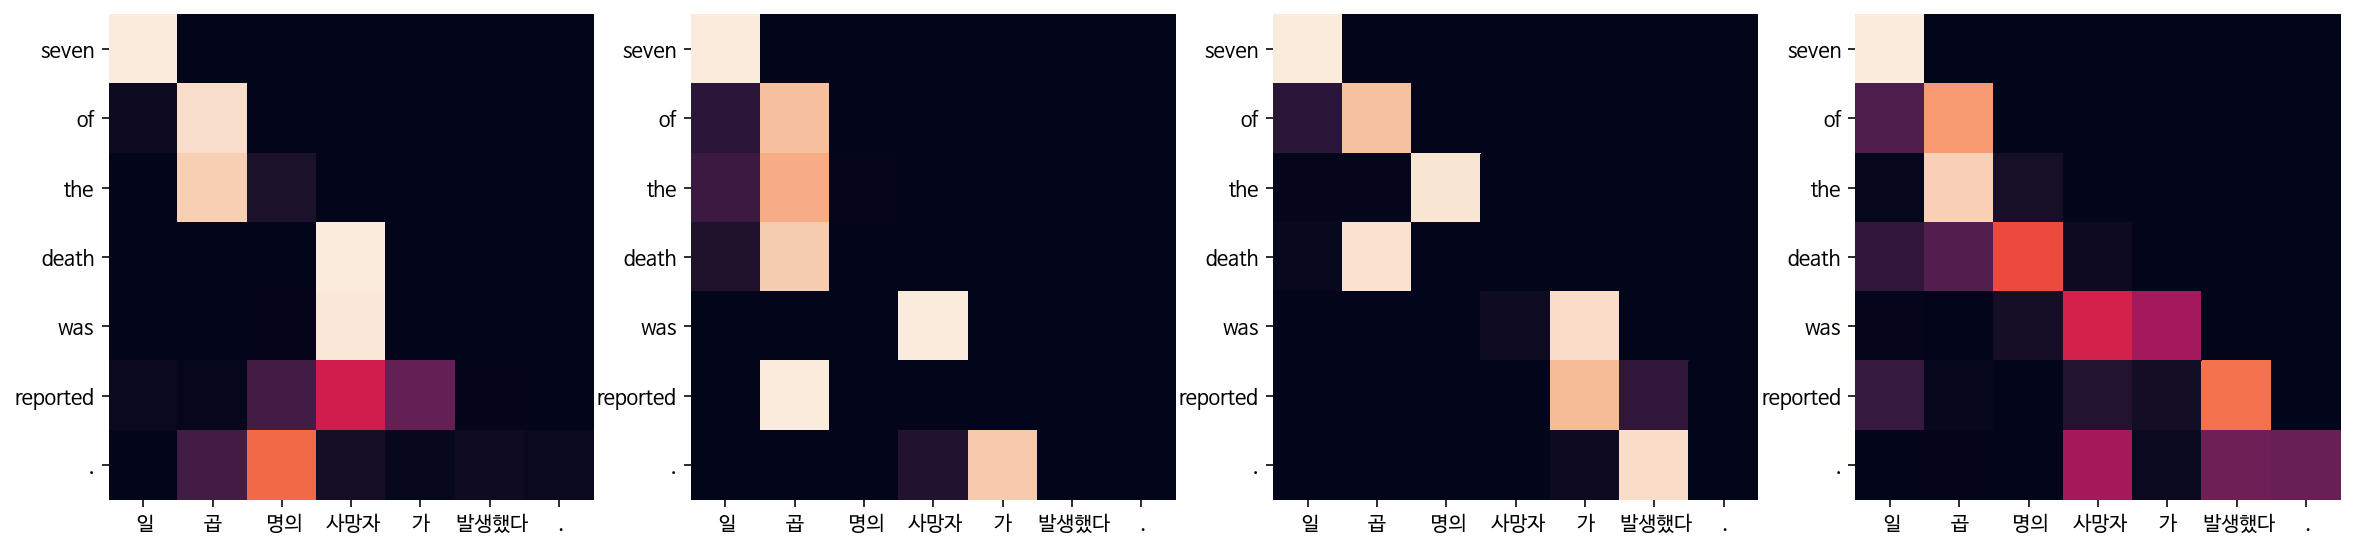

Decoder Self Layer 2


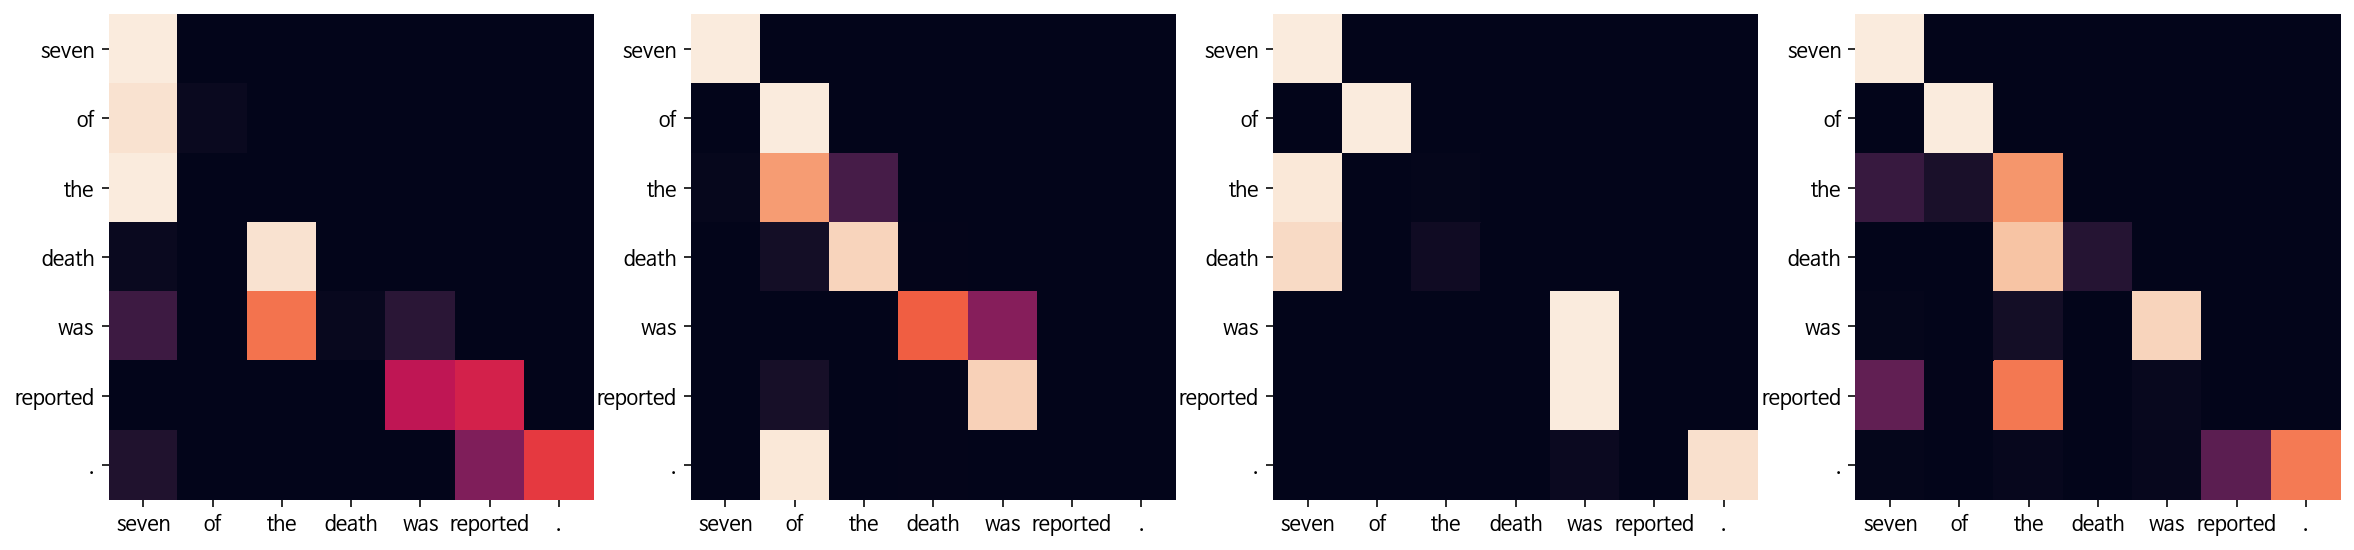

Decoder Src Layer 2


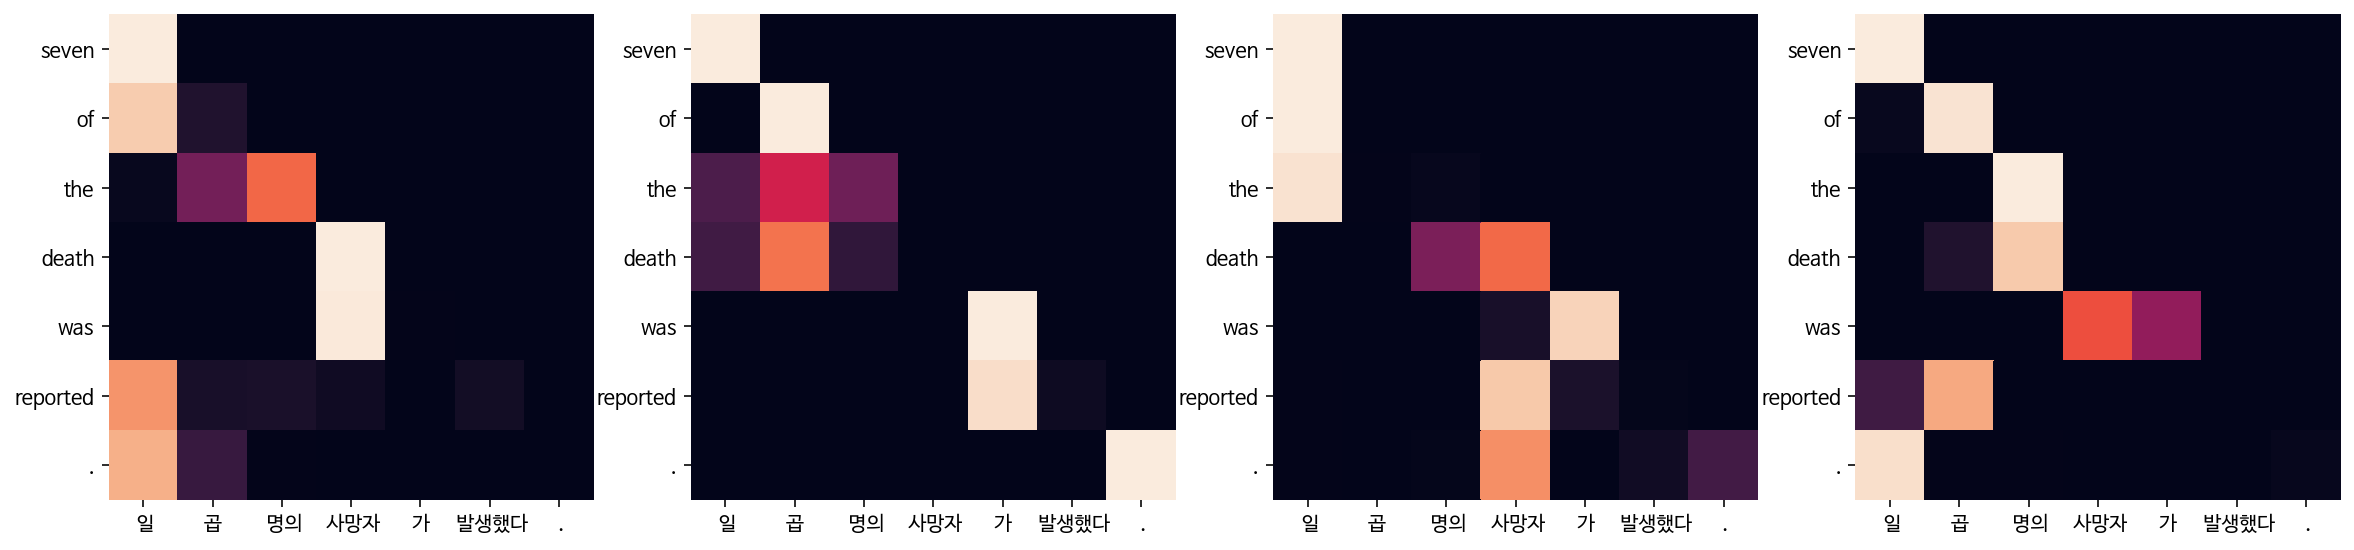

In [38]:
BATCH_SIZE = 64
EPOCHS = 20

transformer = Transformer(n_layers = 2, d_model = 256, n_heads = 8, d_ff = 128,
                    src_vocab_size = 25004, tgt_vocab_size = 25004, pos_len = 200, dropout=0.2, shared=True)


examples = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.", "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_tensor[idx:idx+BATCH_SIZE], dec_tensor[idx:idx+BATCH_SIZE], transformer, optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    print('-'*17,f' {epoch+1} epoch ','-'*17)
    
    for example in examples:
        if(epoch+1) % 5 == 0:
            translate(example, transformer, enc_tokenizer, dec_tokenizer, plot_attention=True)
        else:
            translate(example, transformer, enc_tokenizer, dec_tokenizer, plot_attention=False)

> Epoch를 20회 진행한 결과 최종 Loss 는 0.9177이고, 국문-영문 번역 결과는 아래와 같다.

> Transformer 기반 국문-영문 번역기 결과 ( Epoch 20회 )

> 국문 입력 문장 : 오바마는 대통령이다.<br>
> 영문 번역 문장 : the president is barack obama s pick . -> 대통령은 버락 오바마 s 선택<br>
> 의역 : 대통령은 버락 오바마로 선출되었다<br>

> 국문 입력 문장 : 시민들은 도시 속에 산다.<br>
> 영문 번역 문장 : there are a local in the home of local citizens . -> 그들은 지역 시민의 집에 있다.<br>
> 의역 : 시민은 지역 내 도시에 거주한다. <br>

> 국문 입력 문장 : 커피는 필요 없다.<br>
> 영문 번역 문장 : it s not a chance for coffee . -> 그것은 커피를 위한 기회가 아니다.<br>
> 의역 : 그것이 커피일 필요는 없다.<br>

> 입력 문장 : 일곱 명의 사망자가 발생했다.<br>
> 번역 후 예측 문장 : seven of the death was reported . -> 7명의 사망자가 보고되었다.<br>
> 의역 : 7명의 사망자가 발생했다.<br>

> Epoch를 20회 진행한 Transformer model은 이전 Epoch를 10회 Transformer model보다 준수한 번역 성능을 보여주었다.<br>
> 입력된 국문의 단어와 최대한 유사한 단어로 번역되었며, 기존 문맥과 매우 유사하게 번역한 모습을 확인할 수 있다.<br>
> <br>
> 그러나, be동사 또는 불규칙 동사같이 문맥에 따라 변화하는 문법에는 아직 약한 모습을 보여주었다.<br>
> 또한, 특유의 기계적인 번역 결과를 보여주며, 아직은 부자연스러운 번역 성능을 보여주었다.

> 위 학습 결과를 정리하여 나타내면 아래 표와 같다.

|국문|영문 번역 Transformer(Epoch10)|영문 번역 Transformer(Epoch20)|
|------|------|------|
|오바마는 대통령이다.|obama s president is now in the presidential election .|the president is barack obama s pick . |
|시민들은 도시 속에 산다.|the citizens are the citizens . |there are a local in the home of local citizens .|
|커피는 필요 없다.|not coffee or prices .|it s not a chance for coffee .|
|일곱 명의 사망자가 발생했다.|seven of the dead were killed .|seven of the death was reported .|